In [0]:
import pandas as pd 
import numpy as np 
import pickle
import shutil
import torch
import torch.nn as nn
import torch.autograd as at
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import sklearn
import time
import os
import random
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
#from sklearn.preprocessing import Normalizer
from sklearn.preprocessing.data import QuantileTransformer
import seaborn as sns
import matplotlib.pyplot as plt
from utils import prepare_data_lstm, ExampleDataset, save_checkpoint, evaluate_lstm
from lstm import Lstm , Lstm_Model
from AE import Autoencoder
from wt import waveletSmooth
import warnings
warnings.filterwarnings("ignore")
plt.ioff()
from math import sqrt
import csv
#from deap import base, creator, tools, algorithms


In [11]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130911 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [13]:
cd /content/drive

/content/drive


In [14]:
cd app/hvlabs/TensorFlow

/content/drive/app/hvlabs/TensorFlow


In [0]:
import sys
sys.path.append('hvlabs/TensorFlow/')

In [0]:
#!pip install plaidml
#import plaidml
#!pip uninstall pywt
#!pip install pywavelets
#!pip install statsmodels
#!pip install sklearn
#!pip install pandas
#!pip install seaborn
#!pip install tensorflow
#import numpy
#!pip install keras

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as split
import warnings
warnings.filterwarnings("ignore")

from keras.layers import LSTM, Input, Dense
from keras.models import Model

#from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
#from bitstring import BitArray
#import logging
#from network import Network
#from optimizer import Optimizer
#from tqdm import tqdm
import random
from functools import reduce
#import plaidml
import os
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
#plaidml.keras.install_backend()
from operator import add
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier , KerasRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
import keras.layers as kl
from keras.models import Model
from keras import regularizers


In [0]:
#!pip install bitstring

In [0]:
#!pip install pyod

In [0]:
#!pip install deap

In [0]:
#!pip install statsmodels

In [0]:
#?F.kl_div

In [0]:
#?nn.LSTM

In [0]:
#?F.kl_div(p, q)

In [0]:
#path = "sp.csv"
data_master = pd.read_excel("sp.xlsx")

num_datapoints = 600
step_size = 60
num_iterations = int(np.ceil((len(data_master)-num_datapoints)/step_size))


In [0]:
#!pip install xlrd

In [27]:
data_master.head()

,Ntime,Time,Closing Price,Open Price,High price,Low Price,Volume,MACD,CCI,ATR,BOLL_MID,EMA20,MA10,MTM6,MA5,MTM12,ROC,SMI,WVAD,US Dollar Index,HIBOR
0,20080702,733591,21704.4492,21785.3906,21938.1992,21555.5293,254858.26,-646.053200,-193.115118,546.4805,23344.245915,22956.709411,22497.96286,-751.5703,22187.92768,-887.8516,-5.754486,-0.069509,-401619.369837,71.99,1.6
1,20080703,733592,21242.7793,21389.4902,21742.0703,21163.5703,272528.48,-702.282620,-186.955957,578.5000,23233.302427,22793.477972,22289.66071,-1392.3806,21909.45156,-1786.9102,-7.872373,-0.068201,-507305.257079,72.73,1.6
2,20080704,733593,21423.8203,21402.1699,21534.0508,21344.8496,179634.42,-723.891770,-133.742667,291.2715,23123.370935,22663.034384,22152.28180,-1031.8496,21703.08164,-1634.1699,-8.153977,-0.058111,-398848.614015,72.71,1.6
3,20080707,733596,21913.0605,21402.6992,21916.2109,21402.6992,196457.92,-693.544830,-77.445777,513.5117,23033.507500,22591.608300,22069.02789,-129.2891,21677.22382,-1412.7403,-3.880007,-0.035303,-264228.169678,72.71,1.6
4,20080708,733597,21220.8105,21632.6992,21684.2109,21098.8398,201519.68,-717.087314,-108.634123,814.2207,22911.846742,22461.056128,21919.61285,-881.1993,21500.98396,-1576.7989,-6.703666,-0.055006,-518512.844172,72.96,1.6


In [28]:
data_master.columns

Index(['Ntime', 'Time', 'Closing Price', 'Open Price', 'High price',
       'Low Price', 'Volume', 'MACD', 'CCI', 'ATR', 'BOLL_MID', 'EMA20',
       'MA10', 'MTM6', 'MA5', 'MTM12', 'ROC', 'SMI', 'WVAD', 'US Dollar Index',
       'HIBOR'],
      dtype='object')

In [29]:
num_iterations

24

In [0]:
y_test_lst = []
preds = []
ct = 0

In [0]:
#np.percentile(data_master['Volume'] ,[0,1,2,5,50,75,90,99,100])

In [0]:
data_master.loc[data_master['Closing Price'] < 15700, 'Closing Price'] = 15700
data_master.loc[data_master['Closing Price'] > 27500, 'Closing Price'] = 27500
data_master.loc[data_master['Open Price'] < 15700, 'Open Price'] = 15700
data_master.loc[data_master['Open Price'] > 27500, 'Open Price'] = 27500
data_master.loc[data_master['High price'] < 15700, 'High price'] = 15700
data_master.loc[data_master['High price'] > 27500, 'High price'] = 27500
data_master.loc[data_master['Low Price'] < 15700, 'Low Price'] = 15700
data_master.loc[data_master['Low Price'] > 27500, 'Low Price'] = 27500
data_master.loc[data_master['Volume'] < 50000, 'Volume'] = 50000
data_master.loc[data_master['Volume'] > 325000, 'Volume'] = 325000
data_master.loc[data_master['MACD'] < -800, 'MACD'] = -800
data_master.loc[data_master['MACD'] > 800, 'MACD'] = 800
#data_master.loc[data_master['Closing Price'] < 15700, 'Closing Price'] = 15700
data_master.loc[data_master['ATR'] > 750, 'ATR'] = 750
data_master.loc[data_master['BOLL_MID'] < 16000, 'BOLL_MID'] = 16000
#data_master.loc[data_master['Closing Price'] > 27500, 'Closing Price'] = 27500
data_master.loc[data_master['EMA20'] < 15700, 'EMA20'] = 15700
data_master.loc[data_master['EMA20'] > 27500, 'EMA20'] = 27500
data_master.loc[data_master['MA10'] < 15700, 'MA10'] = 15700
data_master.loc[data_master['MA10'] > 27500, 'MA10'] = 27500
data_master.loc[data_master['MTM6'] < -1900, 'MTM6'] = -1900
data_master.loc[data_master['MTM6'] > 1900, 'MTM6'] = 1900
data_master.loc[data_master['MA5'] < 15700, 'MA5'] = 15700
data_master.loc[data_master['MA5'] > 27500, 'MA5'] = 27500
data_master.loc[data_master['MTM12'] < -2250, 'MTM12'] = -2250
data_master.loc[data_master['MTM12'] > 2500, 'MTM12'] = 2500
data_master.loc[data_master['ROC'] < -12, 'ROC'] = -12
data_master.loc[data_master['ROC'] > 12, 'ROC'] = 12
data_master.loc[data_master['SMI'] < -0.1, 'SMI'] = -0.1
data_master.loc[data_master['SMI'] > 0.1, 'SMI'] = 0.1
data_master.loc[data_master['WVAD'] < -1500000, 'WVAD'] = -1500000
data_master.loc[data_master['WVAD'] > 1000000, 'WVAD'] = 1000000
data_master.loc[data_master['US Dollar Index'] > 98, 'US Dollar Index'] = 98
data_master.loc[data_master['HIBOR'] > 0.125, 'HIBOR'] = 0.125

In [33]:
data_master.shape

(2037, 21)

In [0]:
len(data_master)-4

2033

In [0]:
input = np.array(data_master)
nb_timesteps = 4

flag = 0

for sample in range(input.shape[0]):
    tmp = np.array([input[sample,i:i+nb_timesteps,:] for i in range(input.shape[1] - nb_timesteps + 1)])

    if flag==0:
        new_input = tmp
        flag = 1

    else:
        new_input = np.concatenate((new_input,tmp))

IndexError: too many indices for array

In [0]:
def prepare_dataset(data, window_size):
    X, Y = np.empty((window_size,1)), np.empty((1))
    for i in range(len(data)-window_size-1):
        X = np.vstack([X,data[i:(i + window_size),1]])
        Y = np.append(Y,data[i + window_size,1])   
    X = np.reshape(X,(len(X),window_size,21))
    Y = np.reshape(Y,(len(Y),1))
    return X, Y

X_train,y_train = prepare_dataset(data_master,4)
print(X_train)
print(y_train)

TypeError: '(slice(0, 4, None), 1)' is an invalid key

In [0]:

    
    def make_train_model(ga_individual_solution):
        hidden = BitArray(ga_individual_solution[0])
        #d = BitArray(ga_individual_solution[1])
        #r_d = 0.2 ,l2_r = 0.003,l2_rr = 0.001 ,lstm_act = 'relu',act = 'sigmoid')
        #r_d = BitArray(ga_individual_solution[2])
        #l2_r = BitArray(ga_individual_solution[3])
        #l2_rr = BitArray(ga_individual_solution[4])
        #lstm_act = BitArray(ga_individual_solution[5])
        #act = BitArray(ga_individual_solution[6])   

        hidden = hidden.uint
        #d = d.uint
        #r_d = r_d.uint
        #l2_r = l2_r.uint
        #l2_rr = l2_rr.uint
        #lstm_act = lstm_act.uint
        #act = act.uint


        #x_train, y_train = prepare_data_lstm(train_encoded, y_train_input, time_steps, log_return=True, train=True)
        #x_val, y_val = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train=False)
        #x_test, y_test = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train=False)

        x_tr = np.array(x_train)
        y_tr = np.array(y_train)
        #y_tr.reshape
        print('shape of x train and y train are',x_tr[-1])
        #print(y_tr.shape)
        tx = x_tr[0].shape
        ty = y_tr.ravel()
        tr = ty.reshape(-1,1)
        inp = str(tx)
        #print(inp)

        #print(sh)
        print('y_train is' , ty.shape)

        x_te = np.array(x_test)
        y_te = np.array(y_test)
        #y_tr.reshape
        #print('shape of x train and y train are',x_tr.shape)
        #print(y_tr.shape)
        tesy = y_te.ravel()
        tex = x_te[0].shape
        tey = tesy.reshape(-1,1)
        ter = tey.reshape(-1,1)

        #print(sh)
        #print('y_train is' , ter[0].shape)

        x_v = np.array(x_validate)
        y_v = np.array(y_validate)
        #y_tr.reshape
        #print('shape of x train and y train are',x_tr.shape)
        #print(y_tr.shape)
        vx = x_v[0].shape
        vy = y_tr
        vr = vy.reshape(-1,1)

        #print(sh)
        #print('y_train is' , vr[0].shape)
        l2_rr = 0.003
        l2_r = 0.001
        d = 0.2
        r_d = 0.3
        
        lstm_act = 'relu'
        act = 'relu'

        input_data = kl.Input(shape= (x_tr.shape[1], x_tr.shape[2]))
        lstm = kl.LSTM(hidden, input_shape=(x_tr.shape[1], x_tr.shape[2]), return_sequences=True, activity_regularizer=regularizers.l2(l2_r),\
                       recurrent_regularizer=regularizers.l2(l2_rr), dropout=d, recurrent_dropout=r_d ,activation=lstm_act)(input_data)
        #perc = kl.Dense(5, activation="sigmoid", activity_regularizer=regularizers.l2(l2_r))(lstm)
        lstm2 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),\
                        dropout=d, recurrent_dropout=r_d , activation=lstm_act , return_sequences=True)(lstm)
        lstm3 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),\
                        dropout=d, recurrent_dropout=r_d , activation=lstm_act , return_sequences=True)(lstm2)
        lstm4 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),\
                        dropout=d, recurrent_dropout=r_d , activation=lstm_act ,return_sequences=True)(lstm3)
        lstm5 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),\
                        dropout=d, recurrent_dropout=r_d , activation=lstm_act ,return_sequences=False)(lstm4)
        out = kl.Dense(476, activation= act, activity_regularizer=regularizers.l2(l2_r))(lstm5)

        model = Model(input_data, out)
        model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse"])
        print(ty.shape)

        model.fit(x_tr, ty, epochs=2, batch_size=60,shuffle=False)
        y_pred = model.predict(x_te)

        # Calculate the RMSE score as fitness score for GA
        rmse = np.sqrt(mean_squared_error(tey, y_pred))
        print('Testing RMSE: ', rmse,'\n')

        return rmse,


        #x
        
        
    def genetic_algo():
        
        #global x_t , x_te,y_t , y_te , x_v , y_v

        population_size = 12
        num_generations = 50
        gene_length = 10

        #Implementation of Genetic Algorithm using DEAP python library.

        #Since we try to minimise the loss values, we use the negation of the root mean squared loss as fitness function.
        creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
        creator.create('Individual', list , fitness = creator.FitnessMax)
        toolbox = base.Toolbox()

        # hidden =100 , d = 0.25 , r_d = 0.2 ,l2_r = 0.003,l2_rr = 0.001 ,lstm_act = 'relu',act = 'sigmoid'):

        toolbox.register("attr_hidden", random.choice, [100,200,300,500,700,1000])
        #toolbox.register("attr_drop", random.choice, [0.1,0.2,0.3,0.5,0.6,0.7])
        #toolbox.register("attr_recurr_drop", random.choice, [0.1,0.2,0.3,0.5,0.6,0.7])
        #toolbox.register("attr_l2_r", random.choice, [0.001,0.002,0.003,0.005,0.006,0.007])
        #toolbox.register("attr_l2_rr", random.choice, [0.001,0.002,0.003,0.005,0.006,0.007])
        #toolbox.register("attr_act", random.choice, ['relu' , 'tanh' , 'LeakyReLU' , 'sigmoid' ,'PReLU'])
        #toolbox.register("attr_lstm_act", random.choice, ['relu' , 'tanh' , 'LeakyReLU' , 'sigmoid' , 'PReLU'])
        toolbox.register("bit", random.randint, 100, 300)
        
        toolbox.register("individual", tools.initRepeat,creator.Individual, toolbox.bit, n=1)



        #toolbox.register("individual", tools.initCycle, creator.Individual,
                     #(toolbox.attr_hidden, toolbox.attr_drop , toolbox.attr_recurr_drop , toolbox.attr_l2_r , toolbox.attr_l2_rr , toolbox.attr_act , toolbox.attr_lstm_act),
                     #n=1)
        toolbox.register('population', tools.initRepeat, list , toolbox.individual)

        #Ordered cross-over used for mating
        toolbox.register('mate', tools.cxOrdered)
        #Shuffle mutation to reorder the chromosomes
        toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
        #use roulette wheel selection algorithm
        toolbox.register('select', tools.selRoulette)
        #training function used for evaluating fitness of individual solution.
        toolbox.register('evaluate', make_train_model)


        population = toolbox.population(n = population_size)
        r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, ngen = num_generations, verbose = False)




In [0]:
#np.percentile(data_master['Volume'] ,[0,1,2,5,50,75,90,99,100])

In [0]:
#?StandardScaler

In [0]:
col = data_master.columns

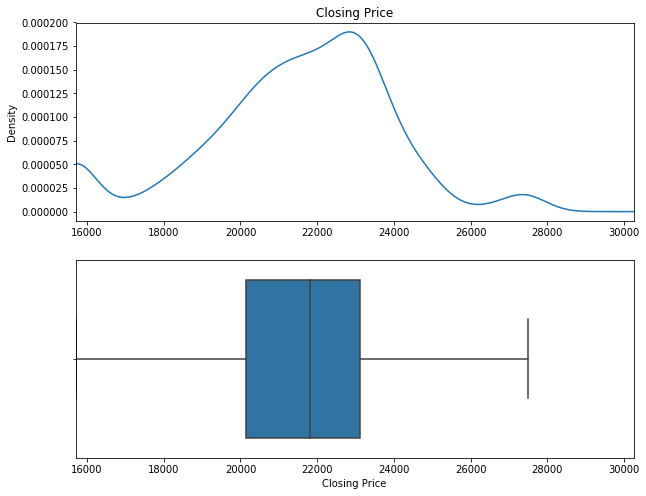

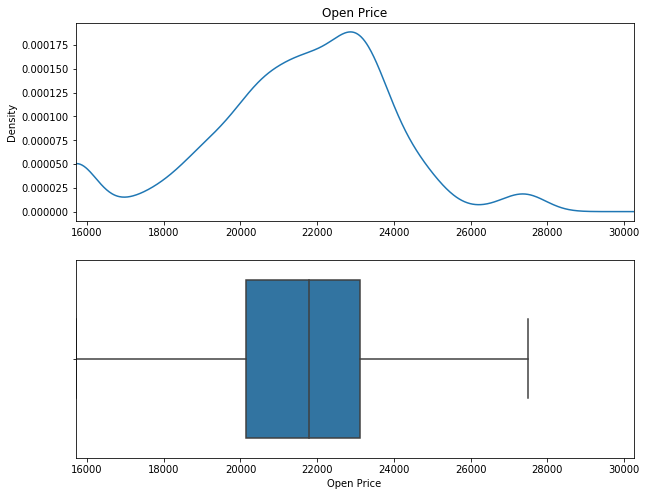

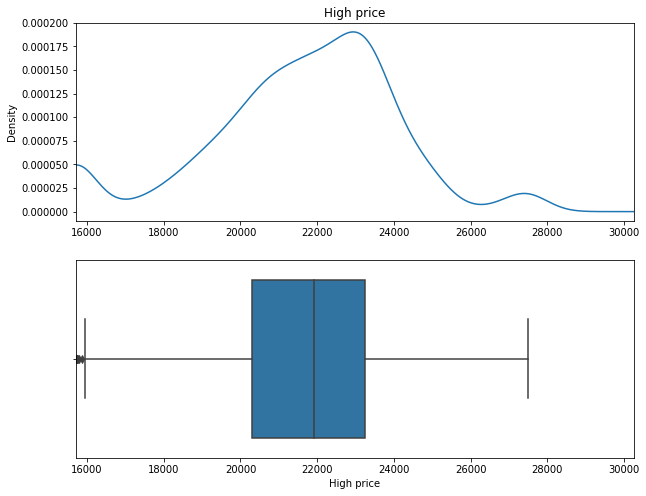

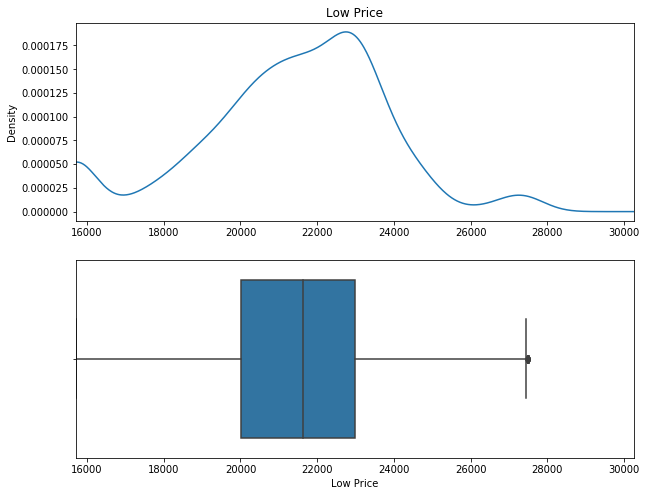

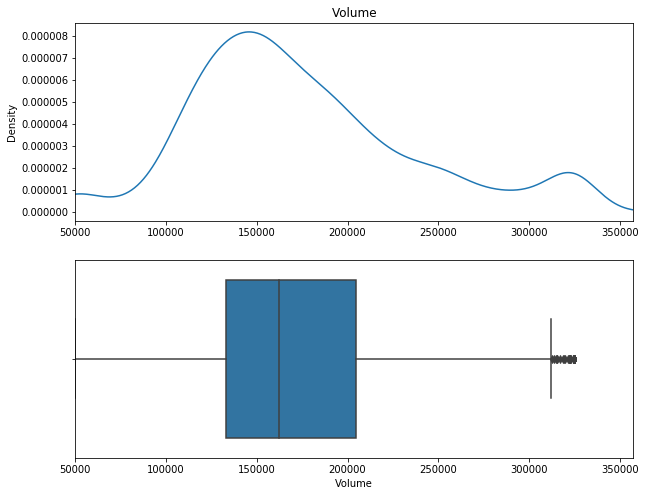

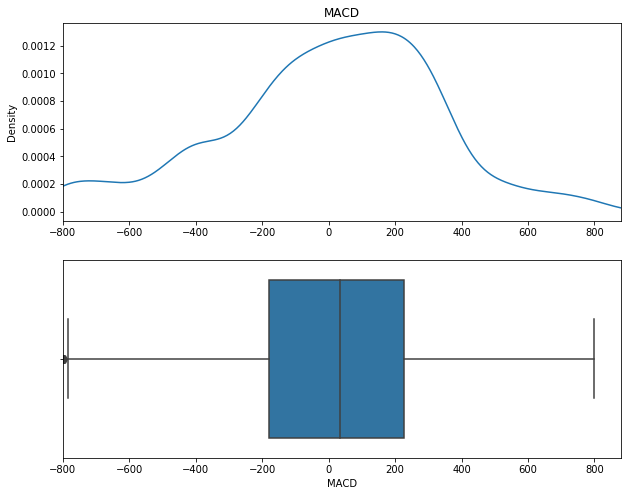

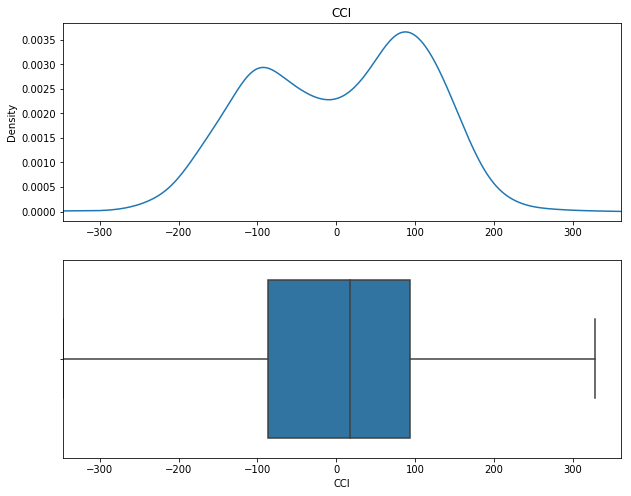

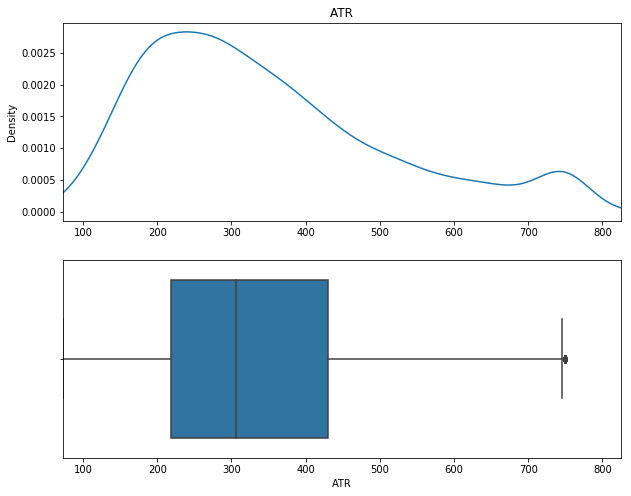

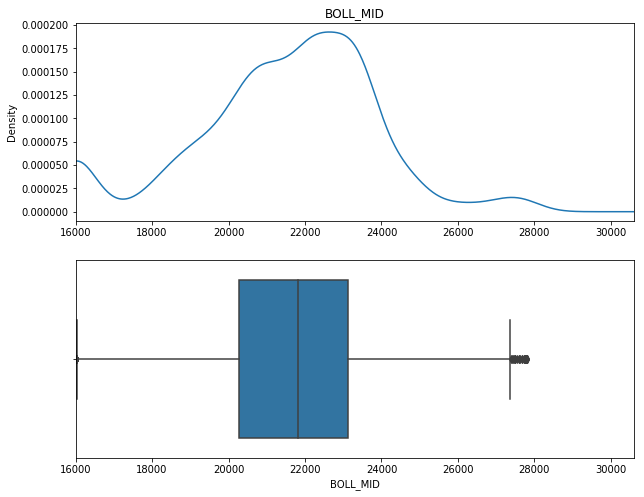

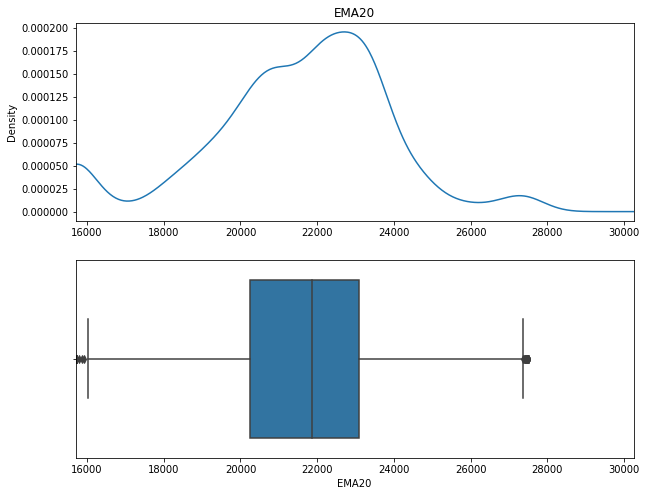

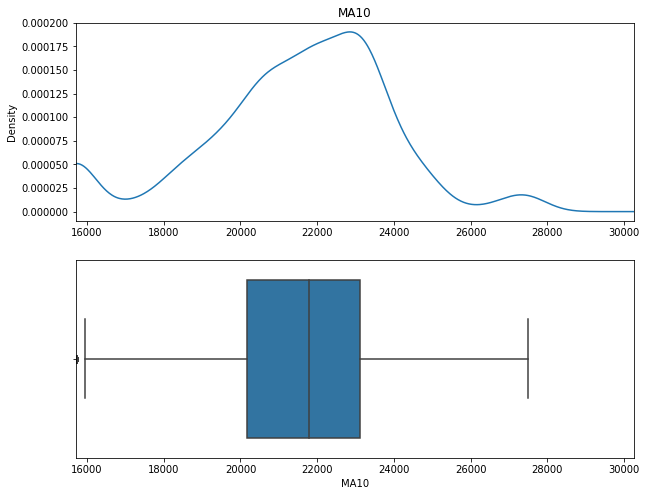

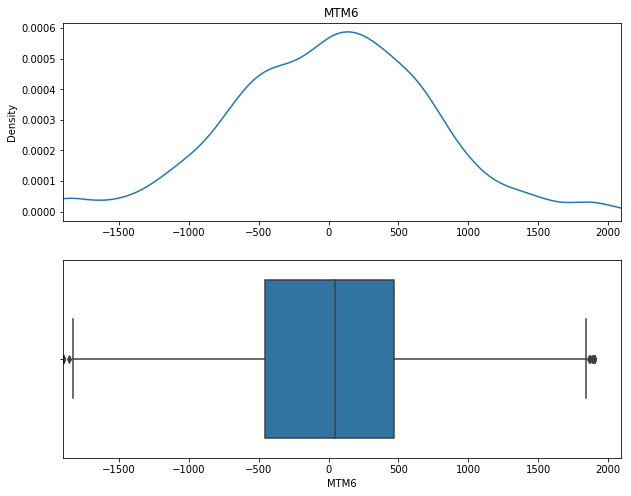

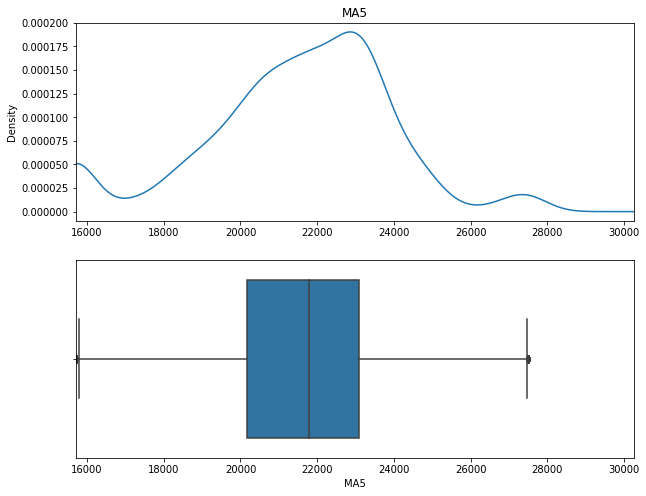

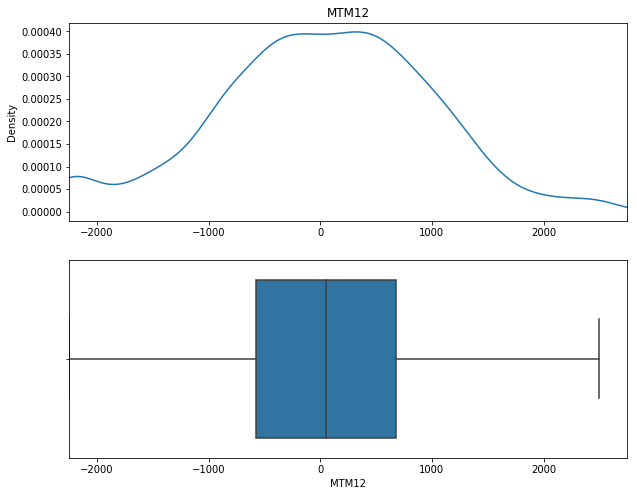

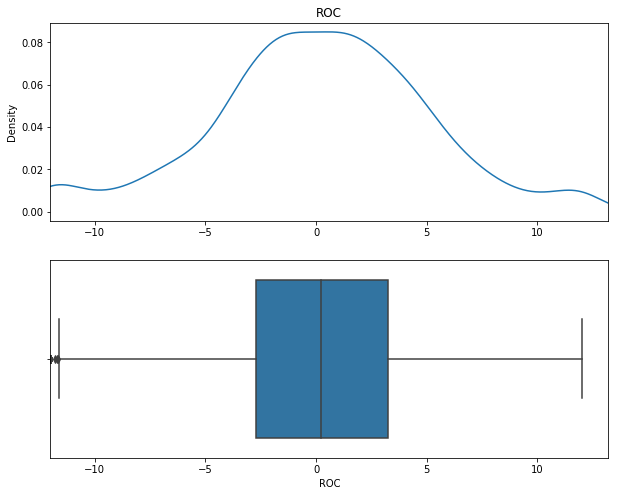

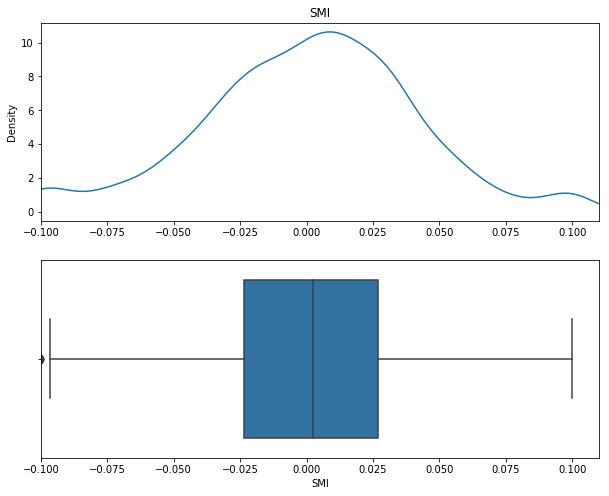

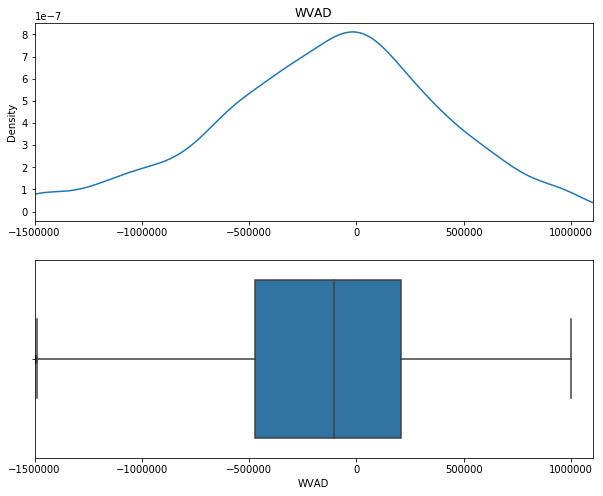

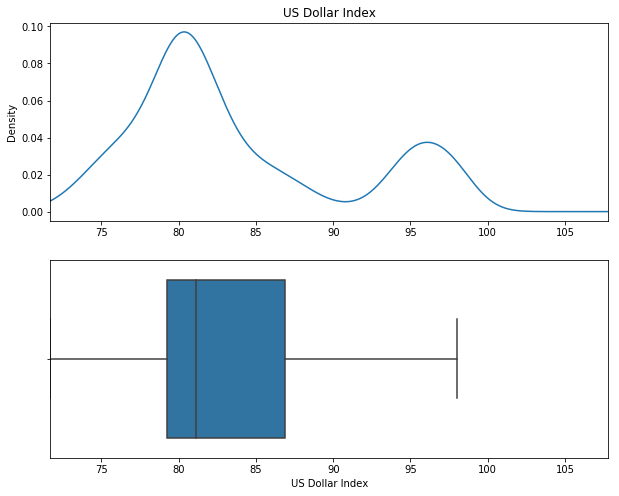

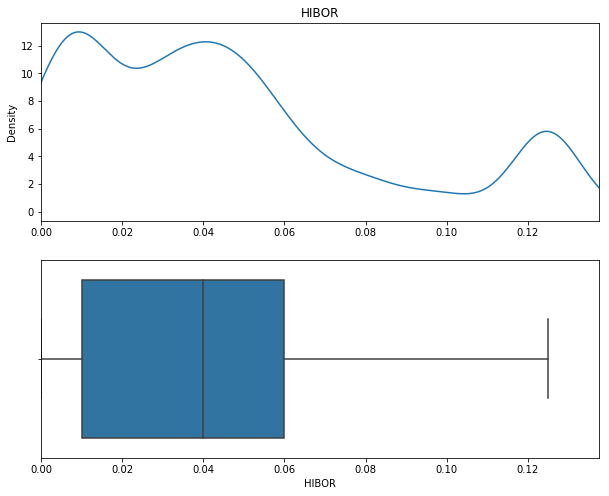

In [0]:
for i in col[2:]:
    #plt.title(i)
    #plt.xlabel(i)
    plt.figure(figsize=(10,8))
    plt.subplot(211)
    plt.xlim(data_master[i].min(), data_master[i].max()*1.1)
    ax = data_master[i].plot(kind='kde')
    plt.title(i)
 
    plt.subplot(212)
    plt.xlim(data_master[i].min(), data_master[i].max()*1.1)
    sns.boxplot(x=data_master[i])

In [0]:
np.percentile(data_master['WVAD'] ,[0,1,2,5,50,75,80,90,99,99.8,100])

array([-1500000.        , -1500000.        , -1357766.80539304,
       -1103216.41237873,  -105564.41178234,   205079.43064863,
         294268.99901582,   518700.95126058,   995770.49466687,
        1183304.82823809,  1250000.        ])

In [0]:
f = data_master.iloc[1*60:600+1*60,:]

In [0]:
f.tail()

,Ntime,Time,Closing Price,Open Price,High price,Low Price,Volume,MACD,CCI,ATR,...,EMA20,MA10,MTM6,MA5,MTM12,ROC,SMI,WVAD,US Dollar Index,HIBOR
655,20110221,734555,23485.42,23500.11,23585.63,23444.77,122604.74,-91.913243,52.435959,150.47,...,23400.065359,23174.618,656.50,23287.850,2.47,-1.237194,0.000048,-273082.812268,77.69,0.01
656,20110222,734556,22990.81,23170.52,23170.52,22938.13,173618.04,-112.699964,-54.619826,547.29,...,23361.088658,23125.269,-130.25,23306.056,-918.15,-2.651520,-0.007478,-353034.848155,77.82,0.01
657,20110223,734557,22906.90,22983.37,23055.47,22837.09,128720.73,-134.395202,-68.109522,218.38,...,23317.832595,23099.556,7.12,23256.042,-646.69,-2.304910,0.008656,-400212.390532,77.38,0.01
658,20110224,734558,22601.04,22856.78,23036.93,22575.99,150622.74,-174.260415,-102.661919,460.94,...,23249.566634,23088.798,-555.93,23115.882,-883.26,-3.755533,-0.009982,-553833.274730,77.10,0.01
659,20110225,734559,23012.37,22727.04,23091.32,22712.96,140348.88,-170.695321,-45.358021,490.28,...,23226.976478,23107.143,-289.47,22999.308,-151.66,-0.654722,-0.004701,-316315.797806,77.25,0.01


In [0]:
f.shape

(600, 21)

In [0]:
f.shape[1]

21

In [0]:
?plt.boxplot

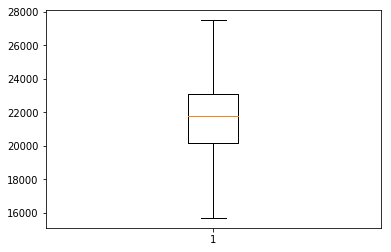

In [0]:
plt.boxplot(data_master['Closing Price'])
plt.show()

In [0]:
data_master.shape[1]

21

In [0]:
!pip install seaborn

In [0]:
col = data_master.columns

In [0]:
col[2:]

Index(['Closing Price', 'Open Price', 'High price', 'Low Price', 'Volume',
       'MACD', 'CCI', 'ATR', 'BOLL_MID', 'EMA20', 'MA10', 'MTM6', 'MA5',
       'MTM12', 'ROC', 'SMI', 'WVAD', 'US Dollar Index', 'HIBOR'],
      dtype='object')

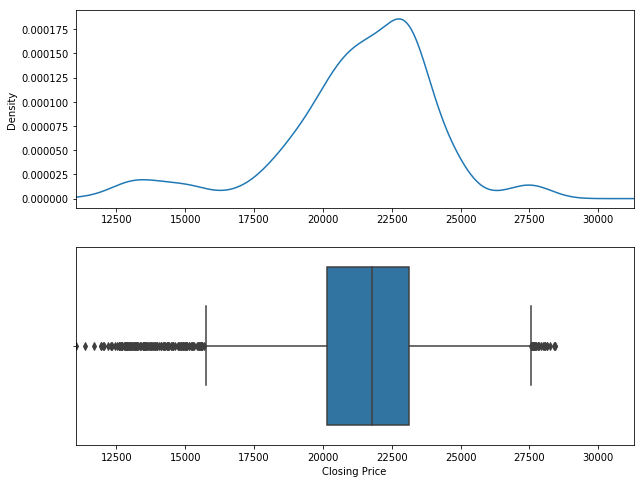

In [0]:
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(data_master['Closing Price'].min(), data_master['Closing Price'].max()*1.1)
ax = data_master['Closing Price'].plot(kind='kde')
 
plt.subplot(212)
plt.xlim(data_master['Closing Price'].min(), data_master['Closing Price'].max()*1.1)
sns.boxplot(x=data_master['Closing Price'])

In [0]:
?data_master.iloc

In [0]:
data_master.iloc[1]

Ntime              2.008070e+07
Time               7.335920e+05
Closing Price      2.124278e+04
Open Price         2.138949e+04
High price         2.174207e+04
Low Price          2.116357e+04
Volume             2.725285e+05
MACD              -7.022826e+02
CCI               -1.869560e+02
ATR                5.785000e+02
BOLL_MID           2.323330e+04
EMA20              2.279348e+04
MA10               2.228966e+04
MTM6              -1.392381e+03
MA5                2.190945e+04
MTM12             -1.786910e+03
ROC               -7.872373e+00
SMI               -6.820145e-02
WVAD              -5.073053e+05
US Dollar Index    7.273000e+01
HIBOR              1.600000e+00
Name: 1, dtype: float64

In [0]:
?plt.subplot

In [0]:
for i in col[2:]:
    np.percentile

In [0]:
data_master['Closing Price'].min()

11015.8398

In [0]:
data_master['Closing Price'].max()

28442.75

In [0]:
np.percentile(data_master['Closing Price'] ,98.8)

27581.71928

In [0]:
data = pd.DataFrame(data_master['Closing Price'])

In [0]:
data.head()

,Closing Price
0,21704.4492
1,21242.7793
2,21423.8203
3,21913.0605
4,21220.8105


In [0]:
?data['Closing Price'].any()

Object `data['Closing Price'].any()` not found.


In [0]:
data_master.loc[data_master['Closing Price'] < 15500, 'Closing Price'] = 15500
data_master.loc[data_master['Closing Price'] > 27500, 'Closing Price'] = 27500

In [0]:
data.head()

,Closing Price
0,21704.4492
1,21242.7793
2,21423.8203
3,21913.0605
4,21220.8105


In [0]:
np.percentile(data['Closing Price'] ,0)

15500.0

In [0]:
data.head()

,Closing Price
0,15500
1,15500
2,15500
3,15500
4,15500


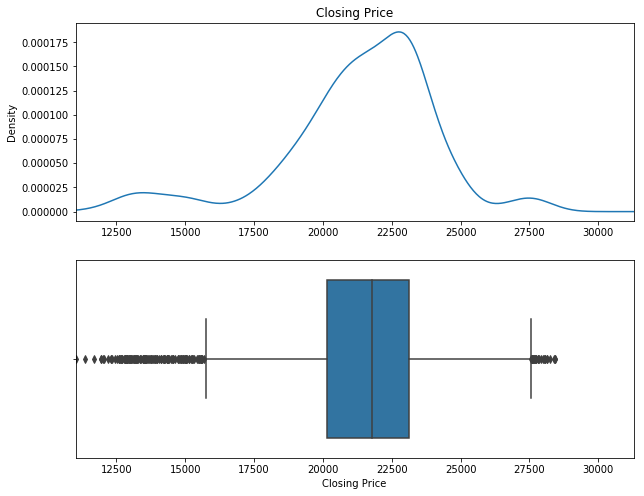

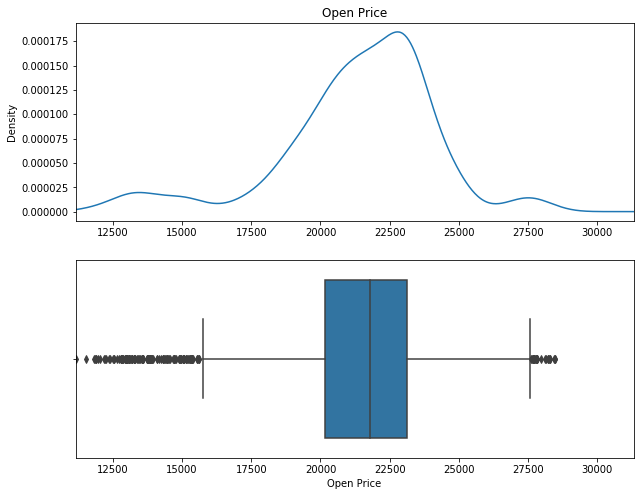

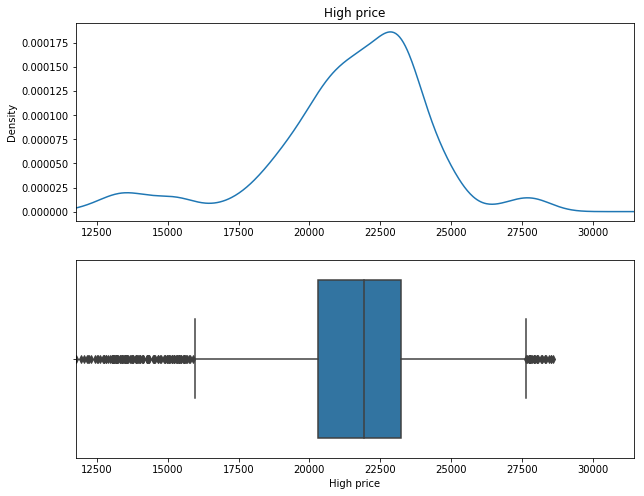

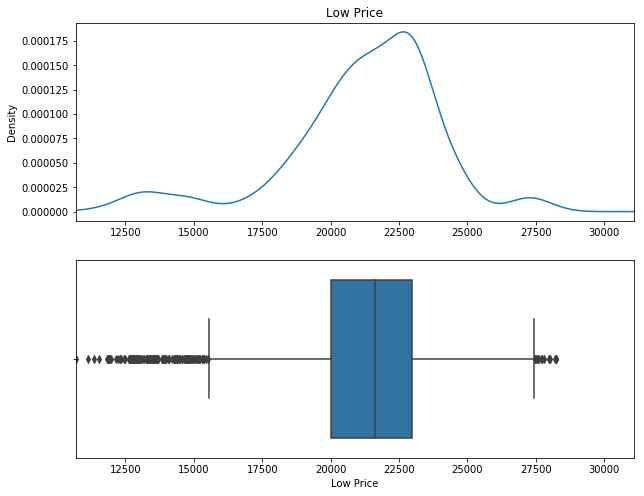

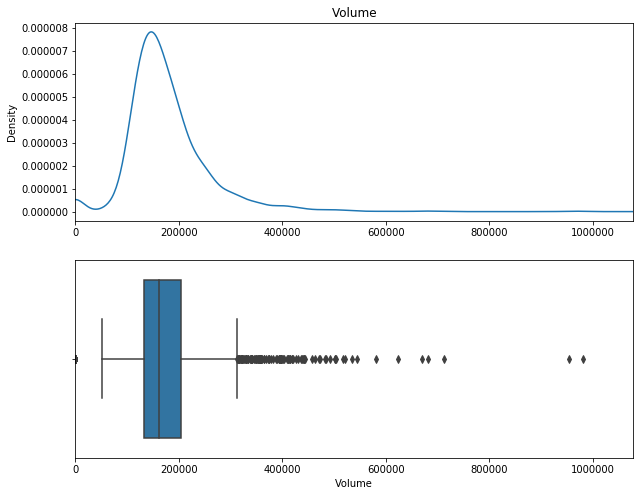

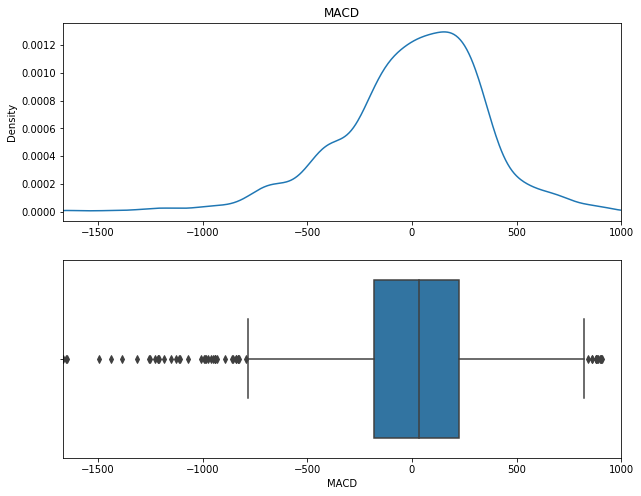

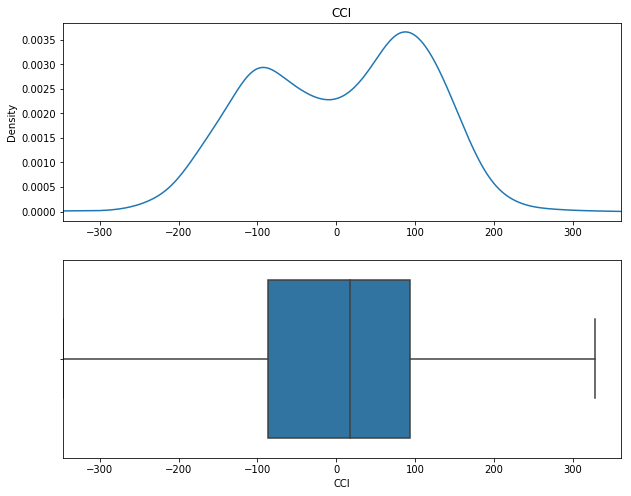

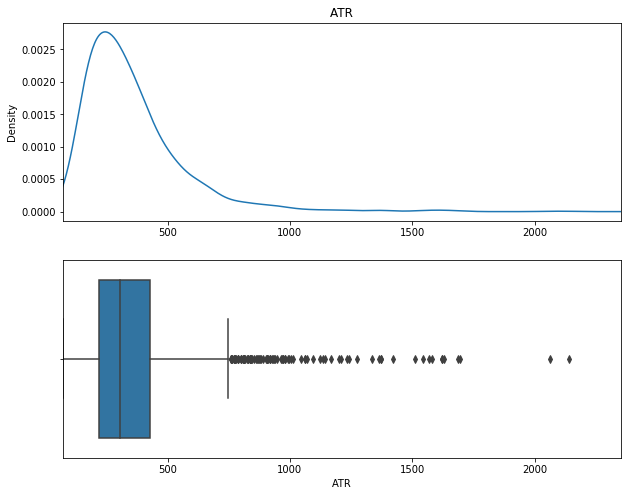

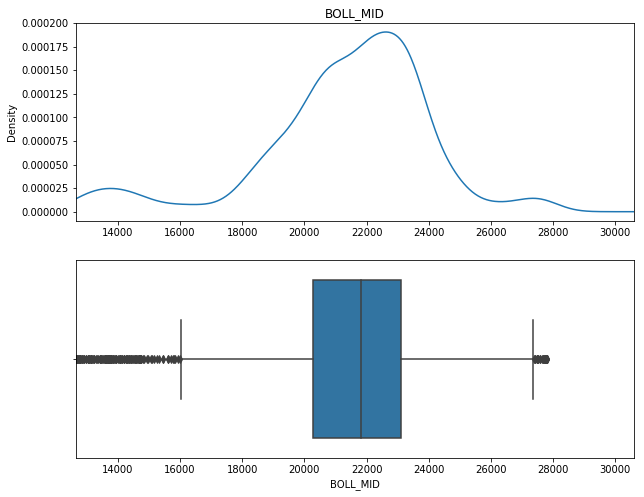

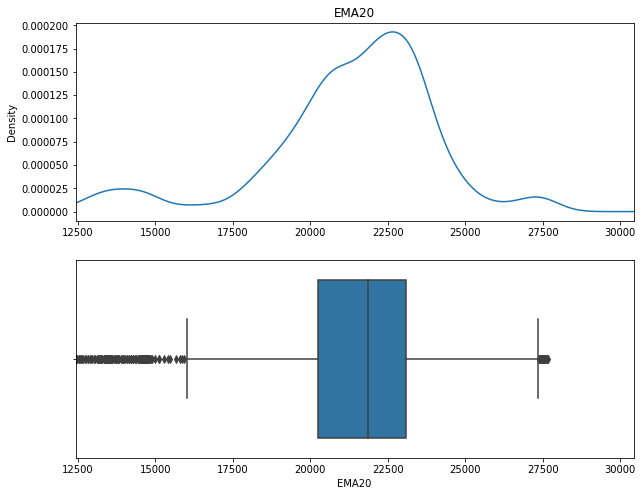

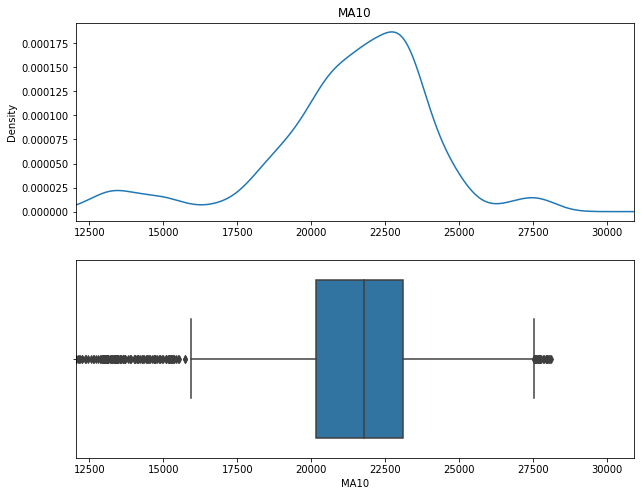

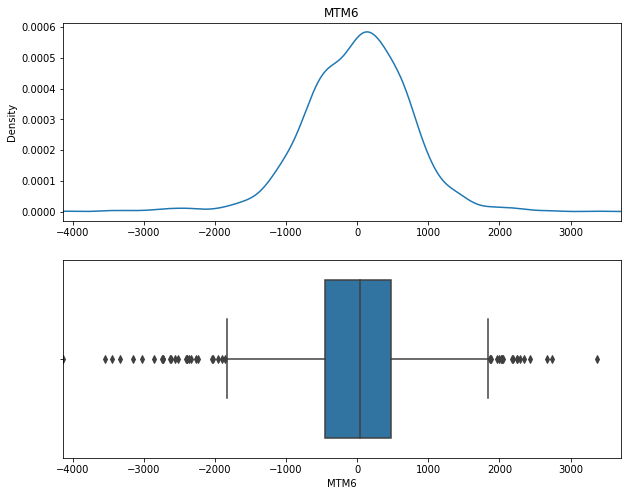

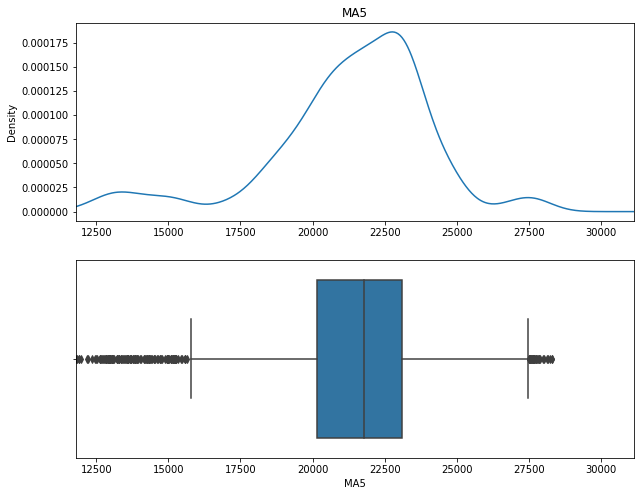

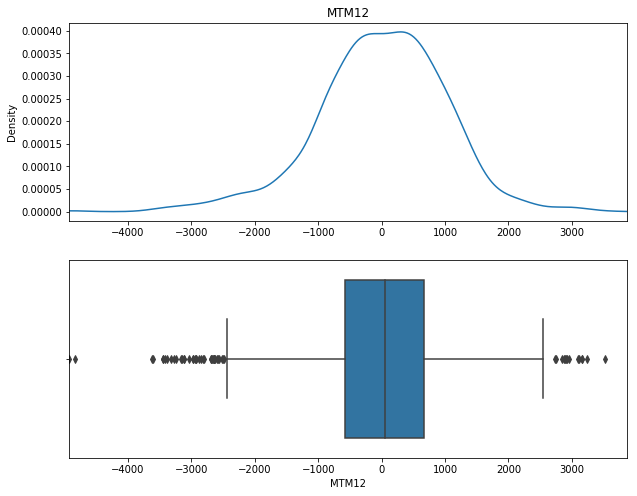

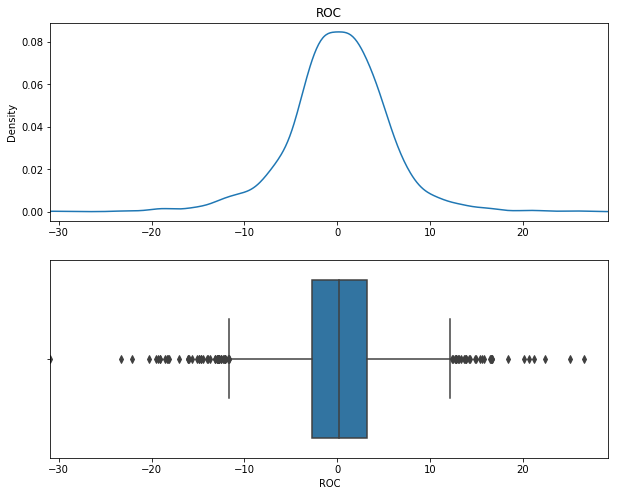

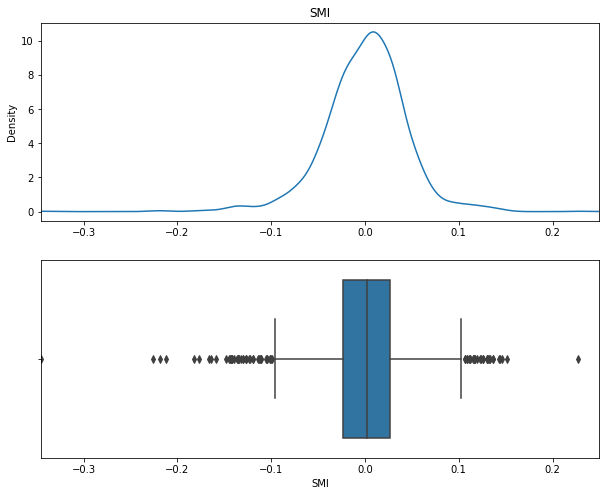

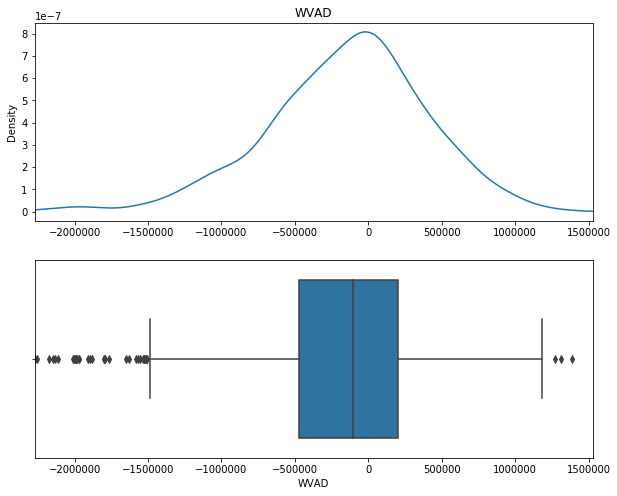

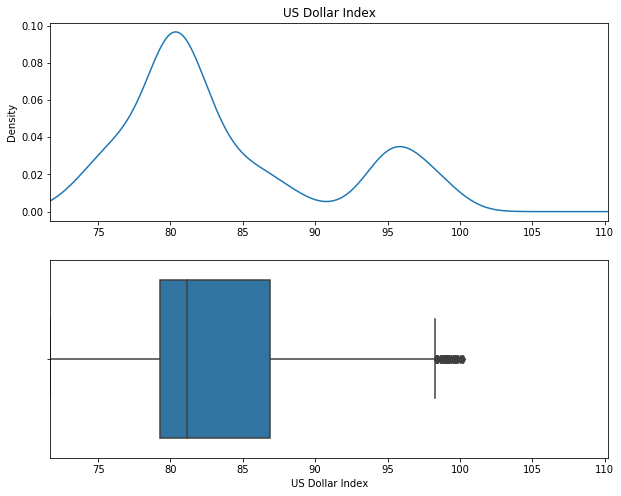

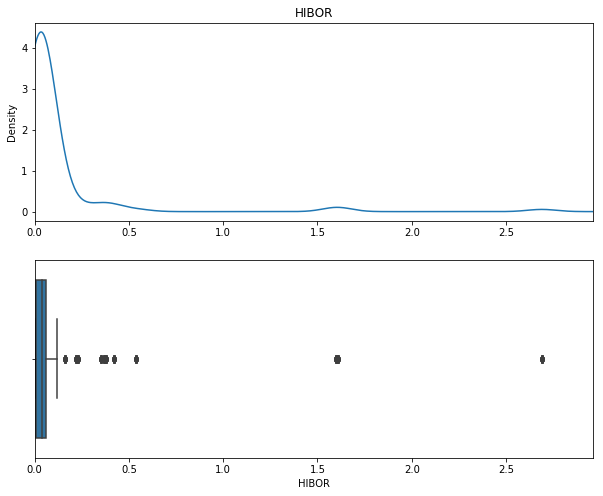

In [0]:
for i in col[2:]:
    #plt.title(i)
    #plt.xlabel(i)
    plt.figure(figsize=(10,8))
    plt.subplot(211)
    plt.xlim(data_master[i].min(), data_master[i].max()*1.1)
    ax = data_master[i].plot(kind='kde')
    plt.title(i)
 
    plt.subplot(212)
    plt.xlim(data_master[i].min(), data_master[i].max()*1.1)
    sns.boxplot(x=data_master[i])

In [0]:
cp = np.array(data_master['Closing Price']/1000)
cp = cp.reshape(-1, 1)
scaler = QuantileTransformer(output_distribution='uniform')
scaler.fit(cp)
norm_train = scaler.transform(cp)


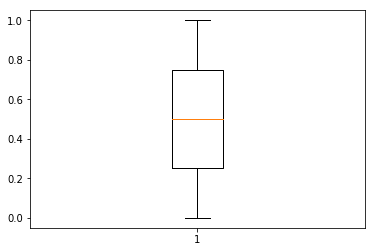

In [0]:
plt.boxplot(norm_train)
plt.show()

In [0]:
fq = f.iloc[:,2:]

In [0]:
fq.head()

,Closing Price,Open Price,High price,Low Price,Volume,MACD,CCI,ATR,BOLL_MID,EMA20,MA10,MTM6,MA5,MTM12,ROC,SMI,WVAD,US Dollar Index,HIBOR
60,17880.6797,18742.2500,18742.2500,17796.3398,257848.36,-707.595154,-86.575444,945.9102,19807.615758,19346.055722,18586.22285,248.2188,18666.40780,-2119.0996,-12.739328,-0.022946,-1.013074e+06,77.71,2.69
61,18016.2109,17628.9297,18029.7695,17445.4297,322685.72,-727.430170,-99.321407,584.3398,19716.236927,19219.403834,18557.78300,383.7500,18495.08006,-1372.5098,-12.077914,0.021038,-8.732393e+05,79.24,2.69
62,18211.1094,17870.4297,18285.6797,17631.6992,247619.04,-719.133163,-64.665903,653.9805,19604.941554,19123.375793,18615.17499,578.6485,18344.90390,-1141.7910,-11.126777,0.031774,-9.388191e+05,80.56,0.42
63,17682.4004,17788.9902,17926.1406,17682.4004,207488.28,-746.613626,-81.890961,528.7090,19475.162331,18986.140041,18620.16894,49.9395,18094.49804,-618.2090,-13.706964,-0.085128,-8.473427e+05,80.61,0.42
64,16803.7598,17156.2109,17241.7793,16790.8594,223439.22,-829.726474,-146.878276,891.5410,19295.894604,18778.294304,18367.77187,-2523.9707,17718.83204,-833.4297,-15.980274,-0.144071,-9.992383e+05,81.61,0.42


In [0]:
dsa = fq["Closing Price"].copy()

In [0]:
data = data_master.iloc[1*60:600+1*60,:]
feats = data.iloc[:,2:]
feats.head()

,Closing Price,Open Price,High price,Low Price,Volume,MACD,CCI,ATR,BOLL_MID,EMA20,MA10,MTM6,MA5,MTM12,ROC,SMI,WVAD,US Dollar Index,HIBOR
60,17880.6797,18742.2500,18742.2500,17796.3398,257848.36,-707.595154,-86.575444,945.9102,19807.615758,19346.055722,18586.22285,248.2188,18666.40780,-2119.0996,-12.739328,-0.022946,-1.013074e+06,77.71,2.69
61,18016.2109,17628.9297,18029.7695,17445.4297,322685.72,-727.430170,-99.321407,584.3398,19716.236927,19219.403834,18557.78300,383.7500,18495.08006,-1372.5098,-12.077914,0.021038,-8.732393e+05,79.24,2.69
62,18211.1094,17870.4297,18285.6797,17631.6992,247619.04,-719.133163,-64.665903,653.9805,19604.941554,19123.375793,18615.17499,578.6485,18344.90390,-1141.7910,-11.126777,0.031774,-9.388191e+05,80.56,0.42
63,17682.4004,17788.9902,17926.1406,17682.4004,207488.28,-746.613626,-81.890961,528.7090,19475.162331,18986.140041,18620.16894,49.9395,18094.49804,-618.2090,-13.706964,-0.085128,-8.473427e+05,80.61,0.42
64,16803.7598,17156.2109,17241.7793,16790.8594,223439.22,-829.726474,-146.878276,891.5410,19295.894604,18778.294304,18367.77187,-2523.9707,17718.83204,-833.4297,-15.980274,-0.144071,-9.992383e+05,81.61,0.42


In [0]:
step_size = 60

In [0]:
?nn.LSTM

In [0]:
data_close = feats["Closing Price"].copy()
data_close_new = data_close
test = feats[-60:]
validate = feats[-2*60:-60]
train = feats[:-2*60]
y_test = data_close_new[-step_size:].as_matrix()
y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
y_train = data_close_new[:-2*step_size].as_matrix()
feats_train = train.as_matrix().astype(np.float)
feats_validate = validate.as_matrix().astype(np.float)
feats_test = test.as_matrix().astype(np.float)
#scaler = MinMaxScaler(feature_range=(-1,1))
scaler =  QuantileTransformer(output_distribution='normal')
scaler.fit(feats_train)
feats_norm_train = scaler.transform(feats_train)
feats_norm_validate = scaler.transform(feats_validate)
feats_norm_test = scaler.transform(feats_test)
data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))

NameError: name 'feats' is not defined

In [0]:
feats_norm_train

array([[ 0.15103268,  0.28107523,  0.23235663, ..., -0.31192115,
        -0.53722334,  1.        ],
       [ 0.1737573 ,  0.09310643,  0.10683661, ..., -0.23552372,
        -0.33199195,  1.        ],
       [ 0.20643607,  0.13388038,  0.15192114, ..., -0.27135272,
        -0.15492958, -0.68773234],
       ...,
       [ 0.6109787 ,  0.58975336,  0.56835415, ...,  0.28133789,
         0.10261569, -0.97026022],
       [ 0.65207308,  0.6393711 ,  0.61924002, ...,  0.2766329 ,
         0.09188464, -0.97026022],
       [ 0.66927276,  0.6485575 ,  0.63516099, ...,  0.22061124,
         0.03957076, -0.97026022]])

In [0]:
feats_norm_train.shape

(480, 19)

In [0]:
batchsize = 60

In [0]:
trainloader = ExampleDataset(feats_norm_train, y_train, batchsize)

In [0]:
trainloader.length

480

In [0]:
len(trainloader.datalist)

480

In [0]:
len(trainloader)

9

In [0]:
#trainloader['x'].shape

In [0]:
trainloader[1]

{'x': array([[-0.46876888, -0.54391944, -0.55012573, ...,  0.58836778,
         -0.09859155, -0.83643123],
        [-0.44456713, -0.50593621, -0.54460811, ...,  0.51108431,
         -0.02481556, -0.83643123],
        [-0.46015724, -0.43909736, -0.51263953, ...,  0.40736773,
         -0.10395708, -0.83643123],
        ...,
        [-0.5922952 , -0.68816295, -0.69981676, ...,  0.27512667,
          0.23541247, -0.72490706],
        [-0.51467709, -0.55788552, -0.61138465, ...,  0.237283  ,
          0.31991952, -0.72490706],
        [-0.56300472, -0.56099217, -0.62197277, ...,  0.11764076,
          0.27565392, -0.72490706]]),
 'y': array([14184.1396, 14328.4805, 14235.5   , 14387.4805, 15042.8096,
        15563.3096, 15509.5098, 14987.46  , 14415.9102, 14377.4404,
        13971.    , 13668.0498, 13704.6104, 13242.96  , 13255.5098,
        13339.9902, 12959.7695, 12583.6299, 12657.9902, 12578.5996,
        13154.4297, 13278.21  , 12861.4902, 12776.8896, 13063.8896,
        13178.9004, 136

In [0]:
xs = trainloader[1]

In [0]:
xs['x']

array([[-0.46876888, -0.54391944, -0.55012573, ...,  0.58836778,
        -0.09859155, -0.83643123],
       [-0.44456713, -0.50593621, -0.54460811, ...,  0.51108431,
        -0.02481556, -0.83643123],
       [-0.46015724, -0.43909736, -0.51263953, ...,  0.40736773,
        -0.10395708, -0.83643123],
       ...,
       [-0.5922952 , -0.68816295, -0.69981676, ...,  0.27512667,
         0.23541247, -0.72490706],
       [-0.51467709, -0.55788552, -0.61138465, ...,  0.237283  ,
         0.31991952, -0.72490706],
       [-0.56300472, -0.56099217, -0.62197277, ...,  0.11764076,
         0.27565392, -0.72490706]])

In [0]:
len(xs)

2

In [0]:
inp = xs['x']

In [0]:
input = torch.FloatTensor(inp)
input = torch.transpose(input, 0, 1)

In [0]:
inp.shape

(60, 19)

In [0]:
input.shape

torch.Size([19, 60])

In [0]:
target = torch.FloatTensor([x for x in xs["y"]])

In [0]:
xs['y']

array([14184.1396, 14328.4805, 14235.5   , 14387.4805, 15042.8096,
       15563.3096, 15509.5098, 14987.46  , 14415.9102, 14377.4404,
       13971.    , 13668.0498, 13704.6104, 13242.96  , 13255.5098,
       13339.9902, 12959.7695, 12583.6299, 12657.9902, 12578.5996,
       13154.4297, 13278.21  , 12861.4902, 12776.8896, 13063.8896,
       13178.9004, 13655.04  , 13769.0596, 13880.6396, 13539.21  ,
       13228.2998, 13554.6699, 13455.8799, 12945.4004, 13016.    ,
       13023.3604, 12699.1699, 13175.0996, 12798.5195, 13005.0801,
       12894.9404, 12811.5703, 12317.46  , 12033.8799, 12331.1504,
       12211.2402, 11921.52  , 11344.5801, 11694.0498, 11930.6602,
       12001.5303, 12525.7998, 12976.71  , 12878.0898, 13117.1699,
       13130.9199, 12833.5098, 13447.4199, 13910.3398, 13622.1104])

In [0]:
type(xs['y'])

numpy.ndarray

In [0]:
type(target)

torch.Tensor

In [0]:
target

tensor([14184.1396, 14328.4805, 14235.5000, 14387.4805, 15042.8096, 15563.3096,
        15509.5098, 14987.4600, 14415.9102, 14377.4404, 13971.0000, 13668.0498,
        13704.6104, 13242.9600, 13255.5098, 13339.9902, 12959.7695, 12583.6299,
        12657.9902, 12578.5996, 13154.4297, 13278.2100, 12861.4902, 12776.8896,
        13063.8896, 13178.9004, 13655.0400, 13769.0596, 13880.6396, 13539.2100,
        13228.2998, 13554.6699, 13455.8799, 12945.4004, 13016.0000, 13023.3604,
        12699.1699, 13175.0996, 12798.5195, 13005.0801, 12894.9404, 12811.5703,
        12317.4600, 12033.8799, 12331.1504, 12211.2402, 11921.5195, 11344.5801,
        11694.0498, 11930.6602, 12001.5303, 12525.7998, 12976.7100, 12878.0898,
        13117.1699, 13130.9199, 12833.5098, 13447.4199, 13910.3398, 13622.1104])

In [0]:
pred_train = []
target_train = []
for j in range(len(trainloader)):
    sample = trainloader[j]
    sample_x = sample["x"]

    if len(sample_x) != 0:
        sample_x = np.stack(sample_x)
        input = torch.FloatTensor(sample_x)
        input = torch.transpose(input, 0, 1)
        target = torch.FloatTensor([x for x in sample["y"]])


In [0]:
?nn.LSTM

In [0]:
trainloader = ExampleDataset(x_train, y_train, batchsize)

        pred_train = []
        target_train = []
        for j in range(len(trainloader)):
            sample = trainloader[j]
            sample_x = sample["x"]

            if len(sample_x) != 0:

                sample_x = np.stack(sample_x)
                input = torch.FloatTensor(sample_x)
                input = torch.transpose(input, 0, 1)
                target = torch.FloatTensor([x for x in sample["y"]])


In [0]:
seq = Lstm(10, hidden_size=100, nb_layers=3)

In [0]:
?seq.train

In [0]:
n = 0

In [0]:
num_hidden_1 = 10
num_hidden_2 = 10
num_hidden_3 = 10
num_hidden_4 = 10
n_epoch = 3

# ---- train using training data
    
# The n==0 statement is done because we only want to initialize the network once and then keep training
# as we move through time 

import pdb
pdb.set_trace()
if n == 0:
    auto1 = Autoencoder(feats_norm_train.shape[1], num_hidden_1)
auto1.fit(feats_norm_train, n_epoch=n_epoch)

inputs = torch.from_numpy(feats_norm_train.astype(np.float32))

--Return--
> <ipython-input-17-c4f9629da575>(13)<module>()->None
-> pdb.set_trace()
(Pdb) where
  c:\users\intern.alpha\appdata\local\continuum\anaconda3\envs\deep_learning\lib\runpy.py(193)_run_module_as_main()
-> "__main__", mod_spec)
  c:\users\intern.alpha\appdata\local\continuum\anaconda3\envs\deep_learning\lib\runpy.py(85)_run_code()
-> exec(code, run_globals)
  c:\users\intern.alpha\appdata\local\continuum\anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py(16)<module>()
-> app.launch_new_instance()
  c:\users\intern.alpha\appdata\local\continuum\anaconda3\envs\deep_learning\lib\site-packages\traitlets\config\application.py(658)launch_instance()
-> app.start()
  c:\users\intern.alpha\appdata\local\continuum\anaconda3\envs\deep_learning\lib\site-packages\ipykernel\kernelapp.py(505)start()
-> self.io_loop.start()
  c:\users\intern.alpha\appdata\local\continuum\anaconda3\envs\deep_learning\lib\site-packages\tornado\platform\asyncio.py(148)start()
-> self.asyncio_lo

In [0]:
num_hidden_1 = 10
num_hidden_2 = 10
num_hidden_3 = 10
num_hidden_4 = 10
n_epoch = 3

# ---- train using training data
    
# The n==0 statement is done because we only want to initialize the network once and then keep training
# as we move through time 

import pdb
#pdb.set_trace()
if n == 0:
    auto1 = Autoencoder(feats_norm_train.shape[1], num_hidden_1)
auto1.fit(feats_norm_train, n_epoch=n_epoch)

inputs = torch.from_numpy(feats_norm_train.astype(np.float32))

In [0]:
?auto1.train

In [0]:
auto1.encoder(inputs)

tensor([[0.5526, 0.5608, 0.5493,  ..., 0.4921, 0.5144, 0.4340],
        [0.5627, 0.5573, 0.5258,  ..., 0.4879, 0.5306, 0.4735],
        [0.6263, 0.5387, 0.5023,  ..., 0.4451, 0.4847, 0.5633],
        ...,
        [0.6726, 0.5354, 0.5042,  ..., 0.4363, 0.4755, 0.5907],
        [0.6692, 0.5298, 0.5154,  ..., 0.4463, 0.4670, 0.5916],
        [0.6658, 0.5345, 0.5086,  ..., 0.4485, 0.4690, 0.6013]],
       grad_fn=<SigmoidBackward>)

In [0]:
inputs

tensor([[ 0.1510,  0.2811,  0.2324,  ..., -0.3119, -0.5372,  1.0000],
        [ 0.1738,  0.0931,  0.1068,  ..., -0.2355, -0.3320,  1.0000],
        [ 0.2064,  0.1339,  0.1519,  ..., -0.2714, -0.1549, -0.6877],
        ...,
        [ 0.6110,  0.5898,  0.5684,  ...,  0.2813,  0.1026, -0.9703],
        [ 0.6521,  0.6394,  0.6192,  ...,  0.2766,  0.0919, -0.9703],
        [ 0.6693,  0.6486,  0.6352,  ...,  0.2206,  0.0396, -0.9703]])

In [0]:
auto1.encoder(inputs).shape

torch.Size([480, 10])

In [0]:
inputs.shape

torch.Size([480, 19])

In [0]:
?auto1.eval

In [0]:
auto1.eval

<bound method Module.eval of Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=19, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=19, bias=True)
  )
  (l1_loss): L1Loss()
)>

In [0]:
auto1.train

<bound method Module.train of Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=19, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=19, bias=True)
  )
  (l1_loss): L1Loss()
)>

In [0]:
bg = auto1.eval()

In [0]:
bg

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=19, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=19, bias=True)
  )
  (l1_loss): L1Loss()
)

In [0]:
if n == 0:
    auto2 = Autoencoder(num_hidden_1, num_hidden_2)
auto1_out = auto1.encoder(inputs).data.numpy()
auto2.fit(auto1_out, n_epoch=n_epoch)

if n == 0:
    auto3 = Autoencoder(num_hidden_2, num_hidden_3)
auto1_out = torch.from_numpy(auto1_out.astype(np.float32))
auto2_out = auto2.encoder(auto1_out).data.numpy()
auto3.fit(auto2_out, n_epoch=n_epoch)

if n == 0:
    auto4 = Autoencoder(num_hidden_3, num_hidden_4)
auto2_out = torch.from_numpy(auto2_out.astype(np.float32))
auto3_out = auto3.encoder(auto2_out).data.numpy()
auto4.fit(auto3_out, n_epoch=n_epoch)
    

# Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
auto1.eval()        
auto2.eval()
auto3.eval()
auto4.eval()
    
X_train = feats_norm_train
X_train = torch.from_numpy(X_train.astype(np.float32))
train_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_train))))
train_encoded = train_encoded.data.numpy()

# ---- encode validation and test data using autoencoder trained only on training data 
X_validate = feats_norm_validate   
X_validate = torch.from_numpy(X_validate.astype(np.float32))
validate_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_validate))))
validate_encoded = validate_encoded.data.numpy()

X_test = feats_norm_test
X_test = torch.from_numpy(X_test.astype(np.float32))
test_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_test))))
test_encoded = test_encoded.data.numpy()
    
# switch back to training mode
auto1.train()        
auto2.train()
auto3.train()
auto4.train()


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
  )
  (l1_loss): L1Loss()
)

In [0]:
a

array([[1, 2],
       [3, 4]])

In [0]:
b

array([[5, 6]])

In [0]:
c

array([[1, 2, 5, 6],
       [3, 4, 4, 5]])

In [0]:
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6],[4,5]])
c = np.concatenate((a,b),axis=1)

In [0]:
train_encoded.shape

(480, 10)

In [0]:
validate_encoded.shape

(60, 10)

In [0]:
test_encoded.shape

(60, 10)

In [0]:
x_concat.shape

(600, 10)

In [0]:
arg1s = (train_encoded, validate_encoded, test_encoded)

x_concat = np.concatenate(arg1s)

In [0]:
?np.concatenate

In [0]:
?zip

In [0]:
cd = list(zip(feats_norm_train, y_train))

In [0]:
len(cd)

480

In [0]:
cd[1]

(array([ 0.1737573 ,  0.09310643,  0.10683661,  0.11686038, -0.34139857,
        -0.23077735, -0.13217434, -0.5039451 ,  0.46359973,  0.36868463,
         0.22843705,  0.20470922,  0.22113753, -0.11649008, -0.34446033,
         0.28146772, -0.23552372, -0.33199195,  1.        ]), 18016.2109)

In [0]:
train_encoded.shape

(480, 10)

In [0]:
train_encoded[-60:].shape

(60, 10)

In [0]:
validate_encoded_extra = np.concatenate((train_encoded[-4:], validate_encoded))

In [0]:
test_encoded_extra = np.concatenate((validate_encoded[-4:], test_encoded))

In [0]:
test_encoded_extra.shape

(64, 10)

In [0]:
validate_encoded_ex.shape

(64, 10)

In [0]:
y_val_input = data_close[-len(test_encoded)-len(validate_encoded)-1:-len(test_encoded)]

In [0]:
y_val_input.shape

(61,)

In [0]:
y_test_input = data_close[-len(test_encoded)-1:]

In [0]:
y_test_input.shape

(61,)

In [0]:
train_encoded.shape

(480, 10)

In [0]:
y_train_input = data_close[:-len(validate_encoded)-len(test_encoded)]

In [0]:
y_train_input.shape

(480,)

In [0]:
asd = True
if asd:
    y = y_train_input[60-1:]
    

In [0]:
y.shape

(421,)

In [0]:
?y.shift

In [0]:
len(validate_encoded_ex)-4

60

In [0]:
x_train = validate_encoded_ex[:i+4]

In [0]:
for i in range(len(validate_encoded_ex)-4):
    x_train = validate_encoded_ex[:i+4]

In [0]:
x_train.shape

(63, 10)

In [0]:
y_close = y_val_input.pct_change()[1:]

In [0]:
y_close.shape

(60,)

In [0]:
time_steps = 4

In [0]:
import os
import torch

In [0]:
resume = "./runs/checkpoint/model_best.pth.tar"
#resume = "./runs/HF/checkpoint_lstm.pth.tar"
seq = Lstm(10, hidden_size=100, nb_layers=3)
if os.path.isfile(resume):
    print("=> loading checkpoint '{}'".format(resume))
    checkpoint = torch.load(resume)
    start_epoch = checkpoint['epoch']
    seq.load_state_dict(checkpoint['state_dict'])
    print("=> loaded checkpoint '{}' (epoch {})"
            .format(resume, checkpoint['epoch']))
else:
    
    pass

=> loading checkpoint './runs/checkpoint/model_best.pth.tar'
=> loaded checkpoint './runs/checkpoint/model_best.pth.tar' (epoch 301)


In [0]:
torch.save(seq, "./runs/model")

In [0]:
the_model = torch.load("./runs/model")

In [0]:
the_model

Lstm(
  (lstm): LSTM(10, 100, num_layers=3, dropout=0.3)
  (lin): Linear(in_features=100, out_features=1, bias=True)
)

In [0]:
torch.save(the_model.state_dict(), "./runs/model_param")

In [0]:
for i in range(len(train_encoded)-4):
        ct +=1
        if train:
            x_train = x_encoded[i:i+time_steps]
        else:
            x_train = x_encoded[:i+time_steps]

In [0]:
def prepare_data_lst(x_encoded, y_close, time_steps, log_return=True, train=True):
    ct = 0
    data = []
    for i in range(len(x_encoded)-time_steps):
        ct +=1
        if train:
            x_train = x_encoded[i:i+time_steps]
            print(i,i+time_steps)
        else:
            x_train = x_encoded[:i+time_steps]
            print(i,i+time_steps)

        data.append(x_train)
        print(len(data))

    if log_return==False:
        y_close = y_close.pct_change()[1:]
        print(len(y_close))
    else:
        y_close = (np.log(y_close) - np.log(y_close.shift(1)))[1:] # the log return, i.e. ln(y_t/y_(t-1))

    if train:           
        y = y_close[time_steps-1:]
    else:
        y=y_close

    return data, y

In [0]:
len(y_val_input)

61

In [0]:
len(validate_encoded_extra)

64

In [0]:
len(x_v)

60

In [0]:
x_v[0].shape

(4, 10)

In [0]:
#x, y = prepare_data_lst(train_encoded, y_train_input, time_steps, log_return=True, train=True)
x_v, y_v = prepare_data_lst(validate_encoded_extra, y_val_input, time_steps, log_return=False, train=False)

0 4
1
1 5
2
2 6
3
3 7
4
4 8
5
5 9
6
6 10
7
7 11
8
8 12
9
9 13
10
10 14
11
11 15
12
12 16
13
13 17
14
14 18
15
15 19
16
16 20
17
17 21
18
18 22
19
19 23
20
20 24
21
21 25
22
22 26
23
23 27
24
24 28
25
25 29
26
26 30
27
27 31
28
28 32
29
29 33
30
30 34
31
31 35
32
32 36
33
33 37
34
34 38
35
35 39
36
36 40
37
37 41
38
38 42
39
39 43
40
40 44
41
41 45
42
42 46
43
43 47
44
44 48
45
45 49
46
46 50
47
47 51
48
48 52
49
49 53
50
50 54
51
51 55
52
52 56
53
53 57
54
54 58
55
55 59
56
56 60
57
57 61
58
58 62
59
59 63
60
60


In [0]:
y_train_input = data_close[:-len(validate_encoded)-len(test_encoded)]
y_val_input = data_close[-len(test_encoded)-len(validate_encoded)-1:-len(test_encoded)]
y_test_input = data_close[-len(test_encoded)-1:]

x, y = prepare_data_lst(train_encoded, y_train_input, time_steps, log_return=True, train=True)
x_v, y_v = prepare_data_lst(validate_encoded_extra, y_val_input, time_steps, log_return=False, train=False)
x_te, y_te = prepare_data_lst(test_encoded_extra, y_test_input, time_steps, log_return=False, train=False)


In [0]:
len(x_te)

60

In [0]:
y_te.shape

(60,)

In [0]:
?nn.LSTM

In [0]:
?F.sigmoid

In [0]:
?nn.Sigmoid

In [0]:
?F.kl_div

In [0]:
?nn.ReLU

In [0]:
ct = 0
data = []
    for i in range(len(x_encoded)-time_steps):
        ct +=1
        if train:
            x_train = x_encoded[i:i+time_steps]
        else:
            x_train = x_encoded[:i+time_steps]

        data.append(x_train)

    if log_return==False:
        y_close = y_close.pct_change()[1:]
    else:
        y_close = (np.log(y_close) - np.log(y_close.shift(1)))[1:] # the log return, i.e. ln(y_t/y_(t-1))

    if train:           
        y = y_close[time_steps-1:]
    else:
        y=y_close

    return data, y

In [0]:
200/200

1.0

In [0]:
x, y = prepare_data_lstm(train_encoded, y_train_input, time_steps, log_return=True, train=True)

In [0]:
len(train_encoded)

480

In [0]:
len(x)

476

In [0]:
len(y)

476

In [0]:
480/60

8.0

In [0]:
trainloader = ExampleDataset(x, y, 60)

In [0]:
len(trainloader)

8

In [0]:
len(trainloader[0]['x'])

60

In [0]:
for i in range(len(trainloader)):
    print(len(trainloader[i]['x']))

60
60
60
60
60
60
60
56


In [0]:
np.array(trainloader[0]['x']).shape

(60, 4, 10)

In [0]:
arrays = [np.random.randn(3, 4) for _ in range(10)]
#np.stack(arrays, axis=0).shape
np.array(arrays).shape
#(10, 3, 4)

(10, 3, 4)

In [0]:
from sklearn.metrics import r2_score

In [0]:
?r2_score

In [0]:
?nn.LSTM

In [0]:
?nn.LSTMCell

In [0]:
flag=True #to flag when at start of time series

if flag:   #beginning of sequence of data you want cell states from or when no longer need past cell state and starting fresh again
    cx = Variable(torch.zeros(1, hidden_size))
    hx = Variable(torch.zeros(1, hidden_size))
else:     #get cell state from last sequence batch to use as start of new batch
    cx = Variable(cx.data)
    hx = Variable(hx.data)



In [0]:
?nn.LSTMCell

In [0]:
#torch.zeros(5, input.size()[1], 100)

In [0]:
from sklearn.metrics import r2_score
for n in range(num_iterations):
    #print(n)
    data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:]
    data.columns = [col.strip() for col in data.columns.tolist()]
    #print(data.shape)
    ct +=1
    feats = data.iloc[:,2:]
    data_close = feats["Closing Price"].copy()
    data_close_new = data_close
    test = feats[-step_size:]
    validate = feats[-2*step_size:-step_size]
    train = feats[:-2*step_size]
    y_test = data_close_new[-step_size:].as_matrix()
    y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
    y_train = data_close_new[:-2*step_size].as_matrix()
    feats_train = train.as_matrix().astype(np.float)
    feats_validate = validate.as_matrix().astype(np.float)
    feats_test = test.as_matrix().astype(np.float)
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(feats_train)
    feats_norm_train = scaler.transform(feats_train)
    feats_norm_validate = scaler.transform(feats_validate)
    feats_norm_test = scaler.transform(feats_test)
    data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))
    
    #-------------------------------------------- SAE------------------------------------------------------
    
    
    num_hidden_1 = 10
    num_hidden_2 = 10
    num_hidden_3 = 10
    num_hidden_4 = 10

    n_epoch = 3

    # ---- train using training data
    
    # The n==0 statement is done because we only want to initialize the network once and then keep training
    # as we move through time 

    if n == 0:
        auto1 = Autoencoder(feats_norm_train.shape[1], num_hidden_1)
    auto1.fit(feats_norm_train, n_epoch=n_epoch)

    inputs = torch.from_numpy(feats_norm_train.astype(np.float32))

    if n == 0:
        auto2 = Autoencoder(num_hidden_1, num_hidden_2)
    auto1_out = auto1.encoder(inputs).data.numpy()
    auto2.fit(auto1_out, n_epoch=n_epoch)

    if n == 0:
        auto3 = Autoencoder(num_hidden_2, num_hidden_3)
    auto1_out = torch.from_numpy(auto1_out.astype(np.float32))
    auto2_out = auto2.encoder(auto1_out).data.numpy()
    auto3.fit(auto2_out, n_epoch=n_epoch)

    if n == 0:
        auto4 = Autoencoder(num_hidden_3, num_hidden_4)
    auto2_out = torch.from_numpy(auto2_out.astype(np.float32))
    auto3_out = auto3.encoder(auto2_out).data.numpy()
    auto4.fit(auto3_out, n_epoch=n_epoch)
    

    # Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
    auto1.eval()        
    auto2.eval()
    auto3.eval()
    auto4.eval()
    
    X_train = feats_norm_train
    X_train = torch.from_numpy(X_train.astype(np.float32))
    train_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_train))))
    train_encoded = train_encoded.data.numpy()

    # ---- encode validation and test data using autoencoder trained only on training data 
    X_validate = feats_norm_validate   
    X_validate = torch.from_numpy(X_validate.astype(np.float32))
    validate_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_validate))))
    validate_encoded = validate_encoded.data.numpy()

    X_test = feats_norm_test
    X_test = torch.from_numpy(X_test.astype(np.float32))
    test_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_test))))
    test_encoded = test_encoded.data.numpy()
    
    # switch back to training mode
    auto1.train()        
    auto2.train()
    auto3.train()
    auto4.train()

    
    # -------------------------------------------------------------------------------------------------------
  

    # split the entire training time-series into pieces, depending on the number
    # of time steps for the LSTM

    time_steps = 4

    args = (train_encoded, validate_encoded, test_encoded)

    x_concat = np.concatenate(args)

    validate_encoded_extra = np.concatenate((train_encoded[-time_steps:], validate_encoded))
    test_encoded_extra = np.concatenate((validate_encoded[-time_steps:], test_encoded))

    y_train_input = data_close[:-len(validate_encoded)-len(test_encoded)]
    y_val_input = data_close[-len(test_encoded)-len(validate_encoded)-1:-len(test_encoded)]
    y_test_input = data_close[-len(test_encoded)-1:]

    x, y = prepare_data_lstm(train_encoded, y_train_input, time_steps, log_return=True, train=True)
    x_v, y_v = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train=False)
    x_te, y_te = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train=False)


    x_test = x_te
    x_validate = x_v
    x_train = x 

    y_test = y_te 
    y_validate = y_v 
    y_train = y

    y_train = y_train.as_matrix()

    #-------------------------------------------------- LSTM---------------------------------------------------

    batchsize = 60

    trainloader = ExampleDataset(x_train, y_train, batchsize)
    valloader = ExampleDataset(x_validate, y_validate, 1)
    testloader = ExampleDataset(x_test, y_test, 1)

    # set ramdom seed to 0
    np.random.seed(0)
    torch.manual_seed(0)

    # build the model
    if n == 0:
        #seq = Lstm(num_hidden_4, hidden_size=100, nb_layers=5)
        seq_lstm = Lstm_Model(100)

    #---resume = "./runs/checkpoint/model_best.pth.tar"
    #resume = ""
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if a path is given in resume, we resume from a checkpoint
    #if os.path.isfile(resume):
     #   #print("=> loading checkpoint '{}'".format(resume))
      #  checkpoint = torch.load(resume)
       # start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
     #   pass
        #print("=> no checkpoint found at '{}'".format(resume))

    # get the number of model parameters
    #print('Number of model parameters: {}'.format(
        #sum([p.data.nelement() for p in seq.parameters()])))

    # we use the mean squared error loss
    criterion = nn.MSELoss()

    #optimizer = optim.Adam(params=seq.parameters(), lr=0.005)
    optimizer = optim.Adam(params=seq_lstm.parameters(), lr=0.005)

    start_epoch = 0 
    epochs = 2

    global_loss_val = np.inf
    #begin to train
    global_profit_val = -np.inf

    for i in range(start_epoch, epochs):
        #seq.train()
        seq_lstm.train()
        loss_train = 0
        flag = True

        # shuffle ONLY training set        
        combined = list(zip(x_train, y_train))
        #random.shuffle(combined)
        x_train=[]
        y_train=[]
        x_train[:], y_train[:] = zip(*combined)
        #print('x_train length is ',len(x_train))
        
        # initialize trainloader with newly shuffled training data        
        trainloader = ExampleDataset(x_train, y_train, batchsize)

        pred_train = []
        target_train = []
        for j in range(len(trainloader)):
            sample = trainloader[j]
            sample_x = sample["x"]
            #print(type(sample_x)) <class 'list'>
            #print(len(sample_x)) 60..60..60..56

            if len(sample_x) != 0:
                #print(len(sample_x)) 60..60..60..56
                sample_x = np.stack(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(type(sample_x)) <class 'numpy.ndarray'>
                #print(sample_x)
                #sample_x = np.array(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(len(sample_x)) 60..60..60..56
                input = torch.FloatTensor(sample_x)
                input = torch.transpose(input, 0, 1)
                target = torch.FloatTensor([x for x in sample["y"]])

                optimizer.zero_grad()
                #flag=True #to flag when at start of time series

                #if flag:   #beginning of sequence of data you want cell states from or when no longer need past cell state and starting fresh again
                    #cx = torch.zeros(5, input.size()[1], 100)
                    #hx = torch.zeros(5, input.size()[1], 100)
                 #   hn = {'cx' :torch.zeros(5, input.size()[1], 100), 'hx' : torch.zeros(5, input.size()[1], 100)}
                #else:     #get cell state from last sequence batch to use as start of new batch
                    #cx = cx.data
                    #hx = hx.data
                 #   hn = {'cx' :cx.data, 'hx' : hx.data}
                
                #hn = {}
                #out, (hx, cx) = seq((input, hn))
                #out = seq(input)
                if flag:
                    cx = Variable(torch.zeros(10, 60))
                    hx = Variable(torch.zeros(10, 60))
                else:
                    cx = Variable(cx.data)
                    hx = Variable(hx.data)

                #input equals Variable of 1 by num of features at each time step

                #model = seq_(hidden_size)
                print(input.shape)
                out, (hx, cx) = seq_lstm((input, (hx, cx)))
                loss = criterion(out, target)

                loss_train += float(loss.data.numpy())
                pred_train.extend(out.data.numpy().flatten().tolist())
                target_train.extend(target.data.numpy().flatten().tolist())

                loss.backward()

                optimizer.step()
                flag = False


        if i % 200 == 0.0:
            
            #plt.plot(pred_train)
            #plt.plot(target_train)
            #plt.show()
            
            loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
            
            #plt.scatter(range(len(pred_val)), pred_val)
            #plt.scatter(range(len(pred_val)), target_val)
            #plt.show()

            #index, real = backtest(pred_val, y_validate)

            #print(index[-1])
            # save according to profitability
            #if index[-1]>global_profit_val and i>200:
                
                #print("CURRENT BEST")
             #   global_profit_val = index[-1]
              #  save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=True, filename='checkpoint_lstm.pth.tar')

            #save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=False, filename='checkpoint_lstm.pth.tar')

            #print(n+1)
            print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
            #print("------------------------------------------------------------------------------------------------------------------- ") 
    
            print("LOSS TRAIN: " + str(float(loss_train)))        
            print("LOSS VAL: " + str(float(loss_val)))
            #print("LOSS TEST: " + str(float(loss_test)))
            #print(i)
            #torch.save(the_model.state_dict(), "./runs/model_param")
            #torch.save(seq, "./runs/model")
            
            #seq.save_state_dict(r'C:\Users\intern.alpha\Deep_Learning\WSAELSTM\first_model.pt')
            #torch.save(seq, "C:\Users\intern.alpha\Deep_Learning\WSAELSTM\model")

    # do the final test
    # first load the best checkpoint on the val set

    #resume = "./runs/checkpoint/model_best_new.pth.tar"
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if os.path.isfile(resume):
        #print("=> loading checkpoint '{}'".format(resume))
        #checkpoint = torch.load(resume)
        #start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
        #pass
        #print("=> no checkpoint found at '{}'".format(resume))

    #seq.eval()
    seq_lstm.eval()

    #loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq, criterion=criterion)
    loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq_lstm, criterion=criterion)

    #print("------------------------------------------------------------------------------------------------------------------- ") 
    print("LOSS TEST :" ,str(float(loss_test)))
    torch.save(seq.state_dict(), "./runs/model_param_new"+str(n))
    torch.save(seq, "./runs/final_model_new"+str(n+1))
            
    temp2 = y_test.as_matrix().flatten().tolist()
    y_test_lst.extend(temp2)
    #print(len(temp2))
    #print(len(preds_test))
    mape_sum = 0
    mse_sum = 0
    r_t_sum = 0
    r_b_sum = 0
    th_u_sum = 0
    th_b1_sum = 0
    th_b2_sum = 0
    mse = 0
    mape = 0
    r = 0
    th_u_sum_root =0
    th_b1_sum_root = 0
    th_b2_sum_root = 0
    
    
    yt = (sum(temp2))/(len(temp2))
    yt_ = (sum(preds_test))/(len(preds_test))
    y_true = np.array(temp2)
    y_pred = np.array(preds_test)
    mape_1 = 0
    mape_1 = np.mean(np.abs((y_true - y_pred) / y_true))
    
    for i in range(len(temp2)):
        #prediction = lm.predict(x)
        #np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        mape_sum += (abs((temp2[i] - preds_test[i]))/temp2[i])
        mse_sum += (temp2[i] - preds_test[i])**2
        r_t_sum += (temp2[i] -yt)*(preds_test[i] - yt_)
        r_b_sum += (((temp2[i] -yt)**2 ) * ((preds_test[i] - yt_)**2))
        th_u_sum = (temp2[i] - preds_test[i])**2
        th_b1_sum = (temp2[i])**2
        th_b2_sum = (preds_test[i])**2
    mse = mse_sum / len(temp2)
    mape = mape_sum/len(temp2)
    #r = r_t_sum/r_b_sum
    r = r2_score(temp2, preds_test)
    th_u_sum_root = sqrt(th_u_sum/len(temp2))
    th_b1_sum_root = sqrt(th_b1_sum/len(temp2))
    th_b2_sum_root = sqrt(th_b2_sum/len(temp2))
    theil = th_u_sum_root/(th_b1_sum_root + th_b2_sum_root)
    print("MSE \t\t\t MAPE \t\t\t  R \t\t\t\t  THEIL ")
    print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","{0:.3f}".format(r),"\t\t\t","{0:.4f}".format(theil))
    #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    #mape = mape_sum/len(temp2)
    

    #print("mape at" ,n+1, "is",mape)
    
    
    #index,observed = enumerate(y_test_lst)
    #index,observed = enumerate(preds_test)
    #combine = list(zip(y_test_lst, preds_test))
    
 


torch.Size([4, 60, 10])
torch.Size([60, 10])


RuntimeError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [0]:
x_train.v

In [0]:
?nn.LSTM

In [0]:
?nn.Module.forward

In [0]:
?StandardScaler

In [0]:
?torch.nn.L1Loss

In [0]:
?nn.LeakyReLU

In [0]:
import torch

In [0]:
torch.FloatTensor([0.01 for _ in range(19)]).unsqueeze(0)

tensor([[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100]])

In [0]:
s = data.iloc[:,2:]
s.head()

,Closing Price,Open Price,High price,Low Price,Volume,MACD,CCI,ATR,BOLL_MID,EMA20,MA10,MTM6,MA5,MTM12,ROC,SMI,WVAD,US Dollar Index,HIBOR
0,21704.4492,21785.3906,21938.1992,21555.5293,254858.26,-646.053200,-193.115118,546.4805,23344.245915,22956.709411,22497.96286,-751.5703,22187.92768,-887.8516,-5.754486,-0.069509,-401619.369837,71.99,1.6
1,21242.7793,21389.4902,21742.0703,21163.5703,272528.48,-702.282620,-186.955957,578.5000,23233.302427,22793.477972,22289.66071,-1392.3806,21909.45156,-1786.9102,-7.872373,-0.068201,-507305.257079,72.73,1.6
2,21423.8203,21402.1699,21534.0508,21344.8496,179634.42,-723.891770,-133.742667,291.2715,23123.370935,22663.034384,22152.28180,-1031.8496,21703.08164,-1634.1699,-8.153977,-0.058111,-398848.614015,72.71,1.6
3,21913.0605,21402.6992,21916.2109,21402.6992,196457.92,-693.544830,-77.445777,513.5117,23033.507500,22591.608300,22069.02789,-129.2891,21677.22382,-1412.7403,-3.880007,-0.035303,-264228.169678,72.71,1.6
4,21220.8105,21632.6992,21684.2109,21098.8398,201519.68,-717.087314,-108.634123,814.2207,22911.846742,22461.056128,21919.61285,-881.1993,21500.98396,-1576.7989,-6.703666,-0.055006,-518512.844172,72.96,1.6


In [0]:
s1 = np.array(s)

In [0]:
s1.shape

(600, 19)

In [0]:
s1[:,0].shape

(600,)

In [0]:
scaler = QuantileTransformer(output_distribution='uniform')
#scaler = RobustScaler(quantile_range=(25, 75))
scaler.fit(s1)
s2 = scaler.transform(s1)

In [0]:
s2[0]

array([0.23209376, 0.24710736, 0.23695006, 0.24559388, 0.89686213,
       0.17902556, 0.08518806, 0.93492558, 0.47945103, 0.42728649,
       0.36433628, 0.01194791, 0.30075059, 0.05863454, 0.07007334,
       0.04686709, 0.22544257, 0.19692171, 0.74124124])

In [0]:
feats_norm_train.shape[1]

19

## Modeling

In [0]:
data_close = feats["Closing Price"]

In [0]:
type(data_close)

pandas.core.series.Series

In [0]:
y_te = data_close_new[-step_size:]
type(y_te)

pandas.core.series.Series

In [0]:
#Using normalized y_test

In [0]:
combined = list(zip(x_train, y_train))

In [0]:
x_train

[]

In [0]:
y_train

[]

In [0]:
combined

[]

In [0]:
data_close[:-len(validate_encoded)-len(test_encoded)])

In [0]:
-60-60

-120

In [0]:
600 + 60

660

In [0]:
feats_norm_train.shape

(480, 19)

In [0]:
feats_norm_train[0]

array([ 0.44631684,  0.57692907,  0.65262836,  0.56286751, -0.37213592,
       -1.08026332, -1.4101379 , -0.12490659,  5.15996509,  5.13782594,
        1.87092388, -0.73025302,  1.30369891, -0.48857428, -0.48566831,
       -0.51186494, -0.15885471, -1.92934692,  1.25024186])

In [0]:
import pywt

In [0]:
?pywt.idwt

In [0]:
?np.concatenate

In [0]:
data_master.head()

,Ntime,Time,Closing Price,Open Price,High price,Low Price,Volume,MACD,CCI,ATR,...,EMA20,MA10,MTM6,MA5,MTM12,ROC,SMI,WVAD,US Dollar Index,HIBOR
0,20080702,733591,21704.4492,21785.3906,21938.1992,21555.5293,254858.26,-646.053200,-193.115118,546.4805,...,22956.709411,22497.96286,-751.5703,22187.92768,-887.8516,-5.754486,-0.069509,-401619.369837,71.99,1.6
1,20080703,733592,21242.7793,21389.4902,21742.0703,21163.5703,272528.48,-702.282620,-186.955957,578.5000,...,22793.477972,22289.66071,-1392.3806,21909.45156,-1786.9102,-7.872373,-0.068201,-507305.257079,72.73,1.6
2,20080704,733593,21423.8203,21402.1699,21534.0508,21344.8496,179634.42,-723.891770,-133.742667,291.2715,...,22663.034384,22152.28180,-1031.8496,21703.08164,-1634.1699,-8.153977,-0.058111,-398848.614015,72.71,1.6
3,20080707,733596,21913.0605,21402.6992,21916.2109,21402.6992,196457.92,-693.544830,-77.445777,513.5117,...,22591.608300,22069.02789,-129.2891,21677.22382,-1412.7403,-3.880007,-0.035303,-264228.169678,72.71,1.6
4,20080708,733597,21220.8105,21632.6992,21684.2109,21098.8398,201519.68,-717.087314,-108.634123,814.2207,...,22461.056128,21919.61285,-881.1993,21500.98396,-1576.7989,-6.703666,-0.055006,-518512.844172,72.96,1.6


In [0]:
(data_master.iloc[:,2:].isna()).sum()

Closing Price      0
Open Price         0
High price         0
Low Price          0
Volume             0
MACD               0
CCI                0
ATR                0
BOLL_MID           0
EMA20              0
MA10               0
MTM6               0
MA5                0
MTM12              0
ROC                0
SMI                0
WVAD               0
US Dollar Index    0
HIBOR              0
dtype: int64

In [0]:
(data_master.iloc[:,2:].isnull()).sum()

Closing Price      0
Open Price         0
High price         0
Low Price          0
Volume             0
MACD               0
CCI                0
ATR                0
BOLL_MID           0
EMA20              0
MA10               0
MTM6               0
MA5                0
MTM12              0
ROC                0
SMI                0
WVAD               0
US Dollar Index    0
HIBOR              0
dtype: int64

# Using Correct WT SAE LSTM

In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
HR = []
BUHR = []
BEHR = []
M = []
R = []
T = []
    
for n in range(num_iterations):
    #print(n)
    data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:]
    data.columns = [col.strip() for col in data.columns.tolist()]
    #print(data.shape)
    ct +=1
    feats = data.iloc[:,2:]
    
    data_close = feats["Closing Price"].copy()
    data_close_new = data_close
    test = feats[-step_size:]
    validate = feats[-2*step_size:-step_size]
    train = feats[:-2*step_size]
    y_test = data_close_new[-step_size:].as_matrix()
    y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
    y_train = data_close_new[:-2*step_size].as_matrix()
    feats_train = train.as_matrix().astype(np.float)
    feats_validate = validate.as_matrix().astype(np.float)
    feats_test = test.as_matrix().astype(np.float)
    scaler = MinMaxScaler(feature_range=(0,1))
    #scaler = StandardScaler(copy=True, with_mean=False, with_std=False)
    #scaler = QuantileTransformer(output_distribution='normal')
    #scaler = QuantileTransformer(output_distribution='uniform')
    #scaler = RobustScaler(quantile_range=(25, 75))
    scaler.fit(feats_train)
    feats_norm_train = scaler.transform(feats_train)
    feats_norm_validate = scaler.transform(feats_validate)
    feats_norm_test = scaler.transform(feats_test)
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler.fit(feats_train)
    #feats_norm_train = scaler.transform(feats_train)
    #feats_norm_validate = scaler.transform(feats_validate)
    #feats_norm_test = scaler.transform(feats_test)
    #feats_norm_train = feats_train
    #feats_norm_validate = feats_validate
    #feats_norm_test = feats_test
    #print(type(feats_norm_train))
    #print(feats_norm_train)
    print(np.sum(np.isnan(feats_norm_train)))
    
    #------------------------------------------New Attempt----------------------------------------------------------
    data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))
    
    
    # ----------------------- STEP 2.1: DENOISE USING DWT -----------------------
    # ---------------------------------------------------------------------------
    feats_norm_train_WT = np.copy(feats_norm_train)
    for i in range(feats_norm_train.shape[1]):
        #feats_norm_train_WT = np.copy(feats_norm_train)
        feats_norm_train_WT[:,i] = waveletSmooth(feats_norm_train[:,i], level=1)[-len(feats_norm_train):]
        #print(feats_norm_train_WT)
    #print(np.sum(np.isnan(feats_norm_train_WT)))
    #print(feats_norm_train_WT.shape)

    # for the validation we have to do the transform using training data + the current and past validation data
    # i.e. we CAN'T USE all the validation data because we would then look into the future 
    temp = np.copy(feats_norm_train)
    feats_norm_validate_WT = np.copy(feats_norm_validate)
    for j in range(feats_norm_validate.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_validate[j,:], axis=0), axis=0)
        for i in range(feats_norm_validate.shape[1]):
            feats_norm_validate_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]

    # for the test we have to do the transform using training data + validation data + current and past test data
    # i.e. we CAN'T USE all the test data because we would then look into the future 
    temp_train = np.copy(feats_norm_train)
    temp_val = np.copy(feats_norm_validate)
    temp = np.concatenate((temp_train, temp_val))
    feats_norm_test_WT = np.copy(feats_norm_test)
    for j in range(feats_norm_test.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_test[j,:], axis=0), axis=0)
        for i in range(feats_norm_test.shape[1]):
            feats_norm_test_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]
    
    
    #-------------------------------------------- SAE------------------------------------------------------
    
    
    num_hidden_1 = 10
    num_hidden_2 = 10
    num_hidden_3 = 10
    num_hidden_4 = 10

    n_epoch = 5

    # ---- train using training data
    
    # The n==0 statement is done because we only want to initialize the network once and then keep training
    # as we move through time 

    if n == 0:
        auto1 = Autoencoder(feats_norm_train_WT.shape[1], num_hidden_1 , dropout = 0.1)
    auto1.fit(feats_norm_train_WT, n_epoch=n_epoch)

    inputs = torch.from_numpy(feats_norm_train_WT.astype(np.float32))

    if n == 0:
        auto2 = Autoencoder(num_hidden_1, num_hidden_2, dropout = 0.1)
    auto1_out = auto1.encoder(inputs).data.numpy()
    auto2.fit(auto1_out, n_epoch=n_epoch)

    if n == 0:
        auto3 = Autoencoder(num_hidden_2, num_hidden_3, dropout = 0.1)
    auto1_out = torch.from_numpy(auto1_out.astype(np.float32))
    auto2_out = auto2.encoder(auto1_out).data.numpy()
    auto3.fit(auto2_out, n_epoch=n_epoch)

    if n == 0:
        auto4 = Autoencoder(num_hidden_3, num_hidden_4, dropout = 0.1)
    auto2_out = torch.from_numpy(auto2_out.astype(np.float32))
    auto3_out = auto3.encoder(auto2_out).data.numpy()
    auto4.fit(auto3_out, n_epoch=n_epoch)
    

    # Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
    auto1.eval()        
    auto2.eval()
    auto3.eval()
    auto4.eval()
    
    X_train = feats_norm_train_WT
    X_train = torch.from_numpy(X_train.astype(np.float32))
    train_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_train))))
    train_encoded = train_encoded.data.numpy()

    # ---- encode validation and test data using autoencoder trained only on training data 
    X_validate = feats_norm_validate_WT   
    X_validate = torch.from_numpy(X_validate.astype(np.float32))
    validate_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_validate))))
    validate_encoded = validate_encoded.data.numpy()

    X_test = feats_norm_test_WT
    X_test = torch.from_numpy(X_test.astype(np.float32))
    test_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_test))))
    test_encoded = test_encoded.data.numpy()
    
    # switch back to training mode
    auto1.train()        
    auto2.train()
    auto3.train()
    auto4.train()
    #print(len(validate_encoded))
    #print(len(data_close))

    
    # -------------------------------------------------------------------------------------------------------
  

    # split the entire training time-series into pieces, depending on the number
    # of time steps for the LSTM

    time_steps = 4

    args = (train_encoded, validate_encoded, test_encoded)

    x_concat = np.concatenate(args)

    validate_encoded_extra = np.concatenate((train_encoded[-time_steps:], validate_encoded))
    test_encoded_extra = np.concatenate((validate_encoded[-time_steps:], test_encoded))

    y_train_input = data_close[:-len(validate_encoded)-len(test_encoded)]
    y_val_input = data_close[-len(test_encoded)-len(validate_encoded)-1:-len(test_encoded)]
    y_test_input = data_close[-len(test_encoded)-1:]

    x, y = prepare_data_lstm(train_encoded, y_train_input, time_steps, log_return=True, train=True)
    x_v, y_v = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train=False)
    x_te, y_te = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train=False)
    #x_v, y_v = prepare_data_lstm(validate_encoded, y_val_input, time_steps, log_return=True, train=False)
    #x_te, y_te = prepare_data_lstm(test_encoded, y_test_input, time_steps, log_return=True, train=False)


    x_test = x_te
    x_validate = x_v
    x_train = x 

    y_test = y_te 
    y_validate = y_v 
    y_train = y

    y_train = y_train.as_matrix()

    #-------------------------------------------------- LSTM---------------------------------------------------

    batchsize = 60

    trainloader = ExampleDataset(x_train, y_train, batchsize)
    valloader = ExampleDataset(x_validate, y_validate, 1)
    testloader = ExampleDataset(x_test, y_test, 1)

    # set ramdom seed to 0
    np.random.seed(0)
    torch.manual_seed(0)

    # build the model
    if n == 0:
        seq = Lstm(num_hidden_4, hidden_size=20, nb_layers=10,dropout=0.35,bs = batchsize)
        #seq_lstm = Lstm_Model(100)

    #---resume = "./runs/checkpoint/model_best.pth.tar"
    #resume = ""
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if a path is given in resume, we resume from a checkpoint
    #if os.path.isfile(resume):
     #   #print("=> loading checkpoint '{}'".format(resume))
      #  checkpoint = torch.load(resume)
       # start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
     #   pass
        #print("=> no checkpoint found at '{}'".format(resume))

    # get the number of model parameters
    #print('Number of model parameters: {}'.format(
        #sum([p.data.nelement() for p in seq.parameters()])))

    # we use the mean squared error loss
    criterion = nn.L1Loss()

    optimizer = optim.Adam(params=seq.parameters(), lr=0.05, weight_decay= 0.001)
    #optimizer = optim.Adam(params=seq_lstm.parameters(), lr=0.005)

    start_epoch = 0 
    epochs = 3

    global_loss_val = np.inf
    #begin to train
    global_profit_val = -np.inf

    for i in range(start_epoch, epochs):
        seq.train()
        #seq_lstm.train()
        loss_train = 0
        #flag = True

        # shuffle ONLY training set        
        combined = list(zip(x_train, y_train))
        #random.shuffle(combined)
        x_train=[]
        y_train=[]
        x_train[:], y_train[:] = zip(*combined)
        #print('x_train length is ',len(x_train))
        
        # initialize trainloader with newly shuffled training data        
        trainloader = ExampleDataset(x_train, y_train, batchsize)

        pred_train = []
        target_train = []
        for j in range(len(trainloader)):
            sample = trainloader[j]
            sample_x = sample["x"]
            #print(type(sample_x)) <class 'list'>
            #print(len(sample_x)) 60..60..60..56

            if len(sample_x) != 0:
                #print(len(sample_x)) 60..60..60..56
                sample_x = np.stack(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(type(sample_x)) <class 'numpy.ndarray'>
                #print(sample_x)
                #sample_x = np.array(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(len(sample_x)) 60..60..60..56
                input = torch.FloatTensor(sample_x)
                input = torch.transpose(input, 0, 1)
                target = torch.FloatTensor([x for x in sample["y"]])
                # print(input.shape) torch.Size([4, 60, 10])
                # print(input.size()[1]) varies from 60....6000 to 56 in the end

                optimizer.zero_grad()
                #model = seq_(hidden_size)
                #print(input.shape)
                out = seq(input)
                loss = criterion(out, target)

                loss_train += float(loss.data.numpy())
                pred_train.extend(out.data.numpy().flatten().tolist())
                target_train.extend(target.data.numpy().flatten().tolist())

                loss.backward(retain_graph = True)

                optimizer.step()
                #flag = False


        if i % 200 == 0.0:
            
            #plt.plot(pred_train)
            #plt.plot(target_train)
            #plt.show()
            
            #loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
            
            #plt.scatter(range(len(pred_val)), pred_val)
            #plt.scatter(range(len(pred_val)), target_val)
            #plt.show()

            #index, real = backtest(pred_val, y_validate)

            #print(index[-1])
            # save according to profitability
            #if index[-1]>global_profit_val and i>200:
                
                #print("CURRENT BEST")
             #   global_profit_val = index[-1]
              #  save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=True, filename='checkpoint_lstm.pth.tar')

            save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=False, filename='checkpoint_lstm_GrandFinale_new.pth.tar')

            #print(n+1)
            #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
            #print("------------------------------------------------------------------------------------------------------------------- ") 
    
            #print("LOSS TRAIN: " + str(float(loss_train)))        
            #print("LOSS VAL: " + str(float(loss_val)))
            #print("LOSS TEST: " + str(float(loss_test)))
            #print(i)
            #torch.save(the_model.state_dict(), "./runs/model_param")
            #torch.save(seq, "./runs/model")
            
            #seq.save_state_dict(r'C:\Users\intern.alpha\Deep_Learning\WSAELSTM\first_model.pt')
            #torch.save(seq, "C:\Users\intern.alpha\Deep_Learning\WSAELSTM\model")

    # do the final test
    # first load the best checkpoint on the val set

    #resume = "./runs/checkpoint/model_best_new.pth.tar"
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if os.path.isfile(resume):
        #print("=> loading checkpoint '{}'".format(resume))
        #checkpoint = torch.load(resume)
        #start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
        #pass
        #print("=> no checkpoint found at '{}'".format(resume))

    seq.eval()
    print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
    #seq_lstm.eval()
    loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
    print("LOSS TRAIN: " + str(float(loss_train)))        
    print("LOSS VAL: " + str(float(loss_val)))

    loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq, criterion=criterion)
    #loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq_lstm, criterion=criterion)

    #print("------------------------------------------------------------------------------------------------------------------- ") 
    print("LOSS TEST :" ,str(float(loss_test)))
    torch.save(seq.state_dict(), "./runs/model_param_GrandFinale_new"+str(n))
    torch.save(seq, "./runs/final_model_GrandFinale_new"+str(n+1))
            
    temp2 = y_test.as_matrix().flatten().tolist()
    y_test_lst.extend(temp2)
    #print(len(temp2))
    #print(len(preds_test))
    mape_sum = 0
    mse_sum = 0
    r_t_sum = 0
    r_b_sum = 0
    th_u_sum = 0
    th_b1_sum = 0
    th_b2_sum = 0
    mse = 0
    mape = 0
    r = 0
    th_u_sum_root =0
    th_b1_sum_root = 0
    th_b2_sum_root = 0
    
    #-----------------------------------------------------------------------------------------------------------
    yt = (sum(temp2))/(len(temp2))
    yt_ = (sum(preds_test))/(len(preds_test))
    y_true = temp2
    #y_true = np.array(target_test, dtype = np.float32)
    y_pred = np.array(preds_test , dtype = np.float32)
    print(y_pred)
    #y_pred = np.exp(y_pred)
    #y_true = np.log(y_true)
    print(y_true)
    class_ = np.empty(60,dtype = np.str)
    
    y_conf = pd.DataFrame({'y_true' : y_true, 'class_' : class_})
    y_conf.loc[y_conf['y_true'] > 0.0, 'class_'] = 'positive'
    y_conf.loc[y_conf['y_true'] < 0.0, 'class_'] = 'negative'
    #y_conf.loc[y_conf['y_true'] == 0, 'class_'] = 'none'
    
    y_conf_pred = pd.DataFrame({'y_pred' : y_pred, 'class_' : class_})
    y_conf_pred.loc[y_conf_pred['y_pred'] > 0.0, 'class_'] = 'positive'
    y_conf_pred.loc[y_conf_pred['y_pred'] < 0.0, 'class_'] = 'negative'
    #y_conf_pred.loc[y_conf_pred['y_pred'] == 0.0, 'class_'] = 'none'
    
    y_t = y_conf['class_']
    y_p = y_conf_pred['class_']
    print("#########################################Hit-Rate###############################################")
    #print(confusion_matrix(y_t, y_p))
    print(confusion_matrix(y_t, y_p).ravel())
    cm = np.zeros(4 , dtype = np.int32)
    total = 0
    hr = 0.0
    hr_bear = 0.0
    hr_bull = 0.0
    cm = confusion_matrix(y_t, y_p).ravel()
    total = sum([i for i in cm])
    hr = ((cm[0] + cm[3])/(total))
    #hr_list = []
    print("HIT RATE :" ,str(float(hr)))
    if cm[0] == 0:
        print("BEAR HIT RATE :" ,str(float(0.0)))
    else:
        hr_bear = ((cm[0])/(cm[0] + cm[2]))
        print("BEAR HIT RATE :" ,str(float(hr_bear)))
    if cm[3] == 0:
        print("BULL HIT RATE :" ,str(float(0.0)))
    else:
        hr_bull = ((cm[3])/(cm[1] + cm[3]))
        print("BULL HIT RATE :" ,str(float(hr_bull)))
        
    HR.append(hr)
    BUHR.append(hr_bull)
    BEHR.append(hr_bear)
    #hr_list.append(hr, hr_bull, hr_bear)

        
       
    mape_1 = 0
    mape_1 = np.mean(np.abs((y_true - y_pred) / y_true))
    
    for i in range(len(temp2)):
        #prediction = lm.predict(x)
        #np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        mape_sum += (abs((temp2[i] - preds_test[i]))/temp2[i])
        mse_sum += (temp2[i] - preds_test[i])**2
        r_t_sum += (temp2[i] -yt)*(preds_test[i] - yt_)
        r_b_sum += (((temp2[i] -yt)**2 ) * ((preds_test[i] - yt_)**2))
        th_u_sum = (temp2[i] - preds_test[i])**2
        th_b1_sum = (temp2[i])**2
        th_b2_sum = (preds_test[i])**2
        
    mse = mse_sum / len(temp2)
    mape = mape_sum/len(temp2)
    #r = r_t_sum/r_b_sum
    r = r2_score(temp2, preds_test)
    th_u_sum_root = sqrt(th_u_sum/len(temp2))
    th_b1_sum_root = sqrt(th_b1_sum/len(temp2))
    th_b2_sum_root = sqrt(th_b2_sum/len(temp2))
    theil = th_u_sum_root/(th_b1_sum_root + th_b2_sum_root)
    M.append(mape_1)
    #R.append(r)
    T.append(theil)
    print("MSE \t\t\t MAPE \t\t\t  R \t\t\t\t  THEIL ")
    print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","{0:.3f}".format(r),"\t\t\t","{0:.4f}".format(theil))
    #print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","\t\t\t","{0:.4f}".format(theil))
   
    #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    #mape = mape_sum/len(temp2)
    

    #print("mape at" ,n+1, "is",mape)
    
    
    #index,observed = enumerate(y_test_lst)
    #index,observed = enumerate(preds_test)
    #combine = list(zip(y_test_lst, preds_test))
    
 


0


ValueError: Unknown mode name 'haar'.

# Without Using WT (but WT ko badme add kiya h )

In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
HR = []
BUHR = []
BEHR = []
M = []
R = []
T = []
    
for n in range(num_iterations):
    #print(n)
    data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:]
    data.columns = [col.strip() for col in data.columns.tolist()]
    #print(data.shape)
    ct +=1
    feats = data.iloc[:,2:]
    
    data_close = feats["Closing Price"].copy()
    data_close_new = data_close
    test = feats[-step_size:]
    validate = feats[-2*step_size:-step_size]
    train = feats[:-2*step_size]
    y_test = data_close_new[-step_size:].as_matrix()
    y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
    y_train = data_close_new[:-2*step_size].as_matrix()
    feats_train = train.as_matrix().astype(np.float)
    feats_validate = validate.as_matrix().astype(np.float)
    feats_test = test.as_matrix().astype(np.float)
    #scaler = MinMaxScaler(feature_range=(0,1))
    #scaler = StandardScaler(copy=True, with_mean=False, with_std=False)
    #scaler = QuantileTransformer(output_distribution='normal')
    #scaler = QuantileTransformer(output_distribution='uniform')
    scaler = RobustScaler(quantile_range=(25, 75))
    scaler.fit(feats_train)
    feats_norm_train = scaler.transform(feats_train)
    feats_norm_validate = scaler.transform(feats_validate)
    feats_norm_test = scaler.transform(feats_test)
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler.fit(feats_train)
    #feats_norm_train = scaler.transform(feats_train)
    #feats_norm_validate = scaler.transform(feats_validate)
    #feats_norm_test = scaler.transform(feats_test)
    #feats_norm_train = feats_train
    #feats_norm_validate = feats_validate
    #feats_norm_test = feats_test
    #print(type(feats_norm_train))
    #print(feats_norm_train)
    print(np.sum(np.isnan(feats_norm_train)))
    
    #------------------------------------------New Attempt----------------------------------------------------------
    data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))
    
    
    # ----------------------- STEP 2.1: DENOISE USING DWT -----------------------
    # ---------------------------------------------------------------------------
    feats_norm_train_WT = np.copy(feats_norm_train)
    for i in range(feats_norm_train.shape[1]):
        #feats_norm_train_WT = np.copy(feats_norm_train)
        feats_norm_train_WT[:,i] = waveletSmooth(feats_norm_train[:,i], level=1)[-len(feats_norm_train):]
        #print(feats_norm_train_WT)
    #print(np.sum(np.isnan(feats_norm_train_WT)))
    #print(feats_norm_train_WT.shape)

    # for the validation we have to do the transform using training data + the current and past validation data
    # i.e. we CAN'T USE all the validation data because we would then look into the future 
    temp = np.copy(feats_norm_train)
    feats_norm_validate_WT = np.copy(feats_norm_validate)
    for j in range(feats_norm_validate.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_validate[j,:], axis=0), axis=0)
        for i in range(feats_norm_validate.shape[1]):
            feats_norm_validate_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]

    # for the test we have to do the transform using training data + validation data + current and past test data
    # i.e. we CAN'T USE all the test data because we would then look into the future 
    temp_train = np.copy(feats_norm_train)
    temp_val = np.copy(feats_norm_validate)
    temp = np.concatenate((temp_train, temp_val))
    feats_norm_test_WT = np.copy(feats_norm_test)
    for j in range(feats_norm_test.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_test[j,:], axis=0), axis=0)
        for i in range(feats_norm_test.shape[1]):
            feats_norm_test_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]
    
    
      
    #-------------------------------------------- SAE------------------------------------------------------
    
    
    num_hidden_1 = 10
    num_hidden_2 = 10
    num_hidden_3 = 10
    num_hidden_4 = 10

    n_epoch = 5

    # ---- train using training data
    
    # The n==0 statement is done because we only want to initialize the network once and then keep training
    # as we move through time 

    if n == 0:
        auto1 = Autoencoder(feats_norm_train_WT.shape[1], num_hidden_1 , dropout = 0.1)
        #auto1 = Autoencoder(feats_norm_train.shape[1], num_hidden_1 , dropout = 0.1)

    auto1.fit(feats_norm_train_WT, n_epoch=n_epoch)
    #auto1.fit(feats_norm_train, n_epoch=n_epoch)

    inputs = torch.from_numpy(feats_norm_train_WT.astype(np.float32))
    #inputs = torch.from_numpy(feats_norm_train.astype(np.float32))

    if n == 0:
        auto2 = Autoencoder(num_hidden_1, num_hidden_2, dropout = 0.1)
    auto1_out = auto1.encoder(inputs).data.numpy()
    auto2.fit(auto1_out, n_epoch=n_epoch)

    if n == 0:
        auto3 = Autoencoder(num_hidden_2, num_hidden_3, dropout = 0.1)
    auto1_out = torch.from_numpy(auto1_out.astype(np.float32))
    auto2_out = auto2.encoder(auto1_out).data.numpy()
    auto3.fit(auto2_out, n_epoch=n_epoch)

    if n == 0:
        auto4 = Autoencoder(num_hidden_3, num_hidden_4, dropout = 0.1)
    auto2_out = torch.from_numpy(auto2_out.astype(np.float32))
    auto3_out = auto3.encoder(auto2_out).data.numpy()
    auto4.fit(auto3_out, n_epoch=n_epoch)
    

    # Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
    auto1.eval()        
    auto2.eval()
    auto3.eval()
    auto4.eval()
    
    X_train = feats_norm_train_WT
    #X_train = feats_norm_train
    X_train = torch.from_numpy(X_train.astype(np.float32))
    train_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_train))))
    train_encoded = train_encoded.data.numpy()

    # ---- encode validation and test data using autoencoder trained only on training data 
    X_validate = feats_norm_validate_WT   
    #X_validate = feats_norm_validate
    X_validate = torch.from_numpy(X_validate.astype(np.float32))
    validate_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_validate))))
    validate_encoded = validate_encoded.data.numpy()

    X_test = feats_norm_test_WT
    #X_test = feats_norm_test
    X_test = torch.from_numpy(X_test.astype(np.float32))
    test_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_test))))
    test_encoded = test_encoded.data.numpy()
    
    # switch back to training mode
    auto1.train()        
    auto2.train()
    auto3.train()
    auto4.train()
    #print(len(validate_encoded))
    #print(len(data_close))

    
    # -------------------------------------------------------------------------------------------------------
  

    # split the entire training time-series into pieces, depending on the number
    # of time steps for the LSTM

    time_steps = 4

    args = (train_encoded, validate_encoded, test_encoded)

    x_concat = np.concatenate(args)

    validate_encoded_extra = np.concatenate((train_encoded[-time_steps:], validate_encoded))
    test_encoded_extra = np.concatenate((validate_encoded[-time_steps:], test_encoded))

    y_train_input = data_close[:-len(validate_encoded)-len(test_encoded)]
    y_val_input = data_close[-len(test_encoded)-len(validate_encoded)-1:-len(test_encoded)]
    y_test_input = data_close[-len(test_encoded)-1:]

    x, y = prepare_data_lstm(train_encoded, y_train_input, time_steps, log_return=True, train=True)
    x_v, y_v = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train=False)
    x_te, y_te = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train=False)
    #x_v, y_v = prepare_data_lstm(validate_encoded, y_val_input, time_steps, log_return=True, train=False)
    #x_te, y_te = prepare_data_lstm(test_encoded, y_test_input, time_steps, log_return=True, train=False)


    x_test = x_te
    x_validate = x_v
    x_train = x 

    y_test = y_te 
    y_validate = y_v 
    y_train = y

    y_train = y_train.as_matrix()

    #-------------------------------------------------- LSTM---------------------------------------------------

    batchsize = 60

    trainloader = ExampleDataset(x_train, y_train, batchsize)
    valloader = ExampleDataset(x_validate, y_validate, 1)
    testloader = ExampleDataset(x_test, y_test, 1)

    # set ramdom seed to 0
    np.random.seed(0)
    torch.manual_seed(0)

    # build the model
    if n == 0:
        seq = Lstm(num_hidden_4, hidden_size=500, nb_layers=5,dropout=0.55,bs = batchsize)
        #seq_lstm = Lstm_Model(100)

    #---resume = "./runs/checkpoint/model_best.pth.tar"
    #resume = ""
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if a path is given in resume, we resume from a checkpoint
    #if os.path.isfile(resume):
     #   #print("=> loading checkpoint '{}'".format(resume))
      #  checkpoint = torch.load(resume)
       # start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
     #   pass
        #print("=> no checkpoint found at '{}'".format(resume))

    # get the number of model parameters
    #print('Number of model parameters: {}'.format(
        #sum([p.data.nelement() for p in seq.parameters()])))

    # we use the mean squared error loss
    criterion = nn.L1Loss()

    optimizer = optim.Adam(params=seq.parameters(), lr=0.05, weight_decay= 0.001)
    #optimizer = optim.Adam(params=seq_lstm.parameters(), lr=0.005)

    start_epoch = 0 
    epochs = 3

    global_loss_val = np.inf
    #begin to train
    global_profit_val = -np.inf

    for i in range(start_epoch, epochs):
        seq.train()
        #seq_lstm.train()
        loss_train = 0
        #flag = True

        # shuffle ONLY training set        
        combined = list(zip(x_train, y_train))
        #random.shuffle(combined)
        x_train=[]
        y_train=[]
        x_train[:], y_train[:] = zip(*combined)
        #print('x_train length is ',len(x_train))
        
        # initialize trainloader with newly shuffled training data        
        trainloader = ExampleDataset(x_train, y_train, batchsize)

        pred_train = []
        target_train = []
        for j in range(len(trainloader)):
            sample = trainloader[j]
            sample_x = sample["x"]
            #print(type(sample_x)) <class 'list'>
            #print(len(sample_x)) 60..60..60..56

            if len(sample_x) != 0:
                #print(len(sample_x)) 60..60..60..56
                sample_x = np.stack(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(type(sample_x)) <class 'numpy.ndarray'>
                #print(sample_x)
                #sample_x = np.array(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(len(sample_x)) 60..60..60..56
                input = torch.FloatTensor(sample_x)
                input = torch.transpose(input, 0, 1)
                target = torch.FloatTensor([x for x in sample["y"]])
                # print(input.shape) torch.Size([4, 60, 10])
                # print(input.size()[1]) varies from 60....6000 to 56 in the end

                optimizer.zero_grad()
                #model = seq_(hidden_size)
                #print(input.shape)
                out = seq(input)
                loss = criterion(out, target)

                loss_train += float(loss.data.numpy())
                pred_train.extend(out.data.numpy().flatten().tolist())
                target_train.extend(target.data.numpy().flatten().tolist())

                loss.backward(retain_graph = True)

                optimizer.step()
                #flag = False


        if i % 200 == 0.0:
            
            #plt.plot(pred_train)
            #plt.plot(target_train)
            #plt.show()
            
            #loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
            
            #plt.scatter(range(len(pred_val)), pred_val)
            #plt.scatter(range(len(pred_val)), target_val)
            #plt.show()

            #index, real = backtest(pred_val, y_validate)

            #print(index[-1])
            # save according to profitability
            #if index[-1]>global_profit_val and i>200:
                
                #print("CURRENT BEST")
             #   global_profit_val = index[-1]
              #  save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=True, filename='checkpoint_lstm.pth.tar')

            save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=False, filename='checkpoint_lstm_GrandFinale_new.pth.tar')

            #print(n+1)
            #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
            #print("------------------------------------------------------------------------------------------------------------------- ") 
    
            #print("LOSS TRAIN: " + str(float(loss_train)))        
            #print("LOSS VAL: " + str(float(loss_val)))
            #print("LOSS TEST: " + str(float(loss_test)))
            #print(i)
            #torch.save(the_model.state_dict(), "./runs/model_param")
            #torch.save(seq, "./runs/model")
            
            #seq.save_state_dict(r'C:\Users\intern.alpha\Deep_Learning\WSAELSTM\first_model.pt')
            #torch.save(seq, "C:\Users\intern.alpha\Deep_Learning\WSAELSTM\model")

    # do the final test
    # first load the best checkpoint on the val set

    #resume = "./runs/checkpoint/model_best_new.pth.tar"
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if os.path.isfile(resume):
        #print("=> loading checkpoint '{}'".format(resume))
        #checkpoint = torch.load(resume)
        #start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
        #pass
        #print("=> no checkpoint found at '{}'".format(resume))

    seq.eval()
    print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
    #seq_lstm.eval()
    loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
    print("LOSS TRAIN: " + str(float(loss_train)))        
    print("LOSS VAL: " + str(float(loss_val)))

    loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq, criterion=criterion)
    #loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq_lstm, criterion=criterion)

    #print("------------------------------------------------------------------------------------------------------------------- ") 
    print("LOSS TEST :" ,str(float(loss_test)))
    torch.save(seq.state_dict(), "./runs/model_param_GrandFinale_new"+str(n))
    torch.save(seq, "./runs/final_model_GrandFinale_new"+str(n+1))
            
    temp2 = y_test.as_matrix().flatten().tolist()
    y_test_lst.extend(temp2)
    #print(len(temp2))
    #print(len(preds_test))
    mape_sum = 0
    mse_sum = 0
    r_t_sum = 0
    r_b_sum = 0
    th_u_sum = 0
    th_b1_sum = 0
    th_b2_sum = 0
    mse = 0
    mape = 0
    r = 0
    th_u_sum_root =0
    th_b1_sum_root = 0
    th_b2_sum_root = 0
    
    #-----------------------------------------------------------------------------------------------------------
    yt = (sum(temp2))/(len(temp2))
    yt_ = (sum(preds_test))/(len(preds_test))
    y_true = temp2
    #y_true = np.array(target_test, dtype = np.float32)
    y_pred = np.array(preds_test , dtype = np.float32)
    print(y_pred)
    #y_pred = np.exp(y_pred)
    #y_true = np.log(y_true)
    print(y_true)
    class_ = np.empty(60,dtype = np.str)
    
    y_conf = pd.DataFrame({'y_true' : y_true, 'class_' : class_})
    y_conf.loc[y_conf['y_true'] > 0.0, 'class_'] = 'positive'
    y_conf.loc[y_conf['y_true'] < 0.0, 'class_'] = 'negative'
    #y_conf.loc[y_conf['y_true'] == 0, 'class_'] = 'none'
    
    y_conf_pred = pd.DataFrame({'y_pred' : y_pred, 'class_' : class_})
    y_conf_pred.loc[y_conf_pred['y_pred'] > 0.0, 'class_'] = 'positive'
    y_conf_pred.loc[y_conf_pred['y_pred'] < 0.0, 'class_'] = 'negative'
    #y_conf_pred.loc[y_conf_pred['y_pred'] == 0.0, 'class_'] = 'none'
    
    y_t = y_conf['class_']
    y_p = y_conf_pred['class_']
    print("#########################################Hit-Rate###############################################")
    #print(confusion_matrix(y_t, y_p))
    print(confusion_matrix(y_t, y_p).ravel())
    cm = np.zeros(4 , dtype = np.int32)
    total = 0
    hr = 0.0
    hr_bear = 0.0
    hr_bull = 0.0
    cm = confusion_matrix(y_t, y_p).ravel()
    total = sum([i for i in cm])
    hr = ((cm[0] + cm[3])/(total))
    #hr_list = []
    print("HIT RATE :" ,str(float(hr)))
    if cm[0] == 0:
        print("BEAR HIT RATE :" ,str(float(0.0)))
    else:
        hr_bear = ((cm[0])/(cm[0] + cm[2]))
        print("BEAR HIT RATE :" ,str(float(hr_bear)))
    if cm[3] == 0:
        print("BULL HIT RATE :" ,str(float(0.0)))
    else:
        hr_bull = ((cm[3])/(cm[1] + cm[3]))
        print("BULL HIT RATE :" ,str(float(hr_bull)))
        
    HR.append(hr)
    BUHR.append(hr_bull)
    BEHR.append(hr_bear)
    #hr_list.append(hr, hr_bull, hr_bear)

        
       
    mape_1 = 0
    mape_1 = np.mean(np.abs((y_true - y_pred) / y_true))
    
    for i in range(len(temp2)):
        #prediction = lm.predict(x)
        #np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        mape_sum += (abs((temp2[i] - preds_test[i]))/temp2[i])
        mse_sum += (temp2[i] - preds_test[i])**2
        r_t_sum += (temp2[i] -yt)*(preds_test[i] - yt_)
        r_b_sum += (((temp2[i] -yt)**2 ) * ((preds_test[i] - yt_)**2))
        th_u_sum = (temp2[i] - preds_test[i])**2
        th_b1_sum = (temp2[i])**2
        th_b2_sum = (preds_test[i])**2
        
    mse = mse_sum / len(temp2)
    mape = mape_sum/len(temp2)
    #r = r_t_sum/r_b_sum
    r = r2_score(temp2, preds_test)
    th_u_sum_root = sqrt(th_u_sum/len(temp2))
    th_b1_sum_root = sqrt(th_b1_sum/len(temp2))
    th_b2_sum_root = sqrt(th_b2_sum/len(temp2))
    theil = th_u_sum_root/(th_b1_sum_root + th_b2_sum_root)
    M.append(mape_1)
    #R.append(r)
    T.append(theil)
    print("MSE \t\t\t MAPE \t\t\t  R \t\t\t\t  THEIL ")
    print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","{0:.3f}".format(r),"\t\t\t","{0:.4f}".format(theil))
    #print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","\t\t\t","{0:.4f}".format(theil))
   
    #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    #mape = mape_sum/len(temp2)
    

    #print("mape at" ,n+1, "is",mape)
    
    
    #index,observed = enumerate(y_test_lst)
    #index,observed = enumerate(preds_test)
    #combine = list(zip(y_test_lst, preds_test))
    
 


0


NameError: name 'K' is not defined

In [0]:
?RobustScaler

# With using WT

In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
HR = []
BUHR = []
BEHR = []
M = []
R = []
T = []
    
for n in range(num_iterations):
    #print(n)
    data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:]
    data.columns = [col.strip() for col in data.columns.tolist()]
    #print(data.shape)
    ct +=1
    feats = data.iloc[:,2:]
    
    data_close = feats["Closing Price"].copy()
    data_close_new = data_close
    test = feats[-step_size:]
    validate = feats[-2*step_size:-step_size]
    train = feats[:-2*step_size]
    y_test = data_close_new[-step_size:].as_matrix()
    y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
    y_train = data_close_new[:-2*step_size].as_matrix()
    feats_train = train.as_matrix().astype(np.float)
    feats_validate = validate.as_matrix().astype(np.float)
    feats_test = test.as_matrix().astype(np.float)
    #scaler = MinMaxScaler(feature_range=(0,1))
    #scaler = StandardScaler(copy=True, with_mean=False, with_std=False) # This gives good results
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    scaler = QuantileTransformer(output_distribution='normal')
    #scaler = QuantileTransformer(output_distribution='uniform')
    #scaler = RobustScaler(quantile_range=(25, 75))
    scaler.fit(feats_train)
    feats_norm_train = scaler.transform(feats_train)
    feats_norm_validate = scaler.transform(feats_validate)
    feats_norm_test = scaler.transform(feats_test)
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler.fit(feats_train)
    #feats_norm_train = scaler.transform(feats_train)
    #feats_norm_validate = scaler.transform(feats_validate)
    #feats_norm_test = scaler.transform(feats_test)
    #feats_norm_train = feats_train
    #feats_norm_validate = feats_validate
    #feats_norm_test = feats_test
    #print(type(feats_norm_train))
    #print(feats_norm_train)
    print(np.sum(np.isnan(feats_norm_train)))
    
    #------------------------------------------New Attempt----------------------------------------------------------
    data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))
    
    
    # ----------------------- STEP 2.1: DENOISE USING DWT -----------------------
    # ---------------------------------------------------------------------------
    feats_norm_train_WT = np.copy(feats_norm_train)
    for i in range(feats_norm_train.shape[1]):
        #feats_norm_train_WT = np.copy(feats_norm_train)
        feats_norm_train_WT[:,i] = waveletSmooth(feats_norm_train[:,i], level=1)[-len(feats_norm_train):]
        #print(feats_norm_train_WT)
    #print(np.sum(np.isnan(feats_norm_train_WT)))
    #print(feats_norm_train_WT.shape)

    # for the validation we have to do the transform using training data + the current and past validation data
    # i.e. we CAN'T USE all the validation data because we would then look into the future 
    temp = np.copy(feats_norm_train)
    feats_norm_validate_WT = np.copy(feats_norm_validate)
    for j in range(feats_norm_validate.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_validate[j,:], axis=0), axis=0)
        for i in range(feats_norm_validate.shape[1]):
            feats_norm_validate_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]

    # for the test we have to do the transform using training data + validation data + current and past test data
    # i.e. we CAN'T USE all the test data because we would then look into the future 
    temp_train = np.copy(feats_norm_train)
    temp_val = np.copy(feats_norm_validate)
    temp = np.concatenate((temp_train, temp_val))
    feats_norm_test_WT = np.copy(feats_norm_test)
    for j in range(feats_norm_test.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_test[j,:], axis=0), axis=0)
        for i in range(feats_norm_test.shape[1]):
            feats_norm_test_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]
    
    
      
    #-------------------------------------------- SAE------------------------------------------------------
    
    
    num_hidden_1 = 10
    num_hidden_2 = 10
    num_hidden_3 = 10
    num_hidden_4 = 10

    n_epoch = 200

    # ---- train using training data
    
    # The n==0 statement is done because we only want to initialize the network once and then keep training
    # as we move through time 

    if n == 0:
        auto1 = Autoencoder(feats_norm_train_WT.shape[1], num_hidden_1 , dropout = 0.1)
        #auto1 = Autoencoder(feats_norm_train.shape[1], num_hidden_1 , dropout = 0.0)

    auto1.fit(feats_norm_train_WT, n_epoch=n_epoch)
    #auto1.fit(feats_norm_train, n_epoch=n_epoch)

    inputs = torch.from_numpy(feats_norm_train_WT.astype(np.float32))
    #inputs = torch.from_numpy(feats_norm_train.astype(np.float32))

    if n == 0:
        auto2 = Autoencoder(num_hidden_1, num_hidden_2, dropout = 0.1)
    auto1_out = auto1.encoder(inputs).data.numpy()
    auto2.fit(auto1_out, n_epoch=n_epoch)

    if n == 0:
        auto3 = Autoencoder(num_hidden_2, num_hidden_3, dropout = 0.1)
    auto1_out = torch.from_numpy(auto1_out.astype(np.float32))
    auto2_out = auto2.encoder(auto1_out).data.numpy()
    auto3.fit(auto2_out, n_epoch=n_epoch)

    if n == 0:
        auto4 = Autoencoder(num_hidden_3, num_hidden_4, dropout = 0.1)
    auto2_out = torch.from_numpy(auto2_out.astype(np.float32))
    auto3_out = auto3.encoder(auto2_out).data.numpy()
    auto4.fit(auto3_out, n_epoch=n_epoch)
    

    # Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
    auto1.eval()        
    auto2.eval()
    auto3.eval()
    auto4.eval()
    
    X_train = feats_norm_train_WT
    #X_train = feats_norm_train
    X_train = torch.from_numpy(X_train.astype(np.float32))
    train_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_train))))
    train_encoded = train_encoded.data.numpy()

    # ---- encode validation and test data using autoencoder trained only on training data 
    X_validate = feats_norm_validate_WT   
    #X_validate = feats_norm_validate
    X_validate = torch.from_numpy(X_validate.astype(np.float32))
    validate_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_validate))))
    validate_encoded = validate_encoded.data.numpy()

    X_test = feats_norm_test_WT
    #X_test = feats_norm_test
    X_test = torch.from_numpy(X_test.astype(np.float32))
    test_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_test))))
    test_encoded = test_encoded.data.numpy()
    
    # switch back to training mode
    auto1.train()        
    auto2.train()
    auto3.train()
    auto4.train()
    #print(len(validate_encoded))
    #print(len(data_close))

    
    # -------------------------------------------------------------------------------------------------------
  

    # split the entire training time-series into pieces, depending on the number
    # of time steps for the LSTM

    time_steps = 4

    args = (train_encoded, validate_encoded, test_encoded)

    x_concat = np.concatenate(args)

    validate_encoded_extra = np.concatenate((train_encoded[-time_steps:], validate_encoded))
    test_encoded_extra = np.concatenate((validate_encoded[-time_steps:], test_encoded))

    y_train_input = data_close[:-len(validate_encoded)-len(test_encoded)]
    y_val_input = data_close[-len(test_encoded)-len(validate_encoded)-1:-len(test_encoded)]
    y_test_input = data_close[-len(test_encoded)-1:]

    x, y = prepare_data_lstm(train_encoded, y_train_input, time_steps, log_return=True, train=True)
    x_v, y_v = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train=False)
    x_te, y_te = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train=False)
    #x_v, y_v = prepare_data_lstm(validate_encoded, y_val_input, time_steps, log_return=True, train=False)
    #x_te, y_te = prepare_data_lstm(test_encoded, y_test_input, time_steps, log_return=True, train=False)


    x_test = x_te
    x_validate = x_v
    x_train = x 

    y_test = y_te 
    y_validate = y_v 
    y_train = y

    y_train = y_train.as_matrix()

    #-------------------------------------------------- LSTM---------------------------------------------------

    batchsize = 60

    trainloader = ExampleDataset(x_train, y_train, batchsize)
    valloader = ExampleDataset(x_validate, y_validate, 1)
    testloader = ExampleDataset(x_test, y_test, 1)

    # set ramdom seed to 0
    np.random.seed(0)
    torch.manual_seed(0)

    # build the model
    if n == 0:
        seq = Lstm(num_hidden_4, hidden_size=500, nb_layers=5,dropout=0.65,bs = batchsize)
        #seq_lstm = Lstm_Model(100)

    #---resume = "./runs/checkpoint/model_best.pth.tar"
    #resume = ""
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if a path is given in resume, we resume from a checkpoint
    #if os.path.isfile(resume):
     #   #print("=> loading checkpoint '{}'".format(resume))
      #  checkpoint = torch.load(resume)
       # start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
     #   pass
        #print("=> no checkpoint found at '{}'".format(resume))

    # get the number of model parameters
    #print('Number of model parameters: {}'.format(
        #sum([p.data.nelement() for p in seq.parameters()])))

    # we use the mean squared error loss
    criterion = nn.L1Loss()

    optimizer = optim.Adam(params=seq.parameters(), lr=0.05, weight_decay= 0.001)
    #optimizer = optim.Adam(params=seq_lstm.parameters(), lr=0.005)

    start_epoch = 0 
    epochs = 50

    global_loss_val = np.inf
    #begin to train
    global_profit_val = -np.inf

    for i in range(start_epoch, epochs):
        seq.train()
        #seq_lstm.train()
        loss_train = 0
        #flag = True

        # shuffle ONLY training set        
        combined = list(zip(x_train, y_train))
        #random.shuffle(combined)
        x_train=[]
        y_train=[]
        x_train[:], y_train[:] = zip(*combined)
        #print('x_train length is ',len(x_train))
        
        # initialize trainloader with newly shuffled training data        
        trainloader = ExampleDataset(x_train, y_train, batchsize)

        pred_train = []
        target_train = []
        for j in range(len(trainloader)):
            sample = trainloader[j]
            sample_x = sample["x"]
            #print(type(sample_x)) <class 'list'>
            #print(len(sample_x)) 60..60..60..56

            if len(sample_x) != 0:
                #print(len(sample_x)) 60..60..60..56
                sample_x = np.stack(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(type(sample_x)) <class 'numpy.ndarray'>
                #print(sample_x)
                #sample_x = np.array(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(len(sample_x)) 60..60..60..56
                input = torch.FloatTensor(sample_x)
                input = torch.transpose(input, 0, 1)
                target = torch.FloatTensor([x for x in sample["y"]])
                # print(input.shape) torch.Size([4, 60, 10])
                # print(input.size()[1]) varies from 60....6000 to 56 in the end

                optimizer.zero_grad()
                #model = seq_(hidden_size)
                #print(input.shape)
                out = seq(input)
                loss = criterion(out, target)

                loss_train += float(loss.data.numpy())
                pred_train.extend(out.data.numpy().flatten().tolist())
                target_train.extend(target.data.numpy().flatten().tolist())

                loss.backward(retain_graph = True)

                optimizer.step()
                #flag = False


        if i % 200 == 0.0:
            
            #plt.plot(pred_train)
            #plt.plot(target_train)
            #plt.show()
            
            #loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
            
            #plt.scatter(range(len(pred_val)), pred_val)
            #plt.scatter(range(len(pred_val)), target_val)
            #plt.show()

            #index, real = backtest(pred_val, y_validate)

            #print(index[-1])
            # save according to profitability
            #if index[-1]>global_profit_val and i>200:
                
                #print("CURRENT BEST")
             #   global_profit_val = index[-1]
              #  save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=True, filename='checkpoint_lstm.pth.tar')

            save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=False, filename='checkpoint_lstm_GrandFinale_new1.pth.tar')

            #print(n+1)
            #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
            #print("------------------------------------------------------------------------------------------------------------------- ") 
    
            #print("LOSS TRAIN: " + str(float(loss_train)))        
            #print("LOSS VAL: " + str(float(loss_val)))
            #print("LOSS TEST: " + str(float(loss_test)))
            #print(i)
            #torch.save(the_model.state_dict(), "./runs/model_param")
            #torch.save(seq, "./runs/model")
            
            #seq.save_state_dict(r'C:\Users\intern.alpha\Deep_Learning\WSAELSTM\first_model.pt')
            #torch.save(seq, "C:\Users\intern.alpha\Deep_Learning\WSAELSTM\model")

    # do the final test
    # first load the best checkpoint on the val set

    #resume = "./runs/checkpoint/model_best_new.pth.tar"
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if os.path.isfile(resume):
        #print("=> loading checkpoint '{}'".format(resume))
        #checkpoint = torch.load(resume)
        #start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
        #pass
        #print("=> no checkpoint found at '{}'".format(resume))

    seq.eval()
    print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
    #seq_lstm.eval()
    loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
    print("LOSS TRAIN: " + str(float(loss_train)))        
    print("LOSS VAL: " + str(float(loss_val)))

    loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq, criterion=criterion)
    #loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq_lstm, criterion=criterion)

    #print("------------------------------------------------------------------------------------------------------------------- ") 
    print("LOSS TEST :" ,str(float(loss_test)))
    torch.save(seq.state_dict(), "./runs/model_param_GrandFinale_new1"+str(n))
    torch.save(seq, "./runs/final_model_GrandFinale_new1"+str(n+1))
            
    temp2 = y_test.as_matrix().flatten().tolist()
    y_test_lst.extend(temp2)
    #print(len(temp2))
    #print(len(preds_test))
    mape_sum = 0
    mse_sum = 0
    r_t_sum = 0
    r_b_sum = 0
    th_u_sum = 0
    th_b1_sum = 0
    th_b2_sum = 0
    mse = 0
    mape = 0
    r = 0
    th_u_sum_root =0
    th_b1_sum_root = 0
    th_b2_sum_root = 0
    
    #-----------------------------------------------------------------------------------------------------------
    #yt = (sum(temp2))/(len(temp2))
    #yt_ = (sum(preds_test))/(len(preds_test))
    
    #y_true = temp2
    y_true = np.array(target_test, dtype = np.float32)
    y_pred = np.array(preds_test , dtype = np.float32)
    yt = (sum(y_true))/(len(y_true))
    yt_ = (sum(y_pred))/(len(y_pred))
    print(y_pred)
    #y_pred = np.exp(y_pred)
    #y_true = np.log(y_true)
    print(y_true)
    class_ = np.empty(60,dtype = np.str)
    
    y_conf = pd.DataFrame({'y_true' : y_true, 'class_' : class_})
    y_conf.loc[y_conf['y_true'] > 0.0, 'class_'] = 'positive'
    y_conf.loc[y_conf['y_true'] < 0.0, 'class_'] = 'negative'
    #y_conf.loc[y_conf['y_true'] == 0, 'class_'] = 'none'
    
    y_conf_pred = pd.DataFrame({'y_pred' : y_pred, 'class_' : class_})
    y_conf_pred.loc[y_conf_pred['y_pred'] > 0.0, 'class_'] = 'positive'
    y_conf_pred.loc[y_conf_pred['y_pred'] < 0.0, 'class_'] = 'negative'
    #y_conf_pred.loc[y_conf_pred['y_pred'] == 0.0, 'class_'] = 'none'
    
    y_t = y_conf['class_']
    y_p = y_conf_pred['class_']
    print("#########################################Hit-Rate###############################################")
    #print(confusion_matrix(y_t, y_p))
    print(confusion_matrix(y_t, y_p).ravel())
    cm = np.zeros(4 , dtype = np.int32)
    total = 0
    hr = 0.0
    hr_bear = 0.0
    hr_bull = 0.0
    cm = confusion_matrix(y_t, y_p).ravel()
    total = sum([i for i in cm])
    hr = ((cm[0] + cm[3])/(total))
    #hr_list = []
    print("HIT RATE :" ,str(float(hr)))
    if cm[0] == 0:
        print("BEAR HIT RATE :" ,str(float(0.0)))
    else:
        hr_bear = ((cm[0])/(cm[0] + cm[2]))
        print("BEAR HIT RATE :" ,str(float(hr_bear)))
    if cm[3] == 0:
        print("BULL HIT RATE :" ,str(float(0.0)))
    else:
        hr_bull = ((cm[3])/(cm[1] + cm[3]))
        print("BULL HIT RATE :" ,str(float(hr_bull)))
        
    HR.append(hr)
    BUHR.append(hr_bull)
    BEHR.append(hr_bear)
    #hr_list.append(hr, hr_bull, hr_bear)

        
       
    mape_1 = 0
    mape_1 = np.mean(np.abs((y_true - y_pred) / y_true))
    
    for i in range(len(temp2)):
        #prediction = lm.predict(x)
        #np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        #mape_sum += (abs((temp2[i] - preds_test[i]))/temp2[i])
        mse_sum += (y_true[i] - y_pred[i])**2
        r_t_sum += (y_true[i] -yt)*(y_pred[i] - yt_)
        r_b_sum += (((y_true[i] -yt)**2 ) * ((y_pred[i] - yt_)**2))
        th_u_sum = (y_true[i] - y_pred[i])**2
        th_b1_sum = (y_true[i])**2
        th_b2_sum = (y_pred[i])**2
        
    mse = mse_sum / len(temp2)
    #mape = mape_sum/len(temp2)
    #r = r_t_sum/r_b_sum
    r = r2_score(y_true, y_pred)
    th_u_sum_root = sqrt(th_u_sum/len(y_true))
    th_b1_sum_root = sqrt(th_b1_sum/len(y_true))
    th_b2_sum_root = sqrt(th_b2_sum/len(y_true))
    theil = th_u_sum_root/(th_b1_sum_root + th_b2_sum_root)
    M.append(mape_1)
    #R.append(r)
    T.append(theil)
    print("MSE \t\t\t MAPE \t\t\t  R \t\t\t\t  THEIL ")
    print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","{0:.3f}".format(r),"\t\t\t","{0:.4f}".format(theil))
    #print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","\t\t\t","{0:.4f}".format(theil))
   
    #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    #mape = mape_sum/len(temp2)
    

    #print("mape at" ,n+1, "is",mape)
    
    
    #index,observed = enumerate(y_test_lst)
    #index,observed = enumerate(preds_test)
    #combine = list(zip(y_test_lst, preds_test))
    
 


0
----------------------------------------------------1------------------------------------------------------------------
LOSS TRAIN: 4.044459506869316
LOSS VAL: 0.40822346130153164
LOSS TEST : 0.5274052526219748
[-0.00133919 -0.00121778 -0.00084006 -0.00059234 -0.00045734 -0.00038915
 -0.0003578  -0.00034481 -0.00034045 -0.00034057 -0.00034194 -0.00034403
 -0.00034588 -0.00034755 -0.00035029 -0.00036442 -0.0003758  -0.00038456
 -0.00039118 -0.00039601 -0.00039934 -0.00040161 -0.00040244 -0.00040244
 -0.00040191 -0.00040054 -0.00039869 -0.00039642 -0.00039368 -0.00039052
 -0.0003873  -0.00038379 -0.00038009 -0.00037616 -0.00037216 -0.00036805
 -0.00036388 -0.00035965 -0.00035518 -0.00035089 -0.00034636 -0.00034188
 -0.00033741 -0.00033277 -0.00032824 -0.00032365 -0.000319   -0.00031447
 -0.00030988 -0.00030517 -0.00030064 -0.00029605 -0.00029152 -0.00028687
 -0.00028228 -0.00027763 -0.00027322 -0.00026869 -0.0002641  -0.00025957]
[ 0.01815756  0.00215258 -0.01472961  0.00371119  0.0042

# PYTORCH GA

In [0]:
# definition of a space
# lower bound - upper bound, type param, mutation rate
LAYER_SPACE = dict()
LAYER_SPACE['nb_units'] = (100, 300, 'int', 0.15)
LAYER_SPACE['dropout_rate'] = (0.0, 0.7, 'float', 0.2)
LAYER_SPACE['activation'] =\
    (0,  ['linear', 'tanh', 'relu', 'sigmoid', 'elu'], 'list', 0.2)

NET_SPACE = dict()
NET_SPACE['nb_layers'] = (3, 5, 'int', 0.15)
NET_SPACE['lr'] = (0.0001, 0.1, 'float', 0.15)
NET_SPACE['weight_decay'] = (0.0001, 0.005, 'float', 0.2)
NET_SPACE['optimizer'] =\
    (0, ['sgd', 'adam', 'adadelta', 'rmsprop'], 'list', 0.2)

In [0]:
def random_value(space):
    """Sample  random value from the given space."""
    val = None
    if space[2] == 'int':
        val = random.randint(space[0], space[1])
    if space[2] == 'list':
        val = random.sample(space[1], 1)[0]
    if space[2] == 'float':
        val = ((space[1] - space[0]) * random.random()) + space[0]
    return {'val': val, 'id': random.randint(0, 2**10)}


def randomize_network(bounded=True):
    """Create a random network."""
    global NET_SPACE, LAYER_SPACE
    net = dict()
    for k in NET_SPACE.keys():
        net[k] = random_value(NET_SPACE[k])
    
    if bounded: 
        net['nb_layers']['val'] = min(net['nb_layers']['val'], 1)
    
    layers = []
    for i in range(net['nb_layers']['val']):
        layer = dict()
        for k in LAYER_SPACE.keys():
            layer[k] = random_value(LAYER_SPACE[k])
        layers.append(layer)
    net['layers'] = layers
    return net

In [0]:
def mutate_net(net):
    """Mutate a network."""
    global NET_SPACE, LAYER_SPACE

    # mutate optimizer
    for k in ['lr', 'weight_decay', 'optimizer']:
        
        if random.random() < NET_SPACE[k][-1]:
            net[k] = random_value(NET_SPACE[k])
            
    # mutate layers
    for layer in net['layers']:
        for k in LAYER_SPACE.keys():
            if random.random() < LAYER_SPACE[k][-1]:
                layer[k] = random_value(LAYER_SPACE[k])
    # mutate number of layers -- RANDOMLY ADD
    if random.random() < NET_SPACE['nb_layers'][-1]:
        if net['nb_layers']['val'] < NET_SPACE['nb_layers'][1]:
            if random.random()< 0.5:
                layer = dict()
                for k in LAYER_SPACE.keys():
                    layer[k] = random_value(LAYER_SPACE[k])
                net['layers'].append(layer)
                # value & id update
                net['nb_layers']['val'] = len(net['layers'])
                net['nb_layers']['id'] +=1
            else:
                if net['nb_layers']['val'] > 1:
                    net['layers'].pop()
                    net['nb_layers']['val'] = len(net['layers'])
                    net['nb_layers']['id'] -=1
    return net

In [0]:
?nn.Linear

In [0]:
previous_units = 28 * 28

In [0]:
previous_units

784

In [0]:
?nn.LSTM

In [0]:
class CustomModel():

    def __init__(self, build_info, CUDA=False):

        h0 = 0
        c0 = 0
        self.model = nn.Sequential()
        self.model.add_module('flatten', Flatten())
        for i, layer_info in enumerate(build_info['layers']):
            i = str(i)
            self.model.add_module(
                'Lstm_' + i,
                nn.LSTM
                nn.Linear(previous_units, layer_info['nb_units']['val'])
                )
            self.model.add_module(
                'dropout_' + i,
                nn.Dropout(p=layer_info['dropout_rate']['val'])
                )
            if layer_info['activation']['val'] == 'tanh':
                self.model.add_module(
                    'tanh_'+i,
                    nn.Tanh()
                )
            if layer_info['activation']['val'] == 'relu':
                self.model.add_module(
                    'relu_'+i,
                    nn.ReLU()
                )
            if layer_info['activation']['val'] == 'sigmoid':
                self.model.add_module(
                    'sigm_'+i,
                    nn.Sigmoid()
                )
            if layer_info['activation']['val'] == 'elu':
                self.model.add_module(
                    'elu_'+i,
                    nn.ELU()
                )
            previous_units = layer_info['nb_units']['val']

        self.model.add_module(
            'REGRESSION_layer',
            nn.Linear(previous_units, 10)
            )
        self.model.add_module('sofmax', nn.LogSoftmax())
        self.model.cpu()
        
        if build_info['optimizer']['val'] == 'adam':
            optimizer = optim.Adam(self.model.parameters(),
                                lr=build_info['weight_decay']['val'],
                                weight_decay=build_info['weight_decay']['val'])

        elif build_info['optimizer']['val'] == 'adadelta':
            optimizer = optim.Adadelta(self.model.parameters(),
                                    lr=build_info['weight_decay']['val'],
                                    weight_decay=build_info['weight_decay']['val'])

        elif build_info['optimizer']['val'] == 'rmsprop':
            optimizer = optim.RMSprop(self.model.parameters(),
                                    lr=build_info['weight_decay']['val'],
                                    weight_decay=build_info['weight_decay']['val'])
        else:
            optimizer = optim.SGD(self.model.parameters(),
                                lr=build_info['weight_decay']['val'],
                                weight_decay=build_info['weight_decay']['val'],
                                momentum=0.9)
        self.optimizer = optimizer
        self.cuda = False
        if CUDA:
            self.model.cuda()
            self.cuda = True

In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
import keras.layers as kl
from keras.models import Model
from keras import regularizers
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
#from bokeh.plotting import output_file, figure, show
HR = []
BUHR = []
BEHR = []
M = []
R = []
T = []
    
for n in range(num_iterations):
    #print(n)
    data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:]
    data.columns = [col.strip() for col in data.columns.tolist()]
    #print(data.shape)
    ct +=1
    feats = data.iloc[:,2:]
    
    data_close = feats["Closing Price"].copy()
    data_close_new = data_close
    test = feats[-step_size:]
    validate = feats[-2*step_size:-step_size]
    train = feats[:-2*step_size]
    y_test = data_close_new[-step_size:].as_matrix()
    y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
    y_train = data_close_new[:-2*step_size].as_matrix()
    feats_train = train.as_matrix().astype(np.float)
    feats_validate = validate.as_matrix().astype(np.float)
    feats_test = test.as_matrix().astype(np.float)
    #scaler = MinMaxScaler(feature_range=(0,1))
    #scaler = StandardScaler(copy=True, with_mean=False, with_std=False) # This gives good results
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler = QuantileTransformer(output_distribution='normal')
    #scaler = QuantileTransformer(output_distribution='uniform')
    scaler = RobustScaler(quantile_range=(25, 75))
    scaler.fit(feats_train)
    feats_norm_train = scaler.transform(feats_train)
    feats_norm_validate = scaler.transform(feats_validate)
    feats_norm_test = scaler.transform(feats_test)
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler.fit(feats_train)
    #feats_norm_train = scaler.transform(feats_train)
    #feats_norm_validate = scaler.transform(feats_validate)
    #feats_norm_test = scaler.transform(feats_test)
    #feats_norm_train = feats_train
    #feats_norm_validate = feats_validate
    #feats_norm_test = feats_test
    #print(type(feats_norm_train))
    #print(feats_norm_train)
    print(np.sum(np.isnan(feats_norm_train)))
    
    #------------------------------------------New Attempt----------------------------------------------------------
    data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))
    
    
    # ----------------------- STEP 2.1: DENOISE USING DWT -----------------------
    # ---------------------------------------------------------------------------
    feats_norm_train_WT = np.copy(feats_norm_train)
    for i in range(feats_norm_train.shape[1]):
        #feats_norm_train_WT = np.copy(feats_norm_train)
        feats_norm_train_WT[:,i] = waveletSmooth(feats_norm_train[:,i], level=1)[-len(feats_norm_train):]
        #print(feats_norm_train_WT)
    #print(np.sum(np.isnan(feats_norm_train_WT)))
    #print(feats_norm_train_WT.shape)

    # for the validation we have to do the transform using training data + the current and past validation data
    # i.e. we CAN'T USE all the validation data because we would then look into the future 
    temp = np.copy(feats_norm_train)
    feats_norm_validate_WT = np.copy(feats_norm_validate)
    for j in range(feats_norm_validate.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_validate[j,:], axis=0), axis=0)
        for i in range(feats_norm_validate.shape[1]):
            feats_norm_validate_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]

    # for the test we have to do the transform using training data + validation data + current and past test data
    # i.e. we CAN'T USE all the test data because we would then look into the future 
    temp_train = np.copy(feats_norm_train)
    temp_val = np.copy(feats_norm_validate)
    temp = np.concatenate((temp_train, temp_val))
    feats_norm_test_WT = np.copy(feats_norm_test)
    for j in range(feats_norm_test.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_test[j,:], axis=0), axis=0)
        for i in range(feats_norm_test.shape[1]):
            feats_norm_test_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]
            
    #genetic_al(feats_norm_train_WT,feats_norm_test_WT)
    
    
      
    #-------------------------------------------- SAE------------------------------------------------------
    
    def make_train_model(ga_individual_solution):
        hidden = BitArray(ga_individual_solution[0])
        #d = BitArray(ga_individual_solution[1])
        #r_d = 0.2 ,l2_r = 0.003,l2_rr = 0.001 ,lstm_act = 'relu',act = 'sigmoid')
        #r_d = BitArray(ga_individual_solution[2])
        #l2_r = BitArray(ga_individual_solution[3])
        #l2_rr = BitArray(ga_individual_solution[4])
        #lstm_act = BitArray(ga_individual_solution[5])
        #act = BitArray(ga_individual_solution[6])   

        hidden = hidden.uint
        #d = d.uint
        #r_d = r_d.uint
        #l2_r = l2_r.uint
        #l2_rr = l2_rr.uint
        #lstm_act = lstm_act.uint
        #act = act.uint


        #x_train, y_train = prepare_data_lstm(train_encoded, y_train_input, time_steps, log_return=True, train=True)
        #x_val, y_val = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train=False)
        #x_test, y_test = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train=False)

        x_tr = np.array(x_train)
        y_tr = np.array(y_train)
        #y_tr.reshape
        #print('shape of x train and y train are',x_tr[-1])
        #print(y_tr.shape)
        tx = x_tr[0].shape
        ty = y_tr.ravel()
        tr = ty.reshape(-1,1)
        inp = str(tx)
        #print(inp)

        #print(sh)
        #print('y_train is' , ty.shape)

        x_te = np.array(x_test)
        y_te = np.array(y_test)
        #y_tr.reshape
        #print('shape of x train and y train are',x_tr.shape)
        #print(y_tr.shape)
        tesy = y_te.ravel()
        tex = x_te[0].shape
        tey = tesy.reshape(-1,1)
        ter = tey.reshape(-1,1)

        #print(sh)
        #print('y_train is' , ter[0].shape)

        x_v = np.array(x_validate)
        y_v = np.array(y_validate)
        #y_tr.reshape
        #print('shape of x train and y train are',x_tr.shape)
        #print(y_tr.shape)
        vx = x_v[0].shape
        vy = y_tr
        vr = vy.reshape(-1,1)

        #print(sh)
        #print('y_train is' , vr[0].shape)
        l2_rr = 0.003
        l2_r = 0.001
        d = 0.2
        r_d = 0.3
        
        lstm_act = 'relu'
        act = 'relu'
        print(x_tr.shape)
        print(tesy.shape)
        print(x_te.shape)
        print(tr.shape)

        input_data = kl.Input(shape= (-1))
        lstm = kl.LSTM(hidden, input_shape=(-1), return_sequences=True, activity_regularizer=regularizers.l2(l2_r),\
                       recurrent_regularizer=regularizers.l2(l2_rr), dropout=d, recurrent_dropout=r_d ,activation=lstm_act)(input_data)
        #perc = kl.Dense(5, activation="sigmoid", activity_regularizer=regularizers.l2(l2_r))(lstm)
        lstm2 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),\
                        dropout=d, recurrent_dropout=r_d , activation=lstm_act , return_sequences=True)(lstm)
        lstm3 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),\
                        dropout=d, recurrent_dropout=r_d , activation=lstm_act , return_sequences=True)(lstm2)
        lstm4 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),\
                        dropout=d, recurrent_dropout=r_d , activation=lstm_act ,return_sequences=True)(lstm3)
        lstm5 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),\
                        dropout=d, recurrent_dropout=r_d , activation=lstm_act ,return_sequences=False)(lstm4)
        out = kl.Dense(1, activation= act, activity_regularizer=regularizers.l2(l2_r))(lstm5)

        model = Model(input_data, out)
        model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse"])
#        print(tey.shape)
        print('x and y values r ', x_tr.shape)
        print(tr.shape)

        model.fit(x_tr, tr, epochs=2, batch_size=60,shuffle=False)
        print('test value is ',x_te.shape)
        y_pred = model.predict(x_te)

        # Calculate the RMSE score as fitness score for GA
        rmse = np.sqrt(mean_squared_error(tesy, y_pred))
        print('Testing RMSE: ', rmse,'\n')

        return rmse,


        #x
    def compute_output_shape(x_train,y_train):
        x_tr = np.array(x_train)
        y_tr = np.array(y_train)
        return (x_tr[0], x_tr[1])
        
        
    def genetic_algo():
        
        #global x_t , x_te,y_t , y_te , x_v , y_v

        population_size = 12
        num_generations = 50
        gene_length = 10

        #Implementation of Genetic Algorithm using DEAP python library.

        #Since we try to minimise the loss values, we use the negation of the root mean squared loss as fitness function.
        creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
        creator.create('Individual', list , fitness = creator.FitnessMax)
        toolbox = base.Toolbox()

        # hidden =100 , d = 0.25 , r_d = 0.2 ,l2_r = 0.003,l2_rr = 0.001 ,lstm_act = 'relu',act = 'sigmoid'):

        toolbox.register("attr_hidden", random.choice, [100,200,300,500,700,1000])
        #toolbox.register("attr_drop", random.choice, [0.1,0.2,0.3,0.5,0.6,0.7])
        #toolbox.register("attr_recurr_drop", random.choice, [0.1,0.2,0.3,0.5,0.6,0.7])
        #toolbox.register("attr_l2_r", random.choice, [0.001,0.002,0.003,0.005,0.006,0.007])
        #toolbox.register("attr_l2_rr", random.choice, [0.001,0.002,0.003,0.005,0.006,0.007])
        #toolbox.register("attr_act", random.choice, ['relu' , 'tanh' , 'LeakyReLU' , 'sigmoid' ,'PReLU'])
        #toolbox.register("attr_lstm_act", random.choice, ['relu' , 'tanh' , 'LeakyReLU' , 'sigmoid' , 'PReLU'])
        toolbox.register("bit", random.randint, 100, 300)
        
        toolbox.register("individual", tools.initRepeat,creator.Individual, toolbox.bit, n=1)



        #toolbox.register("individual", tools.initCycle, creator.Individual,
                     #(toolbox.attr_hidden, toolbox.attr_drop , toolbox.attr_recurr_drop , toolbox.attr_l2_r , toolbox.attr_l2_rr , toolbox.attr_act , toolbox.attr_lstm_act),
                     #n=1)
        toolbox.register('population', tools.initRepeat, list , toolbox.individual)

        #Ordered cross-over used for mating
        toolbox.register('mate', tools.cxOrdered)
        #Shuffle mutation to reorder the chromosomes
        toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
        #use roulette wheel selection algorithm
        toolbox.register('select', tools.selRoulette)
        #training function used for evaluating fitness of individual solution.
        toolbox.register('evaluate', make_train_model)
        compute_output_shape(x_train,y_train)       


        population = toolbox.population(n = population_size)
        r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, ngen = num_generations, verbose = False)


    
    num_hidden_1 = 10
    num_hidden_2 = 10
    num_hidden_3 = 10
    num_hidden_4 = 10

    n_epoch = 6

    # ---- train using training data
    
    # The n==0 statement is done because we only want to initialize the network once and then keep training
    # as we move through time 

    if n == 0:
        auto1 = Autoencoder(feats_norm_train_WT.shape[1], num_hidden_1 , dropout = 0.2)
        #auto1 = Autoencoder(feats_norm_train.shape[1], num_hidden_1 , dropout = 0.0)

    auto1.fit(feats_norm_train_WT, n_epoch=n_epoch)
    #auto1.fit(feats_norm_train, n_epoch=n_epoch)

    inputs = torch.from_numpy(feats_norm_train_WT.astype(np.float32))
    #inputs = torch.from_numpy(feats_norm_train.astype(np.float32))

    if n == 0:
        auto2 = Autoencoder(num_hidden_1, num_hidden_2, dropout = 0.2)
    auto1_out = auto1.encoder(inputs).data.numpy()
    auto2.fit(auto1_out, n_epoch=n_epoch)

    if n == 0:
        auto3 = Autoencoder(num_hidden_2, num_hidden_3, dropout = 0.2)
    auto1_out = torch.from_numpy(auto1_out.astype(np.float32))
    auto2_out = auto2.encoder(auto1_out).data.numpy()
    auto3.fit(auto2_out, n_epoch=n_epoch)

    if n == 0:
        auto4 = Autoencoder(num_hidden_3, num_hidden_4, dropout = 0.2)
    auto2_out = torch.from_numpy(auto2_out.astype(np.float32))
    auto3_out = auto3.encoder(auto2_out).data.numpy()
    auto4.fit(auto3_out, n_epoch=n_epoch)
    

    # Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
    auto1.eval()        
    auto2.eval()
    auto3.eval()
    auto4.eval()
    
    X_train = feats_norm_train_WT
    #X_train = feats_norm_train
    X_train = torch.from_numpy(X_train.astype(np.float32))
    train_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_train))))
    train_encoded = train_encoded.data.numpy()

    # ---- encode validation and test data using autoencoder trained only on training data 
    X_validate = feats_norm_validate_WT   
    #X_validate = feats_norm_validate
    X_validate = torch.from_numpy(X_validate.astype(np.float32))
    validate_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_validate))))
    validate_encoded = validate_encoded.data.numpy()

    X_test = feats_norm_test_WT
    #X_test = feats_norm_test
    X_test = torch.from_numpy(X_test.astype(np.float32))
    test_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_test))))
    test_encoded = test_encoded.data.numpy()
    
    # switch back to training mode
    auto1.train()        
    auto2.train()
    auto3.train()
    auto4.train()
    #print(len(validate_encoded))
    #print(len(data_close))

    
    # -------------------------------------------------------------------------------------------------------
  

    # split the entire training time-series into pieces, depending on the number
    # of time steps for the LSTM

    time_steps = 4

    args = (train_encoded, validate_encoded, test_encoded)

    x_concat = np.concatenate(args)

    validate_encoded_extra = np.concatenate((train_encoded[-time_steps:], validate_encoded))
    test_encoded_extra = np.concatenate((validate_encoded[-time_steps:], test_encoded))
    #print(test_encoded_extra.shape)
    #print(train_encoded.shape)

    y_train_input = data_close[:-len(validate_encoded)-len(test_encoded)]
    y_val_input = data_close[-len(test_encoded)-len(validate_encoded)-1:-len(test_encoded)]
    y_test_input = data_close[-len(test_encoded)-1:]
    print(y_train_input.shape)
    print(train_encoded.shape)
    print(train_encoded.shape[1])
    
    def prepare_dataset(data, y,window_size ,train=True):
        print(data.shape[0])
        X, Y = np.empty((data.shape[0],window_size,data.shape[1])), np.empty((0))
        for i in range(len(data)-window_size-1):
            X = np.vstack([X,data[i:(i + window_size),0]])
            #Y = np.append(Y,data[i + window_size,0])
            Y = np.append(Y,(np.log(y) - np.log(y.shift(1)))[1:])  
        
        #if train:
         #   Y = Y[window_size-1:]
        #else:
         #   Y = Y
    
        X = np.reshape(X,(len(X),window_size,data.shape[1]))
        Y = np.reshape(Y,(len(Y),1))
        return X, Y

    x, y = prepare_dataset(train_encoded, y_train_input, time_steps , train = True)
    x_v, y_v = prepare_dataset(validate_encoded_extra, y_val_input, time_steps  , train = True)
    x_te, y_te = prepare_dataset(test_encoded_extra, y_test_input, time_steps , train = True)
    
    
    #x, y = prepare_data_lstm(train_encoded, y_train_input, time_steps, log_return=True, train=True)
    #x_v, y_v = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train=False)
    #x_te, y_te = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train=False)
    #x_v, y_v = prepare_data_lstm(validate_encoded, y_val_input, time_steps, log_return=True, train=False)
    #x_te, y_te = prepare_data_lstm(test_encoded, y_test_input, time_steps, log_return=True, train=False)


    x_test = x_te
    x_validate = x_v
    x_train = x 
    #print(x_train)
    

    y_test = y_te 
    y_validate = y_v 
    y_train = y
    #print(y_train)
    #global x_train , x_test,y_train , y_test , x_validate , y_validate
    #genetic_algo(x_train , y_train , x_test, y_test , x_validate , y_validate)
    #print(x_train.shape)
    #print(y_train.shape)
    #print(y_test.shape)

    genetic_algo()

    y_train = y_train.as_matrix()

    #-------------------------------------------------- LSTM---------------------------------------------------

    batchsize = 60

    trainloader = ExampleDataset(x_train, y_train, batchsize)
    valloader = ExampleDataset(x_validate, y_validate, 1)
    testloader = ExampleDataset(x_test, y_test, 1)

    # set ramdom seed to 0
    np.random.seed(0)
    torch.manual_seed(0)

    # build the model
    if n == 0:
        seq = Lstm(num_hidden_4, hidden_size=1000, nb_layers=5,dropout=0.55,bs = batchsize)
        #seq_lstm = Lstm_Model(100)

    #---resume = "./runs/checkpoint/model_best.pth.tar"
    #resume = ""
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if a path is given in resume, we resume from a checkpoint
    #if os.path.isfile(resume):
     #   #print("=> loading checkpoint '{}'".format(resume))
      #  checkpoint = torch.load(resume)
       # start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
     #   pass
        #print("=> no checkpoint found at '{}'".format(resume))

    # get the number of model parameters
    #print('Number of model parameters: {}'.format(
        #sum([p.data.nelement() for p in seq.parameters()])))

    # we use the mean squared error loss
    criterion = nn.L1Loss()

    optimizer = optim.Adam(params=seq.parameters(), lr=0.05, weight_decay= 0.001)
    #optimizer = optim.Adam(params=seq_lstm.parameters(), lr=0.005)

    start_epoch = 0 
    epochs = 2

    global_loss_val = np.inf
    #begin to train
    global_profit_val = -np.inf

    for i in range(start_epoch, epochs):
        seq.train()
        #seq_lstm.train()
        loss_train = 0
        #flag = True

        # shuffle ONLY training set        
        combined = list(zip(x_train, y_train))
        #random.shuffle(combined)
        x_train=[]
        y_train=[]
        x_train[:], y_train[:] = zip(*combined)
        #print('x_train length is ',len(x_train))
        
        # initialize trainloader with newly shuffled training data        
        trainloader = ExampleDataset(x_train, y_train, batchsize)

        pred_train = []
        target_train = []
        for j in range(len(trainloader)):
            sample = trainloader[j]
            sample_x = sample["x"]
            #print(type(sample_x)) <class 'list'>
            #print(len(sample_x)) 60..60..60..56

            if len(sample_x) != 0:
                #print(len(sample_x)) 60..60..60..56
                sample_x = np.stack(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(type(sample_x)) <class 'numpy.ndarray'>
                #print(sample_x)
                #sample_x = np.array(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(len(sample_x)) 60..60..60..56
                sh = sample_x[0].shape
                
                print(sh)
                
                input = torch.FloatTensor(sample_x)
                input = torch.transpose(input, 0, 1)
                target = torch.FloatTensor([x for x in sample["y"]])
                # print(input.shape) torch.Size([4, 60, 10])
                # print(input.size()[1]) varies from 60....6000 to 56 in the end

                optimizer.zero_grad()
                #model = seq_(hidden_size)
                #print(input.shape)
                out = seq(input)
                loss = criterion(out, target)

                loss_train += float(loss.data.numpy())
                pred_train.extend(out.data.numpy().flatten().tolist())
                target_train.extend(target.data.numpy().flatten().tolist())

                loss.backward(retain_graph = True)

                optimizer.step()
                #flag = False


        if i % 200 == 0.0:
            
            #plt.plot(pred_train)
            #plt.plot(target_train)
            #plt.show()
            
            #loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
            
            #plt.scatter(range(len(pred_val)), pred_val)
            #plt.scatter(range(len(pred_val)), target_val)
            #plt.show()

            #index, real = backtest(pred_val, y_validate)

            #print(index[-1])
            # save according to profitability
            #if index[-1]>global_profit_val and i>200:
                
                #print("CURRENT BEST")
             #   global_profit_val = index[-1]
              #  save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=True, filename='checkpoint_lstm.pth.tar')

            save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=False, filename='checkpoint_lstm_GrandFinale_new2.pth.tar')

            #print(n+1)
            #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
            #print("------------------------------------------------------------------------------------------------------------------- ") 
    
            #print("LOSS TRAIN: " + str(float(loss_train)))        
            #print("LOSS VAL: " + str(float(loss_val)))
            #print("LOSS TEST: " + str(float(loss_test)))
            #print(i)
            #torch.save(the_model.state_dict(), "./runs/model_param")
            #torch.save(seq, "./runs/model")
            
            #seq.save_state_dict(r'C:\Users\intern.alpha\Deep_Learning\WSAELSTM\first_model.pt')
            #torch.save(seq, "C:\Users\intern.alpha\Deep_Learning\WSAELSTM\model")

    # do the final test
    # first load the best checkpoint on the val set

    #resume = "./runs/checkpoint/model_best_new.pth.tar"
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if os.path.isfile(resume):
        #print("=> loading checkpoint '{}'".format(resume))
        #checkpoint = torch.load(resume)
        #start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
        #pass
        #print("=> no checkpoint found at '{}'".format(resume))

    seq.eval()
    print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
    #seq_lstm.eval()
    loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
    print("LOSS TRAIN: " + str(float(loss_train)))        
    print("LOSS VAL: " + str(float(loss_val)))

    loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq, criterion=criterion)
    #loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq_lstm, criterion=criterion)

    #print("------------------------------------------------------------------------------------------------------------------- ") 
    print("LOSS TEST :" ,str(float(loss_test)))
    torch.save(seq.state_dict(), "./runs/model_param_GrandFinale_new2"+str(n))
    torch.save(seq, "./runs/final_model_GrandFinale_new2"+str(n+1))
            
    temp2 = y_test.as_matrix().flatten().tolist()
    y_test_lst.extend(temp2)
    #print(len(temp2))
    #print(len(preds_test))
    mape_sum = 0
    mse_sum = 0
    r_t_sum = 0
    r_b_sum = 0
    th_u_sum = 0
    th_b1_sum = 0
    th_b2_sum = 0
    mse = 0
    mape = 0
    r = 0
    th_u_sum_root =0
    th_b1_sum_root = 0
    th_b2_sum_root = 0
    
    #-----------------------------------------------------------------------------------------------------------
    #yt = (sum(temp2))/(len(temp2))
    #yt_ = (sum(preds_test))/(len(preds_test))
    
    #y_true = temp2
    y_true = np.array(target_test, dtype = np.float32)
    y_pred = np.array(preds_test , dtype = np.float32)
    yt = (sum(y_true))/(len(y_true))
    yt_ = (sum(y_pred))/(len(y_pred))
    print(y_pred)
    #y_pred = np.exp(y_pred)
    #y_true = np.log(y_true)
    print(y_true)
    class_ = np.empty(60,dtype = np.str)
    
    y_conf = pd.DataFrame({'y_true' : y_true, 'class_' : class_})
    y_conf.loc[y_conf['y_true'] > 0.0, 'class_'] = 'positive'
    y_conf.loc[y_conf['y_true'] < 0.0, 'class_'] = 'negative'
    #y_conf.loc[y_conf['y_true'] == 0, 'class_'] = 'none'
    
    y_conf_pred = pd.DataFrame({'y_pred' : y_pred, 'class_' : class_})
    y_conf_pred.loc[y_conf_pred['y_pred'] > 0.0, 'class_'] = 'positive'
    y_conf_pred.loc[y_conf_pred['y_pred'] < 0.0, 'class_'] = 'negative'
    #y_conf_pred.loc[y_conf_pred['y_pred'] == 0.0, 'class_'] = 'none'
    
    y_t = y_conf['class_']
    y_p = y_conf_pred['class_']
    print("#########################################Hit-Rate###############################################")
    #print(confusion_matrix(y_t, y_p))
    print(confusion_matrix(y_t, y_p).ravel())
    cm = np.zeros(4 , dtype = np.int32)
    total = 0
    hr = 0.0
    hr_bear = 0.0
    hr_bull = 0.0
    cm = confusion_matrix(y_t, y_p).ravel()
    total = sum([i for i in cm])
    hr = ((cm[0] + cm[3])/(total))
    #hr_list = []
    print("HIT RATE :" ,str(float(hr)))
    if cm[0] == 0:
        print("BEAR HIT RATE :" ,str(float(0.0)))
    else:
        hr_bear = ((cm[0])/(cm[0] + cm[2]))
        print("BEAR HIT RATE :" ,str(float(hr_bear)))
    if cm[3] == 0:
        print("BULL HIT RATE :" ,str(float(0.0)))
    else:
        hr_bull = ((cm[3])/(cm[1] + cm[3]))
        print("BULL HIT RATE :" ,str(float(hr_bull)))
        
    HR.append(hr)
    BUHR.append(hr_bull)
    BEHR.append(hr_bear)
    #hr_list.append(hr, hr_bull, hr_bear)

        
       
    mape_1 = 0
    mape_1 = np.mean(np.abs((y_true - y_pred) / y_true))
    
    for i in range(len(temp2)):
        #prediction = lm.predict(x)
        #np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        #mape_sum += (abs((temp2[i] - preds_test[i]))/temp2[i])
        mse_sum += (y_true[i] - y_pred[i])**2
        r_t_sum += (y_true[i] -yt)*(y_pred[i] - yt_)
        r_b_sum += (((y_true[i] -yt)**2 ) * ((y_pred[i] - yt_)**2))
        th_u_sum = (y_true[i] - y_pred[i])**2
        th_b1_sum = (y_true[i])**2
        th_b2_sum = (y_pred[i])**2
        
    mse = mse_sum / len(temp2)
    #mape = mape_sum/len(temp2)
    #r = r_t_sum/r_b_sum
    r = r2_score(y_true, y_pred)
    th_u_sum_root = sqrt(th_u_sum/len(y_true))
    th_b1_sum_root = sqrt(th_b1_sum/len(y_true))
    th_b2_sum_root = sqrt(th_b2_sum/len(y_true))
    theil = th_u_sum_root/(th_b1_sum_root + th_b2_sum_root)
    M.append(mape_1)
    #R.append(r)
    T.append(theil)
    print("MSE \t\t\t MAPE \t\t\t  R \t\t\t\t  THEIL ")
    print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","{0:.3f}".format(r),"\t\t\t","{0:.4f}".format(theil))
    #print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","\t\t\t","{0:.4f}".format(theil))
   
    #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    #mape = mape_sum/len(temp2)
    

    #print("mape at" ,n+1, "is",mape)
    
    
    #index,observed = enumerate(y_test_lst)
    #index,observed = enumerate(preds_test)
    #combine = list(zip(y_test_lst, preds_test))
    
 


0
(480,)
(480, 10)
10
480


ValueError: all the input arrays must have same number of dimensions

# SAELSTM

In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")


HR = []
BUHR = []
BEHR = []
M = []
R = []
T = []
    
for n in range(num_iterations):
    #print(n)
    data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:]
    data.columns = [col.strip() for col in data.columns.tolist()]
    #print(data.shape)
    ct +=1
    feats = data.iloc[:,2:]
    
    data_close = feats["Closing Price"].copy()
    data_close_new = data_close
    test = feats[-step_size:]
    validate = feats[-2*step_size:-step_size]
    train = feats[:-2*step_size]
    y_test = data_close_new[-step_size:].as_matrix()
    y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
    y_train = data_close_new[:-2*step_size].as_matrix()
    feats_train = train.as_matrix().astype(np.float)
    feats_validate = validate.as_matrix().astype(np.float)
    feats_test = test.as_matrix().astype(np.float)
    #scaler = MinMaxScaler(feature_range=(0,1))
    scaler = StandardScaler(copy=True, with_mean=False, with_std=False) # This gives good results
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler = QuantileTransformer(output_distribution='normal')
    #scaler = QuantileTransformer(output_distribution='uniform')
    #scaler = RobustScaler(quantile_range=(25, 75))
    scaler.fit(feats_train)
    feats_norm_train = scaler.transform(feats_train)
    feats_norm_validate = scaler.transform(feats_validate)
    feats_norm_test = scaler.transform(feats_test)
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler.fit(feats_train)
    #feats_norm_train = scaler.transform(feats_train)
    #feats_norm_validate = scaler.transform(feats_validate)
    #feats_norm_test = scaler.transform(feats_test)
    #feats_norm_train = feats_train
    #feats_norm_validate = feats_validate
    #feats_norm_test = feats_test
    #print(type(feats_norm_train))
    #print(feats_norm_train)
    print(np.sum(np.isnan(feats_norm_train)))
    
    #------------------------------------------New Attempt----------------------------------------------------------
    data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))
    
    
      
    #-------------------------------------------- SAE------------------------------------------------------
    
    
    num_hidden_1 = 10
    num_hidden_2 = 10
    num_hidden_3 = 10
    num_hidden_4 = 10

    n_epoch = 2

    # ---- train using training data
    
    # The n==0 statement is done because we only want to initialize the network once and then keep training
    # as we move through time 

    if n == 0:
        auto1 = Autoencoder(feats_norm_train.shape[1], num_hidden_1 , dropout = 0.3)
        #auto1 = Autoencoder(feats_norm_train.shape[1], num_hidden_1 , dropout = 0.0)

    auto1.fit(feats_norm_train, n_epoch=n_epoch)
    #auto1.fit(feats_norm_train, n_epoch=n_epoch)

    inputs = torch.from_numpy(feats_norm_train.astype(np.float32))
    #inputs = torch.from_numpy(feats_norm_train.astype(np.float32))

    if n == 0:
        auto2 = Autoencoder(num_hidden_1, num_hidden_2, dropout = 0.3)
    auto1_out = auto1.encoder(inputs).data.numpy()
    auto2.fit(auto1_out, n_epoch=n_epoch)

    if n == 0:
        auto3 = Autoencoder(num_hidden_2, num_hidden_3, dropout = 0.3)
    auto1_out = torch.from_numpy(auto1_out.astype(np.float32))
    auto2_out = auto2.encoder(auto1_out).data.numpy()
    auto3.fit(auto2_out, n_epoch=n_epoch)

    if n == 0:
        auto4 = Autoencoder(num_hidden_3, num_hidden_4, dropout = 0.3)
    auto2_out = torch.from_numpy(auto2_out.astype(np.float32))
    auto3_out = auto3.encoder(auto2_out).data.numpy()
    auto4.fit(auto3_out, n_epoch=n_epoch)
    

    # Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
    auto1.eval()        
    auto2.eval()
    auto3.eval()
    auto4.eval()
    
    X_train = feats_norm_train
    #X_train = feats_norm_train
    X_train = torch.from_numpy(X_train.astype(np.float32))
    train_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_train))))
    train_encoded = train_encoded.data.numpy()

    # ---- encode validation and test data using autoencoder trained only on training data 
    X_validate = feats_norm_validate   
    #X_validate = feats_norm_validate
    X_validate = torch.from_numpy(X_validate.astype(np.float32))
    validate_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_validate))))
    validate_encoded = validate_encoded.data.numpy()

    X_test = feats_norm_test
    #X_test = feats_norm_test
    X_test = torch.from_numpy(X_test.astype(np.float32))
    test_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_test))))
    test_encoded = test_encoded.data.numpy()
    
    # switch back to training mode
    auto1.train()        
    auto2.train()
    auto3.train()
    auto4.train()
    #print(len(validate_encoded))
    #print(len(data_close))

    
    # -------------------------------------------------------------------------------------------------------
  

    # split the entire training time-series into pieces, depending on the number
    # of time steps for the LSTM

    time_steps = 4

    args = (train_encoded, validate_encoded, test_encoded)

    x_concat = np.concatenate(args)

    validate_encoded_extra = np.concatenate((train_encoded[-time_steps:], validate_encoded))
    test_encoded_extra = np.concatenate((validate_encoded[-time_steps:], test_encoded))

    y_train_input = data_close[:-len(validate_encoded)-len(test_encoded)]
    y_val_input = data_close[-len(test_encoded)-len(validate_encoded)-1:-len(test_encoded)]
    y_test_input = data_close[-len(test_encoded)-1:]

    x, y = prepare_data_lstm(train_encoded, y_train_input, time_steps, log_return=True, train=True)
    x_v, y_v = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train= False)
    x_te, y_te = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train= False)
    #x_v, y_v = prepare_data_lstm(validate_encoded, y_val_input, time_steps, log_return=True, train=False)
    #x_te, y_te = prepare_data_lstm(test_encoded, y_test_input, time_steps, log_return=True, train=False)


    x_test = x_te
    x_validate = x_v
    x_train = x 

    y_test = y_te 
    y_validate = y_v 
    y_train = y

    y_train = y_train.as_matrix()
    x1 = np.array(x)
    y1 = np.array(y)
    x2 = np.array(x_validate)
    y2 = np.array(y_validate)
    x3 = np.array(x_test)
    y3 = np.array(y_test)
    #print('length of train data is',len(x1))
    print('shape os array is ', x3.shape)
    
    
    #grid_s(x1 , y1)
    
    
    

    #-------------------------------------------------- LSTM---------------------------------------------------

    batchsize = 60

    trainloader = ExampleDataset(x_train, y_train, batchsize)
    valloader = ExampleDataset(x_validate, y_validate, 1)
    testloader = ExampleDataset(x_test, y_test, 1)

    # set ramdom seed to 0
    np.random.seed(0)
    torch.manual_seed(0)

    # build the model
    if n == 0:
        seq = Lstm(num_hidden_4, hidden_size=300, nb_layers=5,dropout=0.50,bs = batchsize)
        #seq_lstm = Lstm_Model(100)

    #---resume = "./runs/checkpoint/model_best.pth.tar"
    #resume = ""
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if a path is given in resume, we resume from a checkpoint
    #if os.path.isfile(resume):
     #   #print("=> loading checkpoint '{}'".format(resume))
      #  checkpoint = torch.load(resume)
       # start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
     #   pass
        #print("=> no checkpoint found at '{}'".format(resume))

    # get the number of model parameters
    #print('Number of model parameters: {}'.format(
        #sum([p.data.nelement() for p in seq.parameters()])))

    # we use the mean squared error loss
    criterion = nn.L1Loss()

    optimizer = optim.Adam(params=seq.parameters(), lr=0.05, weight_decay= 0.001)
    #optimizer = optim.Adam(params=seq_lstm.parameters(), lr=0.005)

    start_epoch = 0 
    epochs = 2

    global_loss_val = np.inf
    #begin to train
    global_profit_val = -np.inf

    for i in range(start_epoch, epochs):
        seq.train()
        #seq_lstm.train()
        loss_train = 0
        #flag = True

        # shuffle ONLY training set        
        combined = list(zip(x_train, y_train))
        #random.shuffle(combined)
        x_train=[]
        y_train=[]
        x_train[:], y_train[:] = zip(*combined)
        #print('x_train length is ',len(x_train))
        
        # initialize trainloader with newly shuffled training data        
        trainloader = ExampleDataset(x_train, y_train, batchsize)

        pred_train = []
        target_train = []
        for j in range(len(trainloader)):
            sample = trainloader[j]
            sample_x = sample["x"]
            #print(type(sample_x)) <class 'list'>
            #print(len(sample_x)) 60..60..60..56

            if len(sample_x) != 0:
                #print(len(sample_x)) 60..60..60..56
                sample_x = np.stack(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(type(sample_x)) <class 'numpy.ndarray'>
                #print(sample_x)
                #sample_x = np.array(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(len(sample_x)) 60..60..60..56
                input = torch.FloatTensor(sample_x)
                input = torch.transpose(input, 0, 1)
                target = torch.FloatTensor([x for x in sample["y"]])
                # print(input.shape) torch.Size([4, 60, 10])
                # print(input.size()[1]) varies from 60....6000 to 56 in the end

                optimizer.zero_grad()
                #model = seq_(hidden_size)
                #print(input.shape)
                out = seq(input)
                loss = criterion(out, target)

                loss_train += float(loss.data.numpy())
                pred_train.extend(out.data.numpy().flatten().tolist())
                target_train.extend(target.data.numpy().flatten().tolist())

                loss.backward(retain_graph = True)

                optimizer.step()
                #flag = False


        if i % 200 == 0.0:
            
            #plt.plot(pred_train)
            #plt.plot(target_train)
            #plt.show()
            
            #loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
            
            #plt.scatter(range(len(pred_val)), pred_val)
            #plt.scatter(range(len(pred_val)), target_val)
            #plt.show()

            #index, real = backtest(pred_val, y_validate)

            #print(index[-1])
            # save according to profitability
            #if index[-1]>global_profit_val and i>200:
                
                #print("CURRENT BEST")
             #   global_profit_val = index[-1]
              #  save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=True, filename='checkpoint_lstm.pth.tar')

            save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=False, filename='checkpoint_lstm_GrandFinale_new3.pth.tar')

            #print(n+1)
            #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
            #print("------------------------------------------------------------------------------------------------------------------- ") 
    
            #print("LOSS TRAIN: " + str(float(loss_train)))        
            #print("LOSS VAL: " + str(float(loss_val)))
            #print("LOSS TEST: " + str(float(loss_test)))
            #print(i)
            #torch.save(the_model.state_dict(), "./runs/model_param")
            #torch.save(seq, "./runs/model")
            
            #seq.save_state_dict(r'C:\Users\intern.alpha\Deep_Learning\WSAELSTM\first_model.pt')
            #torch.save(seq, "C:\Users\intern.alpha\Deep_Learning\WSAELSTM\model")

    # do the final test
    # first load the best checkpoint on the val set

    #resume = "./runs/checkpoint/model_best_new.pth.tar"
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if os.path.isfile(resume):
        #print("=> loading checkpoint '{}'".format(resume))
        #checkpoint = torch.load(resume)
        #start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
        #pass
        #print("=> no checkpoint found at '{}'".format(resume))

    seq.eval()
    print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
    #seq_lstm.eval()
    loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
    print("LOSS TRAIN: " + str(float(loss_train)))        
    print("LOSS VAL: " + str(float(loss_val)))

    loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq, criterion=criterion)
    #loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq_lstm, criterion=criterion)

    #print("------------------------------------------------------------------------------------------------------------------- ") 
    print("LOSS TEST :" ,str(float(loss_test)))
    torch.save(seq.state_dict(), "./runs/model_param_GrandFinale_new3"+str(n))
    torch.save(seq, "./runs/final_model_GrandFinale_new3"+str(n+1))
            
    temp2 = y_test.as_matrix().flatten().tolist()
    y_test_lst.extend(temp2)
    #print(len(temp2))
    #print(len(preds_test))
    mape_sum = 0
    mse_sum = 0
    r_t_sum = 0
    r_b_sum = 0
    th_u_sum = 0
    th_b1_sum = 0
    th_b2_sum = 0
    mse = 0
    mape = 0
    r = 0
    th_u_sum_root =0
    th_b1_sum_root = 0
    th_b2_sum_root = 0
    
    #-----------------------------------------------------------------------------------------------------------
    #yt = (sum(temp2))/(len(temp2))
    #yt_ = (sum(preds_test))/(len(preds_test))
    
    #y_true = temp2
    y_true = np.array(target_test, dtype = np.float32)
    y_pred = np.array(preds_test , dtype = np.float32)
    yt = (sum(y_true))/(len(y_true))
    yt_ = (sum(y_pred))/(len(y_pred))
    print(y_pred)
    #y_pred = np.exp(y_pred)
    #y_true = np.log(y_true)
    print(y_true)
    class_ = np.empty(60,dtype = np.str)
    
    y_conf = pd.DataFrame({'y_true' : y_true, 'class_' : class_})
    y_conf.loc[y_conf['y_true'] >= 0.0, 'class_'] = 'positive'
    y_conf.loc[y_conf['y_true'] < 0.0, 'class_'] = 'negative'
    #y_conf.loc[y_conf['y_true'] == 0, 'class_'] = 'none'
    
    y_conf_pred = pd.DataFrame({'y_pred' : y_pred, 'class_' : class_})
    y_conf_pred.loc[y_conf_pred['y_pred'] >= 0.0, 'class_'] = 'positive'
    y_conf_pred.loc[y_conf_pred['y_pred'] < 0.0, 'class_'] = 'negative'
    #y_conf_pred.loc[y_conf_pred['y_pred'] == 0.0, 'class_'] = 'none'
    
    y_t = y_conf['class_']
    y_p = y_conf_pred['class_']
    print("#########################################Hit-Rate###############################################")
    #print(confusion_matrix(y_t, y_p))
    print(confusion_matrix(y_t, y_p).ravel())
    cm = np.zeros(4 , dtype = np.int32)
    total = 0
    hr = 0.0
    hr_bear = 0.0
    hr_bull = 0.0
    cm = confusion_matrix(y_t, y_p).ravel()
    total = sum([i for i in cm])
    hr = ((cm[0] + cm[3])/(total))
    #hr_list = []
    print("HIT RATE :" ,str(float(hr)))
    if cm[0] == 0:
        print("BEAR HIT RATE :" ,str(float(0.0)))
    else:
        hr_bear = ((cm[0])/(cm[0] + cm[2]))
        print("BEAR HIT RATE :" ,str(float(hr_bear)))
    if cm[3] == 0:
        print("BULL HIT RATE :" ,str(float(0.0)))
    else:
        hr_bull = ((cm[3])/(cm[1] + cm[3]))
        print("BULL HIT RATE :" ,str(float(hr_bull)))
        
    HR.append(hr)
    BUHR.append(hr_bull)
    BEHR.append(hr_bear)
    #hr_list.append(hr, hr_bull, hr_bear)

        
       
    mape_1 = 0
    mape_1 = np.mean(np.abs((y_true - y_pred) / y_true))
    
    #for i in range(len(temp2)):
    for i in range(len(y_true)):
        #prediction = lm.predict(x)
        #np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        #mape_sum += (abs((temp2[i] - preds_test[i]))/temp2[i])
        mse_sum += (y_true[i] - y_pred[i])**2
        r_t_sum += (y_true[i] -yt)*(y_pred[i] - yt_)
        r_b_sum += (((y_true[i] -yt)**2 ) * ((y_pred[i] - yt_)**2))
        th_u_sum = (y_true[i] - y_pred[i])**2
        th_b1_sum = (y_true[i])**2
        th_b2_sum = (y_pred[i])**2
        
    mse = mse_sum / len(temp2)
    #mape = mape_sum/len(temp2)
    #r = r_t_sum/r_b_sum
    r = r2_score(y_true, y_pred)
    th_u_sum_root = sqrt(th_u_sum/len(y_true))
    th_b1_sum_root = sqrt(th_b1_sum/len(y_true))
    th_b2_sum_root = sqrt(th_b2_sum/len(y_true))
    theil = th_u_sum_root/(th_b1_sum_root + th_b2_sum_root)
    M.append(mape_1)
    #R.append(r)
    T.append(theil)
    print("MSE \t\t\t MAPE \t\t\t  R \t\t\t\t  THEIL ")
    print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","{0:.3f}".format(r),"\t\t\t","{0:.4f}".format(theil))
    #print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","\t\t\t","{0:.4f}".format(theil))
   
    #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    #mape = mape_sum/len(temp2)
    

    #print("mape at" ,n+1, "is",mape)
    
    
    #index,observed = enumerate(y_test_lst)
    #index,observed = enumerate(preds_test)
    #combine = list(zip(y_test_lst, preds_test))
    
 


0
shape os array is  (60,)
----------------------------------------------------1------------------------------------------------------------------
LOSS TRAIN: 7.313753709197044
LOSS VAL: 31.21101939678192
LOSS TEST : 31.182153195142746
[0.52271473 0.5214032  0.5212111  0.52117133 0.5211731  0.5211813
 0.52119005 0.5211915  0.52117515 0.5211797  0.5211837  0.5211932
 0.5211936  0.52118784 0.52118146 0.5211761  0.5211695  0.52118313
 0.5211833  0.52118665 0.52119386 0.5211868  0.52118737 0.52120674
 0.5212022  0.52120423 0.5212079  0.5212287  0.52123344 0.52123404
 0.52122897 0.52122927 0.5212206  0.5212146  0.5212158  0.52121425
 0.52120256 0.52121234 0.5212121  0.5212207  0.52123094 0.5212321
 0.52123576 0.5212273  0.5212345  0.5212317  0.52123034 0.52122784
 0.5212259  0.5212257  0.5212201  0.52121246 0.5212316  0.52125263
 0.5212886  0.5213112  0.5213358  0.52133435 0.521337   0.5213184 ]
[ 0.01815756  0.00215258 -0.01472961  0.00371119  0.00424853  0.01868642
  0.00173867  0.0013634

 -0.04609189 -0.04613163 -0.04607252 -0.04607441 -0.04608745 -0.04605543]
[-2.07793899e-02  1.45691168e-02 -8.62333830e-03  1.43092116e-02
  1.69240925e-02  1.62344240e-02  2.45524338e-03 -1.82571765e-02
 -2.99555585e-02  4.78553772e-03  1.69779100e-02 -6.76565291e-03
 -2.32230569e-03 -4.29963842e-02  7.82645715e-04  7.11857015e-03
  1.41737675e-02 -2.80088335e-02  5.10641653e-03 -1.00759408e-02
 -4.96735945e-02 -1.36660179e-02 -1.48836887e-02  4.06799801e-02
 -6.61234697e-03 -2.35184543e-02 -4.47710901e-02 -3.45869474e-02
  5.51869310e-02  3.06641497e-02  2.28696823e-04  2.40177885e-02
  1.03025092e-02  2.31005978e-02 -1.37427151e-02  1.99173000e-02
 -4.31742445e-02  1.27942190e-02 -1.79723296e-02  2.36719893e-03
  4.05571833e-02  1.04070837e-02  5.17107360e-03  3.21099013e-02
  1.66489445e-02 -7.74096604e-03 -2.52294336e-02  1.86049286e-02
 -2.52069663e-02  3.07193417e-02 -8.34504608e-03  2.94742713e-05
  1.69283692e-02 -5.39168678e-02  9.09587275e-03  1.92013476e-02
 -8.22206866e-03

  0.00828512  0.01317747 -0.00475683 -0.00281997  0.00705747 -0.02441063]
#########################################Hit-Rate###############################################
[ 0 25  0 35]
HIT RATE : 0.5833333333333334
BEAR HIT RATE : 0.0
BULL HIT RATE : 0.5833333333333334
MSE 			 MAPE 			  R 				  THEIL 
0.00873 		 47.748 			 -101.314 			 1.0000
0
shape os array is  (60,)
----------------------------------------------------10------------------------------------------------------------------
LOSS TRAIN: 5.253809742629528
LOSS VAL: 71.78868043422699
LOSS TEST : 73.72928392887115
[1.229832  1.2116523 1.2041551 1.1987109 1.1933892 1.1868347 1.1833102
 1.1809101 1.174304  1.1748084 1.1776434 1.1801124 1.1802775 1.180377
 1.1836147 1.1885235 1.1952989 1.3034692 1.3518178 1.3626134 1.3686283
 1.249156  1.1959293 1.2047538 1.2258905 1.2356694 1.2674788 1.2744946
 1.2620821 1.3225787 1.4160724 1.4381073 1.205373  1.1877469 1.1891966
 1.2872167 1.2379498 1.2216554 1.2556865 1.2114117 1.1881394 1.16

  1.9826194e-02 -4.1990681e-03  1.8692898e-03 -2.5913350e-03]
#########################################Hit-Rate###############################################
[ 0 30  0 30]
HIT RATE : 0.5
BEAR HIT RATE : 0.0
BULL HIT RATE : 0.5
MSE 			 MAPE 			  R 				  THEIL 
0.25213 		 146.607 			 -3104.159 			 1.0000
0
shape os array is  (60,)
----------------------------------------------------14------------------------------------------------------------------
LOSS TRAIN: 4.51746541261673
LOSS VAL: 3.963800405152142
LOSS TEST : 4.92402686458081
[-0.01626953  0.03833258  0.0627642   0.07438472  0.07918671  0.08213124
  0.08451188  0.08697155  0.08842719  0.09039873  0.09139791  0.09142211
  0.09118986  0.09133533  0.0914419   0.09052607  0.09044841  0.09114984
  0.09162447  0.09091505  0.09092388  0.09080586  0.09043032  0.08976805
  0.09014702  0.09093416  0.08993551  0.08916911  0.08865243  0.08820257
  0.08776167  0.08728442  0.08665222  0.08514339  0.08523127  0.08437213
  0.08302033  0.0834986

  7.93780840e-04  1.35675427e-02 -3.02928407e-03 -1.32860523e-03]
#########################################Hit-Rate###############################################
[31  0 29  0]
HIT RATE : 0.5166666666666667
BEAR HIT RATE : 0.5166666666666667
BULL HIT RATE : 0.0
MSE 			 MAPE 			  R 				  THEIL 
0.05866 		 398.574 			 -909.898 			 0.9891
0
shape os array is  (60,)
----------------------------------------------------18------------------------------------------------------------------
LOSS TRAIN: 5.027541980147362
LOSS VAL: 40.83806416392326
LOSS TEST : 39.3814982175827
[0.65954643 0.65964454 0.65958685 0.6595244  0.6594623  0.65941256
 0.65935427 0.65929955 0.659234   0.6591601  0.6590715  0.6589896
 0.65889734 0.6587928  0.65867084 0.6585502  0.65842813 0.6582915
 0.6581548  0.6580041  0.65785545 0.657705   0.65755326 0.6574059
 0.6572632  0.6571295  0.657004   0.65688175 0.656766   0.6566587
 0.65655434 0.6564557  0.65636307 0.6562807  0.65620565 0.656139
 0.6560735  0.6560139  0.655959

----------------------------------------------------22------------------------------------------------------------------
LOSS TRAIN: 2.746308770030737
LOSS VAL: 14.581491082906723
LOSS TEST : 19.365577042102814
[-0.3478163  -0.34537616 -0.34357682 -0.34187645 -0.3405875  -0.3393589
 -0.33814955 -0.33703908 -0.33593532 -0.33496866 -0.33416227 -0.33332863
 -0.3323675  -0.33163625 -0.3308606  -0.33019674 -0.3295446  -0.32894334
 -0.3285518  -0.327665   -0.3272023  -0.32664835 -0.32611904 -0.32584122
 -0.32527027 -0.32467794 -0.3241172  -0.32363608 -0.32319668 -0.322767
 -0.32231423 -0.32190937 -0.32155338 -0.32091892 -0.32073343 -0.32049114
 -0.32031614 -0.32007653 -0.3198083  -0.3194817  -0.31937358 -0.3189044
 -0.31882185 -0.31846315 -0.31826273 -0.318054   -0.3179921  -0.31771144
 -0.31743363 -0.3172792  -0.3170761  -0.3169922  -0.31671146 -0.3166925
 -0.31641167 -0.31624794 -0.3160084  -0.31592223 -0.31588563 -0.31571707]
[ 0.00779888  0.00035715 -0.00375081 -0.00627694  0.01333011 -0

# WLSTM

In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")


HR = []
BUHR = []
BEHR = []
M = []
R = []
T = []
    
for n in range(num_iterations):
    #print(n)
    data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:]
    data.columns = [col.strip() for col in data.columns.tolist()]
    #print(data.shape)
    ct +=1
    feats = data.iloc[:,2:]
    
    data_close = feats["Closing Price"].copy()
    data_close_new = data_close
    test = feats[-step_size:]
    validate = feats[-2*step_size:-step_size]
    train = feats[:-2*step_size]
    y_test = data_close_new[-step_size:].as_matrix()
    y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
    y_train = data_close_new[:-2*step_size].as_matrix()
    feats_train = train.as_matrix().astype(np.float)
    feats_validate = validate.as_matrix().astype(np.float)
    feats_test = test.as_matrix().astype(np.float)
    #scaler = MinMaxScaler(feature_range=(0,1))
    #scaler = StandardScaler(copy=True, with_mean=False, with_std=False) # This gives good results
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler = QuantileTransformer(output_distribution='normal')
    #scaler = QuantileTransformer(output_distribution='uniform')
    #scaler = RobustScaler(quantile_range=(25, 75))
    scaler.fit(feats_train)
    feats_norm_train = scaler.transform(feats_train)
    feats_norm_validate = scaler.transform(feats_validate)
    feats_norm_test = scaler.transform(feats_test)
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler.fit(feats_train)
    #feats_norm_train = scaler.transform(feats_train)
    #feats_norm_validate = scaler.transform(feats_validate)
    #feats_norm_test = scaler.transform(feats_test)
    #feats_norm_train = feats_train
    #feats_norm_validate = feats_validate
    #feats_norm_test = feats_test
    #print(type(feats_norm_train))
    #print(feats_norm_train)
    print(np.sum(np.isnan(feats_norm_train)))
    
    #------------------------------------------New Attempt----------------------------------------------------------
    data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))
    
    
    # ----------------------- STEP 2.1: DENOISE USING DWT -----------------------
    # ---------------------------------------------------------------------------
    feats_norm_train_WT = np.copy(feats_norm_train)
    for i in range(feats_norm_train.shape[1]):
        #feats_norm_train_WT = np.copy(feats_norm_train)
        feats_norm_train_WT[:,i] = waveletSmooth(feats_norm_train[:,i], level=1)[-len(feats_norm_train):]
        #print(feats_norm_train_WT)
    #print(np.sum(np.isnan(feats_norm_train_WT)))
    #print(feats_norm_train_WT.shape)

    # for the validation we have to do the transform using training data + the current and past validation data
    # i.e. we CAN'T USE all the validation data because we would then look into the future 
    temp = np.copy(feats_norm_train)
    feats_norm_validate_WT = np.copy(feats_norm_validate)
    for j in range(feats_norm_validate.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_validate[j,:], axis=0), axis=0)
        for i in range(feats_norm_validate.shape[1]):
            feats_norm_validate_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]

    # for the test we have to do the transform using training data + validation data + current and past test data
    # i.e. we CAN'T USE all the test data because we would then look into the future 
    temp_train = np.copy(feats_norm_train)
    temp_val = np.copy(feats_norm_validate)
    temp = np.concatenate((temp_train, temp_val))
    feats_norm_test_WT = np.copy(feats_norm_test)
    for j in range(feats_norm_test.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_test[j,:], axis=0), axis=0)
        for i in range(feats_norm_test.shape[1]):
            feats_norm_test_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]
    
    
      
   
    # -------------------------------------------------------------------------------------------------------
  

    # split the entire training time-series into pieces, depending on the number
    # of time steps for the LSTM

    time_steps = 4

    args = (feats_norm_train_WT, feats_norm_validate_WT, feats_norm_test_WT)

    x_concat = np.concatenate(args)

    validate_encoded_extra = np.concatenate((feats_norm_train_WT[-time_steps:], feats_norm_validate_WT))
    test_encoded_extra = np.concatenate((feats_norm_validate_WT[-time_steps:], feats_norm_test_WT))

    y_train_input = data_close[:-len(feats_norm_validate_WT)-len(feats_norm_test_WT)]
    y_val_input = data_close[-len(feats_norm_test_WT)-len(feats_norm_validate_WT)-1:-len(feats_norm_test_WT)]
    y_test_input = data_close[-len(feats_norm_test_WT)-1:]

    x, y = prepare_data_lstm(feats_norm_train_WT, y_train_input, time_steps, log_return=True, train=True)
    x_v, y_v = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train= False)
    x_te, y_te = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train= False)
    #x_v, y_v = prepare_data_lstm(validate_encoded, y_val_input, time_steps, log_return=True, train=False)
    #x_te, y_te = prepare_data_lstm(test_encoded, y_test_input, time_steps, log_return=True, train=False)


    x_test = x_te
    x_validate = x_v
    x_train = x 

    y_test = y_te 
    y_validate = y_v 
    y_train = y

    y_train = y_train.as_matrix()
    x1 = np.array(x)
    y1 = np.array(y)
    x2 = np.array(x_validate)
    y2 = np.array(y_validate)
    x3 = np.array(x_test)
    y3 = np.array(y_test)
    #print('length of train data is',len(x1))
    #print('shape of test array is ', x3.shape)
    #print('shape of train array is ', x1.shape)
    #print('shape of test y array is ', y3.shape)
    #print('shape of train y array is ', y1.shape)
    
    
    #grid_s(x1 , y1)
    #batch_size = 60
    #generations = 2  # Number of times to evole the population.
    #population = 6  # Number of networks in each generation.
    #dataset = 'cifar10'
    #'activation': ['relu', 'elu', 'tanh', 'sigmoid'],
    #'optimizer': ['rmsprop', 'adam', 'sgd', 'adagrad',
                      #'adadelta', 'adamax', 'nadam'],

   
    
    

    #-------------------------------------------------- LSTM---------------------------------------------------

    batchsize = 60

    trainloader = ExampleDataset(x_train, y_train, batchsize)
    valloader = ExampleDataset(x_validate, y_validate, 1)
    testloader = ExampleDataset(x_test, y_test, 1)

    # set ramdom seed to 0
    np.random.seed(0)
    torch.manual_seed(0)

    # build the model
    if n == 0:
        seq = Lstm(19, hidden_size=3, nb_layers=5,dropout=0.50,bs = batchsize)
        #seq_lstm = Lstm_Model(100)

    #---resume = "./runs/checkpoint/model_best.pth.tar"
    #resume = ""
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if a path is given in resume, we resume from a checkpoint
    #if os.path.isfile(resume):
     #   #print("=> loading checkpoint '{}'".format(resume))
      #  checkpoint = torch.load(resume)
       # start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
     #   pass
        #print("=> no checkpoint found at '{}'".format(resume))

    # get the number of model parameters
    #print('Number of model parameters: {}'.format(
        #sum([p.data.nelement() for p in seq.parameters()])))

    # we use the mean squared error loss
    criterion = nn.L1Loss()

    optimizer = optim.Adam(params=seq.parameters(), lr=0.05, weight_decay= 0.001)
    #optimizer = optim.Adam(params=seq_lstm.parameters(), lr=0.005)

    start_epoch = 0 
    epochs = 1000

    global_loss_val = np.inf
    #begin to train
    global_profit_val = -np.inf

    for i in range(start_epoch, epochs):
        seq.train()
        #seq_lstm.train()
        loss_train = 0
        #flag = True

        # shuffle ONLY training set        
        combined = list(zip(x_train, y_train))
        #random.shuffle(combined)
        x_train=[]
        y_train=[]
        x_train[:], y_train[:] = zip(*combined)
        #print('x_train length is ',len(x_train))
        
        # initialize trainloader with newly shuffled training data        
        trainloader = ExampleDataset(x_train, y_train, batchsize)

        pred_train = []
        target_train = []
        for j in range(len(trainloader)):
            sample = trainloader[j]
            sample_x = sample["x"]
            #print(type(sample_x)) <class 'list'>
            #print(len(sample_x)) 60..60..60..56

            if len(sample_x) != 0:
                #print(len(sample_x)) 60..60..60..56
                sample_x = np.stack(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(type(sample_x)) <class 'numpy.ndarray'>
                #print(sample_x)
                #sample_x = np.array(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(len(sample_x)) 60..60..60..56
                input = torch.FloatTensor(sample_x)
                input = torch.transpose(input, 0, 1)
                target = torch.FloatTensor([x for x in sample["y"]])
                # print(input.shape) torch.Size([4, 60, 10])
                # print(input.size()[1]) varies from 60....6000 to 56 in the end

                optimizer.zero_grad()
                #model = seq_(hidden_size)
                #print(input.shape)
                out = seq(input)
                loss = criterion(out, target)

                loss_train += float(loss.data.numpy())
                pred_train.extend(out.data.numpy().flatten().tolist())
                target_train.extend(target.data.numpy().flatten().tolist())

                loss.backward(retain_graph = True)

                optimizer.step()
                #flag = False


        #if i % 200 == 0.0:
            
            #plt.plot(pred_train)
            #plt.plot(target_train)
            #plt.show()
            
            #loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
            
            #plt.scatter(range(len(pred_val)), pred_val)
            #plt.scatter(range(len(pred_val)), target_val)
            #plt.show()

            #index, real = backtest(pred_val, y_validate)

            #print(index[-1])
            # save according to profitability
            #if index[-1]>global_profit_val and i>200:
                
                #print("CURRENT BEST")
             #   global_profit_val = index[-1]
              #  save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=True, filename='checkpoint_lstm.pth.tar')

            #save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=False, filename='checkpoint_lstm_GrandFinale_new3.pth.tar')

            #print(n+1)
            #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
            #print("------------------------------------------------------------------------------------------------------------------- ") 
    
            #print("LOSS TRAIN: " + str(float(loss_train)))        
            #print("LOSS VAL: " + str(float(loss_val)))
            #print("LOSS TEST: " + str(float(loss_test)))
            #print(i)
            #torch.save(the_model.state_dict(), "./runs/model_param")
            #torch.save(seq, "./runs/model")
            
            #seq.save_state_dict(r'C:\Users\intern.alpha\Deep_Learning\WSAELSTM\first_model.pt')
            #torch.save(seq, "C:\Users\intern.alpha\Deep_Learning\WSAELSTM\model")

    # do the final test
    # first load the best checkpoint on the val set

    #resume = "./runs/checkpoint/model_best_new.pth.tar"
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if os.path.isfile(resume):
        #print("=> loading checkpoint '{}'".format(resume))
        #checkpoint = torch.load(resume)
        #start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
        #pass
        #print("=> no checkpoint found at '{}'".format(resume))

    seq.eval()
    print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
    #seq_lstm.eval()
    loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
    print("LOSS TRAIN: " + str(float(loss_train)))        
    print("LOSS VAL: " + str(float(loss_val)))

    loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq, criterion=criterion)
    #loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq_lstm, criterion=criterion)

    #print("------------------------------------------------------------------------------------------------------------------- ") 
    print("LOSS TEST :" ,str(float(loss_test)))
    #torch.save(seq.state_dict(), "./runs/model_param_GrandFinale_new3"+str(n))
    #torch.save(seq, "./runs/final_model_GrandFinale_new3"+str(n+1))
            
    temp2 = y_test.as_matrix().flatten().tolist()
    y_test_lst.extend(temp2)
    #print(len(temp2))
    #print(len(preds_test))
    mape_sum = 0
    mse_sum = 0
    r_t_sum = 0
    r_b_sum = 0
    th_u_sum = 0
    th_b1_sum = 0
    th_b2_sum = 0
    mse = 0
    mape = 0
    r = 0
    th_u_sum_root =0
    th_b1_sum_root = 0
    th_b2_sum_root = 0
    
    #-----------------------------------------------------------------------------------------------------------
    #yt = (sum(temp2))/(len(temp2))
    #yt_ = (sum(preds_test))/(len(preds_test))
    
    #y_true = temp2
    y_true = np.array(target_test, dtype = np.float32)
    y_pred = np.array(preds_test , dtype = np.float32)
    yt = (sum(y_true))/(len(y_true))
    yt_ = (sum(y_pred))/(len(y_pred))
    #print(y_pred)
    #y_pred = np.exp(y_pred)
    #y_true = np.log(y_true)
    #print(y_true)
    class_ = np.empty(60,dtype = np.str)
    
    y_conf = pd.DataFrame({'y_true' : y_true, 'class_' : class_})
    y_conf.loc[y_conf['y_true'] >= 0.0, 'class_'] = 'positive'
    y_conf.loc[y_conf['y_true'] < 0.0, 'class_'] = 'negative'
    #y_conf.loc[y_conf['y_true'] == 0, 'class_'] = 'none'
    
    y_conf_pred = pd.DataFrame({'y_pred' : y_pred, 'class_' : class_})
    y_conf_pred.loc[y_conf_pred['y_pred'] >= 0.0, 'class_'] = 'positive'
    y_conf_pred.loc[y_conf_pred['y_pred'] < 0.0, 'class_'] = 'negative'
    #y_conf_pred.loc[y_conf_pred['y_pred'] == 0.0, 'class_'] = 'none'
    
    y_t = y_conf['class_']
    y_p = y_conf_pred['class_']
    print("#########################################Hit-Rate###############################################")
    #print(confusion_matrix(y_t, y_p))
    print(confusion_matrix(y_t, y_p).ravel())
    cm = np.zeros(4 , dtype = np.int32)
    total = 0
    hr = 0.0
    hr_bear = 0.0
    hr_bull = 0.0
    cm = confusion_matrix(y_t, y_p).ravel()
    total = sum([i for i in cm])
    hr = ((cm[0] + cm[3])/(total))
    #hr_list = []
    print("HIT RATE :" ,str(float(hr)))
    if cm[0] == 0:
        print("BEAR HIT RATE :" ,str(float(0.0)))
    else:
        hr_bear = ((cm[0])/(cm[0] + cm[2]))
        print("BEAR HIT RATE :" ,str(float(hr_bear)))
    if cm[3] == 0:
        print("BULL HIT RATE :" ,str(float(0.0)))
    else:
        hr_bull = ((cm[3])/(cm[1] + cm[3]))
        print("BULL HIT RATE :" ,str(float(hr_bull)))
        
    HR.append(hr)
    BUHR.append(hr_bull)
    BEHR.append(hr_bear)
    #hr_list.append(hr, hr_bull, hr_bear)

        
       
    mape_1 = 0
    mape_1 = np.mean(np.abs((y_true - y_pred) / y_true))
    
    #for i in range(len(temp2)):
    for i in range(len(y_true)):
        #prediction = lm.predict(x)
        #np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        #mape_sum += (abs((temp2[i] - preds_test[i]))/temp2[i])
        mse_sum += (y_true[i] - y_pred[i])**2
        r_t_sum += (y_true[i] -yt)*(y_pred[i] - yt_)
        r_b_sum += (((y_true[i] -yt)**2 ) * ((y_pred[i] - yt_)**2))
        th_u_sum = (y_true[i] - y_pred[i])**2
        th_b1_sum = (y_true[i])**2
        th_b2_sum = (y_pred[i])**2
        
    mse = mse_sum / len(temp2)
    #mape = mape_sum/len(temp2)
    #r = r_t_sum/r_b_sum
    r = r2_score(y_true, y_pred)
    th_u_sum_root = sqrt(th_u_sum/len(y_true))
    th_b1_sum_root = sqrt(th_b1_sum/len(y_true))
    th_b2_sum_root = sqrt(th_b2_sum/len(y_true))
    theil = th_u_sum_root/(th_b1_sum_root + th_b2_sum_root)
    M.append(mape_1)
    #R.append(r)
    T.append(theil)
    print("MSE \t\t\t MAPE \t\t\t  R \t\t\t\t  THEIL ")
    print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","{0:.3f}".format(r),"\t\t\t","{0:.4f}".format(theil))
    #print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","\t\t\t","{0:.4f}".format(theil))
   
    #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    #mape = mape_sum/len(temp2)
    

    #print("mape at" ,n+1, "is",mape)
    
    
    #index,observed = enumerate(y_test_lst)
    #index,observed = enumerate(preds_test)
    #combine = list(zip(y_test_lst, preds_test))
    
 


0
----------------------------------------------------1------------------------------------------------------------------
LOSS TRAIN: 0.10879523539915681
LOSS VAL: 0.3982275016605854
LOSS TEST : 0.5086164826061577
#########################################Hit-Rate###############################################
[ 0 23  0 37]
HIT RATE : 0.6166666666666667
BEAR HIT RATE : 0.0
BULL HIT RATE : 0.6166666666666667
MSE 			 MAPE 			  R 				  THEIL 
0.00012 		 1.219 			 -0.001 			 1.0000
0
----------------------------------------------------2------------------------------------------------------------------
LOSS TRAIN: 0.09571256255730987
LOSS VAL: 0.6161043061874807
LOSS TEST : 0.6201934921555221
#########################################Hit-Rate###############################################
[ 0 30  0 30]
HIT RATE : 0.5
BEAR HIT RATE : 0.0
BULL HIT RATE : 0.5
MSE 			 MAPE 			  R 				  THEIL 
0.00016 		 3.376 			 -0.611 			 0.3973
0
----------------------------------------------------3-----------

In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")


HR = []
BUHR = []
BEHR = []
M = []
R = []
T = []
    
for n in range(num_iterations):
    #print(n)
    data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:]
    data.columns = [col.strip() for col in data.columns.tolist()]
    #print(data.shape)
    ct +=1
    feats = data.iloc[:,2:]
    
    data_close = feats["Closing Price"].copy()
    data_close_new = data_close
    test = feats[-step_size:]
    validate = feats[-2*step_size:-step_size]
    train = feats[:-2*step_size]
    y_test = data_close_new[-step_size:].as_matrix()
    y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
    y_train = data_close_new[:-2*step_size].as_matrix()
    feats_train = train.as_matrix().astype(np.float)
    feats_validate = validate.as_matrix().astype(np.float)
    feats_test = test.as_matrix().astype(np.float)
    #scaler = MinMaxScaler(feature_range=(0,1))
    #scaler = StandardScaler(copy=True, with_mean=False, with_std=False) # This gives good results
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler = QuantileTransformer(output_distribution='normal')
    #scaler = QuantileTransformer(output_distribution='uniform')
    #scaler = RobustScaler(quantile_range=(25, 75))
    scaler.fit(feats_train)
    feats_norm_train = scaler.transform(feats_train)
    feats_norm_validate = scaler.transform(feats_validate)
    feats_norm_test = scaler.transform(feats_test)
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler.fit(feats_train)
    #feats_norm_train = scaler.transform(feats_train)
    #feats_norm_validate = scaler.transform(feats_validate)
    #feats_norm_test = scaler.transform(feats_test)
    #feats_norm_train = feats_train
    #feats_norm_validate = feats_validate
    #feats_norm_test = feats_test
    #print(type(feats_norm_train))
    #print(feats_norm_train)
    print(np.sum(np.isnan(feats_norm_train)))
    
    #------------------------------------------New Attempt----------------------------------------------------------
    data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))
    
    
    # ----------------------- STEP 2.1: DENOISE USING DWT -----------------------
    # ---------------------------------------------------------------------------
    feats_norm_train_WT = np.copy(feats_norm_train)
    for i in range(feats_norm_train.shape[1]):
        #feats_norm_train_WT = np.copy(feats_norm_train)
        feats_norm_train_WT[:,i] = waveletSmooth(feats_norm_train[:,i], level=1)[-len(feats_norm_train):]
        #print(feats_norm_train_WT)
    #print(np.sum(np.isnan(feats_norm_train_WT)))
    #print(feats_norm_train_WT.shape)

    # for the validation we have to do the transform using training data + the current and past validation data
    # i.e. we CAN'T USE all the validation data because we would then look into the future 
    temp = np.copy(feats_norm_train)
    feats_norm_validate_WT = np.copy(feats_norm_validate)
    for j in range(feats_norm_validate.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_validate[j,:], axis=0), axis=0)
        for i in range(feats_norm_validate.shape[1]):
            feats_norm_validate_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]

    # for the test we have to do the transform using training data + validation data + current and past test data
    # i.e. we CAN'T USE all the test data because we would then look into the future 
    temp_train = np.copy(feats_norm_train)
    temp_val = np.copy(feats_norm_validate)
    temp = np.concatenate((temp_train, temp_val))
    feats_norm_test_WT = np.copy(feats_norm_test)
    for j in range(feats_norm_test.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_test[j,:], axis=0), axis=0)
        for i in range(feats_norm_test.shape[1]):
            feats_norm_test_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]
    
    
      
   
    # -------------------------------------------------------------------------------------------------------
  

    # split the entire training time-series into pieces, depending on the number
    # of time steps for the LSTM

    time_steps = 4

    args = (feats_norm_train_WT, feats_norm_validate_WT, feats_norm_test_WT)

    x_concat = np.concatenate(args)

    validate_encoded_extra = np.concatenate((feats_norm_train_WT[-time_steps:], feats_norm_validate_WT))
    test_encoded_extra = np.concatenate((feats_norm_validate_WT[-time_steps:], feats_norm_test_WT))

    y_train_input = data_close[:-len(feats_norm_validate_WT)-len(feats_norm_test_WT)]
    y_val_input = data_close[-len(feats_norm_test_WT)-len(feats_norm_validate_WT)-1:-len(feats_norm_test_WT)]
    y_test_input = data_close[-len(feats_norm_test_WT)-1:]

    x, y = prepare_data_lstm(feats_norm_train_WT, y_train_input, time_steps, log_return=True, train=True)
    x_v, y_v = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train= False)
    x_te, y_te = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train= False)
    #x_v, y_v = prepare_data_lstm(validate_encoded, y_val_input, time_steps, log_return=True, train=False)
    #x_te, y_te = prepare_data_lstm(test_encoded, y_test_input, time_steps, log_return=True, train=False)


    x_test = x_te
    x_validate = x_v
    x_train = x 

    y_test = y_te 
    y_validate = y_v 
    y_train = y

    y_train = y_train.as_matrix()
    x1 = np.array(x)
    y1 = np.array(y)
    x2 = np.array(x_validate)
    y2 = np.array(y_validate)
    x3 = np.array(x_test)
    y3 = np.array(y_test)
    #print('length of train data is',len(x1))
    #print('shape of test array is ', x3.shape)
    #print('shape of train array is ', x1.shape)
    #print('shape of test y array is ', y3.shape)
    #print('shape of train y array is ', y1.shape)
    
    
    #grid_s(x1 , y1)
    #batch_size = 60
    #generations = 2  # Number of times to evole the population.
    #population = 6  # Number of networks in each generation.
    #dataset = 'cifar10'
    #'activation': ['relu', 'elu', 'tanh', 'sigmoid'],
    #'optimizer': ['rmsprop', 'adam', 'sgd', 'adagrad',
                      #'adadelta', 'adamax', 'nadam'],

   
    
    

    #-------------------------------------------------- LSTM---------------------------------------------------

    batchsize = 60

    trainloader = ExampleDataset(x_train, y_train, batchsize)
    valloader = ExampleDataset(x_validate, y_validate, 1)
    testloader = ExampleDataset(x_test, y_test, 1)

    # set ramdom seed to 0
    np.random.seed(0)
    torch.manual_seed(0)

    # build the model
    if n == 0:
        seq = Lstm(19, hidden_size=3, nb_layers=5,dropout=0.50,bs = batchsize)
        #seq_lstm = Lstm_Model(100)

    #---resume = "./runs/checkpoint/model_best.pth.tar"
    #resume = ""
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if a path is given in resume, we resume from a checkpoint
    #if os.path.isfile(resume):
     #   #print("=> loading checkpoint '{}'".format(resume))
      #  checkpoint = torch.load(resume)
       # start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
     #   pass
        #print("=> no checkpoint found at '{}'".format(resume))

    # get the number of model parameters
    #print('Number of model parameters: {}'.format(
        #sum([p.data.nelement() for p in seq.parameters()])))

    # we use the mean squared error loss
    criterion = nn.L1Loss()

    optimizer = optim.Adam(params=seq.parameters(), lr=0.05, weight_decay= 0.001)
    #optimizer = optim.Adam(params=seq_lstm.parameters(), lr=0.005)

    start_epoch = 0 
    epochs = 1000

    global_loss_val = np.inf
    #begin to train
    global_profit_val = -np.inf

    for i in range(start_epoch, epochs):
        seq.train()
        #seq_lstm.train()
        loss_train = 0
        #flag = True

        # shuffle ONLY training set        
        combined = list(zip(x_train, y_train))
        #random.shuffle(combined)
        x_train=[]
        y_train=[]
        x_train[:], y_train[:] = zip(*combined)
        #print('x_train length is ',len(x_train))
        
        # initialize trainloader with newly shuffled training data        
        trainloader = ExampleDataset(x_train, y_train, batchsize)

        pred_train = []
        target_train = []
        for j in range(len(trainloader)):
            sample = trainloader[j]
            sample_x = sample["x"]
            #print(type(sample_x)) <class 'list'>
            #print(len(sample_x)) 60..60..60..56

            if len(sample_x) != 0:
                #print(len(sample_x)) 60..60..60..56
                sample_x = np.stack(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(type(sample_x)) <class 'numpy.ndarray'>
                #print(sample_x)
                #sample_x = np.array(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(len(sample_x)) 60..60..60..56
                input = torch.FloatTensor(sample_x)
                input = torch.transpose(input, 0, 1)
                target = torch.FloatTensor([x for x in sample["y"]])
                # print(input.shape) torch.Size([4, 60, 10])
                # print(input.size()[1]) varies from 60....6000 to 56 in the end

                optimizer.zero_grad()
                #model = seq_(hidden_size)
                #print(input.shape)
                out = seq(input)
                loss = criterion(out, target)

                loss_train += float(loss.data.numpy())
                pred_train.extend(out.data.numpy().flatten().tolist())
                target_train.extend(target.data.numpy().flatten().tolist())

                loss.backward(retain_graph = True)

                optimizer.step()
                #flag = False


        #if i % 200 == 0.0:
            
            #plt.plot(pred_train)
            #plt.plot(target_train)
            #plt.show()
            
            #loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
            
            #plt.scatter(range(len(pred_val)), pred_val)
            #plt.scatter(range(len(pred_val)), target_val)
            #plt.show()

            #index, real = backtest(pred_val, y_validate)

            #print(index[-1])
            # save according to profitability
            #if index[-1]>global_profit_val and i>200:
                
                #print("CURRENT BEST")
             #   global_profit_val = index[-1]
              #  save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=True, filename='checkpoint_lstm.pth.tar')

            #save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=False, filename='checkpoint_lstm_GrandFinale_new3.pth.tar')

            #print(n+1)
            #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
            #print("------------------------------------------------------------------------------------------------------------------- ") 
    
            #print("LOSS TRAIN: " + str(float(loss_train)))        
            #print("LOSS VAL: " + str(float(loss_val)))
            #print("LOSS TEST: " + str(float(loss_test)))
            #print(i)
            #torch.save(the_model.state_dict(), "./runs/model_param")
            #torch.save(seq, "./runs/model")
            
            #seq.save_state_dict(r'C:\Users\intern.alpha\Deep_Learning\WSAELSTM\first_model.pt')
            #torch.save(seq, "C:\Users\intern.alpha\Deep_Learning\WSAELSTM\model")

    # do the final test
    # first load the best checkpoint on the val set

    #resume = "./runs/checkpoint/model_best_new.pth.tar"
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if os.path.isfile(resume):
        #print("=> loading checkpoint '{}'".format(resume))
        #checkpoint = torch.load(resume)
        #start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
        #pass
        #print("=> no checkpoint found at '{}'".format(resume))

    seq.eval()
    print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
    #seq_lstm.eval()
    loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
    print("LOSS TRAIN: " + str(float(loss_train)))        
    print("LOSS VAL: " + str(float(loss_val)))

    loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq, criterion=criterion)
    #loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq_lstm, criterion=criterion)

    #print("------------------------------------------------------------------------------------------------------------------- ") 
    print("LOSS TEST :" ,str(float(loss_test)))
    #torch.save(seq.state_dict(), "./runs/model_param_GrandFinale_new3"+str(n))
    #torch.save(seq, "./runs/final_model_GrandFinale_new3"+str(n+1))
            
    temp2 = y_test.as_matrix().flatten().tolist()
    y_test_lst.extend(temp2)
    #print(len(temp2))
    #print(len(preds_test))
    mape_sum = 0
    mse_sum = 0
    r_t_sum = 0
    r_b_sum = 0
    th_u_sum = 0
    th_b1_sum = 0
    th_b2_sum = 0
    mse = 0
    mape = 0
    r = 0
    th_u_sum_root =0
    th_b1_sum_root = 0
    th_b2_sum_root = 0
    
    #-----------------------------------------------------------------------------------------------------------
    #yt = (sum(temp2))/(len(temp2))
    #yt_ = (sum(preds_test))/(len(preds_test))
    
    #y_true = temp2
    y_true = np.array(target_test, dtype = np.float32)
    y_pred = np.array(preds_test , dtype = np.float32)
    yt = (sum(y_true))/(len(y_true))
    yt_ = (sum(y_pred))/(len(y_pred))
    #print(y_pred)
    #y_pred = np.exp(y_pred)
    #y_true = np.log(y_true)
    #print(y_true)
    class_ = np.empty(60,dtype = np.str)
    
    y_conf = pd.DataFrame({'y_true' : y_true, 'class_' : class_})
    y_conf.loc[y_conf['y_true'] >= 0.0, 'class_'] = 'positive'
    y_conf.loc[y_conf['y_true'] < 0.0, 'class_'] = 'negative'
    #y_conf.loc[y_conf['y_true'] == 0, 'class_'] = 'none'
    
    y_conf_pred = pd.DataFrame({'y_pred' : y_pred, 'class_' : class_})
    y_conf_pred.loc[y_conf_pred['y_pred'] >= 0.0, 'class_'] = 'positive'
    y_conf_pred.loc[y_conf_pred['y_pred'] < 0.0, 'class_'] = 'negative'
    #y_conf_pred.loc[y_conf_pred['y_pred'] == 0.0, 'class_'] = 'none'
    
    y_t = y_conf['class_']
    y_p = y_conf_pred['class_']
    print("#########################################Hit-Rate###############################################")
    #print(confusion_matrix(y_t, y_p))
    print(confusion_matrix(y_t, y_p).ravel())
    cm = np.zeros(4 , dtype = np.int32)
    total = 0
    hr = 0.0
    hr_bear = 0.0
    hr_bull = 0.0
    cm = confusion_matrix(y_t, y_p).ravel()
    total = sum([i for i in cm])
    hr = ((cm[0] + cm[3])/(total))
    #hr_list = []
    print("HIT RATE :" ,str(float(hr)))
    if cm[0] == 0:
        print("BEAR HIT RATE :" ,str(float(0.0)))
    else:
        hr_bear = ((cm[0])/(cm[0] + cm[2]))
        print("BEAR HIT RATE :" ,str(float(hr_bear)))
    if cm[3] == 0:
        print("BULL HIT RATE :" ,str(float(0.0)))
    else:
        hr_bull = ((cm[3])/(cm[1] + cm[3]))
        print("BULL HIT RATE :" ,str(float(hr_bull)))
        
    HR.append(hr)
    BUHR.append(hr_bull)
    BEHR.append(hr_bear)
    #hr_list.append(hr, hr_bull, hr_bear)

        
       
    mape_1 = 0
    mape_1 = np.mean(np.abs((y_true - y_pred) / y_true))
    
    #for i in range(len(temp2)):
    for i in range(len(y_true)):
        #prediction = lm.predict(x)
        #np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        #mape_sum += (abs((temp2[i] - preds_test[i]))/temp2[i])
        mse_sum += (y_true[i] - y_pred[i])**2
        r_t_sum += (y_true[i] -yt)*(y_pred[i] - yt_)
        r_b_sum += (((y_true[i] -yt)**2 ) * ((y_pred[i] - yt_)**2))
        th_u_sum = (y_true[i] - y_pred[i])**2
        th_b1_sum = (y_true[i])**2
        th_b2_sum = (y_pred[i])**2
        
    mse = mse_sum / len(temp2)
    #mape = mape_sum/len(temp2)
    #r = r_t_sum/r_b_sum
    r = r2_score(y_true, y_pred)
    th_u_sum_root = sqrt(th_u_sum/len(y_true))
    th_b1_sum_root = sqrt(th_b1_sum/len(y_true))
    th_b2_sum_root = sqrt(th_b2_sum/len(y_true))
    theil = th_u_sum_root/(th_b1_sum_root + th_b2_sum_root)
    M.append(mape_1)
    #R.append(r)
    T.append(theil)
    print("MSE \t\t\t MAPE \t\t\t  R \t\t\t\t  THEIL ")
    print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","{0:.3f}".format(r),"\t\t\t","{0:.4f}".format(theil))
    #print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","\t\t\t","{0:.4f}".format(theil))
   
    #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    #mape = mape_sum/len(temp2)
    

    #print("mape at" ,n+1, "is",mape)
    
    
    #index,observed = enumerate(y_test_lst)
    #index,observed = enumerate(preds_test)
    #combine = list(zip(y_test_lst, preds_test))
    
 


0
----------------------------------------------------1------------------------------------------------------------------
LOSS TRAIN: 0.11545246094465256
LOSS VAL: 0.4310284990351647
LOSS TEST : 0.54013478057459
#########################################Hit-Rate###############################################
[ 0 23  0 37]
HIT RATE : 0.6166666666666667
BEAR HIT RATE : 0.0
BULL HIT RATE : 0.6166666666666667
MSE 			 MAPE 			  R 				  THEIL 
0.00013 		 2.073 			 -0.074 			 1.0000
0
----------------------------------------------------2------------------------------------------------------------------
LOSS TRAIN: 0.09389003459364176
LOSS VAL: 0.5087374883587472
LOSS TEST : 0.4846967039629817
#########################################Hit-Rate###############################################
[ 0 30  0 30]
HIT RATE : 0.5
BEAR HIT RATE : 0.0
BULL HIT RATE : 0.5
MSE 			 MAPE 			  R 				  THEIL 
0.00010 		 1.201 			 -0.016 			 0.8705
0
----------------------------------------------------3-------------

In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")


HR = []
BUHR = []
BEHR = []
M = []
R = []
T = []
    
for n in range(num_iterations):
    #print(n)
    data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:]
    data.columns = [col.strip() for col in data.columns.tolist()]
    #print(data.shape)
    ct +=1
    feats = data.iloc[:,2:]
    
    data_close = feats["Closing Price"].copy()
    data_close_new = data_close
    test = feats[-step_size:]
    validate = feats[-2*step_size:-step_size]
    train = feats[:-2*step_size]
    y_test = data_close_new[-step_size:].as_matrix()
    y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
    y_train = data_close_new[:-2*step_size].as_matrix()
    feats_train = train.as_matrix().astype(np.float)
    feats_validate = validate.as_matrix().astype(np.float)
    feats_test = test.as_matrix().astype(np.float)
    scaler = MinMaxScaler(feature_range=(-1,1))
    #scaler = StandardScaler(copy=True, with_mean=False, with_std=False) # This gives good results
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler = QuantileTransformer(output_distribution='normal')
    #scaler = QuantileTransformer(output_distribution='uniform')
    #scaler = RobustScaler(quantile_range=(25, 75))
    scaler.fit(feats_train)
    feats_norm_train = scaler.transform(feats_train)
    feats_norm_validate = scaler.transform(feats_validate)
    feats_norm_test = scaler.transform(feats_test)
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler.fit(feats_train)
    #feats_norm_train = scaler.transform(feats_train)
    #feats_norm_validate = scaler.transform(feats_validate)
    #feats_norm_test = scaler.transform(feats_test)
    #feats_norm_train = feats_train
    #feats_norm_validate = feats_validate
    #feats_norm_test = feats_test
    #print(type(feats_norm_train))
    #print(feats_norm_train)
    print(np.sum(np.isnan(feats_norm_train)))
    
    #------------------------------------------New Attempt----------------------------------------------------------
    data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))
    
    
    # ----------------------- STEP 2.1: DENOISE USING DWT -----------------------
    # ---------------------------------------------------------------------------
    feats_norm_train_WT = np.copy(feats_norm_train)
    for i in range(feats_norm_train.shape[1]):
        #feats_norm_train_WT = np.copy(feats_norm_train)
        feats_norm_train_WT[:,i] = waveletSmooth(feats_norm_train[:,i], level=1)[-len(feats_norm_train):]
        #print(feats_norm_train_WT)
    #print(np.sum(np.isnan(feats_norm_train_WT)))
    #print(feats_norm_train_WT.shape)

    # for the validation we have to do the transform using training data + the current and past validation data
    # i.e. we CAN'T USE all the validation data because we would then look into the future 
    temp = np.copy(feats_norm_train)
    feats_norm_validate_WT = np.copy(feats_norm_validate)
    for j in range(feats_norm_validate.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_validate[j,:], axis=0), axis=0)
        for i in range(feats_norm_validate.shape[1]):
            feats_norm_validate_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]

    # for the test we have to do the transform using training data + validation data + current and past test data
    # i.e. we CAN'T USE all the test data because we would then look into the future 
    temp_train = np.copy(feats_norm_train)
    temp_val = np.copy(feats_norm_validate)
    temp = np.concatenate((temp_train, temp_val))
    feats_norm_test_WT = np.copy(feats_norm_test)
    for j in range(feats_norm_test.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_test[j,:], axis=0), axis=0)
        for i in range(feats_norm_test.shape[1]):
            feats_norm_test_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]
    
    
      
   
    # -------------------------------------------------------------------------------------------------------
  

    # split the entire training time-series into pieces, depending on the number
    # of time steps for the LSTM

    time_steps = 4

    args = (feats_norm_train_WT, feats_norm_validate_WT, feats_norm_test_WT)

    x_concat = np.concatenate(args)

    validate_encoded_extra = np.concatenate((feats_norm_train_WT[-time_steps:], feats_norm_validate_WT))
    test_encoded_extra = np.concatenate((feats_norm_validate_WT[-time_steps:], feats_norm_test_WT))
    validate_encoded = feats_norm_validate_WT
    test_encoded = feats_norm_test_WT
    train_encoded = feats_norm_train_WT
    

    #y_train_input = data_close[:-len(feats_norm_validate_WT)-len(feats_norm_test_WT)]
    #y_val_input = data_close[-len(feats_norm_test_WT)-len(feats_norm_validate_WT)-1:-len(feats_norm_test_WT)]
    #y_test_input = data_close[-len(feats_norm_test_WT)-1:]

    #x, y = prepare_data_lstm(feats_norm_train_WT, y_train_input, time_steps, log_return=True, train=True)
    #x_v, y_v = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train= False)
    #x_te, y_te = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train= False)
    #x_v, y_v = prepare_data_lstm(validate_encoded, y_val_input, time_steps, log_return=True, train=False)
    #x_te, y_te = prepare_data_lstm(test_encoded, y_test_input, time_steps, log_return=True, train=False)


    #x_test = x_te
    #x_validate = x_v
    #x_train = x 

    #y_test = y_te 
    #y_validate = y_v 
    #y_train = y

    #y_train = y_train.as_matrix()
    #x1 = np.array(x)
    #y1 = np.array(y)
    #x2 = np.array(x_validate)
    #y2 = np.array(y_validate)
    #x3 = np.array(x_test)
    #y3 = np.array(y_test)
    #print('length of train data is',len(x1))
    #print('shape of test array is ', x3.shape)
    #print('shape of train array is ', x1.shape)
    #print('shape of test y array is ', y3.shape)
    #print('shape of train y array is ', y1.shape)
    
    
    #grid_s(x1 , y1)
    #batch_size = 60
    #generations = 2  # Number of times to evole the population.
    #population = 6  # Number of networks in each generation.
    #dataset = 'cifar10'
    #'activation': ['relu', 'elu', 'tanh', 'sigmoid'],
    #'optimizer': ['rmsprop', 'adam', 'sgd', 'adagrad',
                      #'adadelta', 'adamax', 'nadam'],

   
    
    #-----------------------------------------------------------------GA-----------------------------------------------------------------------------------------------
    
    y_train_input = data_close[:-len(validate_encoded)-len(test_encoded)]
    #y_val_input = data_close[-len(test_encoded)-len(validate_encoded)-1:-len(test_encoded)] this was the og code removed -1 to rectify the dim
    y_val_input = data_close[-len(test_encoded)-len(validate_encoded):-len(test_encoded)]
    y_test_input = data_close[-len(test_encoded):]
    
    #y_val_input = data_close[-len(test_encoded_extra)-len(validate_encoded_extra):-len(test_encoded_extra)]
    #y_test_input = data_close[-len(test_encoded_extra):]

    x, y = prepare_data_lstm(train_encoded, y_train_input, time_steps, log_return=True, train=True)
    #x_v, y_v = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train= True)
    #x_te, y_te = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train= True)
    x_v, y_v = prepare_data_lstm(validate_encoded, y_val_input, time_steps, log_return=True, train=True)
    x_te, y_te = prepare_data_lstm(test_encoded, y_test_input, time_steps, log_return=True, train=True)


    x_test = x_te
    x_validate = x_v
    x_train = x 

    y_test = y_te 
    y_validate = y_v 
    y_train = y

    #y_train = y_train.as_matrix()
    #x1 = np.array(train_encoded)
    #y1 = np.array(y_train_input)
    #x2 = np.array(validate_encoded)
    #y2 = np.array(y_val_input)
    #x3 = np.array(test_encoded)
    #y3 = np.array(y_test_input)
    #x1 = np.array(x)
    #x1 = x1.reshape((x1.shape[0], 1,x1.shape[1]))
    #y1 = np.array(y_train_input)
    #x2 = np.array(x_v)
    #x2 = x2.reshape((x2.shape[0], 1,x2.shape[1]))
    #y2 = np.array(y_val_input)
    #x3 = np.array(x_te)
    #x5 = x3.reshape((x3.shape[0], 1,x3.shape[1]))
    #y3 = np.array(y_test_input)
    #print('length of train data is',len(x1))
    x1 = np.array(x_train)
    x2 = np.array(x_validate)
    x3 = np.array(x_test)
    y1 = np.array(y_train)
    y2= np.array(y_validate)
    y3=np.array(y_test)
    #print('shape of test array is ', x3.shape)
    #print('shape of train array is ', x1.shape)
    #print('shape of validation array is ', x2.shape)
    #print('shape of y test array is ', y3.shape)
    #print('shape of y train array is ', y1.shape)
    #print('shape of y validation array is ', y2.shape)
    
    
    #grid_s(x1 , y1)
    batch_size = 12
    generations = 10  # Number of times to evole the population.
    population = 20  # Number of networks in each generation.
    #dataset = 'cifar10'
    #'activation': ['relu', 'elu', 'tanh', 'sigmoid'],
    #'optimizer': ['rmsprop', 'adam', 'sgd', 'adagrad',
                      #'adadelta', 'adamax', 'nadam'],

    nn_param_choices = {
        'nb_neurons': [500,700],
        'dropout': [0.1,0.3 ,0.5],
        'l2': [0.003, 0.0003]
    }
    h,d,l2=generation(generations, population, nn_param_choices, x1 , y1 , x2 ,y2 ,x3,y3, batch_size)
    
    

    

    #-------------------------------------------------- LSTM---------------------------------------------------

    batchsize = 60

    trainloader = ExampleDataset(x_train, y_train, batchsize)
    valloader = ExampleDataset(x_validate, y_validate, 1)
    testloader = ExampleDataset(x_test, y_test, 1)

    # set ramdom seed to 0
    np.random.seed(0)
    torch.manual_seed(0)

    # build the model
    if n == 0:
        seq = Lstm(19, hidden_size=h, nb_layers=5,dropout=d,bs = batchsize)
        #seq_lstm = Lstm_Model(100)

    #---resume = "./runs/checkpoint/model_best.pth.tar"
    #resume = ""
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if a path is given in resume, we resume from a checkpoint
    #if os.path.isfile(resume):
     #   #print("=> loading checkpoint '{}'".format(resume))
      #  checkpoint = torch.load(resume)
       # start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
     #   pass
        #print("=> no checkpoint found at '{}'".format(resume))

    # get the number of model parameters
    #print('Number of model parameters: {}'.format(
        #sum([p.data.nelement() for p in seq.parameters()])))

    # we use the mean squared error loss
    criterion = nn.L1Loss()

    optimizer = optim.Adam(params=seq.parameters(), lr=0.05, weight_decay= 0.001)
    #optimizer = optim.Adam(params=seq_lstm.parameters(), lr=0.005)

    start_epoch = 0 
    epochs = 1000

    global_loss_val = np.inf
    #begin to train
    global_profit_val = -np.inf

    for i in range(start_epoch, epochs):
        seq.train()
        #seq_lstm.train()
        loss_train = 0
        #flag = True

        # shuffle ONLY training set        
        combined = list(zip(x_train, y_train))
        #random.shuffle(combined)
        x_train=[]
        y_train=[]
        x_train[:], y_train[:] = zip(*combined)
        #print('x_train length is ',len(x_train))
        
        # initialize trainloader with newly shuffled training data        
        trainloader = ExampleDataset(x_train, y_train, batchsize)

        pred_train = []
        target_train = []
        for j in range(len(trainloader)):
            sample = trainloader[j]
            sample_x = sample["x"]
            #print(type(sample_x)) <class 'list'>
            #print(len(sample_x)) 60..60..60..56

            if len(sample_x) != 0:
                #print(len(sample_x)) 60..60..60..56
                sample_x = np.stack(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(type(sample_x)) <class 'numpy.ndarray'>
                #print(sample_x)
                #sample_x = np.array(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(len(sample_x)) 60..60..60..56
                input = torch.FloatTensor(sample_x)
                input = torch.transpose(input, 0, 1)
                target = torch.FloatTensor([x for x in sample["y"]])
                # print(input.shape) torch.Size([4, 60, 10])
                # print(input.size()[1]) varies from 60....6000 to 56 in the end

                optimizer.zero_grad()
                #model = seq_(hidden_size)
                #print(input.shape)
                out = seq(input)
                loss = criterion(out, target)

                loss_train += float(loss.data.numpy()) + l2
                pred_train.extend(out.data.numpy().flatten().tolist())
                target_train.extend(target.data.numpy().flatten().tolist())

                loss.backward(retain_graph = True)

                optimizer.step()
                #flag = False


        #if i % 200 == 0.0:
            
            #plt.plot(pred_train)
            #plt.plot(target_train)
            #plt.show()
            
            #loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
            
            #plt.scatter(range(len(pred_val)), pred_val)
            #plt.scatter(range(len(pred_val)), target_val)
            #plt.show()

            #index, real = backtest(pred_val, y_validate)

            #print(index[-1])
            # save according to profitability
            #if index[-1]>global_profit_val and i>200:
                
                #print("CURRENT BEST")
             #   global_profit_val = index[-1]
              #  save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=True, filename='checkpoint_lstm.pth.tar')

            #save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=False, filename='checkpoint_lstm_GrandFinale_new3.pth.tar')

            #print(n+1)
            #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
            #print("------------------------------------------------------------------------------------------------------------------- ") 
    
            #print("LOSS TRAIN: " + str(float(loss_train)))        
            #print("LOSS VAL: " + str(float(loss_val)))
            #print("LOSS TEST: " + str(float(loss_test)))
            #print(i)
            #torch.save(the_model.state_dict(), "./runs/model_param")
            #torch.save(seq, "./runs/model")
            
            #seq.save_state_dict(r'C:\Users\intern.alpha\Deep_Learning\WSAELSTM\first_model.pt')
            #torch.save(seq, "C:\Users\intern.alpha\Deep_Learning\WSAELSTM\model")

    # do the final test
    # first load the best checkpoint on the val set

    #resume = "./runs/checkpoint/model_best_new.pth.tar"
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if os.path.isfile(resume):
        #print("=> loading checkpoint '{}'".format(resume))
        #checkpoint = torch.load(resume)
        #start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
        #pass
        #print("=> no checkpoint found at '{}'".format(resume))

    seq.eval()
    print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
    #seq_lstm.eval()
    loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
    print("LOSS TRAIN: " + str(float(loss_train)))        
    print("LOSS VAL: " + str(float(loss_val)))

    loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq, criterion=criterion)
    #loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq_lstm, criterion=criterion)

    #print("------------------------------------------------------------------------------------------------------------------- ") 
    print("LOSS TEST :" ,str(float(loss_test)))
    #torch.save(seq.state_dict(), "./runs/model_param_GrandFinale_new3"+str(n))
    #torch.save(seq, "./runs/final_model_GrandFinale_new3"+str(n+1))
            
    temp2 = y_test.as_matrix().flatten().tolist()
    y_test_lst.extend(temp2)
    #print(len(temp2))
    #print(len(preds_test))
    mape_sum = 0
    mse_sum = 0
    r_t_sum = 0
    r_b_sum = 0
    th_u_sum = 0
    th_b1_sum = 0
    th_b2_sum = 0
    mse = 0
    mape = 0
    r = 0
    th_u_sum_root =0
    th_b1_sum_root = 0
    th_b2_sum_root = 0
    
    #-----------------------------------------------------------------------------------------------------------
    #yt = (sum(temp2))/(len(temp2))
    #yt_ = (sum(preds_test))/(len(preds_test))
    
    #y_true = temp2
    y_true = np.array(target_test, dtype = np.float32)
    y_pred = np.array(preds_test , dtype = np.float32)
    yt = (sum(y_true))/(len(y_true))
    yt_ = (sum(y_pred))/(len(y_pred))
    #print(y_pred)
    #y_pred = np.exp(y_pred)
    #y_true = np.log(y_true)
    #print(y_true)
    class_ = np.empty(60,dtype = np.str)
    
    y_conf = pd.DataFrame({'y_true' : y_true, 'class_' : class_})
    y_conf.loc[y_conf['y_true'] >= 0.0, 'class_'] = 'positive'
    y_conf.loc[y_conf['y_true'] < 0.0, 'class_'] = 'negative'
    #y_conf.loc[y_conf['y_true'] == 0, 'class_'] = 'none'
    
    y_conf_pred = pd.DataFrame({'y_pred' : y_pred, 'class_' : class_})
    y_conf_pred.loc[y_conf_pred['y_pred'] >= 0.0, 'class_'] = 'positive'
    y_conf_pred.loc[y_conf_pred['y_pred'] < 0.0, 'class_'] = 'negative'
    #y_conf_pred.loc[y_conf_pred['y_pred'] == 0.0, 'class_'] = 'none'
    
    y_t = y_conf['class_']
    y_p = y_conf_pred['class_']
    print("#########################################Hit-Rate###############################################")
    #print(confusion_matrix(y_t, y_p))
    print(confusion_matrix(y_t, y_p).ravel())
    cm = np.zeros(4 , dtype = np.int32)
    total = 0
    hr = 0.0
    hr_bear = 0.0
    hr_bull = 0.0
    cm = confusion_matrix(y_t, y_p).ravel()
    total = sum([i for i in cm])
    hr = ((cm[0] + cm[3])/(total))
    #hr_list = []
    print("HIT RATE :" ,str(float(hr)))
    if cm[0] == 0:
        print("BEAR HIT RATE :" ,str(float(0.0)))
    else:
        hr_bear = ((cm[0])/(cm[0] + cm[2]))
        print("BEAR HIT RATE :" ,str(float(hr_bear)))
    if cm[3] == 0:
        print("BULL HIT RATE :" ,str(float(0.0)))
    else:
        hr_bull = ((cm[3])/(cm[1] + cm[3]))
        print("BULL HIT RATE :" ,str(float(hr_bull)))
        
    HR.append(hr)
    BUHR.append(hr_bull)
    BEHR.append(hr_bear)
    #hr_list.append(hr, hr_bull, hr_bear)

        
       
    mape_1 = 0
    mape_1 = np.mean(np.abs((y_true - y_pred) / y_true))
    
    #for i in range(len(temp2)):
    for i in range(len(y_true)):
        #prediction = lm.predict(x)
        #np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        #mape_sum += (abs((temp2[i] - preds_test[i]))/temp2[i])
        mse_sum += (y_true[i] - y_pred[i])**2
        r_t_sum += (y_true[i] -yt)*(y_pred[i] - yt_)
        r_b_sum += (((y_true[i] -yt)**2 ) * ((y_pred[i] - yt_)**2))
        th_u_sum = (y_true[i] - y_pred[i])**2
        th_b1_sum = (y_true[i])**2
        th_b2_sum = (y_pred[i])**2
        
    mse = mse_sum / len(temp2)
    #mape = mape_sum/len(temp2)
    #r = r_t_sum/r_b_sum
    r = r2_score(y_true, y_pred)
    th_u_sum_root = sqrt(th_u_sum/len(y_true))
    th_b1_sum_root = sqrt(th_b1_sum/len(y_true))
    th_b2_sum_root = sqrt(th_b2_sum/len(y_true))
    theil = th_u_sum_root/(th_b1_sum_root + th_b2_sum_root)
    M.append(mape_1)
    #R.append(r)
    T.append(theil)
    print("MSE \t\t\t MAPE \t\t\t  R \t\t\t\t  THEIL ")
    print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","{0:.3f}".format(r),"\t\t\t","{0:.4f}".format(theil))
    #print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","\t\t\t","{0:.4f}".format(theil))
   
    #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    #mape = mape_sum/len(temp2)
    

    #print("mape at" ,n+1, "is",mape)
    
    
    #index,observed = enumerate(y_test_lst)
    #index,observed = enumerate(preds_test)
    #combine = list(zip(y_test_lst, preds_test))
    
 


0
***Doing generation 1 of 10***
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
from tqdm import tqdm

In [0]:
?tqdm

In [0]:
# scratch wlstm pytorch

In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")


HR = []
BUHR = []
BEHR = []
M = []
R = []
T = []
    
for n in range(num_iterations):
    #print(n)
    data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:]
    data.columns = [col.strip() for col in data.columns.tolist()]
    #print(data.shape)
    ct +=1
    feats = data.iloc[:,2:]
    
    data_close = feats["Closing Price"].copy()
    data_close_new = data_close
    test = feats[-step_size:]
    validate = feats[-2*step_size:-step_size]
    train = feats[:-2*step_size]
    y_test = data_close_new[-step_size:].as_matrix()
    y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
    y_train = data_close_new[:-2*step_size].as_matrix()
    feats_train = train.as_matrix().astype(np.float)
    feats_validate = validate.as_matrix().astype(np.float)
    feats_test = test.as_matrix().astype(np.float)
    scaler = MinMaxScaler(feature_range=(-1,1))
    #scaler = StandardScaler(copy=True, with_mean=False, with_std=False) # This gives good results
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler = QuantileTransformer(output_distribution='normal')
    #scaler = QuantileTransformer(output_distribution='uniform')
    #scaler = RobustScaler(quantile_range=(25, 75))
    scaler.fit(feats_train)
    feats_norm_train = scaler.transform(feats_train)
    feats_norm_validate = scaler.transform(feats_validate)
    feats_norm_test = scaler.transform(feats_test)
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler.fit(feats_train)
    #feats_norm_train = scaler.transform(feats_train)
    #feats_norm_validate = scaler.transform(feats_validate)
    #feats_norm_test = scaler.transform(feats_test)
    #feats_norm_train = feats_train
    #feats_norm_validate = feats_validate
    #feats_norm_test = feats_test
    #print(type(feats_norm_train))
    #print(feats_norm_train)
    print(np.sum(np.isnan(feats_norm_train)))
    
    #------------------------------------------New Attempt----------------------------------------------------------
    data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))
    
    
    # ----------------------- STEP 2.1: DENOISE USING DWT -----------------------
    # ---------------------------------------------------------------------------
    feats_norm_train_WT = np.copy(feats_norm_train)
    for i in range(feats_norm_train.shape[1]):
        #feats_norm_train_WT = np.copy(feats_norm_train)
        feats_norm_train_WT[:,i] = waveletSmooth(feats_norm_train[:,i], level=1)[-len(feats_norm_train):]
        #print(feats_norm_train_WT)
    #print(np.sum(np.isnan(feats_norm_train_WT)))
    #print(feats_norm_train_WT.shape)

    # for the validation we have to do the transform using training data + the current and past validation data
    # i.e. we CAN'T USE all the validation data because we would then look into the future 
    temp = np.copy(feats_norm_train)
    feats_norm_validate_WT = np.copy(feats_norm_validate)
    for j in range(feats_norm_validate.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_validate[j,:], axis=0), axis=0)
        for i in range(feats_norm_validate.shape[1]):
            feats_norm_validate_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]

    # for the test we have to do the transform using training data + validation data + current and past test data
    # i.e. we CAN'T USE all the test data because we would then look into the future 
    temp_train = np.copy(feats_norm_train)
    temp_val = np.copy(feats_norm_validate)
    temp = np.concatenate((temp_train, temp_val))
    feats_norm_test_WT = np.copy(feats_norm_test)
    for j in range(feats_norm_test.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_test[j,:], axis=0), axis=0)
        for i in range(feats_norm_test.shape[1]):
            feats_norm_test_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]
    
    
      
   
    # -------------------------------------------------------------------------------------------------------
  

    # split the entire training time-series into pieces, depending on the number
    # of time steps for the LSTM

    time_steps = 4

    args = (feats_norm_train_WT, feats_norm_validate_WT, feats_norm_test_WT)

    x_concat = np.concatenate(args)

    validate_encoded_extra = np.concatenate((feats_norm_train_WT[-time_steps:], feats_norm_validate_WT))
    test_encoded_extra = np.concatenate((feats_norm_validate_WT[-time_steps:], feats_norm_test_WT))

    y_train_input = data_close[:-len(feats_norm_validate_WT)-len(feats_norm_test_WT)]
    y_val_input = data_close[-len(feats_norm_test_WT)-len(feats_norm_validate_WT)-1:-len(feats_norm_test_WT)]
    y_test_input = data_close[-len(feats_norm_test_WT)-1:]

    x, y = prepare_data_lstm(feats_norm_train_WT, y_train_input, time_steps, log_return=True, train=True)
    x_v, y_v = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train= True)
    x_te, y_te = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train= True)
    #x_v, y_v = prepare_data_lstm(validate_encoded, y_val_input, time_steps, log_return=True, train=False)
    #x_te, y_te = prepare_data_lstm(test_encoded, y_test_input, time_steps, log_return=True, train=False)


    x_test = x_te
    x_validate = x_v
    x_train = x 

    y_test = y_te 
    y_validate = y_v 
    y_train = y

    y_train = y_train.as_matrix()
    x1 = np.array(x_train)
    y1 = np.array(y_train)
    x2 = np.array(x_validate)
    y2 = np.array(y_validate)
    x3 = np.array(x_test)
    y3 = np.array(y_test)
    #print('length of train data is',len(x1))
    print('shape of test array is ', x3.shape)
    print('shape of train array is ', x1.shape)
    print('shape of test y array is ', y3.shape)
    print('shape of train y array is ', y1.shape)
    
    
    #grid_s(x1 , y1)
    #batch_size = 60
    #generations = 2  # Number of times to evole the population.
    #population = 6  # Number of networks in each generation.
    #dataset = 'cifar10'
    #'activation': ['relu', 'elu', 'tanh', 'sigmoid'],
    #'optimizer': ['rmsprop', 'adam', 'sgd', 'adagrad',
                      #'adadelta', 'adamax', 'nadam'],

   
    
    

    #-------------------------------------------------- LSTM---------------------------------------------------

    batchsize = 60

    trainloader = ExampleDataset(x_train, y_train, batchsize)
    valloader = ExampleDataset(x_validate, y_validate, 1)
    testloader = ExampleDataset(x_test, y_test, 1)

    # set ramdom seed to 0
    np.random.seed(0)
    torch.manual_seed(0)

    # build the model
    if n == 0:
        seq = Lstm(19, hidden_size=3, nb_layers=5,dropout=0.50,bs = batchsize)
        #seq_lstm = Lstm_Model(100)

    #---resume = "./runs/checkpoint/model_best.pth.tar"
    #resume = ""
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if a path is given in resume, we resume from a checkpoint
    #if os.path.isfile(resume):
     #   #print("=> loading checkpoint '{}'".format(resume))
      #  checkpoint = torch.load(resume)
       # start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
     #   pass
        #print("=> no checkpoint found at '{}'".format(resume))

    # get the number of model parameters
    #print('Number of model parameters: {}'.format(
        #sum([p.data.nelement() for p in seq.parameters()])))

    # we use the mean squared error loss
    criterion = nn.L1Loss()

    optimizer = optim.Adam(params=seq.parameters(), lr=0.05, weight_decay= 0.001)
    #optimizer = optim.Adam(params=seq_lstm.parameters(), lr=0.005)

    start_epoch = 0 
    epochs = 1

    global_loss_val = np.inf
    #begin to train
    global_profit_val = -np.inf

    for i in range(start_epoch, epochs):
        seq.train()
        #seq_lstm.train()
        loss_train = 0
        #flag = True

        # shuffle ONLY training set        
        combined = list(zip(x_train, y_train))
        #random.shuffle(combined)
        x_train=[]
        y_train=[]
        x_train[:], y_train[:] = zip(*combined)
        #print('x_train length is ',len(x_train))
        
        # initialize trainloader with newly shuffled training data        
        trainloader = ExampleDataset(x_train, y_train, batchsize)

        pred_train = []
        target_train = []
        for j in range(len(trainloader)):
            sample = trainloader[j]
            sample_x = sample["x"]
            #print(type(sample_x)) <class 'list'>
            #print(len(sample_x)) 60..60..60..56

            if len(sample_x) != 0:
                #print(len(sample_x)) 60..60..60..56
                sample_x = np.stack(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(type(sample_x)) <class 'numpy.ndarray'>
                #print(sample_x)
                #sample_x = np.array(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(len(sample_x)) 60..60..60..56
                input = torch.FloatTensor(sample_x)
                input = torch.transpose(input, 0, 1)
                target = torch.FloatTensor([x for x in sample["y"]])
                # print(input.shape) torch.Size([4, 60, 10])
                # print(input.size()[1]) varies from 60....6000 to 56 in the end

                optimizer.zero_grad()
                #model = seq_(hidden_size)
                #print(input.shape)
                out = seq(input)
                loss = criterion(out, target)

                loss_train += float(loss.data.numpy())
                pred_train.extend(out.data.numpy().flatten().tolist())
                target_train.extend(target.data.numpy().flatten().tolist())

                loss.backward(retain_graph = True)

                optimizer.step()
                #flag = False


        #if i % 200 == 0.0:
            
            #plt.plot(pred_train)
            #plt.plot(target_train)
            #plt.show()
            
            #loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
            
            #plt.scatter(range(len(pred_val)), pred_val)
            #plt.scatter(range(len(pred_val)), target_val)
            #plt.show()

            #index, real = backtest(pred_val, y_validate)

            #print(index[-1])
            # save according to profitability
            #if index[-1]>global_profit_val and i>200:
                
                #print("CURRENT BEST")
             #   global_profit_val = index[-1]
              #  save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=True, filename='checkpoint_lstm.pth.tar')

            #save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=False, filename='checkpoint_lstm_GrandFinale_new3.pth.tar')

            #print(n+1)
            #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
            #print("------------------------------------------------------------------------------------------------------------------- ") 
    
            #print("LOSS TRAIN: " + str(float(loss_train)))        
            #print("LOSS VAL: " + str(float(loss_val)))
            #print("LOSS TEST: " + str(float(loss_test)))
            #print(i)
            #torch.save(the_model.state_dict(), "./runs/model_param")
            #torch.save(seq, "./runs/model")
            
            #seq.save_state_dict(r'C:\Users\intern.alpha\Deep_Learning\WSAELSTM\first_model.pt')
            #torch.save(seq, "C:\Users\intern.alpha\Deep_Learning\WSAELSTM\model")

    # do the final test
    # first load the best checkpoint on the val set

    #resume = "./runs/checkpoint/model_best_new.pth.tar"
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if os.path.isfile(resume):
        #print("=> loading checkpoint '{}'".format(resume))
        #checkpoint = torch.load(resume)
        #start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
        #pass
        #print("=> no checkpoint found at '{}'".format(resume))

    seq.eval()
    print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
    #seq_lstm.eval()
    loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
    print("LOSS TRAIN: " + str(float(loss_train)))        
    print("LOSS VAL: " + str(float(loss_val)))

    loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq, criterion=criterion)
    #loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq_lstm, criterion=criterion)

    #print("------------------------------------------------------------------------------------------------------------------- ") 
    print("LOSS TEST :" ,str(float(loss_test)))
    #torch.save(seq.state_dict(), "./runs/model_param_GrandFinale_new3"+str(n))
    #torch.save(seq, "./runs/final_model_GrandFinale_new3"+str(n+1))
            
    temp2 = y_test.as_matrix().flatten().tolist()
    y_test_lst.extend(temp2)
    #print(len(temp2))
    #print(len(preds_test))
    mape_sum = 0
    mse_sum = 0
    r_t_sum = 0
    r_b_sum = 0
    th_u_sum = 0
    th_b1_sum = 0
    th_b2_sum = 0
    mse = 0
    mape = 0
    r = 0
    th_u_sum_root =0
    th_b1_sum_root = 0
    th_b2_sum_root = 0
    
    #-----------------------------------------------------------------------------------------------------------
    #yt = (sum(temp2))/(len(temp2))
    #yt_ = (sum(preds_test))/(len(preds_test))
    
    #y_true = temp2
    y_true = np.array(target_test, dtype = np.float32)
    y_pred = np.array(preds_test , dtype = np.float32)
    yt = (sum(y_true))/(len(y_true))
    yt_ = (sum(y_pred))/(len(y_pred))
    #print(y_pred)
    #y_pred = np.exp(y_pred)
    #y_true = np.log(y_true)
    #print(y_true)
    class_ = np.empty(60,dtype = np.str)
    
    y_conf = pd.DataFrame({'y_true' : y_true, 'class_' : class_})
    y_conf.loc[y_conf['y_true'] >= 0.0, 'class_'] = 'positive'
    y_conf.loc[y_conf['y_true'] < 0.0, 'class_'] = 'negative'
    #y_conf.loc[y_conf['y_true'] == 0, 'class_'] = 'none'
    
    y_conf_pred = pd.DataFrame({'y_pred' : y_pred, 'class_' : class_})
    y_conf_pred.loc[y_conf_pred['y_pred'] >= 0.0, 'class_'] = 'positive'
    y_conf_pred.loc[y_conf_pred['y_pred'] < 0.0, 'class_'] = 'negative'
    #y_conf_pred.loc[y_conf_pred['y_pred'] == 0.0, 'class_'] = 'none'
    
    y_t = y_conf['class_']
    y_p = y_conf_pred['class_']
    print("#########################################Hit-Rate###############################################")
    #print(confusion_matrix(y_t, y_p))
    print(confusion_matrix(y_t, y_p).ravel())
    cm = np.zeros(4 , dtype = np.int32)
    total = 0
    hr = 0.0
    hr_bear = 0.0
    hr_bull = 0.0
    cm = confusion_matrix(y_t, y_p).ravel()
    total = sum([i for i in cm])
    hr = ((cm[0] + cm[3])/(total))
    #hr_list = []
    print("HIT RATE :" ,str(float(hr)))
    if cm[0] == 0:
        print("BEAR HIT RATE :" ,str(float(0.0)))
    else:
        hr_bear = ((cm[0])/(cm[0] + cm[2]))
        print("BEAR HIT RATE :" ,str(float(hr_bear)))
    if cm[3] == 0:
        print("BULL HIT RATE :" ,str(float(0.0)))
    else:
        hr_bull = ((cm[3])/(cm[1] + cm[3]))
        print("BULL HIT RATE :" ,str(float(hr_bull)))
        
    HR.append(hr)
    BUHR.append(hr_bull)
    BEHR.append(hr_bear)
    #hr_list.append(hr, hr_bull, hr_bear)

        
       
    mape_1 = 0
    mape_1 = np.mean(np.abs((y_true - y_pred) / y_true))
    
    #for i in range(len(temp2)):
    for i in range(len(y_true)):
        #prediction = lm.predict(x)
        #np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        #mape_sum += (abs((temp2[i] - preds_test[i]))/temp2[i])
        mse_sum += (y_true[i] - y_pred[i])**2
        r_t_sum += (y_true[i] -yt)*(y_pred[i] - yt_)
        r_b_sum += (((y_true[i] -yt)**2 ) * ((y_pred[i] - yt_)**2))
        th_u_sum = (y_true[i] - y_pred[i])**2
        th_b1_sum = (y_true[i])**2
        th_b2_sum = (y_pred[i])**2
        
    mse = mse_sum / len(temp2)
    #mape = mape_sum/len(temp2)
    #r = r_t_sum/r_b_sum
    r = r2_score(y_true, y_pred)
    th_u_sum_root = sqrt(th_u_sum/len(y_true))
    th_b1_sum_root = sqrt(th_b1_sum/len(y_true))
    th_b2_sum_root = sqrt(th_b2_sum/len(y_true))
    theil = th_u_sum_root/(th_b1_sum_root + th_b2_sum_root)
    M.append(mape_1)
    #R.append(r)
    T.append(theil)
    print("MSE \t\t\t MAPE \t\t\t  R \t\t\t\t  THEIL ")
    print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","{0:.3f}".format(r),"\t\t\t","{0:.4f}".format(theil))
    #print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","\t\t\t","{0:.4f}".format(theil))
   
    #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    #mape = mape_sum/len(temp2)
    

    #print("mape at" ,n+1, "is",mape)
    
    
    #index,observed = enumerate(y_test_lst)
    #index,observed = enumerate(preds_test)
    #combine = list(zip(y_test_lst, preds_test))
    
 


# Pytorch GA from Scratch

In [49]:
import datetime
today = datetime.datetime.now()
print(today)

2019-05-26 10:45:12.682750


In [0]:
# Wlstm GA

In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")


HR = []
BUHR = []
BEHR = []
M = []
R = []
T = []
    
for n in range(num_iterations):
    #print(n)
    data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:]
    data.columns = [col.strip() for col in data.columns.tolist()]
    #print(data.shape)
    ct +=1
    feats = data.iloc[:,2:]
    
    data_close = feats["Closing Price"].copy()
    data_close_new = data_close
    test = feats[-step_size:]
    validate = feats[-2*step_size:-step_size]
    train = feats[:-2*step_size]
    y_test = data_close_new[-step_size:].as_matrix()
    y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
    y_train = data_close_new[:-2*step_size].as_matrix()
    feats_train = train.as_matrix().astype(np.float)
    feats_validate = validate.as_matrix().astype(np.float)
    feats_test = test.as_matrix().astype(np.float)
    #scaler = MinMaxScaler(feature_range=(0,1))
    scaler = StandardScaler(copy=True, with_mean=False, with_std=False) # This gives good results
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler = QuantileTransformer(output_distribution='normal')
    #scaler = QuantileTransformer(output_distribution='uniform')
    #scaler = RobustScaler(quantile_range=(25, 75))
    scaler.fit(feats_train)
    feats_norm_train = scaler.transform(feats_train)
    feats_norm_validate = scaler.transform(feats_validate)
    feats_norm_test = scaler.transform(feats_test)
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler.fit(feats_train)
    #feats_norm_train = scaler.transform(feats_train)
    #feats_norm_validate = scaler.transform(feats_validate)
    #feats_norm_test = scaler.transform(feats_test)
    #feats_norm_train = feats_train
    #feats_norm_validate = feats_validate
    #feats_norm_test = feats_test
    #print(type(feats_norm_train))
    #print(feats_norm_train)
    #print(np.sum(np.isnan(feats_norm_train)))
    
    #------------------------------------------New Attempt----------------------------------------------------------
    data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))
    
    
    # ----------------------- STEP 2.1: DENOISE USING DWT -----------------------
    # ---------------------------------------------------------------------------
    feats_norm_train_WT = np.copy(feats_norm_train)
    for i in range(feats_norm_train.shape[1]):
        #feats_norm_train_WT = np.copy(feats_norm_train)
        feats_norm_train_WT[:,i] = waveletSmooth(feats_norm_train[:,i], level=1)[-len(feats_norm_train):]
        #print(feats_norm_train_WT)
    #print(np.sum(np.isnan(feats_norm_train_WT)))
    #print(feats_norm_train_WT.shape)

    # for the validation we have to do the transform using training data + the current and past validation data
    # i.e. we CAN'T USE all the validation data because we would then look into the future 
    temp = np.copy(feats_norm_train)
    feats_norm_validate_WT = np.copy(feats_norm_validate)
    for j in range(feats_norm_validate.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_validate[j,:], axis=0), axis=0)
        for i in range(feats_norm_validate.shape[1]):
            feats_norm_validate_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]

    # for the test we have to do the transform using training data + validation data + current and past test data
    # i.e. we CAN'T USE all the test data because we would then look into the future 
    temp_train = np.copy(feats_norm_train)
    temp_val = np.copy(feats_norm_validate)
    temp = np.concatenate((temp_train, temp_val))
    feats_norm_test_WT = np.copy(feats_norm_test)
    for j in range(feats_norm_test.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_test[j,:], axis=0), axis=0)
        for i in range(feats_norm_test.shape[1]):
            feats_norm_test_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]
    
    
      
    #-------------------------------------------- SAE------------------------------------------------------
    
    
    num_hidden_1 = 10
    num_hidden_2 = 10
    num_hidden_3 = 10
    num_hidden_4 = 10

    n_epoch = 1

    # ---- train using training data
    
    # The n==0 statement is done because we only want to initialize the network once and then keep training
    # as we move through time 

    if n == 0:
        auto1 = Autoencoder(feats_norm_train_WT.shape[1], num_hidden_1 , dropout = 0.0)
        #auto1 = Autoencoder(feats_norm_train.shape[1], num_hidden_1 , dropout = 0.0)

    auto1.fit(feats_norm_train_WT, n_epoch=n_epoch)
    #auto1.fit(feats_norm_train, n_epoch=n_epoch)

    inputs = torch.from_numpy(feats_norm_train_WT.astype(np.float32))
    #inputs = torch.from_numpy(feats_norm_train.astype(np.float32))

    if n == 0:
        auto2 = Autoencoder(num_hidden_1, num_hidden_2, dropout = 0.0)
    auto1_out = auto1.encoder(inputs).data.numpy()
    auto2.fit(auto1_out, n_epoch=n_epoch)

    if n == 0:
        auto3 = Autoencoder(num_hidden_2, num_hidden_3, dropout = 0.0)
    auto1_out = torch.from_numpy(auto1_out.astype(np.float32))
    auto2_out = auto2.encoder(auto1_out).data.numpy()
    auto3.fit(auto2_out, n_epoch=n_epoch)

    if n == 0:
        auto4 = Autoencoder(num_hidden_3, num_hidden_4, dropout = 0.0)
    auto2_out = torch.from_numpy(auto2_out.astype(np.float32))
    auto3_out = auto3.encoder(auto2_out).data.numpy()
    auto4.fit(auto3_out, n_epoch=n_epoch)
    

    # Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
    auto1.eval()        
    auto2.eval()
    auto3.eval()
    auto4.eval()
    
    X_train = feats_norm_train_WT
    #X_train = feats_norm_train
    X_train = torch.from_numpy(X_train.astype(np.float32))
    train_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_train))))
    train_encoded = train_encoded.data.numpy()

    # ---- encode validation and test data using autoencoder trained only on training data 
    X_validate = feats_norm_validate_WT   
    #X_validate = feats_norm_validate
    X_validate = torch.from_numpy(X_validate.astype(np.float32))
    validate_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_validate))))
    validate_encoded = validate_encoded.data.numpy()

    X_test = feats_norm_test_WT
    #X_test = feats_norm_test
    X_test = torch.from_numpy(X_test.astype(np.float32))
    test_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_test))))
    test_encoded = test_encoded.data.numpy()
    
    # switch back to training mode
    auto1.train()        
    auto2.train()
    auto3.train()
    auto4.train()
    #print(len(validate_encoded))
    #print(len(data_close))

    
    # -------------------------------------------------------------------------------------------------------
  

    # split the entire training time-series into pieces, depending on the number
    # of time steps for the LSTM

    time_steps = 4

    args = (train_encoded, validate_encoded, test_encoded)
    #print(test_encoded.shape)

    x_concat = np.concatenate(args)

    validate_encoded_extra = np.concatenate((train_encoded[-time_steps:], validate_encoded))
    test_encoded_extra = np.concatenate((validate_encoded[-time_steps:], test_encoded))

    y_train_input = data_close[:-len(validate_encoded)-len(test_encoded)]
    #y_val_input = data_close[-len(test_encoded)-len(validate_encoded)-1:-len(test_encoded)] this was the og code removed -1 to rectify the dim
    y_val_input = data_close[-len(test_encoded)-len(validate_encoded):-len(test_encoded)]
    y_test_input = data_close[-len(test_encoded):]
    
    #y_val_input = data_close[-len(test_encoded_extra)-len(validate_encoded_extra):-len(test_encoded_extra)]
    #y_test_input = data_close[-len(test_encoded_extra):]

    x, y = prepare_data_lstm(train_encoded, y_train_input, time_steps, log_return=True, train=True)
    #x_v, y_v = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train= True)
    #x_te, y_te = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train= True)
    x_v, y_v = prepare_data_lstm(validate_encoded, y_val_input, time_steps, log_return=True, train=True)
    x_te, y_te = prepare_data_lstm(test_encoded, y_test_input, time_steps, log_return=True, train=True)


    x_test = x_te
    x_validate = x_v
    x_train = x 

    y_test = y_te 
    y_validate = y_v 
    y_train = y

    #y_train = y_train.as_matrix()
    #x1 = np.array(train_encoded)
    #y1 = np.array(y_train_input)
    #x2 = np.array(validate_encoded)
    #y2 = np.array(y_val_input)
    #x3 = np.array(test_encoded)
    #y3 = np.array(y_test_input)
    #x1 = np.array(x)
    #x1 = x1.reshape((x1.shape[0], 1,x1.shape[1]))
    #y1 = np.array(y_train_input)
    #x2 = np.array(x_v)
    #x2 = x2.reshape((x2.shape[0], 1,x2.shape[1]))
    #y2 = np.array(y_val_input)
    #x3 = np.array(x_te)
    #x5 = x3.reshape((x3.shape[0], 1,x3.shape[1]))
    #y3 = np.array(y_test_input)
    #print('length of train data is',len(x1))
    x1 = np.array(x_train)
    x2 = np.array(x_validate)
    x3 = np.array(x_test)
    y1 = np.array(y_train)
    y2= np.array(y_validate)
    y3=np.array(y_test)
    #print('shape of test array is ', x3.shape)
    #print('shape of train array is ', x1.shape)
    #print('shape of validation array is ', x2.shape)
    #print('shape of y test array is ', y3.shape)
    #print('shape of y train array is ', y1.shape)
    #print('shape of y validation array is ', y2.shape)
    
    
    #grid_s(x1 , y1)
    batch_size = 12
    generations = 10  # Number of times to evole the population.
    population = 20  # Number of networks in each generation.
    #dataset = 'cifar10'
    #'activation': ['relu', 'elu', 'tanh', 'sigmoid'],
    #'optimizer': ['rmsprop', 'adam', 'sgd', 'adagrad',
                      #'adadelta', 'adamax', 'nadam'],

    nn_param_choices = {
        'nb_neurons': [500, 700],
        'dropout': [0.1,0.3],
        'l2': [0.001, 0.0001]
    }
    generation(generations, population, nn_param_choices, x1 , y1 , x2 ,y2 ,x3,y3, batch_size)
    
    



In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")


HR = []
BUHR = []
BEHR = []
M = []
R = []
T = []
    
for n in range(num_iterations):
    #print(n)
    data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:]
    data.columns = [col.strip() for col in data.columns.tolist()]
    #print(data.shape)
    ct +=1
    feats = data.iloc[:,2:]
    
    data_close = feats["Closing Price"].copy()
    data_close_new = data_close
    test = feats[-step_size:]
    validate = feats[-2*step_size:-step_size]
    train = feats[:-2*step_size]
    y_test = data_close_new[-step_size:].as_matrix()
    y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
    y_train = data_close_new[:-2*step_size].as_matrix()
    feats_train = train.as_matrix().astype(np.float)
    feats_validate = validate.as_matrix().astype(np.float)
    feats_test = test.as_matrix().astype(np.float)
    #scaler = MinMaxScaler(feature_range=(0,1))
    scaler = StandardScaler(copy=True, with_mean=False, with_std=False) # This gives good results
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler = QuantileTransformer(output_distribution='normal')
    #scaler = QuantileTransformer(output_distribution='uniform')
    #scaler = RobustScaler(quantile_range=(25, 75))
    scaler.fit(feats_train)
    feats_norm_train = scaler.transform(feats_train)
    feats_norm_validate = scaler.transform(feats_validate)
    feats_norm_test = scaler.transform(feats_test)
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler.fit(feats_train)
    #feats_norm_train = scaler.transform(feats_train)
    #feats_norm_validate = scaler.transform(feats_validate)
    #feats_norm_test = scaler.transform(feats_test)
    #feats_norm_train = feats_train
    #feats_norm_validate = feats_validate
    #feats_norm_test = feats_test
    #print(type(feats_norm_train))
    #print(feats_norm_train)
    #print(np.sum(np.isnan(feats_norm_train)))
    
    #------------------------------------------New Attempt----------------------------------------------------------
    data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))
    
    
    # ----------------------- STEP 2.1: DENOISE USING DWT -----------------------
    # ---------------------------------------------------------------------------
    feats_norm_train_WT = np.copy(feats_norm_train)
    for i in range(feats_norm_train.shape[1]):
        #feats_norm_train_WT = np.copy(feats_norm_train)
        feats_norm_train_WT[:,i] = waveletSmooth(feats_norm_train[:,i], level=1)[-len(feats_norm_train):]
        #print(feats_norm_train_WT)
    #print(np.sum(np.isnan(feats_norm_train_WT)))
    #print(feats_norm_train_WT.shape)

    # for the validation we have to do the transform using training data + the current and past validation data
    # i.e. we CAN'T USE all the validation data because we would then look into the future 
    temp = np.copy(feats_norm_train)
    feats_norm_validate_WT = np.copy(feats_norm_validate)
    for j in range(feats_norm_validate.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_validate[j,:], axis=0), axis=0)
        for i in range(feats_norm_validate.shape[1]):
            feats_norm_validate_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]

    # for the test we have to do the transform using training data + validation data + current and past test data
    # i.e. we CAN'T USE all the test data because we would then look into the future 
    temp_train = np.copy(feats_norm_train)
    temp_val = np.copy(feats_norm_validate)
    temp = np.concatenate((temp_train, temp_val))
    feats_norm_test_WT = np.copy(feats_norm_test)
    for j in range(feats_norm_test.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_test[j,:], axis=0), axis=0)
        for i in range(feats_norm_test.shape[1]):
            feats_norm_test_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]
    
    
      
    #-------------------------------------------- SAE------------------------------------------------------
    
    
    num_hidden_1 = 10
    num_hidden_2 = 10
    num_hidden_3 = 10
    num_hidden_4 = 10

    n_epoch = 1

    # ---- train using training data
    
    # The n==0 statement is done because we only want to initialize the network once and then keep training
    # as we move through time 

    if n == 0:
        auto1 = Autoencoder(feats_norm_train_WT.shape[1], num_hidden_1 , dropout = 0.0)
        #auto1 = Autoencoder(feats_norm_train.shape[1], num_hidden_1 , dropout = 0.0)

    auto1.fit(feats_norm_train_WT, n_epoch=n_epoch)
    #auto1.fit(feats_norm_train, n_epoch=n_epoch)

    inputs = torch.from_numpy(feats_norm_train_WT.astype(np.float32))
    #inputs = torch.from_numpy(feats_norm_train.astype(np.float32))

    if n == 0:
        auto2 = Autoencoder(num_hidden_1, num_hidden_2, dropout = 0.0)
    auto1_out = auto1.encoder(inputs).data.numpy()
    auto2.fit(auto1_out, n_epoch=n_epoch)

    if n == 0:
        auto3 = Autoencoder(num_hidden_2, num_hidden_3, dropout = 0.0)
    auto1_out = torch.from_numpy(auto1_out.astype(np.float32))
    auto2_out = auto2.encoder(auto1_out).data.numpy()
    auto3.fit(auto2_out, n_epoch=n_epoch)

    if n == 0:
        auto4 = Autoencoder(num_hidden_3, num_hidden_4, dropout = 0.0)
    auto2_out = torch.from_numpy(auto2_out.astype(np.float32))
    auto3_out = auto3.encoder(auto2_out).data.numpy()
    auto4.fit(auto3_out, n_epoch=n_epoch)
    

    # Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
    auto1.eval()        
    auto2.eval()
    auto3.eval()
    auto4.eval()
    
    X_train = feats_norm_train_WT
    #X_train = feats_norm_train
    X_train = torch.from_numpy(X_train.astype(np.float32))
    train_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_train))))
    train_encoded = train_encoded.data.numpy()

    # ---- encode validation and test data using autoencoder trained only on training data 
    X_validate = feats_norm_validate_WT   
    #X_validate = feats_norm_validate
    X_validate = torch.from_numpy(X_validate.astype(np.float32))
    validate_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_validate))))
    validate_encoded = validate_encoded.data.numpy()

    X_test = feats_norm_test_WT
    #X_test = feats_norm_test
    X_test = torch.from_numpy(X_test.astype(np.float32))
    test_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_test))))
    test_encoded = test_encoded.data.numpy()
    
    # switch back to training mode
    auto1.train()        
    auto2.train()
    auto3.train()
    auto4.train()
    #print(len(validate_encoded))
    #print(len(data_close))

    
    # -------------------------------------------------------------------------------------------------------
  

    # split the entire training time-series into pieces, depending on the number
    # of time steps for the LSTM

    time_steps = 4

    args = (train_encoded, validate_encoded, test_encoded)
    #print(test_encoded.shape)

    x_concat = np.concatenate(args)

    validate_encoded_extra = np.concatenate((train_encoded[-time_steps:], validate_encoded))
    test_encoded_extra = np.concatenate((validate_encoded[-time_steps:], test_encoded))

    y_train_input = data_close[:-len(validate_encoded)-len(test_encoded)]
    #y_val_input = data_close[-len(test_encoded)-len(validate_encoded)-1:-len(test_encoded)] this was the og code removed -1 to rectify the dim
    y_val_input = data_close[-len(test_encoded)-len(validate_encoded):-len(test_encoded)]
    y_test_input = data_close[-len(test_encoded):]
    
    #y_val_input = data_close[-len(test_encoded_extra)-len(validate_encoded_extra):-len(test_encoded_extra)]
    #y_test_input = data_close[-len(test_encoded_extra):]

    x, y = prepare_data_lstm(train_encoded, y_train_input, time_steps, log_return=True, train=True)
    #x_v, y_v = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train= True)
    #x_te, y_te = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train= True)
    x_v, y_v = prepare_data_lstm(validate_encoded, y_val_input, time_steps, log_return=True, train=True)
    x_te, y_te = prepare_data_lstm(test_encoded, y_test_input, time_steps, log_return=True, train=True)


    x_test = x_te
    x_validate = x_v
    x_train = x 

    y_test = y_te 
    y_validate = y_v 
    y_train = y

    #y_train = y_train.as_matrix()
    #x1 = np.array(train_encoded)
    #y1 = np.array(y_train_input)
    #x2 = np.array(validate_encoded)
    #y2 = np.array(y_val_input)
    #x3 = np.array(test_encoded)
    #y3 = np.array(y_test_input)
    #x1 = np.array(x)
    #x1 = x1.reshape((x1.shape[0], 1,x1.shape[1]))
    #y1 = np.array(y_train_input)
    #x2 = np.array(x_v)
    #x2 = x2.reshape((x2.shape[0], 1,x2.shape[1]))
    #y2 = np.array(y_val_input)
    #x3 = np.array(x_te)
    #x5 = x3.reshape((x3.shape[0], 1,x3.shape[1]))
    #y3 = np.array(y_test_input)
    #print('length of train data is',len(x1))
    x1 = np.array(x_train)
    x2 = np.array(x_validate)
    x3 = np.array(x_test)
    y1 = np.array(y_train)
    y2= np.array(y_validate)
    y3=np.array(y_test)
    #print('shape of test array is ', x3.shape)
    #print('shape of train array is ', x1.shape)
    #print('shape of validation array is ', x2.shape)
    #print('shape of y test array is ', y3.shape)
    #print('shape of y train array is ', y1.shape)
    #print('shape of y validation array is ', y2.shape)
    
    
    #grid_s(x1 , y1)
    batch_size = 12
    generations = 1  # Number of times to evole the population.
    population = 2  # Number of networks in each generation.
    #dataset = 'cifar10'
    #'activation': ['relu', 'elu', 'tanh', 'sigmoid'],
    #'optimizer': ['rmsprop', 'adam', 'sgd', 'adagrad',
                      #'adadelta', 'adamax', 'nadam'],

    nn_param_choices = {
        'nb_neurons': [2, 3],
        'dropout': [0.1,0.3],
        'activation': ['relu', 'sigmoid'],
        'optimizer': ['adam', 'sgd']
    }
    generation(generations, population, nn_param_choices, x1 , y1 , x2 ,y2 ,x3,y3, batch_size)
    
    



***Doing generation 1 of 1***
Instructions for updating:
Use tf.cast instead.
{'nb_neurons': 3, 'dropout': 0.1, 'activation': 'sigmoid', 'optimizer': 'adam'}
Network Loss: 0.66%
***Brute forcing networks***
***Doing generation 1 of 1***


In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")


HR = []
BUHR = []
BEHR = []
M = []
R = []
T = []
    
for n in range(num_iterations):
    #print(n)
    data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:]
    data.columns = [col.strip() for col in data.columns.tolist()]
    #print(data.shape)
    ct +=1
    feats = data.iloc[:,2:]
    
    data_close = feats["Closing Price"].copy()
    data_close_new = data_close
    test = feats[-step_size:]
    validate = feats[-2*step_size:-step_size]
    train = feats[:-2*step_size]
    y_test = data_close_new[-step_size:].as_matrix()
    y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
    y_train = data_close_new[:-2*step_size].as_matrix()
    feats_train = train.as_matrix().astype(np.float)
    feats_validate = validate.as_matrix().astype(np.float)
    feats_test = test.as_matrix().astype(np.float)
    #scaler = MinMaxScaler(feature_range=(0,1))
    scaler = StandardScaler(copy=True, with_mean=False, with_std=False) # This gives good results
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler = QuantileTransformer(output_distribution='normal')
    #scaler = QuantileTransformer(output_distribution='uniform')
    #scaler = RobustScaler(quantile_range=(25, 75))
    scaler.fit(feats_train)
    feats_norm_train = scaler.transform(feats_train)
    feats_norm_validate = scaler.transform(feats_validate)
    feats_norm_test = scaler.transform(feats_test)
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler.fit(feats_train)
    #feats_norm_train = scaler.transform(feats_train)
    #feats_norm_validate = scaler.transform(feats_validate)
    #feats_norm_test = scaler.transform(feats_test)
    #feats_norm_train = feats_train
    #feats_norm_validate = feats_validate
    #feats_norm_test = feats_test
    #print(type(feats_norm_train))
    #print(feats_norm_train)
    #print(np.sum(np.isnan(feats_norm_train)))
    
    #------------------------------------------New Attempt----------------------------------------------------------
    data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))
    
    
    # ----------------------- STEP 2.1: DENOISE USING DWT -----------------------
    # ---------------------------------------------------------------------------
    feats_norm_train_WT = np.copy(feats_norm_train)
    for i in range(feats_norm_train.shape[1]):
        #feats_norm_train_WT = np.copy(feats_norm_train)
        feats_norm_train_WT[:,i] = waveletSmooth(feats_norm_train[:,i], level=1)[-len(feats_norm_train):]
        #print(feats_norm_train_WT)
    #print(np.sum(np.isnan(feats_norm_train_WT)))
    #print(feats_norm_train_WT.shape)

    # for the validation we have to do the transform using training data + the current and past validation data
    # i.e. we CAN'T USE all the validation data because we would then look into the future 
    temp = np.copy(feats_norm_train)
    feats_norm_validate_WT = np.copy(feats_norm_validate)
    for j in range(feats_norm_validate.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_validate[j,:], axis=0), axis=0)
        for i in range(feats_norm_validate.shape[1]):
            feats_norm_validate_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]

    # for the test we have to do the transform using training data + validation data + current and past test data
    # i.e. we CAN'T USE all the test data because we would then look into the future 
    temp_train = np.copy(feats_norm_train)
    temp_val = np.copy(feats_norm_validate)
    temp = np.concatenate((temp_train, temp_val))
    feats_norm_test_WT = np.copy(feats_norm_test)
    for j in range(feats_norm_test.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_test[j,:], axis=0), axis=0)
        for i in range(feats_norm_test.shape[1]):
            feats_norm_test_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]
    
    
      
    #-------------------------------------------- SAE------------------------------------------------------
    
    
    num_hidden_1 = 10
    num_hidden_2 = 10
    num_hidden_3 = 10
    num_hidden_4 = 10

    n_epoch = 1

    # ---- train using training data
    
    # The n==0 statement is done because we only want to initialize the network once and then keep training
    # as we move through time 

    if n == 0:
        auto1 = Autoencoder(feats_norm_train_WT.shape[1], num_hidden_1 , dropout = 0.0)
        #auto1 = Autoencoder(feats_norm_train.shape[1], num_hidden_1 , dropout = 0.0)

    auto1.fit(feats_norm_train_WT, n_epoch=n_epoch)
    #auto1.fit(feats_norm_train, n_epoch=n_epoch)

    inputs = torch.from_numpy(feats_norm_train_WT.astype(np.float32))
    #inputs = torch.from_numpy(feats_norm_train.astype(np.float32))

    if n == 0:
        auto2 = Autoencoder(num_hidden_1, num_hidden_2, dropout = 0.0)
    auto1_out = auto1.encoder(inputs).data.numpy()
    auto2.fit(auto1_out, n_epoch=n_epoch)

    if n == 0:
        auto3 = Autoencoder(num_hidden_2, num_hidden_3, dropout = 0.0)
    auto1_out = torch.from_numpy(auto1_out.astype(np.float32))
    auto2_out = auto2.encoder(auto1_out).data.numpy()
    auto3.fit(auto2_out, n_epoch=n_epoch)

    if n == 0:
        auto4 = Autoencoder(num_hidden_3, num_hidden_4, dropout = 0.0)
    auto2_out = torch.from_numpy(auto2_out.astype(np.float32))
    auto3_out = auto3.encoder(auto2_out).data.numpy()
    auto4.fit(auto3_out, n_epoch=n_epoch)
    

    # Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
    auto1.eval()        
    auto2.eval()
    auto3.eval()
    auto4.eval()
    
    X_train = feats_norm_train_WT
    #X_train = feats_norm_train
    X_train = torch.from_numpy(X_train.astype(np.float32))
    train_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_train))))
    train_encoded = train_encoded.data.numpy()

    # ---- encode validation and test data using autoencoder trained only on training data 
    X_validate = feats_norm_validate_WT   
    #X_validate = feats_norm_validate
    X_validate = torch.from_numpy(X_validate.astype(np.float32))
    validate_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_validate))))
    validate_encoded = validate_encoded.data.numpy()

    X_test = feats_norm_test_WT
    #X_test = feats_norm_test
    X_test = torch.from_numpy(X_test.astype(np.float32))
    test_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_test))))
    test_encoded = test_encoded.data.numpy()
    
    # switch back to training mode
    auto1.train()        
    auto2.train()
    auto3.train()
    auto4.train()
    #print(len(validate_encoded))
    #print(len(data_close))

    
    # -------------------------------------------------------------------------------------------------------
  

    # split the entire training time-series into pieces, depending on the number
    # of time steps for the LSTM

    time_steps = 4

    args = (train_encoded, validate_encoded, test_encoded)
    #print(test_encoded.shape)

    x_concat = np.concatenate(args)

    validate_encoded_extra = np.concatenate((train_encoded[-time_steps:], validate_encoded))
    test_encoded_extra = np.concatenate((validate_encoded[-time_steps:], test_encoded))

    y_train_input = data_close[:-len(validate_encoded)-len(test_encoded)]
    y_val_input = data_close[-len(test_encoded)-len(validate_encoded)-1:-len(test_encoded)]
    y_test_input = data_close[-len(test_encoded):]
    
    #y_val_input = data_close[-len(test_encoded_extra)-len(validate_encoded_extra):-len(test_encoded_extra)]
    #y_test_input = data_close[-len(test_encoded_extra):]

    x, y = prepare_data_lstm(train_encoded, y_train_input, time_steps, log_return=True, train=True)
    x_v, y_v = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train= True)
    x_te, y_te = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train= True)
    #x_v, y_v = prepare_data_lstm(validate_encoded, y_val_input, time_steps, log_return=True, train=False)
    #x_te, y_te = prepare_data_lstm(test_encoded, y_test_input, time_steps, log_return=True, train=False)


    x_test = x_te
    x_validate = x_v
    x_train = x 

    y_test = y_te 
    y_validate = y_v 
    y_train = y

    y_train = y_train.as_matrix()
    x1 = np.array(train_encoded)
    y1 = np.array(y_train_input)
    x2 = np.array(validate_encoded)
    y2 = np.array(y_val_input)
    x3 = np.array(test_encoded)
    y3 = np.array(y_test_input)
    #print('length of train data is',len(x1))
    #print('shape of test array is ', x3.shape)
    #print('shape of train array is ', x1.shape)
    #print('shape of validation array is ', x2.shape)
    #print('shape of y test array is ', y3.shape)
    #print('shape of y train array is ', y1.shape)
    #print('shape of y validation array is ', y2.shape)
    
    
    #grid_s(x1 , y1)
    batch_size = 12
    generations = 1  # Number of times to evole the population.
    population = 2  # Number of networks in each generation.
    #dataset = 'cifar10'
    #'activation': ['relu', 'elu', 'tanh', 'sigmoid'],
    #'optimizer': ['rmsprop', 'adam', 'sgd', 'adagrad',
                      #'adadelta', 'adamax', 'nadam'],

    nn_param_choices = {
        'nb_neurons': [2, 3],
        'nb_layers': [1,2],
        'activation': ['relu', 'sigmoid'],
        'optimizer': ['adam', 'sgd']
    }
    generation(generations, population, nn_param_choices, x1 , y1 , x2 , y2 ,x3,y3, batch_size)
    
    



In [0]:
import datetime
today = datetime.datetime.now()
print(today)

In [0]:
print(1)

1


In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")


HR = []
BUHR = []
BEHR = []
M = []
R = []
T = []
    
for n in range(num_iterations):
    #print(n)
    data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:]
    data.columns = [col.strip() for col in data.columns.tolist()]
    #print(data.shape)
    ct +=1
    feats = data.iloc[:,2:]
    
    data_close = feats["Closing Price"].copy()
    data_close_new = data_close
    test = feats[-step_size:]
    validate = feats[-2*step_size:-step_size]
    train = feats[:-2*step_size]
    y_test = data_close_new[-step_size:].as_matrix()
    y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
    y_train = data_close_new[:-2*step_size].as_matrix()
    feats_train = train.as_matrix().astype(np.float)
    feats_validate = validate.as_matrix().astype(np.float)
    feats_test = test.as_matrix().astype(np.float)
    #scaler = MinMaxScaler(feature_range=(0,1))
    scaler = StandardScaler(copy=True, with_mean=False, with_std=False) # This gives good results
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler = QuantileTransformer(output_distribution='normal')
    #scaler = QuantileTransformer(output_distribution='uniform')
    #scaler = RobustScaler(quantile_range=(25, 75))
    scaler.fit(feats_train)
    feats_norm_train = scaler.transform(feats_train)
    feats_norm_validate = scaler.transform(feats_validate)
    feats_norm_test = scaler.transform(feats_test)
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler.fit(feats_train)
    #feats_norm_train = scaler.transform(feats_train)
    #feats_norm_validate = scaler.transform(feats_validate)
    #feats_norm_test = scaler.transform(feats_test)
    #feats_norm_train = feats_train
    #feats_norm_validate = feats_validate
    #feats_norm_test = feats_test
    #print(type(feats_norm_train))
    #print(feats_norm_train)
    print(np.sum(np.isnan(feats_norm_train)))
    
    #------------------------------------------New Attempt----------------------------------------------------------
    data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))
    
    
    # ----------------------- STEP 2.1: DENOISE USING DWT -----------------------
    # ---------------------------------------------------------------------------
    feats_norm_train_WT = np.copy(feats_norm_train)
    for i in range(feats_norm_train.shape[1]):
        #feats_norm_train_WT = np.copy(feats_norm_train)
        feats_norm_train_WT[:,i] = waveletSmooth(feats_norm_train[:,i], level=1)[-len(feats_norm_train):]
        #print(feats_norm_train_WT)
    #print(np.sum(np.isnan(feats_norm_train_WT)))
    #print(feats_norm_train_WT.shape)

    # for the validation we have to do the transform using training data + the current and past validation data
    # i.e. we CAN'T USE all the validation data because we would then look into the future 
    temp = np.copy(feats_norm_train)
    feats_norm_validate_WT = np.copy(feats_norm_validate)
    for j in range(feats_norm_validate.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_validate[j,:], axis=0), axis=0)
        for i in range(feats_norm_validate.shape[1]):
            feats_norm_validate_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]

    # for the test we have to do the transform using training data + validation data + current and past test data
    # i.e. we CAN'T USE all the test data because we would then look into the future 
    temp_train = np.copy(feats_norm_train)
    temp_val = np.copy(feats_norm_validate)
    temp = np.concatenate((temp_train, temp_val))
    feats_norm_test_WT = np.copy(feats_norm_test)
    for j in range(feats_norm_test.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_test[j,:], axis=0), axis=0)
        for i in range(feats_norm_test.shape[1]):
            feats_norm_test_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]
    
    
      
    #-------------------------------------------- SAE------------------------------------------------------
    
    
    num_hidden_1 = 10
    num_hidden_2 = 10
    num_hidden_3 = 10
    num_hidden_4 = 10

    n_epoch = 2

    # ---- train using training data
    
    # The n==0 statement is done because we only want to initialize the network once and then keep training
    # as we move through time 

    if n == 0:
        auto1 = Autoencoder(feats_norm_train_WT.shape[1], num_hidden_1 , dropout = 0.3)
        #auto1 = Autoencoder(feats_norm_train.shape[1], num_hidden_1 , dropout = 0.0)

    auto1.fit(feats_norm_train_WT, n_epoch=n_epoch)
    #auto1.fit(feats_norm_train, n_epoch=n_epoch)

    inputs = torch.from_numpy(feats_norm_train_WT.astype(np.float32))
    #inputs = torch.from_numpy(feats_norm_train.astype(np.float32))

    if n == 0:
        auto2 = Autoencoder(num_hidden_1, num_hidden_2, dropout = 0.3)
    auto1_out = auto1.encoder(inputs).data.numpy()
    auto2.fit(auto1_out, n_epoch=n_epoch)

    if n == 0:
        auto3 = Autoencoder(num_hidden_2, num_hidden_3, dropout = 0.3)
    auto1_out = torch.from_numpy(auto1_out.astype(np.float32))
    auto2_out = auto2.encoder(auto1_out).data.numpy()
    auto3.fit(auto2_out, n_epoch=n_epoch)

    if n == 0:
        auto4 = Autoencoder(num_hidden_3, num_hidden_4, dropout = 0.3)
    auto2_out = torch.from_numpy(auto2_out.astype(np.float32))
    auto3_out = auto3.encoder(auto2_out).data.numpy()
    auto4.fit(auto3_out, n_epoch=n_epoch)
    

    # Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
    auto1.eval()        
    auto2.eval()
    auto3.eval()
    auto4.eval()
    
    X_train = feats_norm_train_WT
    #X_train = feats_norm_train
    X_train = torch.from_numpy(X_train.astype(np.float32))
    train_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_train))))
    train_encoded = train_encoded.data.numpy()

    # ---- encode validation and test data using autoencoder trained only on training data 
    X_validate = feats_norm_validate_WT   
    #X_validate = feats_norm_validate
    X_validate = torch.from_numpy(X_validate.astype(np.float32))
    validate_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_validate))))
    validate_encoded = validate_encoded.data.numpy()

    X_test = feats_norm_test_WT
    #X_test = feats_norm_test
    X_test = torch.from_numpy(X_test.astype(np.float32))
    test_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_test))))
    test_encoded = test_encoded.data.numpy()
    
    # switch back to training mode
    auto1.train()        
    auto2.train()
    auto3.train()
    auto4.train()
    #print(len(validate_encoded))
    #print(len(data_close))

    
    # -------------------------------------------------------------------------------------------------------
  

    # split the entire training time-series into pieces, depending on the number
    # of time steps for the LSTM

    time_steps = 4

    args = (train_encoded, validate_encoded, test_encoded)

    x_concat = np.concatenate(args)

    validate_encoded_extra = np.concatenate((train_encoded[-time_steps:], validate_encoded))
    test_encoded_extra = np.concatenate((validate_encoded[-time_steps:], test_encoded))

    y_train_input = data_close[:-len(validate_encoded)-len(test_encoded)]
    y_val_input = data_close[-len(test_encoded)-len(validate_encoded)-1:-len(test_encoded)]
    y_test_input = data_close[-len(test_encoded)-1:]

    x, y = prepare_data_lstm(train_encoded, y_train_input, time_steps, log_return=True, train=True)
    x_v, y_v = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train= True)
    x_te, y_te = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train= True)
    #x_v, y_v = prepare_data_lstm(validate_encoded, y_val_input, time_steps, log_return=True, train=False)
    #x_te, y_te = prepare_data_lstm(test_encoded, y_test_input, time_steps, log_return=True, train=False)


    x_test = x_te
    x_validate = x_v
    x_train = x 

    y_test = y_te 
    y_validate = y_v 
    y_train = y

    y_train = y_train.as_matrix()
    x1 = np.array(x)
    y1 = np.array(y)
    x2 = np.array(x_validate)
    y2 = np.array(y_validate)
    x3 = np.array(x_test)
    y3 = np.array(y_test)
    #print('length of train data is',len(x1))
    print('shape os array is ', x3.shape)
    
    
    #grid_s(x1 , y1)
    batch_size = 60
    generations = 2  # Number of times to evole the population.
    population = 6  # Number of networks in each generation.
    #dataset = 'cifar10'
    #'activation': ['relu', 'elu', 'tanh', 'sigmoid'],
    #'optimizer': ['rmsprop', 'adam', 'sgd', 'adagrad',
                      #'adadelta', 'adamax', 'nadam'],

    nn_param_choices = {
        'nb_neurons': [100, 200],
        'nb_layers': [3,5],
        'activation': ['relu', 'sigmoid'],
        'optimizer': ['adam', 'sgd'],
    }
    generation(generations, population, nn_param_choices, x1 , y1 , x2 , y2 ,x3,y3, batch_size)
    
    
    

    #-------------------------------------------------- LSTM---------------------------------------------------

    #batchsize = 60

    trainloader = ExampleDataset(x_train, y_train, batchsize)
    valloader = ExampleDataset(x_validate, y_validate, 1)
    testloader = ExampleDataset(x_test, y_test, 1)

    # set ramdom seed to 0
    np.random.seed(0)
    torch.manual_seed(0)

    # build the model
    if n == 0:
        seq = Lstm(num_hidden_4, hidden_size=300, nb_layers=5,dropout=0.50,bs = batchsize)
        #seq_lstm = Lstm_Model(100)

    #---resume = "./runs/checkpoint/model_best.pth.tar"
    #resume = ""
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if a path is given in resume, we resume from a checkpoint
    #if os.path.isfile(resume):
     #   #print("=> loading checkpoint '{}'".format(resume))
      #  checkpoint = torch.load(resume)
       # start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
     #   pass
        #print("=> no checkpoint found at '{}'".format(resume))

    # get the number of model parameters
    #print('Number of model parameters: {}'.format(
        #sum([p.data.nelement() for p in seq.parameters()])))

    # we use the mean squared error loss
    criterion = nn.L1Loss()

    optimizer = optim.Adam(params=seq.parameters(), lr=0.05, weight_decay= 0.001)
    #optimizer = optim.Adam(params=seq_lstm.parameters(), lr=0.005)

    start_epoch = 0 
    epochs = 2

    global_loss_val = np.inf
    #begin to train
    global_profit_val = -np.inf

    for i in range(start_epoch, epochs):
        seq.train()
        #seq_lstm.train()
        loss_train = 0
        #flag = True

        # shuffle ONLY training set        
        combined = list(zip(x_train, y_train))
        #random.shuffle(combined)
        x_train=[]
        y_train=[]
        x_train[:], y_train[:] = zip(*combined)
        #print('x_train length is ',len(x_train))
        
        # initialize trainloader with newly shuffled training data        
        trainloader = ExampleDataset(x_train, y_train, batchsize)

        pred_train = []
        target_train = []
        for j in range(len(trainloader)):
            sample = trainloader[j]
            sample_x = sample["x"]
            #print(type(sample_x)) <class 'list'>
            #print(len(sample_x)) 60..60..60..56

            if len(sample_x) != 0:
                #print(len(sample_x)) 60..60..60..56
                sample_x = np.stack(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(type(sample_x)) <class 'numpy.ndarray'>
                #print(sample_x)
                #sample_x = np.array(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(len(sample_x)) 60..60..60..56
                input = torch.FloatTensor(sample_x)
                input = torch.transpose(input, 0, 1)
                target = torch.FloatTensor([x for x in sample["y"]])
                # print(input.shape) torch.Size([4, 60, 10])
                # print(input.size()[1]) varies from 60....6000 to 56 in the end

                optimizer.zero_grad()
                #model = seq_(hidden_size)
                #print(input.shape)
                out = seq(input)
                loss = criterion(out, target)

                loss_train += float(loss.data.numpy())
                pred_train.extend(out.data.numpy().flatten().tolist())
                target_train.extend(target.data.numpy().flatten().tolist())

                loss.backward(retain_graph = True)

                optimizer.step()
                #flag = False


        if i % 200 == 0.0:
            
            #plt.plot(pred_train)
            #plt.plot(target_train)
            #plt.show()
            
            #loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
            
            #plt.scatter(range(len(pred_val)), pred_val)
            #plt.scatter(range(len(pred_val)), target_val)
            #plt.show()

            #index, real = backtest(pred_val, y_validate)

            #print(index[-1])
            # save according to profitability
            #if index[-1]>global_profit_val and i>200:
                
                #print("CURRENT BEST")
             #   global_profit_val = index[-1]
              #  save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=True, filename='checkpoint_lstm.pth.tar')

            save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=False, filename='checkpoint_lstm_GrandFinale_new3.pth.tar')

            #print(n+1)
            #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
            #print("------------------------------------------------------------------------------------------------------------------- ") 
    
            #print("LOSS TRAIN: " + str(float(loss_train)))        
            #print("LOSS VAL: " + str(float(loss_val)))
            #print("LOSS TEST: " + str(float(loss_test)))
            #print(i)
            #torch.save(the_model.state_dict(), "./runs/model_param")
            #torch.save(seq, "./runs/model")
            
            #seq.save_state_dict(r'C:\Users\intern.alpha\Deep_Learning\WSAELSTM\first_model.pt')
            #torch.save(seq, "C:\Users\intern.alpha\Deep_Learning\WSAELSTM\model")

    # do the final test
    # first load the best checkpoint on the val set

    #resume = "./runs/checkpoint/model_best_new.pth.tar"
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if os.path.isfile(resume):
        #print("=> loading checkpoint '{}'".format(resume))
        #checkpoint = torch.load(resume)
        #start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
        #pass
        #print("=> no checkpoint found at '{}'".format(resume))

    seq.eval()
    print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
    #seq_lstm.eval()
    loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
    print("LOSS TRAIN: " + str(float(loss_train)))        
    print("LOSS VAL: " + str(float(loss_val)))

    loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq, criterion=criterion)
    #loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq_lstm, criterion=criterion)

    #print("------------------------------------------------------------------------------------------------------------------- ") 
    print("LOSS TEST :" ,str(float(loss_test)))
    torch.save(seq.state_dict(), "./runs/model_param_GrandFinale_new3"+str(n))
    torch.save(seq, "./runs/final_model_GrandFinale_new3"+str(n+1))
            
    temp2 = y_test.as_matrix().flatten().tolist()
    y_test_lst.extend(temp2)
    #print(len(temp2))
    #print(len(preds_test))
    mape_sum = 0
    mse_sum = 0
    r_t_sum = 0
    r_b_sum = 0
    th_u_sum = 0
    th_b1_sum = 0
    th_b2_sum = 0
    mse = 0
    mape = 0
    r = 0
    th_u_sum_root =0
    th_b1_sum_root = 0
    th_b2_sum_root = 0
    
    #-----------------------------------------------------------------------------------------------------------
    #yt = (sum(temp2))/(len(temp2))
    #yt_ = (sum(preds_test))/(len(preds_test))
    
    #y_true = temp2
    y_true = np.array(target_test, dtype = np.float32)
    y_pred = np.array(preds_test , dtype = np.float32)
    yt = (sum(y_true))/(len(y_true))
    yt_ = (sum(y_pred))/(len(y_pred))
    print(y_pred)
    #y_pred = np.exp(y_pred)
    #y_true = np.log(y_true)
    print(y_true)
    class_ = np.empty(60,dtype = np.str)
    
    y_conf = pd.DataFrame({'y_true' : y_true, 'class_' : class_})
    y_conf.loc[y_conf['y_true'] > 0.0, 'class_'] = 'positive'
    y_conf.loc[y_conf['y_true'] < 0.0, 'class_'] = 'negative'
    #y_conf.loc[y_conf['y_true'] == 0, 'class_'] = 'none'
    
    y_conf_pred = pd.DataFrame({'y_pred' : y_pred, 'class_' : class_})
    y_conf_pred.loc[y_conf_pred['y_pred'] > 0.0, 'class_'] = 'positive'
    y_conf_pred.loc[y_conf_pred['y_pred'] < 0.0, 'class_'] = 'negative'
    #y_conf_pred.loc[y_conf_pred['y_pred'] == 0.0, 'class_'] = 'none'
    
    y_t = y_conf['class_']
    y_p = y_conf_pred['class_']
    print("#########################################Hit-Rate###############################################")
    #print(confusion_matrix(y_t, y_p))
    print(confusion_matrix(y_t, y_p).ravel())
    cm = np.zeros(4 , dtype = np.int32)
    total = 0
    hr = 0.0
    hr_bear = 0.0
    hr_bull = 0.0
    cm = confusion_matrix(y_t, y_p).ravel()
    total = sum([i for i in cm])
    hr = ((cm[0] + cm[3])/(total))
    #hr_list = []
    print("HIT RATE :" ,str(float(hr)))
    if cm[0] == 0:
        print("BEAR HIT RATE :" ,str(float(0.0)))
    else:
        hr_bear = ((cm[0])/(cm[0] + cm[2]))
        print("BEAR HIT RATE :" ,str(float(hr_bear)))
    if cm[3] == 0:
        print("BULL HIT RATE :" ,str(float(0.0)))
    else:
        hr_bull = ((cm[3])/(cm[1] + cm[3]))
        print("BULL HIT RATE :" ,str(float(hr_bull)))
        
    HR.append(hr)
    BUHR.append(hr_bull)
    BEHR.append(hr_bear)
    #hr_list.append(hr, hr_bull, hr_bear)

        
       
    mape_1 = 0
    mape_1 = np.mean(np.abs((y_true - y_pred) / y_true))
    
    #for i in range(len(temp2)):
    for i in range(len(y_true)):
        #prediction = lm.predict(x)
        #np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        #mape_sum += (abs((temp2[i] - preds_test[i]))/temp2[i])
        mse_sum += (y_true[i] - y_pred[i])**2
        r_t_sum += (y_true[i] -yt)*(y_pred[i] - yt_)
        r_b_sum += (((y_true[i] -yt)**2 ) * ((y_pred[i] - yt_)**2))
        th_u_sum = (y_true[i] - y_pred[i])**2
        th_b1_sum = (y_true[i])**2
        th_b2_sum = (y_pred[i])**2
        
    mse = mse_sum / len(temp2)
    #mape = mape_sum/len(temp2)
    #r = r_t_sum/r_b_sum
    r = r2_score(y_true, y_pred)
    th_u_sum_root = sqrt(th_u_sum/len(y_true))
    th_b1_sum_root = sqrt(th_b1_sum/len(y_true))
    th_b2_sum_root = sqrt(th_b2_sum/len(y_true))
    theil = th_u_sum_root/(th_b1_sum_root + th_b2_sum_root)
    M.append(mape_1)
    #R.append(r)
    T.append(theil)
    print("MSE \t\t\t MAPE \t\t\t  R \t\t\t\t  THEIL ")
    print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","{0:.3f}".format(r),"\t\t\t","{0:.4f}".format(theil))
    #print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","\t\t\t","{0:.4f}".format(theil))
   
    #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    #mape = mape_sum/len(temp2)
    

    #print("mape at" ,n+1, "is",mape)
    
    
    #index,observed = enumerate(y_test_lst)
    #index,observed = enumerate(preds_test)
    #combine = list(zip(y_test_lst, preds_test))
    
 


0
shape os array is  (60, 4, 10)
***Doing generation 1 of 2***
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
print(1)

1


In [0]:
from optimizer import Optimizer
#from tqdm import tqdm

# Setup logging.



def train_networks(networks, dataset):
    """Train each network.

    Args:
        networks (list): Current population of networks
        dataset (str): Dataset to use for training/evaluating
    """
    #pbar = tqdm(total=len(networks))
    for network in networks:
        network.train(dataset)
        #pbar.update(1)
#    pbar.close()

def get_average_accuracy(networks):
    """Get the average accuracy for a group of networks.

    Args:
        networks (list): List of networks

    Returns:
        float: The average accuracy of a population of networks.

    """
    total_accuracy = 0
    for network in networks:
        total_accuracy += network.accuracy

    return total_accuracy / len(networks)

def generate(generations, population, nn_param_choices, dataset):
    """Generate a network with the genetic algorithm.

    Args:
        generations (int): Number of times to evole the population
        population (int): Number of networks in each generation
        nn_param_choices (dict): Parameter choices for networks
        dataset (str): Dataset to use for training/evaluating

    """
    optimizer = Optimizer(nn_param_choices)
    networks = optimizer.create_population(population)

    # Evolve the generation.
    for i in range(generations):
        print("***Doing generation %d of %d***" %
                     (i + 1, generations))

        # Train and get accuracy for networks.
        train_networks(networks, dataset)

        # Get the average accuracy for this generation.
        average_accuracy = get_average_accuracy(networks)

        # Print out the average accuracy each generation.
        print("Generation average: %.2f%%" % (average_accuracy * 100))
        #logging.info('-'*80)

        # Evolve, except on the last iteration.
        if i != generations - 1:
            # Do the evolution.
            networks = optimizer.evolve(networks)

    # Sort our final population.
    networks = sorted(networks, key=lambda x: x.loss, reverse=True)

    # Print out the top 5 networks.
    print_networks(networks[:5])

def print_networks(networks):
    """Print a list of networks.

    Args:
        networks (list): The population of networks

    """
    #logging.info('-'*80)
    for network in networks:
        network.print_network()

"""Evolve a network."""
generations = 1  # Number of times to evole the population.
population = 2  # Number of networks in each generation.
dataset = 'cifar10'

nn_param_choices = {
    'nb_neurons': [64],
    'nb_layers': [1, 2],
    'activation': ['relu', 'elu'],
    'optimizer': ['rmsprop', 'adam']
    }


generate(generations, population, nn_param_choices, dataset)


***Doing generation 1 of 1***
170500096/170498071 [==============================] - 44s 0us/step
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Generation average: 40.83%


In [0]:
"""Iterate over every combination of hyperparameters."""

from network import Network



def train_networks(networks, dataset):
    """Train each network.

    Args:
        networks (list): Current population of networks
        dataset (str): Dataset to use for training/evaluating
    """
    #pbar = tqdm(total=len(networks))
    for network in networks:
        network.train(dataset)
        network.print_network()
        #pbar.update(1)
    #pbar.close()

    # Sort our final population.
    networks = sorted(networks, key=lambda x: x.loss, reverse=True)

    # Print out the top 5 networks.
    print_networks(networks[:5])

def print_networks(networks):
    """Print a list of networks.

    Args:
        networks (list): The population of networks

    """
    #logging.info('-'*80)
    for network in networks:
        network.print_network()

def generate_network_list(nn_param_choices):
    """Generate a list of all possible networks.

    Args:
        nn_param_choices (dict): The parameter choices

    Returns:
        networks (list): A list of network objects

    """
    networks = []

    # This is silly.
    for nbn in nn_param_choices['nb_neurons']:
        for nbl in nn_param_choices['nb_layers']:
            for a in nn_param_choices['activation']:
                for o in nn_param_choices['optimizer']:

                    # Set the parameters.
                    network = {
                        'nb_neurons': nbn,
                        'nb_layers': nbl,
                        'activation': a,
                        'optimizer': o,
                    }

                    # Instantiate a network object with set parameters.
                    network_obj = Network()
                    network_obj.create_set(network)

                    networks.append(network_obj)

    return networks

#dataset = 'cifar10'

nn_param_choices = {
    'nb_neurons': [64, 128],
    'nb_layers': [1, 2],
    'activation': ['relu', 'elu'],
    'optimizer': ['rmsprop', 'adam']
    }

print("***Brute forcing networks***")

networks = generate_network_list(nn_param_choices)
train_networks(networks, dataset)


In [0]:
# Practice GA

In [0]:
import random
#import logging
#from train import train_and_score
#from keras.layers import LeakyReLU

class Network_():
    """Represent a network and let us operate on it.
    Currently only works for an MLP.
    """

    def __init__(self, nn_param_choices=None):
        """Initialize our network.
        Args:
            nn_param_choices (dict): Parameters for the network, includes:
                nb_neurons (list): [64, 128, 256]
                nb_layers (list): [1, 2, 3, 4]
                activation (list): ['relu', 'elu']
                optimizer (list): ['rmsprop', 'adam']
        """
        self.loss = 0.0
        self.nn_param_choices = nn_param_choices
        self.network = {}  # (dic): represents MLP network parameters

    def create_random(self):
        """Create a random network."""
        for key in self.nn_param_choices:
            self.network[key] = random.choice(self.nn_param_choices[key])

    def create_set(self, network):
        """Set network properties.
        Args:
            network (dict): The network parameters
        """
        self.network = network

    def train(self, x_train , y_train ,x_val , y_val, x_test , y_test , batch_size):
        """Train the network and record the accuracy.
        Args:
            dataset (str): Name of dataset to use.
        """
        #print('In network train ',x_test.shape)
        if self.loss == 0.:
            self.loss = train_and_score(self.network, x_train , y_train ,x_val , y_val, x_test , y_test , batch_size)

    def print_network(self):
        """Print out a network."""
        #print(self.network)
        #print("Network Loss: %.2f%%" % (self.loss))
        pass
      
    def print_brute_network(self):
        """Print out a network."""
        print(self.network)
        print("Network Loss: %.2f%%" % (self.loss))
        #pass

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
#from keras.utils.np_utils import to_categorical
import keras.layers as kl
from keras.models import Model
from keras import regularizers

from keras.layers import LSTM, Input, Dense
from keras.models import Model
#from keras.layers import LeakyReLU

from keras.callbacks import EarlyStopping

# Helper: Early stopping.
early_stopper = EarlyStopping(patience=5)

def compile_model(network):
    """Compile a sequential model.
    Args:
        network (dict): the parameters of the network
    Returns:
        a compiled network.
    """
    # Get our network parameters.
    d = network['dropout']
    hidden = network['nb_neurons']
    #activation = network['activation']
    l2_r = network['l2']

    l2_rr = 0.003
    #l2_r = 0.003
    #d = 0.2
    r_d = 0.0
    optimizer ='adam'

    lstm_act = 'relu'
    activation = 'relu'

    input_data = kl.Input(shape= (4,19))
    lstm = kl.LSTM(hidden, return_sequences=True, activity_regularizer=regularizers.l2(l2_r),\
                   recurrent_regularizer=regularizers.l2(l2_rr), dropout=d, recurrent_dropout=r_d ,activation=activation)(input_data)
    #perc = kl.Dense(5, activation="sigmoid", activity_regularizer=regularizers.l2(l2_r))(lstm)
    lstm2 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),\
                    dropout=d, recurrent_dropout=r_d , activation=activation , return_sequences=True)(lstm)
    lstm3 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),\
                    dropout=d, recurrent_dropout=r_d , activation=activation , return_sequences=True)(lstm2)
    lstm4 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),\
                    dropout=d, recurrent_dropout=r_d , activation=activation ,return_sequences=True)(lstm3)
    lstm5 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),\
                    dropout=d, recurrent_dropout=r_d , activation=activation ,return_sequences=False)(lstm4)
    out = kl.Dense(1, activation= activation, activity_regularizer=regularizers.l2(l2_r))(lstm5)

    model = Model(input_data, out)
    model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse"])
    #model.compile(optimizer= optimizer, loss="mean_squared_error", metrics=["mse"])
    return model

def train_and_score(network, x_train , y_train , x_val,y_val, x_test , y_test , batch_size):
    """Train the model, return test loss.
    Args:
        network (dict): the parameters of the network
        dataset (str): Dataset to use for training/evaluating
    """
    #print(x_train.shape)
    #print(x_val.shape)
    #print(x_test.shape)
    model = compile_model(network)
    #              validation_data=(x_val, y_val),

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=5000,  # using early stopping, so no real limit
              verbose=0,
              callbacks=[early_stopper])

    # Calculate the RMSE score as fitness score for GA
    y_pred = model.predict(x_test , batch_size)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse  # 1 is accuracy. 0 is loss.

In [0]:
"""
Class that holds a genetic algorithm for evolving a network.

Credit:
    A lot of those code was originally inspired by:
    http://lethain.com/genetic-algorithms-cool-name-damn-simple/
"""
from functools import reduce
from operator import add
import random
#from network import Network

class Optimizer_():
    """Class that implements genetic algorithm for MLP optimization."""

    def __init__(self, nn_param_choices, retain=0.4,
                 random_select=0.1, mutate_chance=0.2):
        """Create an optimizer.

        Args:
            nn_param_choices (dict): Possible network paremters
            retain (float): Percentage of population to retain after
                each generation
            random_select (float): Probability of a rejected network
                remaining in the population
            mutate_chance (float): Probability a network will be
                randomly mutated

        """
        self.mutate_chance = mutate_chance
        self.random_select = random_select
        self.retain = retain
        self.nn_param_choices = nn_param_choices

    def create_population(self, count):
        """Create a population of random networks.

        Args:
            count (int): Number of networks to generate, aka the
                size of the population

        Returns:
            (list): Population of network objects

        """
        pop = []
        for _ in range(0, count):
            # Create a random network.
            network = Network_(self.nn_param_choices)
            network.create_random()

            # Add the network to our population.
            pop.append(network)

        return pop

    @staticmethod
    def fitness(network):
        """Return the accuracy, which is our fitness function."""
        return network.loss

    def grade(self, pop):
        """Find average fitness for a population.

        Args:
            pop (list): The population of networks

        Returns:
            (float): The average accuracy of the population

        """
        summed = reduce(add, (self.fitness(network) for network in pop))
        return summed / float((len(pop)))

    def breed(self, mother, father):
        """Make two children as parts of their parents.

        Args:
            mother (dict): Network parameters
            father (dict): Network parameters

        Returns:
            (list): Two network objects

        """
        children = []
        for _ in range(2):

            child = {}

            # Loop through the parameters and pick params for the kid.
            for param in self.nn_param_choices:
                child[param] = random.choice(
                    [mother.network[param], father.network[param]]
                )

            # Now create a network object.
            network = Network_(self.nn_param_choices)
            network.create_set(child)

            # Randomly mutate some of the children.
            if self.mutate_chance > random.random():
                network = self.mutate(network)

            children.append(network)

        return children

    def mutate(self, network):
        """Randomly mutate one part of the network.

        Args:
            network (dict): The network parameters to mutate

        Returns:
            (Network): A randomly mutated network object

        """
        # Choose a random key.
        mutation = random.choice(list(self.nn_param_choices.keys()))

        # Mutate one of the params.
        network.network[mutation] = random.choice(self.nn_param_choices[mutation])

        return network

    def evolve(self, pop):
        """Evolve a population of networks.

        Args:
            pop (list): A list of network parameters

        Returns:
            (list): The evolved population of networks

        """
        # Get scores for each network.
        graded = [(self.fitness(network), network) for network in pop]

        # Sort on the scores.
        graded = [x[1] for x in sorted(graded, key=lambda x: x[0], reverse=True)]

        # Get the number we want to keep for the next gen.
        retain_length = int(len(graded)*self.retain)

        # The parents are every network we want to keep.
        parents = graded[:retain_length]

        # For those we aren't keeping, randomly keep some anyway.
        for individual in graded[retain_length:]:
            if self.random_select > random.random():
                parents.append(individual)

        # Now find out how many spots we have left to fill.
        parents_length = len(parents)
        desired_length = len(pop) - parents_length
        children = []

        # Add children, which are bred from two remaining networks.
        while len(children) < desired_length:

            # Get a random mom and dad.
            male = random.randint(0, parents_length-1)
            female = random.randint(0, parents_length-1)

            # Assuming they aren't the same network...
            if male != female:
                male = parents[male]
                female = parents[female]

                # Breed them.
                babies = self.breed(male, female)

                # Add the children one at a time.
                for baby in babies:
                    # Don't grow larger than desired length.
                    if len(children) < desired_length:
                        children.append(baby)

        parents.extend(children)

        return parents

In [0]:
"""Iterate over every combination of hyperparameters."""
#import logging
#from network_og import Network
#from tqdm import tqdm

# Setup logging.
#logging.basicConfig(
 #   format='%(asctime)s - %(levelname)s - %(message)s',
  #  datefmt='%m/%d/%Y %I:%M:%S %p',
   # level=logging.DEBUG,
    #filename='brute-log.txt'
#)

def train_networks(networks, x_train , y_train , x_val , y_val , x_test , y_test ,batch_size):
    """Train each network.
    Args:
        networks (list): Current population of networks
        dataset (str): Dataset to use for training/evaluating
    """
    #pbar = tqdm(total=len(networks))
    #print('Brute train networks',x_test.shape)
    for network in networks:
        network.train(x_train , y_train , x_val , y_val ,x_test , y_test , batch_size)
        network.print_network()
        #pbar.update(1)
    #pbar.close()

    # Sort our final population.
    networks = sorted(networks, key=lambda x: x.loss, reverse=True)

    # Print out the top 5 networks.
    print_networks(networks[:1])
    n = networks[:1]
    return n['nb_neurons'],n['dropout'],n['l2']

def print_networks(networks):
    """Print a list of networks.
    Args:
        networks (list): The population of networks
    """
    #logging.info('-'*80)
    for network in networks:
        network.print_brute_network()
    #logging.info("***Brute forcing networks***")
    print(("***Brute forcing networks***"))

def generate_network_list(nn_param_choices):
    """Generate a list of all possible networks.
    Args:
        nn_param_choices (dict): The parameter choices
    Returns:
        networks (list): A list of network objects
    """
    networks = []

    # This is silly.
    for nbn in nn_param_choices['nb_neurons']:
        for nbl in nn_param_choices['dropout']:
            for a in nn_param_choices['activation']:
                for o in nn_param_choices['optimizer']:

                    # Set the parameters.
                    network = {
                        'nb_neurons': nbn,
                        'dropout': nbl,
                        'activation': a,
                        'optimizer': o,
                    }

                    # Instantiate a network object with set parameters.
                    network_obj = Network_()
                    network_obj.create_set(network)

                    networks.append(network_obj)

    return networks




#logging.info("***Brute forcing networks***")

#networks = generate_network_list(nn_param_choices)

#train_networks(networks,  x_train , y_train , x_test , y_test ,input_shape , batch_size)


In [0]:
#!pip install tqdm

In [0]:
"""Entry point to evolving the neural network. Start here."""
def generation(generations, population, nn_param_choices, x_train , y_train ,x_val , y_val , x_test , y_test , batch_size):
    #generate(generations, population, nn_param_choices, x_train , y_train , x_test , y_test ,input_shape , batch_size)
    #nn_param_choices = {
    #'nb_neurons': [500,700],
    #'nb_layers': [3,5],
    #'activation': ['LeakyRelu', 'PReLu'],
    #'optimizer': ['adam', 'sgd'],
    #}

    #logging.info("***Brute forcing networks***")
    #print('In generation',x_test.shape)
    generate(generations, population, nn_param_choices, x_train , y_train , x_val , y_val ,x_test , y_test , batch_size)


    networks = generate_network_list(nn_param_choices)

    h,d,l2=train_networks(networks,  x_train , y_train ,x_val , y_val , x_test , y_test , batch_size)
    return h,d,l2

    

In [0]:
"""Entry point to evolving the neural network. Start here."""
#generate(generations, population, nn_param_choices, x_train , y_train , x_test , y_test ,input_shape , batch_size)


#import logging
#from optimizer_og import Optimizer
#from tqdm import tqdm

# Setup logging.
#logging.basicConfig(
 #   format='%(asctime)s - %(levelname)s - %(message)s',
  #  datefmt='%m/%d/%Y %I:%M:%S %p',
   # level=logging.DEBUG,
    #filename='log.txt'
#)

def train_networks_(networks,x_train , y_train ,x_val , y_val, x_test , y_test , batch_size):
    """Train each network.
    Args:
        networks (list): Current population of networks
        dataset (str): Dataset to use for training/evaluating
    """
    #pbar = tqdm(total=len(networks))
    for network in networks:
        network.train(x_train , y_train , x_val , y_val,x_test, y_test , batch_size)
        #pbar.update(1)
    #pbar.close()

def get_average_accuracy(networks):
    """Get the average accuracy for a group of networks.
    Args:
        networks (list): List of networks
    Returns:
        float: The average accuracy of a population of networks.
    """
    total_loss = 0
    for network in networks:
        total_loss += network.loss

    return total_loss

def generate(generations, population, nn_param_choices, x_train , y_train ,x_val , y_val, x_test , y_test ,batch_size):
    """Generate a network with the genetic algorithm.
    Args:
        generations (int): Number of times to evole the population
        population (int): Number of networks in each generation
        nn_param_choices (dict): Parameter choices for networks
        dataset (str): Dataset to use for training/evaluating
    """
    #print('In generate in main',x_test.shape)
    optimizer = Optimizer_(nn_param_choices)
    networks = optimizer.create_population(population)

    # Evolve the generation.
    for i in range(generations):
        
        #logging.info("***Doing generation %d of %d***" %
         #            (i + 1, generations))
        print(("***Doing generation %d of %d***" %
               (i + 1, generations)))

        # Train and get accuracy for networks.
        train_networks_(networks, x_train , y_train ,x_val , y_val, x_test , y_test , batch_size)

        # Get the average accuracy for this generation.
        average_accuracy = get_average_accuracy(networks)

        # Print out the average accuracy each generation.
        #logging.info("Generation average: %.2f%%" % (average_accuracy * 100))
        #logging.info('-'*80)
        #print("Generation average: %.2f%%" % (average_accuracy))

        # Evolve, except on the last iteration.
        if i != generations - 1:
            # Do the evolution.
            networks = optimizer.evolve(networks)

    # Sort our final population.
    networks = sorted(networks, key=lambda x: x.loss, reverse=True)

    # Print out the top 5 networks.
    #print_networks_(networks[:1])

def print_networks_(networks):
    """Print a list of networks.
    Args:
        networks (list): The population of networks
    """
    #logging.info('-'*80)
    for network in networks:
        network.print_network()
    #logging.info("***Evolving %d generations with population %d***" %
                 #(generations, population))
        print("***Evolving %d generations with population %d***" %
                 (generations, population))



In [0]:
"""Class that represents the network to be evolved."""
import random
import logging
from train import train_and_score

class Network():
    """Represent a network and let us operate on it.
    Currently only works for an MLP.
    """

    def __init__(self, nn_param_choices=None):
        """Initialize our network.
        Args:
            nn_param_choices (dict): Parameters for the network, includes:
                nb_neurons (list): [64, 128, 256]
                nb_layers (list): [1, 2, 3, 4]
                activation (list): ['relu', 'elu']
                optimizer (list): ['rmsprop', 'adam']
        """
        self.accuracy = 0.
        self.nn_param_choices = nn_param_choices
        self.network = {}  # (dic): represents MLP network parameters

    def create_random(self):
        """Create a random network."""
        for key in self.nn_param_choices:
            self.network[key] = random.choice(self.nn_param_choices[key])

    def create_set(self, network):
        """Set network properties.
        Args:
            network (dict): The network parameters
        """
        self.network = network

    def train(self, x_train , y_train , x_test , y_test , batch_size):
        """Train the network and record the accuracy.
        Args:
            dataset (str): Name of dataset to use.
        """
        if self.accuracy == 0.:
            self.accuracy = train_and_score(self.network, x_train , y_train , x_test , y_test , batch_size)

    def print_network(self):
        """Print out a network."""
        logging.info(self.network)
        logging.info("Network accuracy: %.2f%%" % (self.accuracy * 100))

In [0]:
"""
Utility used by the Network class to actually train.
Based on:
    https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py
"""
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

# Helper: Early stopping.
early_stopper = EarlyStopping(patience=5)

def compile_model(network, nb_classes):
    """Compile a sequential model.
    Args:
        network (dict): the parameters of the network
    Returns:
        a compiled network.
    """
    # Get our network parameters.
    nb_layers = network['nb_layers']
    nb_neurons = network['nb_neurons']
    activation = network['activation']
    optimizer = network['optimizer']

    l2_rr = 0.003
    l2_r = 0.003
    d = 0.2
    r_d = 0.1
        
    lstm_act = 'relu'
    act = 'relu'
    
    input_data = kl.Input(shape= (4,10))
    lstm = kl.LSTM(hidden, input_shape=(4,10), return_sequences=True, activity_regularizer=regularizers.l2(l2_r),\
                   recurrent_regularizer=regularizers.l2(l2_rr), dropout=d, recurrent_dropout=r_d ,activation=lstm_act)(input_data)
    #perc = kl.Dense(5, activation="sigmoid", activity_regularizer=regularizers.l2(l2_r))(lstm)
    lstm2 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),\
                    dropout=d, recurrent_dropout=r_d , activation=lstm_act , return_sequences=True)(lstm)
    lstm3 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),\
                    dropout=d, recurrent_dropout=r_d , activation=lstm_act , return_sequences=True)(lstm2)
    lstm4 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),\
                    dropout=d, recurrent_dropout=r_d , activation=lstm_act ,return_sequences=True)(lstm3)
    lstm5 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),\
                    dropout=d, recurrent_dropout=r_d , activation=lstm_act ,return_sequences=False)(lstm4)
    out = kl.Dense(1, activation= act, activity_regularizer=regularizers.l2(l2_r))(lstm5)

    model = Model(input_data, out)
    model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse"])
    return model

def train_and_score(network, x_train , y_train , x_test , y_test , batch_size):
    """Train the model, return test loss.
    Args:
        network (dict): the parameters of the network
        dataset (str): Dataset to use for training/evaluating
    """

    model = compile_model(network, nb_classes)

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10000,  # using early stopping, so no real limit
              verbose=0,
              validation_data=(x_test, y_test),
              callbacks=[early_stopper])
    
    # Calculate the RMSE score as fitness score for GA
    y_pred = model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse  # 1 is accuracy. 0 is loss.

# GRID SEARCH

In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")


HR = []
BUHR = []
BEHR = []
M = []
R = []
T = []
    
for n in range(num_iterations):
    #print(n)
    data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:]
    data.columns = [col.strip() for col in data.columns.tolist()]
    #print(data.shape)
    ct +=1
    feats = data.iloc[:,2:]
    
    data_close = feats["Closing Price"].copy()
    data_close_new = data_close
    test = feats[-step_size:]
    validate = feats[-2*step_size:-step_size]
    train = feats[:-2*step_size]
    y_test = data_close_new[-step_size:].as_matrix()
    y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
    y_train = data_close_new[:-2*step_size].as_matrix()
    feats_train = train.as_matrix().astype(np.float)
    feats_validate = validate.as_matrix().astype(np.float)
    feats_test = test.as_matrix().astype(np.float)
    #scaler = MinMaxScaler(feature_range=(0,1))
    scaler = StandardScaler(copy=True, with_mean=False, with_std=False) # This gives good results
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler = QuantileTransformer(output_distribution='normal')
    #scaler = QuantileTransformer(output_distribution='uniform')
    #scaler = RobustScaler(quantile_range=(25, 75))
    scaler.fit(feats_train)
    feats_norm_train = scaler.transform(feats_train)
    feats_norm_validate = scaler.transform(feats_validate)
    feats_norm_test = scaler.transform(feats_test)
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler.fit(feats_train)
    #feats_norm_train = scaler.transform(feats_train)
    #feats_norm_validate = scaler.transform(feats_validate)
    #feats_norm_test = scaler.transform(feats_test)
    #feats_norm_train = feats_train
    #feats_norm_validate = feats_validate
    #feats_norm_test = feats_test
    #print(type(feats_norm_train))
    #print(feats_norm_train)
    print(np.sum(np.isnan(feats_norm_train)))
    
    #------------------------------------------New Attempt----------------------------------------------------------
    data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))
    
    
    # ----------------------- STEP 2.1: DENOISE USING DWT -----------------------
    # ---------------------------------------------------------------------------
    feats_norm_train_WT = np.copy(feats_norm_train)
    for i in range(feats_norm_train.shape[1]):
        #feats_norm_train_WT = np.copy(feats_norm_train)
        feats_norm_train_WT[:,i] = waveletSmooth(feats_norm_train[:,i], level=1)[-len(feats_norm_train):]
        #print(feats_norm_train_WT)
    #print(np.sum(np.isnan(feats_norm_train_WT)))
    #print(feats_norm_train_WT.shape)

    # for the validation we have to do the transform using training data + the current and past validation data
    # i.e. we CAN'T USE all the validation data because we would then look into the future 
    temp = np.copy(feats_norm_train)
    feats_norm_validate_WT = np.copy(feats_norm_validate)
    for j in range(feats_norm_validate.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_validate[j,:], axis=0), axis=0)
        for i in range(feats_norm_validate.shape[1]):
            feats_norm_validate_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]

    # for the test we have to do the transform using training data + validation data + current and past test data
    # i.e. we CAN'T USE all the test data because we would then look into the future 
    temp_train = np.copy(feats_norm_train)
    temp_val = np.copy(feats_norm_validate)
    temp = np.concatenate((temp_train, temp_val))
    feats_norm_test_WT = np.copy(feats_norm_test)
    for j in range(feats_norm_test.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_test[j,:], axis=0), axis=0)
        for i in range(feats_norm_test.shape[1]):
            feats_norm_test_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]
    
    
      
    #-------------------------------------------- SAE------------------------------------------------------
    
    
    num_hidden_1 = 10
    num_hidden_2 = 10
    num_hidden_3 = 10
    num_hidden_4 = 10

    n_epoch = 1000

    # ---- train using training data
    
    # The n==0 statement is done because we only want to initialize the network once and then keep training
    # as we move through time 

    if n == 0:
        auto1 = Autoencoder(feats_norm_train_WT.shape[1], num_hidden_1 , dropout = 0.0)
        #auto1 = Autoencoder(feats_norm_train.shape[1], num_hidden_1 , dropout = 0.0)

    auto1.fit(feats_norm_train_WT, n_epoch=n_epoch)
    #auto1.fit(feats_norm_train, n_epoch=n_epoch)

    inputs = torch.from_numpy(feats_norm_train_WT.astype(np.float32))
    #inputs = torch.from_numpy(feats_norm_train.astype(np.float32))

    if n == 0:
        auto2 = Autoencoder(num_hidden_1, num_hidden_2, dropout = 0.0)
    auto1_out = auto1.encoder(inputs).data.numpy()
    auto2.fit(auto1_out, n_epoch=n_epoch)

    if n == 0:
        auto3 = Autoencoder(num_hidden_2, num_hidden_3, dropout = 0.0)
    auto1_out = torch.from_numpy(auto1_out.astype(np.float32))
    auto2_out = auto2.encoder(auto1_out).data.numpy()
    auto3.fit(auto2_out, n_epoch=n_epoch)

    if n == 0:
        auto4 = Autoencoder(num_hidden_3, num_hidden_4, dropout = 0.0)
    auto2_out = torch.from_numpy(auto2_out.astype(np.float32))
    auto3_out = auto3.encoder(auto2_out).data.numpy()
    auto4.fit(auto3_out, n_epoch=n_epoch)
    

    # Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
    auto1.eval()        
    auto2.eval()
    auto3.eval()
    auto4.eval()
    
    X_train = feats_norm_train_WT
    #X_train = feats_norm_train
    X_train = torch.from_numpy(X_train.astype(np.float32))
    train_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_train))))
    train_encoded = train_encoded.data.numpy()

    # ---- encode validation and test data using autoencoder trained only on training data 
    X_validate = feats_norm_validate_WT   
    #X_validate = feats_norm_validate
    X_validate = torch.from_numpy(X_validate.astype(np.float32))
    validate_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_validate))))
    validate_encoded = validate_encoded.data.numpy()

    X_test = feats_norm_test_WT
    #X_test = feats_norm_test
    X_test = torch.from_numpy(X_test.astype(np.float32))
    test_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_test))))
    test_encoded = test_encoded.data.numpy()
    
    # switch back to training mode
    auto1.train()        
    auto2.train()
    auto3.train()
    auto4.train()
    #print(len(validate_encoded))
    #print(len(data_close))

    
    # -------------------------------------------------------------------------------------------------------
  

    # split the entire training time-series into pieces, depending on the number
    # of time steps for the LSTM

    time_steps = 4

    args = (train_encoded, validate_encoded, test_encoded)

    x_concat = np.concatenate(args)

    validate_encoded_extra = np.concatenate((train_encoded[-time_steps:], validate_encoded))
    test_encoded_extra = np.concatenate((validate_encoded[-time_steps:], test_encoded))

    y_train_input = data_close[:-len(validate_encoded)-len(test_encoded)]
    y_val_input = data_close[-len(test_encoded)-len(validate_encoded)-1:-len(test_encoded)]
    y_test_input = data_close[-len(test_encoded)-1:]

    x, y = prepare_data_lstm(train_encoded, y_train_input, time_steps, log_return=True, train=True)
    x_v, y_v = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train=False)
    x_te, y_te = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train=False)
    #x_v, y_v = prepare_data_lstm(validate_encoded, y_val_input, time_steps, log_return=True, train=False)
    #x_te, y_te = prepare_data_lstm(test_encoded, y_test_input, time_steps, log_return=True, train=False)


    x_test = x_te
    x_validate = x_v
    x_train = x 

    y_test = y_te 
    y_validate = y_v 
    y_train = y

    y_train = y_train.as_matrix()
    x1 = np.array(x)
    y1 = np.array(y)
    
    h , d ,r_d= grid_s(x1 , y1)
    print("Hidden is ",h)
    print("Dropout is ",d)
    print("Rec_Dropout is ",r_d)


 


0
Hidden is  500
Dropout is  0.1
Rec_Dropout is  0.6
0
Hidden is  500
Dropout is  0.3
Rec_Dropout is  0.3
0


In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")


HR = []
BUHR = []
BEHR = []
M = []
R = []
T = []
    
for n in range(num_iterations):
    #print(n)
    data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:]
    data.columns = [col.strip() for col in data.columns.tolist()]
    #print(data.shape)
    ct +=1
    feats = data.iloc[:,2:]
    
    data_close = feats["Closing Price"].copy()
    data_close_new = data_close
    test = feats[-step_size:]
    validate = feats[-2*step_size:-step_size]
    train = feats[:-2*step_size]
    y_test = data_close_new[-step_size:].as_matrix()
    y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
    y_train = data_close_new[:-2*step_size].as_matrix()
    feats_train = train.as_matrix().astype(np.float)
    feats_validate = validate.as_matrix().astype(np.float)
    feats_test = test.as_matrix().astype(np.float)
    #scaler = MinMaxScaler(feature_range=(0,1))
    scaler = StandardScaler(copy=True, with_mean=False, with_std=False) # This gives good results
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler = QuantileTransformer(output_distribution='normal')
    #scaler = QuantileTransformer(output_distribution='uniform')
    #scaler = RobustScaler(quantile_range=(25, 75))
    scaler.fit(feats_train)
    feats_norm_train = scaler.transform(feats_train)
    feats_norm_validate = scaler.transform(feats_validate)
    feats_norm_test = scaler.transform(feats_test)
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler.fit(feats_train)
    #feats_norm_train = scaler.transform(feats_train)
    #feats_norm_validate = scaler.transform(feats_validate)
    #feats_norm_test = scaler.transform(feats_test)
    #feats_norm_train = feats_train
    #feats_norm_validate = feats_validate
    #feats_norm_test = feats_test
    #print(type(feats_norm_train))
    #print(feats_norm_train)
    print(np.sum(np.isnan(feats_norm_train)))
    
    #------------------------------------------New Attempt----------------------------------------------------------
    data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))
    
    
    # ----------------------- STEP 2.1: DENOISE USING DWT -----------------------
    # ---------------------------------------------------------------------------
    feats_norm_train_WT = np.copy(feats_norm_train)
    for i in range(feats_norm_train.shape[1]):
        #feats_norm_train_WT = np.copy(feats_norm_train)
        feats_norm_train_WT[:,i] = waveletSmooth(feats_norm_train[:,i], level=1)[-len(feats_norm_train):]
        #print(feats_norm_train_WT)
    #print(np.sum(np.isnan(feats_norm_train_WT)))
    #print(feats_norm_train_WT.shape)

    # for the validation we have to do the transform using training data + the current and past validation data
    # i.e. we CAN'T USE all the validation data because we would then look into the future 
    temp = np.copy(feats_norm_train)
    feats_norm_validate_WT = np.copy(feats_norm_validate)
    for j in range(feats_norm_validate.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_validate[j,:], axis=0), axis=0)
        for i in range(feats_norm_validate.shape[1]):
            feats_norm_validate_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]

    # for the test we have to do the transform using training data + validation data + current and past test data
    # i.e. we CAN'T USE all the test data because we would then look into the future 
    temp_train = np.copy(feats_norm_train)
    temp_val = np.copy(feats_norm_validate)
    temp = np.concatenate((temp_train, temp_val))
    feats_norm_test_WT = np.copy(feats_norm_test)
    for j in range(feats_norm_test.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_test[j,:], axis=0), axis=0)
        for i in range(feats_norm_test.shape[1]):
            feats_norm_test_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]
    
    
      
    #-------------------------------------------- SAE------------------------------------------------------
    
    
    num_hidden_1 = 10
    num_hidden_2 = 10
    num_hidden_3 = 10
    num_hidden_4 = 10

    n_epoch = 10

    # ---- train using training data
    
    # The n==0 statement is done because we only want to initialize the network once and then keep training
    # as we move through time 

    if n == 0:
        auto1 = Autoencoder(feats_norm_train_WT.shape[1], num_hidden_1 , dropout = 0.3)
        #auto1 = Autoencoder(feats_norm_train.shape[1], num_hidden_1 , dropout = 0.0)

    auto1.fit(feats_norm_train_WT, n_epoch=n_epoch)
    #auto1.fit(feats_norm_train, n_epoch=n_epoch)

    inputs = torch.from_numpy(feats_norm_train_WT.astype(np.float32))
    #inputs = torch.from_numpy(feats_norm_train.astype(np.float32))

    if n == 0:
        auto2 = Autoencoder(num_hidden_1, num_hidden_2, dropout = 0.3)
    auto1_out = auto1.encoder(inputs).data.numpy()
    auto2.fit(auto1_out, n_epoch=n_epoch)

    if n == 0:
        auto3 = Autoencoder(num_hidden_2, num_hidden_3, dropout = 0.3)
    auto1_out = torch.from_numpy(auto1_out.astype(np.float32))
    auto2_out = auto2.encoder(auto1_out).data.numpy()
    auto3.fit(auto2_out, n_epoch=n_epoch)

    if n == 0:
        auto4 = Autoencoder(num_hidden_3, num_hidden_4, dropout = 0.3)
    auto2_out = torch.from_numpy(auto2_out.astype(np.float32))
    auto3_out = auto3.encoder(auto2_out).data.numpy()
    auto4.fit(auto3_out, n_epoch=n_epoch)
    

    # Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
    auto1.eval()        
    auto2.eval()
    auto3.eval()
    auto4.eval()
    
    X_train = feats_norm_train_WT
    #X_train = feats_norm_train
    X_train = torch.from_numpy(X_train.astype(np.float32))
    train_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_train))))
    train_encoded = train_encoded.data.numpy()

    # ---- encode validation and test data using autoencoder trained only on training data 
    X_validate = feats_norm_validate_WT   
    #X_validate = feats_norm_validate
    X_validate = torch.from_numpy(X_validate.astype(np.float32))
    validate_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_validate))))
    validate_encoded = validate_encoded.data.numpy()

    X_test = feats_norm_test_WT
    #X_test = feats_norm_test
    X_test = torch.from_numpy(X_test.astype(np.float32))
    test_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_test))))
    test_encoded = test_encoded.data.numpy()
    
    # switch back to training mode
    auto1.train()        
    auto2.train()
    auto3.train()
    auto4.train()
    #print(len(validate_encoded))
    #print(len(data_close))

    
    # -------------------------------------------------------------------------------------------------------
  

    # split the entire training time-series into pieces, depending on the number
    # of time steps for the LSTM

    time_steps = 4

    args = (train_encoded, validate_encoded, test_encoded)

    x_concat = np.concatenate(args)

    validate_encoded_extra = np.concatenate((train_encoded[-time_steps:], validate_encoded))
    test_encoded_extra = np.concatenate((validate_encoded[-time_steps:], test_encoded))

    y_train_input = data_close[:-len(validate_encoded)-len(test_encoded)]
    y_val_input = data_close[-len(test_encoded)-len(validate_encoded)-1:-len(test_encoded)]
    y_test_input = data_close[-len(test_encoded)-1:]

    x, y = prepare_data_lstm(train_encoded, y_train_input, time_steps, log_return=True, train=True)
    x_v, y_v = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train=False)
    x_te, y_te = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train=False)
    #x_v, y_v = prepare_data_lstm(validate_encoded, y_val_input, time_steps, log_return=True, train=False)
    #x_te, y_te = prepare_data_lstm(test_encoded, y_test_input, time_steps, log_return=True, train=False)


    x_test = x_te
    x_validate = x_v
    x_train = x 

    y_test = y_te 
    y_validate = y_v 
    y_train = y

    y_train = y_train.as_matrix()
    x1 = np.array(x)
    y1 = np.array(y)
    
    h , d = grid_s(x1 , y1)
    

    #-------------------------------------------------- LSTM---------------------------------------------------

    batchsize = 60

    trainloader = ExampleDataset(x_train, y_train, batchsize)
    valloader = ExampleDataset(x_validate, y_validate, 1)
    testloader = ExampleDataset(x_test, y_test, 1)

    # set ramdom seed to 0
    np.random.seed(0)
    torch.manual_seed(0)

    # build the model
    if n == 0:
        seq = Lstm(num_hidden_4, hidden_size=h, nb_layers=5,dropout=d,bs = batchsize)
        #seq_lstm = Lstm_Model(100)

    #---resume = "./runs/checkpoint/model_best.pth.tar"
    #resume = ""
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if a path is given in resume, we resume from a checkpoint
    #if os.path.isfile(resume):
     #   #print("=> loading checkpoint '{}'".format(resume))
      #  checkpoint = torch.load(resume)
       # start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
     #   pass
        #print("=> no checkpoint found at '{}'".format(resume))

    # get the number of model parameters
    #print('Number of model parameters: {}'.format(
        #sum([p.data.nelement() for p in seq.parameters()])))

    # we use the mean squared error loss
    criterion = nn.L1Loss()

    optimizer = optim.Adam(params=seq.parameters(), lr=0.05, weight_decay= 0.001)
    #optimizer = optim.Adam(params=seq_lstm.parameters(), lr=0.005)

    start_epoch = 0 
    epochs = 3

    global_loss_val = np.inf
    #begin to train
    global_profit_val = -np.inf

    for i in range(start_epoch, epochs):
        seq.train()
        #seq_lstm.train()
        loss_train = 0
        #flag = True

        # shuffle ONLY training set        
        combined = list(zip(x_train, y_train))
        #random.shuffle(combined)
        x_train=[]
        y_train=[]
        x_train[:], y_train[:] = zip(*combined)
        #print('x_train length is ',len(x_train))
        
        # initialize trainloader with newly shuffled training data        
        trainloader = ExampleDataset(x_train, y_train, batchsize)

        pred_train = []
        target_train = []
        for j in range(len(trainloader)):
            sample = trainloader[j]
            sample_x = sample["x"]
            #print(type(sample_x)) <class 'list'>
            #print(len(sample_x)) 60..60..60..56

            if len(sample_x) != 0:
                #print(len(sample_x)) 60..60..60..56
                sample_x = np.stack(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(type(sample_x)) <class 'numpy.ndarray'>
                #print(sample_x)
                #sample_x = np.array(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(len(sample_x)) 60..60..60..56
                input = torch.FloatTensor(sample_x)
                input = torch.transpose(input, 0, 1)
                target = torch.FloatTensor([x for x in sample["y"]])
                # print(input.shape) torch.Size([4, 60, 10])
                # print(input.size()[1]) varies from 60....6000 to 56 in the end

                optimizer.zero_grad()
                #model = seq_(hidden_size)
                #print(input.shape)
                out = seq(input)
                loss = criterion(out, target)

                loss_train += float(loss.data.numpy())
                pred_train.extend(out.data.numpy().flatten().tolist())
                target_train.extend(target.data.numpy().flatten().tolist())

                loss.backward(retain_graph = True)

                optimizer.step()
                #flag = False


        if i % 200 == 0.0:
            
            #plt.plot(pred_train)
            #plt.plot(target_train)
            #plt.show()
            
            #loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
            
            #plt.scatter(range(len(pred_val)), pred_val)
            #plt.scatter(range(len(pred_val)), target_val)
            #plt.show()

            #index, real = backtest(pred_val, y_validate)

            #print(index[-1])
            # save according to profitability
            #if index[-1]>global_profit_val and i>200:
                
                #print("CURRENT BEST")
             #   global_profit_val = index[-1]
              #  save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=True, filename='checkpoint_lstm.pth.tar')

            save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=False, filename='checkpoint_lstm_GrandFinale_new3.pth.tar')

            #print(n+1)
            #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
            #print("------------------------------------------------------------------------------------------------------------------- ") 
    
            #print("LOSS TRAIN: " + str(float(loss_train)))        
            #print("LOSS VAL: " + str(float(loss_val)))
            #print("LOSS TEST: " + str(float(loss_test)))
            #print(i)
            #torch.save(the_model.state_dict(), "./runs/model_param")
            #torch.save(seq, "./runs/model")
            
            #seq.save_state_dict(r'C:\Users\intern.alpha\Deep_Learning\WSAELSTM\first_model.pt')
            #torch.save(seq, "C:\Users\intern.alpha\Deep_Learning\WSAELSTM\model")

    # do the final test
    # first load the best checkpoint on the val set

    #resume = "./runs/checkpoint/model_best_new.pth.tar"
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if os.path.isfile(resume):
        #print("=> loading checkpoint '{}'".format(resume))
        #checkpoint = torch.load(resume)
        #start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
        #pass
        #print("=> no checkpoint found at '{}'".format(resume))

    seq.eval()
    print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
    #seq_lstm.eval()
    loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
    print("LOSS TRAIN: " + str(float(loss_train)))        
    print("LOSS VAL: " + str(float(loss_val)))

    loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq, criterion=criterion)
    #loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq_lstm, criterion=criterion)

    #print("------------------------------------------------------------------------------------------------------------------- ") 
    print("LOSS TEST :" ,str(float(loss_test)))
    torch.save(seq.state_dict(), "./runs/model_param_GrandFinale_new3"+str(n))
    torch.save(seq, "./runs/final_model_GrandFinale_new3"+str(n+1))
            
    temp2 = y_test.as_matrix().flatten().tolist()
    y_test_lst.extend(temp2)
    #print(len(temp2))
    #print(len(preds_test))
    mape_sum = 0
    mse_sum = 0
    r_t_sum = 0
    r_b_sum = 0
    th_u_sum = 0
    th_b1_sum = 0
    th_b2_sum = 0
    mse = 0
    mape = 0
    r = 0
    th_u_sum_root =0
    th_b1_sum_root = 0
    th_b2_sum_root = 0
    
    #-----------------------------------------------------------------------------------------------------------
    #yt = (sum(temp2))/(len(temp2))
    #yt_ = (sum(preds_test))/(len(preds_test))
    
    #y_true = temp2
    y_true = np.array(target_test, dtype = np.float32)
    y_pred = np.array(preds_test , dtype = np.float32)
    yt = (sum(y_true))/(len(y_true))
    yt_ = (sum(y_pred))/(len(y_pred))
    print(y_pred)
    #y_pred = np.exp(y_pred)
    #y_true = np.log(y_true)
    print(y_true)
    class_ = np.empty(60,dtype = np.str)
    
    y_conf = pd.DataFrame({'y_true' : y_true, 'class_' : class_})
    y_conf.loc[y_conf['y_true'] > 0.0, 'class_'] = 'positive'
    y_conf.loc[y_conf['y_true'] < 0.0, 'class_'] = 'negative'
    #y_conf.loc[y_conf['y_true'] == 0, 'class_'] = 'none'
    
    y_conf_pred = pd.DataFrame({'y_pred' : y_pred, 'class_' : class_})
    y_conf_pred.loc[y_conf_pred['y_pred'] > 0.0, 'class_'] = 'positive'
    y_conf_pred.loc[y_conf_pred['y_pred'] < 0.0, 'class_'] = 'negative'
    #y_conf_pred.loc[y_conf_pred['y_pred'] == 0.0, 'class_'] = 'none'
    
    y_t = y_conf['class_']
    y_p = y_conf_pred['class_']
    print("#########################################Hit-Rate###############################################")
    #print(confusion_matrix(y_t, y_p))
    print(confusion_matrix(y_t, y_p).ravel())
    cm = np.zeros(4 , dtype = np.int32)
    total = 0
    hr = 0.0
    hr_bear = 0.0
    hr_bull = 0.0
    cm = confusion_matrix(y_t, y_p).ravel()
    total = sum([i for i in cm])
    hr = ((cm[0] + cm[3])/(total))
    #hr_list = []
    print("HIT RATE :" ,str(float(hr)))
    if cm[0] == 0:
        print("BEAR HIT RATE :" ,str(float(0.0)))
    else:
        hr_bear = ((cm[0])/(cm[0] + cm[2]))
        print("BEAR HIT RATE :" ,str(float(hr_bear)))
    if cm[3] == 0:
        print("BULL HIT RATE :" ,str(float(0.0)))
    else:
        hr_bull = ((cm[3])/(cm[1] + cm[3]))
        print("BULL HIT RATE :" ,str(float(hr_bull)))
        
    HR.append(hr)
    BUHR.append(hr_bull)
    BEHR.append(hr_bear)
    #hr_list.append(hr, hr_bull, hr_bear)

        
       
    mape_1 = 0
    mape_1 = np.mean(np.abs((y_true - y_pred) / y_true))
    
    #for i in range(len(temp2)):
    for i in range(len(y_true)):
        #prediction = lm.predict(x)
        #np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        #mape_sum += (abs((temp2[i] - preds_test[i]))/temp2[i])
        mse_sum += (y_true[i] - y_pred[i])**2
        r_t_sum += (y_true[i] -yt)*(y_pred[i] - yt_)
        r_b_sum += (((y_true[i] -yt)**2 ) * ((y_pred[i] - yt_)**2))
        th_u_sum = (y_true[i] - y_pred[i])**2
        th_b1_sum = (y_true[i])**2
        th_b2_sum = (y_pred[i])**2
        
    mse = mse_sum / len(temp2)
    #mape = mape_sum/len(temp2)
    #r = r_t_sum/r_b_sum
    r = r2_score(y_true, y_pred)
    th_u_sum_root = sqrt(th_u_sum/len(y_true))
    th_b1_sum_root = sqrt(th_b1_sum/len(y_true))
    th_b2_sum_root = sqrt(th_b2_sum/len(y_true))
    theil = th_u_sum_root/(th_b1_sum_root + th_b2_sum_root)
    M.append(mape_1)
    #R.append(r)
    T.append(theil)
    print("MSE \t\t\t MAPE \t\t\t  R \t\t\t\t  THEIL ")
    print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","{0:.3f}".format(r),"\t\t\t","{0:.4f}".format(theil))
    #print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","\t\t\t","{0:.4f}".format(theil))
   
    #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    #mape = mape_sum/len(temp2)
    

    #print("mape at" ,n+1, "is",mape)
    
    
    #index,observed = enumerate(y_test_lst)
    #index,observed = enumerate(preds_test)
    #combine = list(zip(y_test_lst, preds_test))
    
 


0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
----------------------------------------------------1------------------------------------------------------------------
LOSS TRAIN: 15.242633521556854
LOSS VAL: 101.23858058452606
LOSS TEST : 100.99530494213104
[1.5915965 1.7650193 1.7365824 1.7377403 1.7347834 1.7333775 1.7339818
 1.7353108 1.7365946 1.7376716 1.7381585 1.7362833 1.7346783 1.7333387
 1.7322545 1.7314081 1.730778  1.7303375 1.7300508 1.7298605 1.7298777
 1.7300438 1.7176096 1.7015245 1.6887624 1.6790352 1.6718342 1.6663501
 1.6623275 1.6595075 1.6574183 1.6558617 1.6547769 1.6540096 1.6534562
 1.6530632 1.6527987 1.6526283 1.6525297 1.6524856 1.6524844 1.652465
 1.6524959 1.6525605 1.652678  1.6527996 1.6529417 1.653111  1.6532816
 1.6534379 1.6536077 1.6537802 1.6539572 1.6541331 1.654

In [0]:
def create_model(hidden = 100 , d =0.2, r_d = 0.1):
    l2_rr = 0.003
    l2_r = 0.003
    #d = 0.2
    #r_d = 0.1
        
    lstm_act = 'relu'
    act = 'relu'
    
    input_data = kl.Input(shape= (4,10))
    lstm = kl.LSTM(hidden, input_shape=(4,10), return_sequences=True, activity_regularizer=regularizers.l2(l2_r),\
                   recurrent_regularizer=regularizers.l2(l2_rr), dropout=d, recurrent_dropout=r_d ,activation=lstm_act)(input_data)
    #perc = kl.Dense(5, activation="sigmoid", activity_regularizer=regularizers.l2(l2_r))(lstm)
    lstm2 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),\
                    dropout=d, recurrent_dropout=r_d , activation=lstm_act , return_sequences=True)(lstm)
    lstm3 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),\
                    dropout=d, recurrent_dropout=r_d , activation=lstm_act , return_sequences=True)(lstm2)
    lstm4 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),\
                    dropout=d, recurrent_dropout=r_d , activation=lstm_act ,return_sequences=True)(lstm3)
    lstm5 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),\
                    dropout=d, recurrent_dropout=r_d , activation=lstm_act ,return_sequences=False)(lstm4)
    out = kl.Dense(1, activation= act, activity_regularizer=regularizers.l2(l2_r))(lstm5)

    model = Model(input_data, out)
    model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse"])
    return model
    #print(tey.shape)
    #print('x and y values r ', x_tr.shape)
    #print(tr.shape)

    #model.fit(x_tr, tr, epochs=2, batch_size=60,shuffle=False)
    #print('test value is ',x_te.shape)
    #y_pred = model.predict(x_te)

    # Calculate the RMSE score as fitness score for GA
    #rmse = np.sqrt(mean_squared_error(tesy, y_pred))
    #print('Testing RMSE: ', rmse,'\n')


In [0]:
def grid_s(x_train , y_train):
    
    model = KerasRegressor(build_fn=create_model, epochs=50, batch_size=10, verbose=0)
    # define the grid search parameters
    #weight_constraint = [1, 2, 3, 4, 5]
    hid = [500,700]
    recurrent_dropout = [0.3, 0.6]
    dropout_rate = [0.1, 0.3]
    param_grid = dict(hidden=hid , d= dropout_rate , r_d = recurrent_dropout)
    #grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
    grid = GridSearchCV(estimator=model, param_grid=param_grid)
    grid_result = grid.fit(x_train, y_train)
    # summarize results
    #print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    return grid_result.best_params_['hidden'] , grid_result.best_params_['d'] , grid_result.best_params_['r_d']
    #for mean, stdev, param in zip(means, stds, params):
        #print("%f (%f) with: %r" % (mean, stdev, param))

In [0]:
#?KerasClassifier

In [0]:
?toolbox.species

Object `toolbox.species` not found.


In [0]:
import keras.layers as kl

In [0]:
?kl.LSTM

In [0]:
import keras.layers as kl
from keras.models import Model
from keras import regularizers
import pandas as pd
import numpy as np

In [0]:
def make_train_model(ga_individual_solution):
    hidden = BitArray(ga_individual_solution[0])
    d = BitArray(ga_individual_solution[1])
    #r_d = 0.2 ,l2_r = 0.003,l2_rr = 0.001 ,lstm_act = 'relu',act = 'sigmoid')
    r_d = BitArray(ga_individual_solution[2])
    l2_r = BitArray(ga_individual_solution[3])
    l2_rr = BitArray(ga_individual_solution[4])
    lstm_act = BitArray(ga_individual_solution[5])
    act = BitArray(ga_individual_solution[6])   
    
    hidden = hidden.uint
    d = d.uint
    r_d = r_d.uint
    l2_r = l2_r.uint
    l2_rr = l2_rr.uint
    lstm_act = lstm_act.uint
    act = act.uint
    
    
    #x_train, y_train = prepare_data_lstm(train_encoded, y_train_input, time_steps, log_return=True, train=True)
    #x_val, y_val = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train=False)
    #x_test, y_test = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train=False)
        
    x_tr = np.array(x_train)
    y_tr = np.array(y_train)
    #y_tr.reshape
    #print('shape of x train and y train are',x_tr.shape)
    #print(y_tr.shape)
    tx = x_tr[0].shape
    ty = y_tr
    tr = ty.reshape(-1,1)
    input_shape = tx.shape
                
    #print(sh)
    print('y_train is' , tr[0].shape)
    
    x_te = np.array(x_test)
    y_te = np.array(y_test)
    #y_tr.reshape
    #print('shape of x train and y train are',x_tr.shape)
    #print(y_tr.shape)
    tex = x_te[0].shape
    tey = y_te
    ter = tey.reshape(-1,1)
                
    #print(sh)
    print('y_train is' , ter[0].shape)
    
    x_v = np.array(x_val)
    y_v = np.array(y_val)
    #y_tr.reshape
    #print('shape of x train and y train are',x_tr.shape)
    #print(y_tr.shape)
    vx = x_v[0].shape
    vy = y_tr
    vr = vy.reshape(-1,1)
                
    #print(sh)
    print('y_train is' , vr[0].shape)
    
    input_data = kl.Input(shape=input_shape)
    lstm = kl.LSTM(hidden, input_shape=input_shape, return_sequences=True, activity_regularizer=regularizers.l2(l2_r),
                   recurrent_regularizer=regularizers.l2(l2_rr), dropout=d, recurrent_dropout=r_d ,activation=lstm_act)(input_data)
    #perc = kl.Dense(5, activation="sigmoid", activity_regularizer=regularizers.l2(l2_r))(lstm)
    lstm2 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),
                    dropout=d, recurrent_dropout=r_d , activation=lstm_act)(lstm)
    lstm3 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),
                    dropout=d, recurrent_dropout=r_d , activation=lstm_act)(lstm2)
    lstm4 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),
                    dropout=d, recurrent_dropout=r_d , activation=lstm_act)(lstm3)
    lstm5 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),
                    dropout=d, recurrent_dropout=r_d , activation=lstm_act)(lstm4)
    out = kl.Dense(1, activation= act, activity_regularizer=regularizers.l2(l2_r))(lstm5)

    model = Model(input_data, out)
    model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse"])
    
    model.fit(x_tr, y_tr, epochs=2, batch_size=60,shuffle=False)
    y_pred = model.predict(x_te)
    
    # Calculate the RMSE score as fitness score for GA
    rmse = np.sqrt(mean_squared_error(ter, y_pred))
    print('Testing RMSE: ', rmse,'\n')
    
    return rmse,


    #x


In [0]:
def make_train_model1(x,y ,input_shape , hidden =100 , d = 0.25 , r_d = 0.2 ,l2_r = 0.003,l2_rr = 0.001 ,lstm_act = 'relu',act = 'sigmoid'):
        input_data = kl.Input(shape=input_shape)
        lstm = kl.LSTM(hidden, input_shape=input_shape, return_sequences=True, activity_regularizer=regularizers.l2(l2_r),
                       recurrent_regularizer=regularizers.l2(l2_rr), dropout=d, recurrent_dropout=r_d ,activation=lstm_act)(input_data)
        #perc = kl.Dense(5, activation="sigmoid", activity_regularizer=regularizers.l2(l2_r))(lstm)
        lstm2 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),
                        dropout=d, recurrent_dropout=r_d , activation=lstm_act)(lstm)
        lstm3 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),
                        dropout=d, recurrent_dropout=r_d , activation=lstm_act)(lstm2)
        lstm4 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),
                        dropout=d, recurrent_dropout=r_d , activation=lstm_act)(lstm3)
        lstm5 = kl.LSTM(hidden, activity_regularizer=regularizers.l2(l2_r), recurrent_regularizer=regularizers.l2(l2_rr),
                        dropout=d, recurrent_dropout=r_d , activation=lstm_act)(lstm4)
        out = kl.Dense(1, activation= act, activity_regularizer=regularizers.l2(l2_r))(lstm5)

        model = Model(input_data, out)
        model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse"])
        
        model.fit(X_train, y_train, epochs=5, batch_size=20,shuffle=True)
        y_pred = model.predict(X_val)
    
        # Calculate the RMSE score as fitness score for GA
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        print('Validation RMSE: ', rmse,'\n')
    
        return rmse,

        # load data

        #train = np.reshape(np.array(pd.read_csv("features/autoencoded_train_data.csv", index_col=0)),
                           (len(np.array(pd.read_csv("features/autoencoded_train_data.csv"))), 1, self.input_shape))
        #train_y = np.array(pd.read_csv("features/autoencoded_train_y.csv", index_col=0))
        # train_stock = np.array(pd.read_csv("train_stock.csv"))

        # train model

        model.fit(train, train_y, epochs=2000)

        model.save("models/model.h5", overwrite=True, include_optimizer=True)

        test_x = np.reshape(np.array(pd.read_csv("features/autoencoded_test_data.csv", index_col=0)),
                            (len(np.array(pd.read_csv("features/autoencoded_test_data.csv"))), 1, self.input_shape))
        test_y = np.array(pd.read_csv("features/autoencoded_test_y.csv", index_col=0))
        # test_stock = np.array(pd.read_csv("test_stock.csv"))

        stock_data_test = np.array(pd.read_csv("stock_data_test.csv", index_col=0))

        print(model.evaluate(test_x, test_y))

In [0]:
def genetic_al(x,y):
    #global x_t , x_te,y_t , y_te , x_v , y_v

    population_size = 12
    num_generations = 50
    gene_length = 10

    #Implementation of Genetic Algorithm using DEAP python library.

    #Since we try to minimise the loss values, we use the negation of the root mean squared loss as fitness function.
    creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
    creator.create('Individual', list , fitness = creator.FitnessMax)
    toolbox = base.Toolbox()

    # hidden =100 , d = 0.25 , r_d = 0.2 ,l2_r = 0.003,l2_rr = 0.001 ,lstm_act = 'relu',act = 'sigmoid'):

    toolbox.register("attr_hidden", random.choice, [100,200,300,500,700,1000])
    toolbox.register("attr_drop", random.choice, [0.1,0.2,0.3,0.5,0.6,0.7])
    toolbox.register("attr_recurr_drop", random.choice, [0.1,0.2,0.3,0.5,0.6,0.7])
    toolbox.register("attr_l2_r", random.choice, [0.001,0.002,0.003,0.005,0.006,0.007])
    toolbox.register("attr_l2_rr", random.choice, [0.001,0.002,0.003,0.005,0.006,0.007])
    toolbox.register("attr_act", random.choice, ['relu' , 'tanh' , 'LeakyReLU' , 'sigmoid' ,'PReLU'])
    toolbox.register("attr_lstm_act", random.choice, ['relu' , 'tanh' , 'LeakyReLU' , 'sigmoid' , 'PReLU'])


    toolbox.register("individual", tools.initCycle, creator.Individual,
                     (toolbox.attr_hidden, toolbox.attr_drop , toolbox.attr_recurr_drop , toolbox.attr_l2_r , toolbox.attr_l2_rr , toolbox.attr_act , toolbox.attr_lstm_act),
                     n=1)
    toolbox.register('population', tools.initRepeat, list , toolbox.individual)

    #Ordered cross-over used for mating
    toolbox.register('mate', tools.cxOrdered)
    #Shuffle mutation to reorder the chromosomes
    toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
    #use roulette wheel selection algorithm
    toolbox.register('select', tools.selRoulette)
    #training function used for evaluating fitness of individual solution.
    toolbox.register('evaluate', make_train_model)


    population = toolbox.population(n = population_size)
    r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, ngen = num_generations, verbose = False)


In [0]:
import keras

In [0]:
?keras.layers.PReLU

In [0]:
?tools.cxESTwoPoint

In [0]:
?tools.initCycle

In [0]:
?tools.initRepeat

In [0]:
?keras.layers.LeakyReLU

In [0]:
def create_global_function():
    global genetic_algo
      
    def genetic_algo():

        #global x_t , x_te,y_t , y_te , x_v , y_v

        population_size = 12
        num_generations = 50
        gene_length = 10

        #Implementation of Genetic Algorithm using DEAP python library.

        #Since we try to minimise the loss values, we use the negation of the root mean squared loss as fitness function.
        creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
        creator.create('Individual', list , fitness = creator.FitnessMax)
        toolbox = base.Toolbox()

        # hidden =100 , d = 0.25 , r_d = 0.2 ,l2_r = 0.003,l2_rr = 0.001 ,lstm_act = 'relu',act = 'sigmoid'):

        toolbox.register("attr_hidden", random.choice, [100,200,300,500,700,1000])
        toolbox.register("attr_drop", random.choice, [0.1,0.2,0.3,0.5,0.6,0.7])
        toolbox.register("attr_recurr_drop", random.choice, [0.1,0.2,0.3,0.5,0.6,0.7])
        toolbox.register("attr_l2_r", random.choice, [0.001,0.002,0.003,0.005,0.006,0.007])
        toolbox.register("attr_l2_rr", random.choice, [0.001,0.002,0.003,0.005,0.006,0.007])
        toolbox.register("attr_act", random.choice, ['relu' , 'tanh' , 'LeakyReLU' , 'sigmoid' ,'PReLU'])
        toolbox.register("attr_lstm_act", random.choice, ['relu' , 'tanh' , 'LeakyReLU' , 'sigmoid' , 'PReLU'])


        toolbox.register("individual", tools.initCycle, creator.Individual,
                     (toolbox.attr_hidden, toolbox.attr_drop , toolbox.attr_recurr_drop , toolbox.attr_l2_r , toolbox.attr_l2_rr , toolbox.attr_act , toolbox.attr_lstm_act),
                     n=1)
        toolbox.register('population', tools.initRepeat, list , toolbox.individual)

        #Ordered cross-over used for mating
        toolbox.register('mate', tools.cxOrdered)
        #Shuffle mutation to reorder the chromosomes
        toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
        #use roulette wheel selection algorithm
        toolbox.register('select', tools.selRoulette)
        #training function used for evaluating fitness of individual solution.
        toolbox.register('evaluate', make_train_model)


        population = toolbox.population(n = population_size)
        r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, ngen = num_generations, verbose = False)


In [0]:
population_size = 12
num_generations = 50
gene_length = 10

#Implementation of Genetic Algorithm using DEAP python library.

#Since we try to minimise the loss values, we use the negation of the root mean squared loss as fitness function.
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

# hidden =100 , d = 0.25 , r_d = 0.2 ,l2_r = 0.003,l2_rr = 0.001 ,lstm_act = 'relu',act = 'sigmoid'):

toolbox.register("attr_hidden", random.choice, [100,200,300,500,700,1000])
toolbox.register("attr_drop", random.choice, [0.1,0.2,0.3,0.5,0.6,0.7])
toolbox.register("attr_recurr_drop", random.choice, [0.1,0.2,0.3,0.5,0.6,0.7])
toolbox.register("attr_l2_r", random.choice, [0.001,0.002,0.003,0.005,0.006,0.007])
toolbox.register("attr_l2_rr", random.choice, [0.001,0.002,0.003,0.005,0.006,0.007])
toolbox.register("attr_act", random.choice, ['relu' , 'tanh' , 'LeakyReLU' , 'sigmoid' ,'PReLU'])
toolbox.register("attr_lstm_act", random.choice, ['relu' , 'tanh' , 'LeakyReLU' , 'sigmoid' , 'PReLU'])


toolbox.register("individual", tools.initCycle, creator.Individual,
             (toolbox.attr_hidden, toolbox.attr_drop , toolbox.attr_recurr_drop , toolbox.attr_l2_r , toolbox.attr_l2_rr , toolbox.attr_act , toolbox.attr_lstm_act),
             n=1)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

#Ordered cross-over used for mating
toolbox.register('mate', tools.cxOrdered)
#Shuffle mutation to reorder the chromosomes
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
#use roulette wheel selection algorithm
toolbox.register('select', tools.selRoulette)
#training function used for evaluating fitness of individual solution.
toolbox.register('evaluate', make_train_model)


population = toolbox.population(n = population_size)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, ngen = num_generations, verbose = False)


In [0]:
?tools.mutShuffleIndexes

In [0]:
?random.uniform

In [0]:
random.uniform(1,100)

72.14837633020221

In [0]:
random.randint(1,100)

9

In [0]:
?random.randint

In [0]:
random.

In [0]:
from keras import models

Using TensorFlow backend.


In [0]:
?models.Model.evaluate

In [0]:
import deap

In [0]:
random.choice([0.1,0.2,0.3,0.4,0.5,0.6])

0.6

In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
HR = []
BUHR = []
BEHR = []
M = []
R = []
T = []
    
for n in range(num_iterations):
    #print(n)
    data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:]
    data.columns = [col.strip() for col in data.columns.tolist()]
    #print(data.shape)
    ct +=1
    feats = data.iloc[:,2:]
    
    data_close = feats["Closing Price"].copy()
    data_close_new = data_close
    test = feats[-step_size:]
    validate = feats[-2*step_size:-step_size]
    train = feats[:-2*step_size]
    y_test = data_close_new[-step_size:].as_matrix()
    y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
    y_train = data_close_new[:-2*step_size].as_matrix()
    feats_train = train.as_matrix().astype(np.float)
    feats_validate = validate.as_matrix().astype(np.float)
    feats_test = test.as_matrix().astype(np.float)
    #scaler = MinMaxScaler(feature_range=(0,1))
    scaler = StandardScaler(copy=True, with_mean=False, with_std=False) # This gives good results
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler = QuantileTransformer(output_distribution='normal')
    #scaler = QuantileTransformer(output_distribution='uniform')
    #scaler = RobustScaler(quantile_range=(25, 75))
    scaler.fit(feats_train)
    feats_norm_train = scaler.transform(feats_train)
    feats_norm_validate = scaler.transform(feats_validate)
    feats_norm_test = scaler.transform(feats_test)
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler.fit(feats_train)
    #feats_norm_train = scaler.transform(feats_train)
    #feats_norm_validate = scaler.transform(feats_validate)
    #feats_norm_test = scaler.transform(feats_test)
    #feats_norm_train = feats_train
    #feats_norm_validate = feats_validate
    #feats_norm_test = feats_test
    #print(type(feats_norm_train))
    #print(feats_norm_train)
    print(np.sum(np.isnan(feats_norm_train)))
    
    #------------------------------------------New Attempt----------------------------------------------------------
    data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))
    
    
    # ----------------------- STEP 2.1: DENOISE USING DWT -----------------------
    # ---------------------------------------------------------------------------
    feats_norm_train_WT = np.copy(feats_norm_train)
    for i in range(feats_norm_train.shape[1]):
        #feats_norm_train_WT = np.copy(feats_norm_train)
        feats_norm_train_WT[:,i] = waveletSmooth(feats_norm_train[:,i], level=1)[-len(feats_norm_train):]
        #print(feats_norm_train_WT)
    #print(np.sum(np.isnan(feats_norm_train_WT)))
    #print(feats_norm_train_WT.shape)

    # for the validation we have to do the transform using training data + the current and past validation data
    # i.e. we CAN'T USE all the validation data because we would then look into the future 
    temp = np.copy(feats_norm_train)
    feats_norm_validate_WT = np.copy(feats_norm_validate)
    for j in range(feats_norm_validate.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_validate[j,:], axis=0), axis=0)
        for i in range(feats_norm_validate.shape[1]):
            feats_norm_validate_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]

    # for the test we have to do the transform using training data + validation data + current and past test data
    # i.e. we CAN'T USE all the test data because we would then look into the future 
    temp_train = np.copy(feats_norm_train)
    temp_val = np.copy(feats_norm_validate)
    temp = np.concatenate((temp_train, temp_val))
    feats_norm_test_WT = np.copy(feats_norm_test)
    for j in range(feats_norm_test.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_test[j,:], axis=0), axis=0)
        for i in range(feats_norm_test.shape[1]):
            feats_norm_test_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]
    
    
      
    #-------------------------------------------- SAE------------------------------------------------------
    
    
    num_hidden_1 = 10
    num_hidden_2 = 10
    num_hidden_3 = 10
    num_hidden_4 = 10

    n_epoch = 300

    # ---- train using training data
    
    # The n==0 statement is done because we only want to initialize the network once and then keep training
    # as we move through time 

    if n == 0:
        auto1 = Autoencoder(feats_norm_train_WT.shape[1], num_hidden_1 , dropout = 0.3)
        #auto1 = Autoencoder(feats_norm_train.shape[1], num_hidden_1 , dropout = 0.0)

    auto1.fit(feats_norm_train_WT, n_epoch=n_epoch)
    #auto1.fit(feats_norm_train, n_epoch=n_epoch)

    inputs = torch.from_numpy(feats_norm_train_WT.astype(np.float32))
    #inputs = torch.from_numpy(feats_norm_train.astype(np.float32))

    if n == 0:
        auto2 = Autoencoder(num_hidden_1, num_hidden_2, dropout = 0.3)
    auto1_out = auto1.encoder(inputs).data.numpy()
    auto2.fit(auto1_out, n_epoch=n_epoch)

    if n == 0:
        auto3 = Autoencoder(num_hidden_2, num_hidden_3, dropout = 0.3)
    auto1_out = torch.from_numpy(auto1_out.astype(np.float32))
    auto2_out = auto2.encoder(auto1_out).data.numpy()
    auto3.fit(auto2_out, n_epoch=n_epoch)

    if n == 0:
        auto4 = Autoencoder(num_hidden_3, num_hidden_4, dropout = 0.3)
    auto2_out = torch.from_numpy(auto2_out.astype(np.float32))
    auto3_out = auto3.encoder(auto2_out).data.numpy()
    auto4.fit(auto3_out, n_epoch=n_epoch)
    

    # Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
    auto1.eval()        
    auto2.eval()
    auto3.eval()
    auto4.eval()
    
    X_train = feats_norm_train_WT
    #X_train = feats_norm_train
    X_train = torch.from_numpy(X_train.astype(np.float32))
    train_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_train))))
    train_encoded = train_encoded.data.numpy()

    # ---- encode validation and test data using autoencoder trained only on training data 
    X_validate = feats_norm_validate_WT   
    #X_validate = feats_norm_validate
    X_validate = torch.from_numpy(X_validate.astype(np.float32))
    validate_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_validate))))
    validate_encoded = validate_encoded.data.numpy()

    X_test = feats_norm_test_WT
    #X_test = feats_norm_test
    X_test = torch.from_numpy(X_test.astype(np.float32))
    test_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_test))))
    test_encoded = test_encoded.data.numpy()
    
    # switch back to training mode
    auto1.train()        
    auto2.train()
    auto3.train()
    auto4.train()
    #print(len(validate_encoded))
    #print(len(data_close))

    
    # -------------------------------------------------------------------------------------------------------
  

    # split the entire training time-series into pieces, depending on the number
    # of time steps for the LSTM

    time_steps = 4

    args = (train_encoded, validate_encoded, test_encoded)

    x_concat = np.concatenate(args)

    validate_encoded_extra = np.concatenate((train_encoded[-time_steps:], validate_encoded))
    test_encoded_extra = np.concatenate((validate_encoded[-time_steps:], test_encoded))

    y_train_input = data_close[:-len(validate_encoded)-len(test_encoded)]
    y_val_input = data_close[-len(test_encoded)-len(validate_encoded)-1:-len(test_encoded)]
    y_test_input = data_close[-len(test_encoded)-1:]

    x, y = prepare_data_lstm(train_encoded, y_train_input, time_steps, log_return=True, train=True)
    x_v, y_v = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train=False)
    x_te, y_te = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train=False)
    #x_v, y_v = prepare_data_lstm(validate_encoded, y_val_input, time_steps, log_return=True, train=False)
    #x_te, y_te = prepare_data_lstm(test_encoded, y_test_input, time_steps, log_return=True, train=False)


    x_test = x_te
    x_validate = x_v
    x_train = x 

    y_test = y_te 
    y_validate = y_v 
    y_train = y

    y_train = y_train.as_matrix()

    #-------------------------------------------------- LSTM---------------------------------------------------

    batchsize = 60

    trainloader = ExampleDataset(x_train, y_train, batchsize)
    valloader = ExampleDataset(x_validate, y_validate, 1)
    testloader = ExampleDataset(x_test, y_test, 1)

    # set ramdom seed to 0
    np.random.seed(0)
    torch.manual_seed(0)

    # build the model
    if n == 0:
        seq = Lstm(num_hidden_4, hidden_size=300, nb_layers=5,dropout=0.50,bs = batchsize)
        #seq_lstm = Lstm_Model(100)

    #---resume = "./runs/checkpoint/model_best.pth.tar"
    #resume = ""
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if a path is given in resume, we resume from a checkpoint
    #if os.path.isfile(resume):
     #   #print("=> loading checkpoint '{}'".format(resume))
      #  checkpoint = torch.load(resume)
       # start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
     #   pass
        #print("=> no checkpoint found at '{}'".format(resume))

    # get the number of model parameters
    #print('Number of model parameters: {}'.format(
        #sum([p.data.nelement() for p in seq.parameters()])))

    # we use the mean squared error loss
    criterion = nn.L1Loss()

    optimizer = optim.Adam(params=seq.parameters(), lr=0.05, weight_decay= 0.001)
    #optimizer = optim.Adam(params=seq_lstm.parameters(), lr=0.005)

    start_epoch = 0 
    epochs = 70

    global_loss_val = np.inf
    #begin to train
    global_profit_val = -np.inf

    for i in range(start_epoch, epochs):
        seq.train()
        #seq_lstm.train()
        loss_train = 0
        #flag = True

        # shuffle ONLY training set        
        combined = list(zip(x_train, y_train))
        #random.shuffle(combined)
        x_train=[]
        y_train=[]
        x_train[:], y_train[:] = zip(*combined)
        #print('x_train length is ',len(x_train))
        
        # initialize trainloader with newly shuffled training data        
        trainloader = ExampleDataset(x_train, y_train, batchsize)

        pred_train = []
        target_train = []
        for j in range(len(trainloader)):
            sample = trainloader[j]
            sample_x = sample["x"]
            #print(type(sample_x)) <class 'list'>
            #print(len(sample_x)) 60..60..60..56

            if len(sample_x) != 0:
                #print(len(sample_x)) 60..60..60..56
                sample_x = np.stack(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(type(sample_x)) <class 'numpy.ndarray'>
                #print(sample_x)
                #sample_x = np.array(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(len(sample_x)) 60..60..60..56
                input = torch.FloatTensor(sample_x)
                input = torch.transpose(input, 0, 1)
                target = torch.FloatTensor([x for x in sample["y"]])
                # print(input.shape) torch.Size([4, 60, 10])
                # print(input.size()[1]) varies from 60....6000 to 56 in the end

                optimizer.zero_grad()
                #model = seq_(hidden_size)
                #print(input.shape)
                out = seq(input)
                loss = criterion(out, target)

                loss_train += float(loss.data.numpy())
                pred_train.extend(out.data.numpy().flatten().tolist())
                target_train.extend(target.data.numpy().flatten().tolist())

                loss.backward(retain_graph = True)

                optimizer.step()
                #flag = False


        if i % 200 == 0.0:
            
            #plt.plot(pred_train)
            #plt.plot(target_train)
            #plt.show()
            
            #loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
            
            #plt.scatter(range(len(pred_val)), pred_val)
            #plt.scatter(range(len(pred_val)), target_val)
            #plt.show()

            #index, real = backtest(pred_val, y_validate)

            #print(index[-1])
            # save according to profitability
            #if index[-1]>global_profit_val and i>200:
                
                #print("CURRENT BEST")
             #   global_profit_val = index[-1]
              #  save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=True, filename='checkpoint_lstm.pth.tar')

            save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=False, filename='checkpoint_lstm_GrandFinale_new3.pth.tar')

            #print(n+1)
            #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
            #print("------------------------------------------------------------------------------------------------------------------- ") 
    
            #print("LOSS TRAIN: " + str(float(loss_train)))        
            #print("LOSS VAL: " + str(float(loss_val)))
            #print("LOSS TEST: " + str(float(loss_test)))
            #print(i)
            #torch.save(the_model.state_dict(), "./runs/model_param")
            #torch.save(seq, "./runs/model")
            
            #seq.save_state_dict(r'C:\Users\intern.alpha\Deep_Learning\WSAELSTM\first_model.pt')
            #torch.save(seq, "C:\Users\intern.alpha\Deep_Learning\WSAELSTM\model")

    # do the final test
    # first load the best checkpoint on the val set

    #resume = "./runs/checkpoint/model_best_new.pth.tar"
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if os.path.isfile(resume):
        #print("=> loading checkpoint '{}'".format(resume))
        #checkpoint = torch.load(resume)
        #start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
        #pass
        #print("=> no checkpoint found at '{}'".format(resume))

    seq.eval()
    print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
    #seq_lstm.eval()
    loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
    print("LOSS TRAIN: " + str(float(loss_train)))        
    print("LOSS VAL: " + str(float(loss_val)))

    loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq, criterion=criterion)
    #loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq_lstm, criterion=criterion)

    #print("------------------------------------------------------------------------------------------------------------------- ") 
    print("LOSS TEST :" ,str(float(loss_test)))
    torch.save(seq.state_dict(), "./runs/model_param_GrandFinale_new3"+str(n))
    torch.save(seq, "./runs/final_model_GrandFinale_new3"+str(n+1))
            
    temp2 = y_test.as_matrix().flatten().tolist()
    y_test_lst.extend(temp2)
    #print(len(temp2))
    #print(len(preds_test))
    mape_sum = 0
    mse_sum = 0
    r_t_sum = 0
    r_b_sum = 0
    th_u_sum = 0
    th_b1_sum = 0
    th_b2_sum = 0
    mse = 0
    mape = 0
    r = 0
    th_u_sum_root =0
    th_b1_sum_root = 0
    th_b2_sum_root = 0
    
    #-----------------------------------------------------------------------------------------------------------
    #yt = (sum(temp2))/(len(temp2))
    #yt_ = (sum(preds_test))/(len(preds_test))
    
    #y_true = temp2
    y_true = np.array(target_test, dtype = np.float32)
    y_pred = np.array(preds_test , dtype = np.float32)
    yt = (sum(y_true))/(len(y_true))
    yt_ = (sum(y_pred))/(len(y_pred))
    print(y_pred)
    #y_pred = np.exp(y_pred)
    #y_true = np.log(y_true)
    print(y_true)
    class_ = np.empty(60,dtype = np.str)
    
    y_conf = pd.DataFrame({'y_true' : y_true, 'class_' : class_})
    y_conf.loc[y_conf['y_true'] > 0.0, 'class_'] = 'positive'
    y_conf.loc[y_conf['y_true'] < 0.0, 'class_'] = 'negative'
    #y_conf.loc[y_conf['y_true'] == 0, 'class_'] = 'none'
    
    y_conf_pred = pd.DataFrame({'y_pred' : y_pred, 'class_' : class_})
    y_conf_pred.loc[y_conf_pred['y_pred'] > 0.0, 'class_'] = 'positive'
    y_conf_pred.loc[y_conf_pred['y_pred'] < 0.0, 'class_'] = 'negative'
    #y_conf_pred.loc[y_conf_pred['y_pred'] == 0.0, 'class_'] = 'none'
    
    y_t = y_conf['class_']
    y_p = y_conf_pred['class_']
    print("#########################################Hit-Rate###############################################")
    #print(confusion_matrix(y_t, y_p))
    print(confusion_matrix(y_t, y_p).ravel())
    cm = np.zeros(4 , dtype = np.int32)
    total = 0
    hr = 0.0
    hr_bear = 0.0
    hr_bull = 0.0
    cm = confusion_matrix(y_t, y_p).ravel()
    total = sum([i for i in cm])
    hr = ((cm[0] + cm[3])/(total))
    #hr_list = []
    print("HIT RATE :" ,str(float(hr)))
    if cm[0] == 0:
        print("BEAR HIT RATE :" ,str(float(0.0)))
    else:
        hr_bear = ((cm[0])/(cm[0] + cm[2]))
        print("BEAR HIT RATE :" ,str(float(hr_bear)))
    if cm[3] == 0:
        print("BULL HIT RATE :" ,str(float(0.0)))
    else:
        hr_bull = ((cm[3])/(cm[1] + cm[3]))
        print("BULL HIT RATE :" ,str(float(hr_bull)))
        
    HR.append(hr)
    BUHR.append(hr_bull)
    BEHR.append(hr_bear)
    #hr_list.append(hr, hr_bull, hr_bear)

        
       
    mape_1 = 0
    mape_1 = np.mean(np.abs((y_true - y_pred) / y_true))
    
    #for i in range(len(temp2)):
    for i in range(len(y_true)):
        #prediction = lm.predict(x)
        #np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        #mape_sum += (abs((temp2[i] - preds_test[i]))/temp2[i])
        mse_sum += (y_true[i] - y_pred[i])**2
        r_t_sum += (y_true[i] -yt)*(y_pred[i] - yt_)
        r_b_sum += (((y_true[i] -yt)**2 ) * ((y_pred[i] - yt_)**2))
        th_u_sum = (y_true[i] - y_pred[i])**2
        th_b1_sum = (y_true[i])**2
        th_b2_sum = (y_pred[i])**2
        
    mse = mse_sum / len(temp2)
    #mape = mape_sum/len(temp2)
    #r = r_t_sum/r_b_sum
    r = r2_score(y_true, y_pred)
    th_u_sum_root = sqrt(th_u_sum/len(y_true))
    th_b1_sum_root = sqrt(th_b1_sum/len(y_true))
    th_b2_sum_root = sqrt(th_b2_sum/len(y_true))
    theil = th_u_sum_root/(th_b1_sum_root + th_b2_sum_root)
    M.append(mape_1)
    #R.append(r)
    T.append(theil)
    print("MSE \t\t\t MAPE \t\t\t  R \t\t\t\t  THEIL ")
    print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","{0:.3f}".format(r),"\t\t\t","{0:.4f}".format(theil))
    #print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","\t\t\t","{0:.4f}".format(theil))
   
    #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    #mape = mape_sum/len(temp2)
    

    #print("mape at" ,n+1, "is",mape)
    
    
    #index,observed = enumerate(y_test_lst)
    #index,observed = enumerate(preds_test)
    #combine = list(zip(y_test_lst, preds_test))
    
 


0
----------------------------------------------------1------------------------------------------------------------------
LOSS TRAIN: 0.2754113618284464
LOSS VAL: 0.43428893969394267
LOSS TEST : 0.5387322111055255
[0.00641273 0.00455384 0.00417604 0.00417695 0.00434811 0.00445426
 0.00451561 0.00454957 0.00456779 0.00457735 0.00458226 0.00458474
 0.00458599 0.0045866  0.00458691 0.00458707 0.00458715 0.0045872
 0.00458723 0.00458725 0.00458727 0.00458728 0.00458729 0.0045873
 0.0045873  0.00458731 0.00458731 0.00458731 0.00458731 0.00458731
 0.00458731 0.00458731 0.00458731 0.00458731 0.00458731 0.00458731
 0.00458731 0.00458731 0.00458731 0.00458731 0.00458731 0.00458731
 0.00458731 0.00458731 0.00458731 0.00458731 0.00458731 0.00458731
 0.00458731 0.00458731 0.00458731 0.00458731 0.00458731 0.00458731
 0.00458731 0.00458731 0.00458731 0.00458731 0.00458731 0.00458731]
[ 0.01815756  0.00215258 -0.01472961  0.00371119  0.00424853  0.01868642
  0.00173867  0.00136344 -0.00157498  0.0127

----------------------------------------------------6------------------------------------------------------------------
LOSS TRAIN: 0.39148523565381765
LOSS VAL: 2.922575304284692
LOSS TEST : 3.133938018232584
[-0.0471203  -0.0483323  -0.04896997 -0.04934499 -0.04956803 -0.04970305
 -0.04978615 -0.04983763 -0.04986928 -0.04988851 -0.04989956 -0.04990532
 -0.04990776 -0.04990828 -0.04990742 -0.04990584 -0.04990394 -0.04990189
 -0.04989962 -0.04989755 -0.04989572 -0.04989393 -0.04989211 -0.04989061
 -0.04988925 -0.049888   -0.04988691 -0.04988594 -0.04988492 -0.04988405
 -0.04988334 -0.04988267 -0.04988201 -0.04988138 -0.04988085 -0.04988033
 -0.04987989 -0.04987948 -0.04987906 -0.0498787  -0.04987839 -0.04987811
 -0.04987781 -0.0498776  -0.04987733 -0.04987709 -0.0498769  -0.0498767
 -0.04987653 -0.04987636 -0.04987623 -0.04987608 -0.04987596 -0.04987578
 -0.04987566 -0.04987557 -0.04987548 -0.04987536 -0.04987526 -0.04987517]
[-0.01445565  0.00141128 -0.02144061  0.0039481  -0.01378957

----------------------------------------------------11------------------------------------------------------------------
LOSS TRAIN: 2.2742862310260534
LOSS VAL: 21.57519680261612
LOSS TEST : 21.50714150071144
[-0.36447957 -0.35990357 -0.35874173 -0.3584349  -0.3583461  -0.35831717
 -0.35830545 -0.35829994 -0.35829645 -0.35829386 -0.35829157 -0.35828933
 -0.35828733 -0.35828534 -0.35828355 -0.35828158 -0.35827985 -0.35827813
 -0.35827652 -0.35827497 -0.35827336 -0.3582719  -0.3582705  -0.35826913
 -0.3582678  -0.35826656 -0.35826534 -0.35826418 -0.358263   -0.3582619
 -0.35826084 -0.3582599  -0.3582588  -0.3582578  -0.35825694 -0.35825607
 -0.35825524 -0.35825446 -0.35825363 -0.3582529  -0.3582522  -0.35825142
 -0.35825083 -0.35825017 -0.35824963 -0.35824892 -0.3582483  -0.35824785
 -0.3582473  -0.35824683 -0.35824636 -0.35824597 -0.35824555 -0.35824504
 -0.3582447  -0.35824427 -0.35824385 -0.35824347 -0.3582431  -0.35824275]
[ 4.6718726e-03 -3.4427445e-03  1.6451059e-03  8.4965881e-03

# Testing Dropout for AE

In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
HR = []
BUHR = []
BEHR = []
M = []
R = []
T = []
    
for n in range(num_iterations):
    #print(n)
    data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:]
    data.columns = [col.strip() for col in data.columns.tolist()]
    #print(data.shape)
    ct +=1
    feats = data.iloc[:,2:]
    
    data_close = feats["Closing Price"].copy()
    data_close_new = data_close
    test = feats[-step_size:]
    validate = feats[-2*step_size:-step_size]
    train = feats[:-2*step_size]
    y_test = data_close_new[-step_size:].as_matrix()
    y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
    y_train = data_close_new[:-2*step_size].as_matrix()
    feats_train = train.as_matrix().astype(np.float)
    feats_validate = validate.as_matrix().astype(np.float)
    feats_test = test.as_matrix().astype(np.float)
    #scaler = MinMaxScaler(feature_range=(0,1))
    scaler = StandardScaler(copy=True, with_mean=False, with_std=False) # This gives good results
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler = QuantileTransformer(output_distribution='normal')
    #scaler = QuantileTransformer(output_distribution='uniform')
    #scaler = RobustScaler(quantile_range=(25, 75))
    scaler.fit(feats_train)
    feats_norm_train = scaler.transform(feats_train)
    feats_norm_validate = scaler.transform(feats_validate)
    feats_norm_test = scaler.transform(feats_test)
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler.fit(feats_train)
    #feats_norm_train = scaler.transform(feats_train)
    #feats_norm_validate = scaler.transform(feats_validate)
    #feats_norm_test = scaler.transform(feats_test)
    #feats_norm_train = feats_train
    #feats_norm_validate = feats_validate
    #feats_norm_test = feats_test
    #print(type(feats_norm_train))
    #print(feats_norm_train)
    print(np.sum(np.isnan(feats_norm_train)))
    
    #------------------------------------------New Attempt----------------------------------------------------------
    data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))
    
    
    # ----------------------- STEP 2.1: DENOISE USING DWT -----------------------
    # ---------------------------------------------------------------------------
    feats_norm_train_WT = np.copy(feats_norm_train)
    for i in range(feats_norm_train.shape[1]):
        #feats_norm_train_WT = np.copy(feats_norm_train)
        feats_norm_train_WT[:,i] = waveletSmooth(feats_norm_train[:,i], level=1)[-len(feats_norm_train):]
        #print(feats_norm_train_WT)
    #print(np.sum(np.isnan(feats_norm_train_WT)))
    #print(feats_norm_train_WT.shape)

    # for the validation we have to do the transform using training data + the current and past validation data
    # i.e. we CAN'T USE all the validation data because we would then look into the future 
    temp = np.copy(feats_norm_train)
    feats_norm_validate_WT = np.copy(feats_norm_validate)
    for j in range(feats_norm_validate.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_validate[j,:], axis=0), axis=0)
        for i in range(feats_norm_validate.shape[1]):
            feats_norm_validate_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]

    # for the test we have to do the transform using training data + validation data + current and past test data
    # i.e. we CAN'T USE all the test data because we would then look into the future 
    temp_train = np.copy(feats_norm_train)
    temp_val = np.copy(feats_norm_validate)
    temp = np.concatenate((temp_train, temp_val))
    feats_norm_test_WT = np.copy(feats_norm_test)
    for j in range(feats_norm_test.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_test[j,:], axis=0), axis=0)
        for i in range(feats_norm_test.shape[1]):
            feats_norm_test_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]
    
    
      
    #-------------------------------------------- SAE------------------------------------------------------
    
    
    num_hidden_1 = 10
    num_hidden_2 = 10
    num_hidden_3 = 10
    num_hidden_4 = 10

    n_epoch = 2000

    # ---- train using training data
    
    # The n==0 statement is done because we only want to initialize the network once and then keep training
    # as we move through time 

    if n == 0:
        auto1 = Autoencoder(feats_norm_train_WT.shape[1], num_hidden_1 , dropout = 0.2)
        #auto1 = Autoencoder(feats_norm_train.shape[1], num_hidden_1 , dropout = 0.0)

    auto1.fit(feats_norm_train_WT, n_epoch=n_epoch)
    #auto1.fit(feats_norm_train, n_epoch=n_epoch)

    inputs = torch.from_numpy(feats_norm_train_WT.astype(np.float32))
    #inputs = torch.from_numpy(feats_norm_train.astype(np.float32))

    if n == 0:
        auto2 = Autoencoder(num_hidden_1, num_hidden_2, dropout = 0.2)
    auto1_out = auto1.encoder(inputs).data.numpy()
    auto2.fit(auto1_out, n_epoch=n_epoch)

    if n == 0:
        auto3 = Autoencoder(num_hidden_2, num_hidden_3, dropout = 0.2)
    auto1_out = torch.from_numpy(auto1_out.astype(np.float32))
    auto2_out = auto2.encoder(auto1_out).data.numpy()
    auto3.fit(auto2_out, n_epoch=n_epoch)

    if n == 0:
        auto4 = Autoencoder(num_hidden_3, num_hidden_4, dropout = 0.2)
    auto2_out = torch.from_numpy(auto2_out.astype(np.float32))
    auto3_out = auto3.encoder(auto2_out).data.numpy()
    auto4.fit(auto3_out, n_epoch=n_epoch)
    

    # Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
    auto1.eval()        
    auto2.eval()
    auto3.eval()
    auto4.eval()
    
    X_train = feats_norm_train_WT
    #X_train = feats_norm_train
    X_train = torch.from_numpy(X_train.astype(np.float32))
    train_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_train))))
    train_encoded = train_encoded.data.numpy()

    # ---- encode validation and test data using autoencoder trained only on training data 
    X_validate = feats_norm_validate_WT   
    #X_validate = feats_norm_validate
    X_validate = torch.from_numpy(X_validate.astype(np.float32))
    validate_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_validate))))
    validate_encoded = validate_encoded.data.numpy()

    X_test = feats_norm_test_WT
    #X_test = feats_norm_test
    X_test = torch.from_numpy(X_test.astype(np.float32))
    test_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_test))))
    test_encoded = test_encoded.data.numpy()
    
    # switch back to training mode
    auto1.train()        
    auto2.train()
    auto3.train()
    auto4.train()
    #print(len(validate_encoded))
    #print(len(data_close))

    
    # -------------------------------------------------------------------------------------------------------
  

    # split the entire training time-series into pieces, depending on the number
    # of time steps for the LSTM

    time_steps = 4

    args = (train_encoded, validate_encoded, test_encoded)

    x_concat = np.concatenate(args)

    validate_encoded_extra = np.concatenate((train_encoded[-time_steps:], validate_encoded))
    test_encoded_extra = np.concatenate((validate_encoded[-time_steps:], test_encoded))

    y_train_input = data_close[:-len(validate_encoded)-len(test_encoded)]
    y_val_input = data_close[-len(test_encoded)-len(validate_encoded)-1:-len(test_encoded)]
    y_test_input = data_close[-len(test_encoded)-1:]

    x, y = prepare_data_lstm(train_encoded, y_train_input, time_steps, log_return=True, train=True)
    x_v, y_v = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train=False)
    x_te, y_te = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train=False)
    #x_v, y_v = prepare_data_lstm(validate_encoded, y_val_input, time_steps, log_return=True, train=False)
    #x_te, y_te = prepare_data_lstm(test_encoded, y_test_input, time_steps, log_return=True, train=False)


    x_test = x_te
    x_validate = x_v
    x_train = x 

    y_test = y_te 
    y_validate = y_v 
    y_train = y

    y_train = y_train.as_matrix()

    #-------------------------------------------------- LSTM---------------------------------------------------

    batchsize = 60

    trainloader = ExampleDataset(x_train, y_train, batchsize)
    valloader = ExampleDataset(x_validate, y_validate, 1)
    testloader = ExampleDataset(x_test, y_test, 1)

    # set ramdom seed to 0
    np.random.seed(0)
    torch.manual_seed(0)

    # build the model
    if n == 0:
        seq = Lstm(num_hidden_4, hidden_size=700, nb_layers=5,dropout=0.25,bs = batchsize)
        #seq_lstm = Lstm_Model(100)

    #---resume = "./runs/checkpoint/model_best.pth.tar"
    #resume = ""
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if a path is given in resume, we resume from a checkpoint
    #if os.path.isfile(resume):
     #   #print("=> loading checkpoint '{}'".format(resume))
      #  checkpoint = torch.load(resume)
       # start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
     #   pass
        #print("=> no checkpoint found at '{}'".format(resume))

    # get the number of model parameters
    #print('Number of model parameters: {}'.format(
        #sum([p.data.nelement() for p in seq.parameters()])))

    # we use the mean squared error loss
    criterion = nn.L1Loss()

    optimizer = optim.Adam(params=seq.parameters(), lr=0.05, weight_decay= 0.001)
    #optimizer = optim.Adam(params=seq_lstm.parameters(), lr=0.005)

    start_epoch = 0 
    epochs = 500

    global_loss_val = np.inf
    #begin to train
    global_profit_val = -np.inf

    for i in range(start_epoch, epochs):
        seq.train()
        #seq_lstm.train()
        loss_train = 0
        #flag = True

        # shuffle ONLY training set        
        combined = list(zip(x_train, y_train))
        #random.shuffle(combined)
        x_train=[]
        y_train=[]
        x_train[:], y_train[:] = zip(*combined)
        #print('x_train length is ',len(x_train))
        
        # initialize trainloader with newly shuffled training data        
        trainloader = ExampleDataset(x_train, y_train, batchsize)

        pred_train = []
        target_train = []
        for j in range(len(trainloader)):
            sample = trainloader[j]
            sample_x = sample["x"]
            #print(type(sample_x)) <class 'list'>
            #print(len(sample_x)) 60..60..60..56

            if len(sample_x) != 0:
                #print(len(sample_x)) 60..60..60..56
                sample_x = np.stack(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(type(sample_x)) <class 'numpy.ndarray'>
                #print(sample_x)
                #sample_x = np.array(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(len(sample_x)) 60..60..60..56
                input = torch.FloatTensor(sample_x)
                input = torch.transpose(input, 0, 1)
                target = torch.FloatTensor([x for x in sample["y"]])
                # print(input.shape) torch.Size([4, 60, 10])
                # print(input.size()[1]) varies from 60....6000 to 56 in the end

                optimizer.zero_grad()
                #model = seq_(hidden_size)
                #print(input.shape)
                out = seq(input)
                loss = criterion(out, target)

                loss_train += float(loss.data.numpy())
                pred_train.extend(out.data.numpy().flatten().tolist())
                target_train.extend(target.data.numpy().flatten().tolist())

                loss.backward(retain_graph = True)

                optimizer.step()
                #flag = False


        if i % 200 == 0.0:
            
            #plt.plot(pred_train)
            #plt.plot(target_train)
            #plt.show()
            
            #loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
            
            #plt.scatter(range(len(pred_val)), pred_val)
            #plt.scatter(range(len(pred_val)), target_val)
            #plt.show()

            #index, real = backtest(pred_val, y_validate)

            #print(index[-1])
            # save according to profitability
            #if index[-1]>global_profit_val and i>200:
                
                #print("CURRENT BEST")
             #   global_profit_val = index[-1]
              #  save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=True, filename='checkpoint_lstm.pth.tar')

            save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=False, filename='checkpoint_lstm_GrandFinale_new3.pth.tar')

            #print(n+1)
            #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
            #print("------------------------------------------------------------------------------------------------------------------- ") 
    
            #print("LOSS TRAIN: " + str(float(loss_train)))        
            #print("LOSS VAL: " + str(float(loss_val)))
            #print("LOSS TEST: " + str(float(loss_test)))
            #print(i)
            #torch.save(the_model.state_dict(), "./runs/model_param")
            #torch.save(seq, "./runs/model")
            
            #seq.save_state_dict(r'C:\Users\intern.alpha\Deep_Learning\WSAELSTM\first_model.pt')
            #torch.save(seq, "C:\Users\intern.alpha\Deep_Learning\WSAELSTM\model")

    # do the final test
    # first load the best checkpoint on the val set

    #resume = "./runs/checkpoint/model_best_new.pth.tar"
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if os.path.isfile(resume):
        #print("=> loading checkpoint '{}'".format(resume))
        #checkpoint = torch.load(resume)
        #start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
        #pass
        #print("=> no checkpoint found at '{}'".format(resume))

    seq.eval()
    print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
    #seq_lstm.eval()
    loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
    print("LOSS TRAIN: " + str(float(loss_train)))        
    print("LOSS VAL: " + str(float(loss_val)))

    loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq, criterion=criterion)
    #loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq_lstm, criterion=criterion)

    #print("------------------------------------------------------------------------------------------------------------------- ") 
    print("LOSS TEST :" ,str(float(loss_test)))
    torch.save(seq.state_dict(), "./runs/model_param_GrandFinale_new3"+str(n))
    torch.save(seq, "./runs/final_model_GrandFinale_new3"+str(n+1))
            
    temp2 = y_test.as_matrix().flatten().tolist()
    y_test_lst.extend(temp2)
    #print(len(temp2))
    #print(len(preds_test))
    mape_sum = 0
    mse_sum = 0
    r_t_sum = 0
    r_b_sum = 0
    th_u_sum = 0
    th_b1_sum = 0
    th_b2_sum = 0
    mse = 0
    mape = 0
    r = 0
    th_u_sum_root =0
    th_b1_sum_root = 0
    th_b2_sum_root = 0
    
    #-----------------------------------------------------------------------------------------------------------
    #yt = (sum(temp2))/(len(temp2))
    #yt_ = (sum(preds_test))/(len(preds_test))
    
    #y_true = temp2
    y_true = np.array(target_test, dtype = np.float32)
    y_pred = np.array(preds_test , dtype = np.float32)
    yt = (sum(y_true))/(len(y_true))
    yt_ = (sum(y_pred))/(len(y_pred))
    print(y_pred)
    #y_pred = np.exp(y_pred)
    #y_true = np.log(y_true)
    print(y_true)
    class_ = np.empty(60,dtype = np.str)
    
    y_conf = pd.DataFrame({'y_true' : y_true, 'class_' : class_})
    y_conf.loc[y_conf['y_true'] > 0.0, 'class_'] = 'positive'
    y_conf.loc[y_conf['y_true'] < 0.0, 'class_'] = 'negative'
    #y_conf.loc[y_conf['y_true'] == 0, 'class_'] = 'none'
    
    y_conf_pred = pd.DataFrame({'y_pred' : y_pred, 'class_' : class_})
    y_conf_pred.loc[y_conf_pred['y_pred'] > 0.0, 'class_'] = 'positive'
    y_conf_pred.loc[y_conf_pred['y_pred'] < 0.0, 'class_'] = 'negative'
    #y_conf_pred.loc[y_conf_pred['y_pred'] == 0.0, 'class_'] = 'none'
    
    y_t = y_conf['class_']
    y_p = y_conf_pred['class_']
    print("#########################################Hit-Rate###############################################")
    #print(confusion_matrix(y_t, y_p))
    print(confusion_matrix(y_t, y_p).ravel())
    cm = np.zeros(4 , dtype = np.int32)
    total = 0
    hr = 0.0
    hr_bear = 0.0
    hr_bull = 0.0
    cm = confusion_matrix(y_t, y_p).ravel()
    total = sum([i for i in cm])
    hr = ((cm[0] + cm[3])/(total))
    #hr_list = []
    print("HIT RATE :" ,str(float(hr)))
    if cm[0] == 0:
        print("BEAR HIT RATE :" ,str(float(0.0)))
    else:
        hr_bear = ((cm[0])/(cm[0] + cm[2]))
        print("BEAR HIT RATE :" ,str(float(hr_bear)))
    if cm[3] == 0:
        print("BULL HIT RATE :" ,str(float(0.0)))
    else:
        hr_bull = ((cm[3])/(cm[1] + cm[3]))
        print("BULL HIT RATE :" ,str(float(hr_bull)))
        
    HR.append(hr)
    BUHR.append(hr_bull)
    BEHR.append(hr_bear)
    #hr_list.append(hr, hr_bull, hr_bear)

        
       
    mape_1 = 0
    mape_1 = np.mean(np.abs((y_true - y_pred) / y_true))
    
    #for i in range(len(temp2)):
    for i in range(len(y_true)):
        #prediction = lm.predict(x)
        #np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        #mape_sum += (abs((temp2[i] - preds_test[i]))/temp2[i])
        mse_sum += (y_true[i] - y_pred[i])**2
        r_t_sum += (y_true[i] -yt)*(y_pred[i] - yt_)
        r_b_sum += (((y_true[i] -yt)**2 ) * ((y_pred[i] - yt_)**2))
        th_u_sum = (y_true[i] - y_pred[i])**2
        th_b1_sum = (y_true[i])**2
        th_b2_sum = (y_pred[i])**2
        
    mse = mse_sum / len(temp2)
    #mape = mape_sum/len(temp2)
    #r = r_t_sum/r_b_sum
    r = r2_score(y_true, y_pred)
    th_u_sum_root = sqrt(th_u_sum/len(y_true))
    th_b1_sum_root = sqrt(th_b1_sum/len(y_true))
    th_b2_sum_root = sqrt(th_b2_sum/len(y_true))
    theil = th_u_sum_root/(th_b1_sum_root + th_b2_sum_root)
    M.append(mape_1)
    #R.append(r)
    T.append(theil)
    print("MSE \t\t\t MAPE \t\t\t  R \t\t\t\t  THEIL ")
    print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","{0:.3f}".format(r),"\t\t\t","{0:.4f}".format(theil))
    #print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","\t\t\t","{0:.4f}".format(theil))
   
    #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    #mape = mape_sum/len(temp2)
    

    #print("mape at" ,n+1, "is",mape)
    
    
    #index,observed = enumerate(y_test_lst)
    #index,observed = enumerate(preds_test)
    #combine = list(zip(y_test_lst, preds_test))
    
 


0
----------------------------------------------------1------------------------------------------------------------------
LOSS TRAIN: 9.132027208805084
LOSS VAL: 164.34405183792114
LOSS TEST : 164.3296775817871
[2.8142514 2.7855039 2.7613926 2.7446218 2.7369375 2.7353554 2.7362084
 2.7378387 2.7392151 2.739747  2.7392497 2.7378955 2.736071  2.7341926
 2.7325737 2.731454  2.7311723 2.7313085 2.731774  2.7324688 2.7333677
 2.7342818 2.7352815 2.7362804 2.7371929 2.7380376 2.738818  2.7394912
 2.7401462 2.740796  2.7413363 2.7417357 2.742094  2.7423105 2.7423954
 2.742351  2.742175  2.7418714 2.7414455 2.740911  2.740289  2.739541
 2.7388487 2.7381592 2.7376134 2.737154  2.7367911 2.7365203 2.7363555
 2.7363148 2.736397  2.7365987 2.7369115 2.7373219 2.7378147 2.7383723
 2.7389796 2.739619  2.7402759 2.7409275]
[ 0.01815756  0.00215258 -0.01472961  0.00371119  0.00424853  0.01868642
  0.00173867  0.00136344 -0.00157498  0.01279883  0.00029491  0.00114825
  0.00204862  0.00324761  0.009959

----------------------------------------------------6------------------------------------------------------------------
LOSS TRAIN: 4.107922527939081
LOSS VAL: 14.89804969727993
LOSS TEST : 14.678590133786201
[0.2418724  0.2449888  0.24623185 0.24681893 0.24712321 0.24728736
 0.24737605 0.24742222 0.24744356 0.24745008 0.24744835 0.24744108
 0.24743113 0.24741966 0.2474075  0.24739516 0.24738297 0.24737087
 0.24735922 0.24734798 0.24733722 0.24732676 0.24731663 0.24730706
 0.24729773 0.24728876 0.24728015 0.24727198 0.24726388 0.24725619
 0.24724868 0.24724135 0.24723426 0.24722734 0.24722064 0.24721432
 0.24720815 0.24720204 0.24719584 0.24718991 0.24718419 0.24717847
 0.24717298 0.24716747 0.24716204 0.24715665 0.24715143 0.24714613
 0.24714103 0.24713594 0.24713108 0.24712613 0.2471213  0.2471166
 0.247112   0.24710736 0.24710265 0.24709821 0.24709392 0.24708939]
[-0.01445565  0.00141128 -0.02144061  0.0039481  -0.01378957  0.0195
  0.01203464 -0.01472483  0.054778    0.00200459  0.

----------------------------------------------------11------------------------------------------------------------------
LOSS TRAIN: 1.3675225153565407
LOSS VAL: 7.917744502425194
LOSS TEST : 7.853416875004768
[-0.14084275 -0.13769911 -0.13503407 -0.13333903 -0.13226323 -0.13157369
 -0.13112895 -0.1308407  -0.1306537  -0.13053255 -0.13045411 -0.13040383
 -0.1303718  -0.13035168 -0.13033922 -0.13033186 -0.13032807 -0.13032608
 -0.13032489 -0.1303247  -0.13032462 -0.13032489 -0.13032539 -0.13032578
 -0.13032626 -0.13032885 -0.13033251 -0.13033418 -0.13033442 -0.13033395
 -0.13033323 -0.13033243 -0.13033171 -0.13033126 -0.13033085 -0.13033064
 -0.13033043 -0.1303324  -0.13033338 -0.13033353 -0.1303332  -0.1303329
 -0.13033243 -0.13033198 -0.1303318  -0.13033144 -0.1303312  -0.13033108
 -0.13033096 -0.13033085 -0.13033079 -0.13033073 -0.13033067 -0.13033067
 -0.13033082 -0.13033085 -0.1303309  -0.130331   -0.13033114 -0.13033108]
[ 4.6718726e-03 -3.4427445e-03  1.6451059e-03  8.4965881e-03

----------------------------------------------------15------------------------------------------------------------------
LOSS TRAIN: 0.0647258604876697
LOSS VAL: 0.4119979403913021
LOSS TEST : 0.5106305610388517
[-0.00229457 -0.00237493 -0.00242299 -0.00245121 -0.00246756 -0.00247691
 -0.00248222 -0.00248521 -0.00248688 -0.0024878  -0.00248832 -0.0024886
 -0.00248875 -0.00248884 -0.00248888 -0.00248891 -0.00248892 -0.00248893
 -0.00248893 -0.00248893 -0.00248893 -0.00248893 -0.00248893 -0.00248893
 -0.00248893 -0.00248893 -0.00248893 -0.00248893 -0.00248893 -0.00248893
 -0.00248893 -0.00248893 -0.00248893 -0.00248893 -0.00248893 -0.00248893
 -0.00248893 -0.00248893 -0.00248893 -0.00248893 -0.00248893 -0.00248893
 -0.00248893 -0.00248893 -0.00248893 -0.00248893 -0.00248893 -0.00248893
 -0.00248893 -0.00248893 -0.00248893 -0.00248893 -0.00248893 -0.00248893
 -0.00248893 -0.00248893 -0.00248893 -0.00248893 -0.00248893 -0.00248893]
[-0.02936445 -0.00601823  0.0072027   0.0099267  -0.002665

In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
HR = []
BUHR = []
BEHR = []
M = []
R = []
T = []
    
for n in range(num_iterations):
    #print(n)
    data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:]
    data.columns = [col.strip() for col in data.columns.tolist()]
    #print(data.shape)
    ct +=1
    feats = data.iloc[:,2:]
    
    data_close = feats["Closing Price"].copy()
    data_close_new = data_close
    test = feats[-step_size:]
    validate = feats[-2*step_size:-step_size]
    train = feats[:-2*step_size]
    y_test = data_close_new[-step_size:].as_matrix()
    y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
    y_train = data_close_new[:-2*step_size].as_matrix()
    feats_train = train.as_matrix().astype(np.float)
    feats_validate = validate.as_matrix().astype(np.float)
    feats_test = test.as_matrix().astype(np.float)
    #scaler = MinMaxScaler(feature_range=(0,1))
    scaler = StandardScaler(copy=True, with_mean=False, with_std=False) # This gives good results
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler = QuantileTransformer(output_distribution='normal')
    #scaler = QuantileTransformer(output_distribution='uniform')
    #scaler = RobustScaler(quantile_range=(25, 75))
    scaler.fit(feats_train)
    feats_norm_train = scaler.transform(feats_train)
    feats_norm_validate = scaler.transform(feats_validate)
    feats_norm_test = scaler.transform(feats_test)
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler.fit(feats_train)
    #feats_norm_train = scaler.transform(feats_train)
    #feats_norm_validate = scaler.transform(feats_validate)
    #feats_norm_test = scaler.transform(feats_test)
    #feats_norm_train = feats_train
    #feats_norm_validate = feats_validate
    #feats_norm_test = feats_test
    #print(type(feats_norm_train))
    #print(feats_norm_train)
    print(np.sum(np.isnan(feats_norm_train)))
    
    #------------------------------------------New Attempt----------------------------------------------------------
    data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))
    
    
    # ----------------------- STEP 2.1: DENOISE USING DWT -----------------------
    # ---------------------------------------------------------------------------
    feats_norm_train_WT = np.copy(feats_norm_train)
    for i in range(feats_norm_train.shape[1]):
        #feats_norm_train_WT = np.copy(feats_norm_train)
        feats_norm_train_WT[:,i] = waveletSmooth(feats_norm_train[:,i], level=1)[-len(feats_norm_train):]
        #print(feats_norm_train_WT)
    #print(np.sum(np.isnan(feats_norm_train_WT)))
    #print(feats_norm_train_WT.shape)

    # for the validation we have to do the transform using training data + the current and past validation data
    # i.e. we CAN'T USE all the validation data because we would then look into the future 
    temp = np.copy(feats_norm_train)
    feats_norm_validate_WT = np.copy(feats_norm_validate)
    for j in range(feats_norm_validate.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_validate[j,:], axis=0), axis=0)
        for i in range(feats_norm_validate.shape[1]):
            feats_norm_validate_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]

    # for the test we have to do the transform using training data + validation data + current and past test data
    # i.e. we CAN'T USE all the test data because we would then look into the future 
    temp_train = np.copy(feats_norm_train)
    temp_val = np.copy(feats_norm_validate)
    temp = np.concatenate((temp_train, temp_val))
    feats_norm_test_WT = np.copy(feats_norm_test)
    for j in range(feats_norm_test.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_test[j,:], axis=0), axis=0)
        for i in range(feats_norm_test.shape[1]):
            feats_norm_test_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]
    
    
      
    #-------------------------------------------- SAE------------------------------------------------------
    
    
    num_hidden_1 = 10
    num_hidden_2 = 10
    num_hidden_3 = 10
    num_hidden_4 = 10

    n_epoch = 2000

    # ---- train using training data
    
    # The n==0 statement is done because we only want to initialize the network once and then keep training
    # as we move through time 

    if n == 0:
        auto1 = Autoencoder(feats_norm_train_WT.shape[1], num_hidden_1 , dropout = 0.0)
        #auto1 = Autoencoder(feats_norm_train.shape[1], num_hidden_1 , dropout = 0.0)

    auto1.fit(feats_norm_train_WT, n_epoch=n_epoch)
    #auto1.fit(feats_norm_train, n_epoch=n_epoch)

    inputs = torch.from_numpy(feats_norm_train_WT.astype(np.float32))
    #inputs = torch.from_numpy(feats_norm_train.astype(np.float32))

    if n == 0:
        auto2 = Autoencoder(num_hidden_1, num_hidden_2, dropout = 0.0)
    auto1_out = auto1.encoder(inputs).data.numpy()
    auto2.fit(auto1_out, n_epoch=n_epoch)

    if n == 0:
        auto3 = Autoencoder(num_hidden_2, num_hidden_3, dropout = 0.0)
    auto1_out = torch.from_numpy(auto1_out.astype(np.float32))
    auto2_out = auto2.encoder(auto1_out).data.numpy()
    auto3.fit(auto2_out, n_epoch=n_epoch)

    if n == 0:
        auto4 = Autoencoder(num_hidden_3, num_hidden_4, dropout = 0.0)
    auto2_out = torch.from_numpy(auto2_out.astype(np.float32))
    auto3_out = auto3.encoder(auto2_out).data.numpy()
    auto4.fit(auto3_out, n_epoch=n_epoch)
    

    # Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
    auto1.eval()        
    auto2.eval()
    auto3.eval()
    auto4.eval()
    
    X_train = feats_norm_train_WT
    #X_train = feats_norm_train
    X_train = torch.from_numpy(X_train.astype(np.float32))
    train_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_train))))
    train_encoded = train_encoded.data.numpy()

    # ---- encode validation and test data using autoencoder trained only on training data 
    X_validate = feats_norm_validate_WT   
    #X_validate = feats_norm_validate
    X_validate = torch.from_numpy(X_validate.astype(np.float32))
    validate_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_validate))))
    validate_encoded = validate_encoded.data.numpy()

    X_test = feats_norm_test_WT
    #X_test = feats_norm_test
    X_test = torch.from_numpy(X_test.astype(np.float32))
    test_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_test))))
    test_encoded = test_encoded.data.numpy()
    
    # switch back to training mode
    auto1.train()        
    auto2.train()
    auto3.train()
    auto4.train()
    #print(len(validate_encoded))
    #print(len(data_close))

    
    # -------------------------------------------------------------------------------------------------------
  

    # split the entire training time-series into pieces, depending on the number
    # of time steps for the LSTM

    time_steps = 4

    args = (train_encoded, validate_encoded, test_encoded)

    x_concat = np.concatenate(args)

    validate_encoded_extra = np.concatenate((train_encoded[-time_steps:], validate_encoded))
    test_encoded_extra = np.concatenate((validate_encoded[-time_steps:], test_encoded))

    y_train_input = data_close[:-len(validate_encoded)-len(test_encoded)]
    y_val_input = data_close[-len(test_encoded)-len(validate_encoded)-1:-len(test_encoded)]
    y_test_input = data_close[-len(test_encoded)-1:]

    x, y = prepare_data_lstm(train_encoded, y_train_input, time_steps, log_return=True, train=True)
    x_v, y_v = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train=False)
    x_te, y_te = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train=False)
    #x_v, y_v = prepare_data_lstm(validate_encoded, y_val_input, time_steps, log_return=True, train=False)
    #x_te, y_te = prepare_data_lstm(test_encoded, y_test_input, time_steps, log_return=True, train=False)


    x_test = x_te
    x_validate = x_v
    x_train = x 

    y_test = y_te 
    y_validate = y_v 
    y_train = y

    y_train = y_train.as_matrix()

    #-------------------------------------------------- LSTM---------------------------------------------------

    batchsize = 60

    trainloader = ExampleDataset(x_train, y_train, batchsize)
    valloader = ExampleDataset(x_validate, y_validate, 1)
    testloader = ExampleDataset(x_test, y_test, 1)

    # set ramdom seed to 0
    np.random.seed(0)
    torch.manual_seed(0)

    # build the model
    if n == 0:
        seq = Lstm(num_hidden_4, hidden_size=700, nb_layers=5,dropout=0.25,bs = batchsize)
        #seq_lstm = Lstm_Model(100)

    #---resume = "./runs/checkpoint/model_best.pth.tar"
    #resume = ""
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if a path is given in resume, we resume from a checkpoint
    #if os.path.isfile(resume):
     #   #print("=> loading checkpoint '{}'".format(resume))
      #  checkpoint = torch.load(resume)
       # start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
     #   pass
        #print("=> no checkpoint found at '{}'".format(resume))

    # get the number of model parameters
    #print('Number of model parameters: {}'.format(
        #sum([p.data.nelement() for p in seq.parameters()])))

    # we use the mean squared error loss
    criterion = nn.L1Loss()

    optimizer = optim.Adam(params=seq.parameters(), lr=0.05, weight_decay= 0.001)
    #optimizer = optim.Adam(params=seq_lstm.parameters(), lr=0.005)

    start_epoch = 0 
    epochs = 500

    global_loss_val = np.inf
    #begin to train
    global_profit_val = -np.inf

    for i in range(start_epoch, epochs):
        seq.train()
        #seq_lstm.train()
        loss_train = 0
        #flag = True

        # shuffle ONLY training set        
        combined = list(zip(x_train, y_train))
        #random.shuffle(combined)
        x_train=[]
        y_train=[]
        x_train[:], y_train[:] = zip(*combined)
        #print('x_train length is ',len(x_train))
        
        # initialize trainloader with newly shuffled training data        
        trainloader = ExampleDataset(x_train, y_train, batchsize)

        pred_train = []
        target_train = []
        for j in range(len(trainloader)):
            sample = trainloader[j]
            sample_x = sample["x"]
            #print(type(sample_x)) <class 'list'>
            #print(len(sample_x)) 60..60..60..56

            if len(sample_x) != 0:
                #print(len(sample_x)) 60..60..60..56
                sample_x = np.stack(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(type(sample_x)) <class 'numpy.ndarray'>
                #print(sample_x)
                #sample_x = np.array(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(len(sample_x)) 60..60..60..56
                input = torch.FloatTensor(sample_x)
                input = torch.transpose(input, 0, 1)
                target = torch.FloatTensor([x for x in sample["y"]])
                # print(input.shape) torch.Size([4, 60, 10])
                # print(input.size()[1]) varies from 60....6000 to 56 in the end

                optimizer.zero_grad()
                #model = seq_(hidden_size)
                #print(input.shape)
                out = seq(input)
                loss = criterion(out, target)

                loss_train += float(loss.data.numpy())
                pred_train.extend(out.data.numpy().flatten().tolist())
                target_train.extend(target.data.numpy().flatten().tolist())

                loss.backward(retain_graph = True)

                optimizer.step()
                #flag = False


        if i % 200 == 0.0:
            
            #plt.plot(pred_train)
            #plt.plot(target_train)
            #plt.show()
            
            #loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
            
            #plt.scatter(range(len(pred_val)), pred_val)
            #plt.scatter(range(len(pred_val)), target_val)
            #plt.show()

            #index, real = backtest(pred_val, y_validate)

            #print(index[-1])
            # save according to profitability
            #if index[-1]>global_profit_val and i>200:
                
                #print("CURRENT BEST")
             #   global_profit_val = index[-1]
              #  save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=True, filename='checkpoint_lstm.pth.tar')

            save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=False, filename='checkpoint_lstm_GrandFinale_new3.pth.tar')

            #print(n+1)
            #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
            #print("------------------------------------------------------------------------------------------------------------------- ") 
    
            #print("LOSS TRAIN: " + str(float(loss_train)))        
            #print("LOSS VAL: " + str(float(loss_val)))
            #print("LOSS TEST: " + str(float(loss_test)))
            #print(i)
            #torch.save(the_model.state_dict(), "./runs/model_param")
            #torch.save(seq, "./runs/model")
            
            #seq.save_state_dict(r'C:\Users\intern.alpha\Deep_Learning\WSAELSTM\first_model.pt')
            #torch.save(seq, "C:\Users\intern.alpha\Deep_Learning\WSAELSTM\model")

    # do the final test
    # first load the best checkpoint on the val set

    #resume = "./runs/checkpoint/model_best_new.pth.tar"
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if os.path.isfile(resume):
        #print("=> loading checkpoint '{}'".format(resume))
        #checkpoint = torch.load(resume)
        #start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
        #pass
        #print("=> no checkpoint found at '{}'".format(resume))

    seq.eval()
    print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
    #seq_lstm.eval()
    loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
    print("LOSS TRAIN: " + str(float(loss_train)))        
    print("LOSS VAL: " + str(float(loss_val)))

    loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq, criterion=criterion)
    #loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq_lstm, criterion=criterion)

    #print("------------------------------------------------------------------------------------------------------------------- ") 
    print("LOSS TEST :" ,str(float(loss_test)))
    torch.save(seq.state_dict(), "./runs/model_param_GrandFinale_new3"+str(n))
    torch.save(seq, "./runs/final_model_GrandFinale_new3"+str(n+1))
            
    temp2 = y_test.as_matrix().flatten().tolist()
    y_test_lst.extend(temp2)
    #print(len(temp2))
    #print(len(preds_test))
    mape_sum = 0
    mse_sum = 0
    r_t_sum = 0
    r_b_sum = 0
    th_u_sum = 0
    th_b1_sum = 0
    th_b2_sum = 0
    mse = 0
    mape = 0
    r = 0
    th_u_sum_root =0
    th_b1_sum_root = 0
    th_b2_sum_root = 0
    
    #-----------------------------------------------------------------------------------------------------------
    #yt = (sum(temp2))/(len(temp2))
    #yt_ = (sum(preds_test))/(len(preds_test))
    
    #y_true = temp2
    y_true = np.array(target_test, dtype = np.float32)
    y_pred = np.array(preds_test , dtype = np.float32)
    yt = (sum(y_true))/(len(y_true))
    yt_ = (sum(y_pred))/(len(y_pred))
    print(y_pred)
    #y_pred = np.exp(y_pred)
    #y_true = np.log(y_true)
    print(y_true)
    class_ = np.empty(60,dtype = np.str)
    
    y_conf = pd.DataFrame({'y_true' : y_true, 'class_' : class_})
    y_conf.loc[y_conf['y_true'] > 0.0, 'class_'] = 'positive'
    y_conf.loc[y_conf['y_true'] < 0.0, 'class_'] = 'negative'
    #y_conf.loc[y_conf['y_true'] == 0, 'class_'] = 'none'
    
    y_conf_pred = pd.DataFrame({'y_pred' : y_pred, 'class_' : class_})
    y_conf_pred.loc[y_conf_pred['y_pred'] > 0.0, 'class_'] = 'positive'
    y_conf_pred.loc[y_conf_pred['y_pred'] < 0.0, 'class_'] = 'negative'
    #y_conf_pred.loc[y_conf_pred['y_pred'] == 0.0, 'class_'] = 'none'
    
    y_t = y_conf['class_']
    y_p = y_conf_pred['class_']
    print("#########################################Hit-Rate###############################################")
    #print(confusion_matrix(y_t, y_p))
    print(confusion_matrix(y_t, y_p).ravel())
    cm = np.zeros(4 , dtype = np.int32)
    total = 0
    hr = 0.0
    hr_bear = 0.0
    hr_bull = 0.0
    cm = confusion_matrix(y_t, y_p).ravel()
    total = sum([i for i in cm])
    hr = ((cm[0] + cm[3])/(total))
    #hr_list = []
    print("HIT RATE :" ,str(float(hr)))
    if cm[0] == 0:
        print("BEAR HIT RATE :" ,str(float(0.0)))
    else:
        hr_bear = ((cm[0])/(cm[0] + cm[2]))
        print("BEAR HIT RATE :" ,str(float(hr_bear)))
    if cm[3] == 0:
        print("BULL HIT RATE :" ,str(float(0.0)))
    else:
        hr_bull = ((cm[3])/(cm[1] + cm[3]))
        print("BULL HIT RATE :" ,str(float(hr_bull)))
        
    HR.append(hr)
    BUHR.append(hr_bull)
    BEHR.append(hr_bear)
    #hr_list.append(hr, hr_bull, hr_bear)

        
       
    mape_1 = 0
    mape_1 = np.mean(np.abs((y_true - y_pred) / y_true))
    
    #for i in range(len(temp2)):
    for i in range(len(y_true)):
        #prediction = lm.predict(x)
        #np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        #mape_sum += (abs((temp2[i] - preds_test[i]))/temp2[i])
        mse_sum += (y_true[i] - y_pred[i])**2
        r_t_sum += (y_true[i] -yt)*(y_pred[i] - yt_)
        r_b_sum += (((y_true[i] -yt)**2 ) * ((y_pred[i] - yt_)**2))
        th_u_sum = (y_true[i] - y_pred[i])**2
        th_b1_sum = (y_true[i])**2
        th_b2_sum = (y_pred[i])**2
        
    mse = mse_sum / len(temp2)
    #mape = mape_sum/len(temp2)
    #r = r_t_sum/r_b_sum
    r = r2_score(y_true, y_pred)
    th_u_sum_root = sqrt(th_u_sum/len(y_true))
    th_b1_sum_root = sqrt(th_b1_sum/len(y_true))
    th_b2_sum_root = sqrt(th_b2_sum/len(y_true))
    theil = th_u_sum_root/(th_b1_sum_root + th_b2_sum_root)
    M.append(mape_1)
    #R.append(r)
    T.append(theil)
    print("MSE \t\t\t MAPE \t\t\t  R \t\t\t\t  THEIL ")
    print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","{0:.3f}".format(r),"\t\t\t","{0:.4f}".format(theil))
    #print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","\t\t\t","{0:.4f}".format(theil))
   
    #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    #mape = mape_sum/len(temp2)
    

    #print("mape at" ,n+1, "is",mape)
    
    
    #index,observed = enumerate(y_test_lst)
    #index,observed = enumerate(preds_test)
    #combine = list(zip(y_test_lst, preds_test))
    
 


In [0]:
import datetime

In [0]:
print(datetime.datetime.now())

In [0]:
import pywt

In [0]:
?pywt.waverec

In [0]:
feats_norm_train[-len(feats_norm_train):].shape

(480, 19)

In [0]:
feats_norm_train[len(feats_norm_train)-1:].shape

(1, 19)

In [0]:
feats_norm_train[-1:].shape

(1, 19)

In [0]:
feats_norm_train[-1:]

array([[9.99999998e-08, 2.00857454e-03, 2.01479595e-03, 9.99999998e-08,
        6.70122806e-01, 5.66309407e-02, 1.23153424e-01, 7.95078755e-01,
        1.24789477e-02, 9.99999998e-08, 9.99999998e-08, 2.09977824e-02,
        9.99999998e-08, 2.50460602e-02, 1.69559877e-02, 8.17593741e-03,
        1.75836336e-01, 9.37635342e-01, 9.40940941e-02]])

In [0]:
len(feats_norm_train[-len(feats_norm_train):])

480

In [0]:
len(feats_norm_train)

480

In [0]:
[-len(feats_norm_train):]

In [0]:
 
for i in np.arange(0.0, 1.0, 0.1):
    print(i)

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9


In [0]:
np.arange(0.0, 1.0, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [0]:
?nn.Dropout

In [0]:
import pywt

In [0]:
?pywt.idwt

In [0]:
?pywt.dwt

In [0]:
?F.dropout

In [0]:
?torch.nn.Linear

In [0]:
?F.dropout

In [0]:
?torch.nn.Linear

In [0]:
!pip install evolution

  Could not find a version that satisfies the requirement evolution (from versions: )
No matching distribution found for evolution


In [0]:
!pip install tqdm

# Hyperparameter

In [0]:
"""Entry point to evolving the neural network. Start here."""
import logging
#from optimizer import Optimizer
from tqdm import tqdm

# Setup logging.
logging.basicConfig(
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%m/%d/%Y %I:%M:%S %p',
    level=logging.DEBUG,
    filename='log.txt'
)

def train_networks(networks, dataset):
    """Train each network.
    Args:
        networks (list): Current population of networks
        dataset (str): Dataset to use for training/evaluating
    """
    pbar = tqdm(total=len(networks))
    for network in networks:
        network.train(dataset)
        pbar.update(1)
    pbar.close()

def get_average_accuracy(networks):
    """Get the average accuracy for a group of networks.
    Args:
        networks (list): List of networks
    Returns:
        float: The average accuracy of a population of networks.
    """
    total_accuracy = 0
    for network in networks:
        total_accuracy += network.accuracy

    return total_accuracy / len(networks)

def generate(generations, population, nn_param_choices, dataset):
    """Generate a network with the genetic algorithm.
    Args:
        generations (int): Number of times to evole the population
        population (int): Number of networks in each generation
        nn_param_choices (dict): Parameter choices for networks
        dataset (str): Dataset to use for training/evaluating
    """
    optimizer = Optimizer(nn_param_choices)
    networks = optimizer.create_population(population)

    # Evolve the generation.
    for i in range(generations):
        logging.info("***Doing generation %d of %d***" %
                     (i + 1, generations))

        # Train and get accuracy for networks.
        train_networks(networks, dataset)

        # Get the average accuracy for this generation.
        average_accuracy = get_average_accuracy(networks)

        # Print out the average accuracy each generation.
        logging.info("Generation average: %.2f%%" % (average_accuracy * 100))
        logging.info('-'*80)

        # Evolve, except on the last iteration.
        if i != generations - 1:
            # Do the evolution.
            networks = optimizer.evolve(networks)

    # Sort our final population.
    networks = sorted(networks, key=lambda x: x.accuracy, reverse=True)

    # Print out the top 5 networks.
    print_networks(networks[:5])

def print_networks(networks):
    """Print a list of networks.
    Args:
        networks (list): The population of networks
    """
    logging.info('-'*80)
    for network in networks:
        network.print_network()

def main():
    """Evolve a network."""
    generations = 10  # Number of times to evole the population.
    population = 20  # Number of networks in each generation.
    dataset = 'cifar10'

    nn_param_choices = {
        'nb_neurons': [64, 128, 256, 512, 768, 1024],
        'nb_layers': [1, 2, 3, 4],
        'activation': ['relu', 'elu', 'tanh', 'sigmoid'],
        'optimizer': ['rmsprop', 'adam', 'sgd', 'adagrad',
                      'adadelta', 'adamax', 'nadam'],
    }

    logging.info("***Evolving %d generations with population %d***" %
                 (generations, population))

    generate(generations, population, nn_param_choices, dataset)

if __name__ == '__main__':
    main()

ModuleNotFoundError: No module named 'optimizer'

In [0]:
"""Class that represents the network to be evolved."""
import random
import logging
from train import train_and_score

class Network():
    """Represent a network and let us operate on it.
    Currently only works for an MLP.
    """

    def __init__(self, nn_param_choices=None):
        """Initialize our network.
        Args:
            nn_param_choices (dict): Parameters for the network, includes:
                nb_neurons (list): [64, 128, 256]
                nb_layers (list): [1, 2, 3, 4]
                activation (list): ['relu', 'elu']
                optimizer (list): ['rmsprop', 'adam']
        """
        self.accuracy = 0.
        self.nn_param_choices = nn_param_choices
        self.network = {}  # (dic): represents MLP network parameters

    def create_random(self):
        """Create a random network."""
        for key in self.nn_param_choices:
            self.network[key] = random.choice(self.nn_param_choices[key])

    def create_set(self, network):
        """Set network properties.
        Args:
            network (dict): The network parameters
        """
        self.network = network

    def train(self, dataset):
        """Train the network and record the accuracy.
        Args:
            dataset (str): Name of dataset to use.
        """
        if self.accuracy == 0.:
            self.accuracy = train_and_score(self.network, dataset)

    def print_network(self):
        """Print out a network."""
        logging.info(self.network)
        logging.info("Network accuracy: %.2f%%" % (self.accuracy * 100))


In [0]:
"""
Class that holds a genetic algorithm for evolving a network.
Credit:
    A lot of those code was originally inspired by:
    http://lethain.com/genetic-algorithms-cool-name-damn-simple/
"""
from functools import reduce
from operator import add
import random
from network import Network

class Optimizer():
    """Class that implements genetic algorithm for MLP optimization."""

    def __init__(self, nn_param_choices, retain=0.4,
                 random_select=0.1, mutate_chance=0.2):
        """Create an optimizer.
        Args:
            nn_param_choices (dict): Possible network paremters
            retain (float): Percentage of population to retain after
                each generation
            random_select (float): Probability of a rejected network
                remaining in the population
            mutate_chance (float): Probability a network will be
                randomly mutated
        """
        self.mutate_chance = mutate_chance
        self.random_select = random_select
        self.retain = retain
        self.nn_param_choices = nn_param_choices

    def create_population(self, count):
        """Create a population of random networks.
        Args:
            count (int): Number of networks to generate, aka the
                size of the population
        Returns:
            (list): Population of network objects
        """
        pop = []
        for _ in range(0, count):
            # Create a random network.
            network = Network(self.nn_param_choices)
            network.create_random()

            # Add the network to our population.
            pop.append(network)

        return pop

    @staticmethod
    def fitness(network):
        """Return the accuracy, which is our fitness function."""
        return network.accuracy

    def grade(self, pop):
        """Find average fitness for a population.
        Args:
            pop (list): The population of networks
        Returns:
            (float): The average accuracy of the population
        """
        summed = reduce(add, (self.fitness(network) for network in pop))
        return summed / float((len(pop)))

    def breed(self, mother, father):
        """Make two children as parts of their parents.
        Args:
            mother (dict): Network parameters
            father (dict): Network parameters
        Returns:
            (list): Two network objects
        """
        children = []
        for _ in range(2):

            child = {}

            # Loop through the parameters and pick params for the kid.
            for param in self.nn_param_choices:
                child[param] = random.choice(
                    [mother.network[param], father.network[param]]
                )

            # Now create a network object.
            network = Network(self.nn_param_choices)
            network.create_set(child)

            # Randomly mutate some of the children.
            if self.mutate_chance > random.random():
                network = self.mutate(network)

            children.append(network)

        return children

    def mutate(self, network):
        """Randomly mutate one part of the network.
        Args:
            network (dict): The network parameters to mutate
        Returns:
            (Network): A randomly mutated network object
        """
        # Choose a random key.
        mutation = random.choice(list(self.nn_param_choices.keys()))

        # Mutate one of the params.
        network.network[mutation] = random.choice(self.nn_param_choices[mutation])

        return network

    def evolve(self, pop):
        """Evolve a population of networks.
        Args:
            pop (list): A list of network parameters
        Returns:
            (list): The evolved population of networks
        """
        # Get scores for each network.
        graded = [(self.fitness(network), network) for network in pop]

        # Sort on the scores.
        graded = [x[1] for x in sorted(graded, key=lambda x: x[0], reverse=True)]

        # Get the number we want to keep for the next gen.
        retain_length = int(len(graded)*self.retain)

        # The parents are every network we want to keep.
        parents = graded[:retain_length]

        # For those we aren't keeping, randomly keep some anyway.
        for individual in graded[retain_length:]:
            if self.random_select > random.random():
                parents.append(individual)

        # Now find out how many spots we have left to fill.
        parents_length = len(parents)
        desired_length = len(pop) - parents_length
        children = []

        # Add children, which are bred from two remaining networks.
        while len(children) < desired_length:

            # Get a random mom and dad.
            male = random.randint(0, parents_length-1)
            female = random.randint(0, parents_length-1)

            # Assuming they aren't the same network...
            if male != female:
                male = parents[male]
                female = parents[female]

                # Breed them.
                babies = self.breed(male, female)

                # Add the children one at a time.
                for baby in babies:
                    # Don't grow larger than desired length.
                    if len(children) < desired_length:
                        children.append(baby)

        parents.extend(children)

        return parents

In [0]:
torch.nn.

In [0]:
import pywt

In [0]:
?pywt.wavedec

In [0]:
?pywt.threshold

In [0]:
?np.diff

# Modeling With WT

In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
HR = []
BUHR = []
BEHR = []
M = []
R = []
T = []
    
for n in range(num_iterations):
    #print(n)
    data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:]
    data.columns = [col.strip() for col in data.columns.tolist()]
    #print(data.shape)
    ct +=1
    feats = data.iloc[:,2:]
    
    data_close = feats["Closing Price"].copy()
    data_close_new = data_close
    test = feats[-step_size:]
    validate = feats[-2*step_size:-step_size]
    train = feats[:-2*step_size]
    y_test = data_close_new[-step_size:].as_matrix()
    y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
    y_train = data_close_new[:-2*step_size].as_matrix()
    feats_train = train.as_matrix().astype(np.float)
    feats_validate = validate.as_matrix().astype(np.float)
    feats_test = test.as_matrix().astype(np.float)
    #scaler = MinMaxScaler(feature_range=(-1,1))
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    scaler = QuantileTransformer(output_distribution='normal')
    #scaler = QuantileTransformer(output_distribution='uniform')
    #scaler = RobustScaler(quantile_range=(25, 75))
    scaler.fit(feats_train)
    feats_norm_train = scaler.transform(feats_train)
    feats_norm_validate = scaler.transform(feats_validate)
    feats_norm_test = scaler.transform(feats_test)
    #feats_norm_train = feats_train
    #feats_norm_validate = feats_validate
    #feats_norm_test = feats_test
    #print(type(feats_norm_train))
    
    #------------------------------------------New Attempt----------------------------------------------------------
    data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))
    
    
    # ----------------------- STEP 2.1: DENOISE USING DWT -----------------------
    # ---------------------------------------------------------------------------

    for i in range(feats_norm_train.shape[1]):
        feats_norm_train[:,i] = waveletSmooth(feats_norm_train[:,i], level=1)[-len(feats_norm_train):]

    # for the validation we have to do the transform using training data + the current and past validation data
    # i.e. we CAN'T USE all the validation data because we would then look into the future 
    temp = np.copy(feats_norm_train)
    feats_norm_validate_WT = np.copy(feats_norm_validate)
    for j in range(feats_norm_validate.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_validate[j,:], axis=0), axis=0)
        for i in range(feats_norm_validate.shape[1]):
            feats_norm_validate_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]

    # for the test we have to do the transform using training data + validation data + current and past test data
    # i.e. we CAN'T USE all the test data because we would then look into the future 
    temp_train = np.copy(feats_norm_train)
    temp_val = np.copy(feats_norm_validate)
    temp = np.concatenate((temp_train, temp_val))
    feats_norm_test_WT = np.copy(feats_norm_test)
    for j in range(feats_norm_test.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_test[j,:], axis=0), axis=0)
        for i in range(feats_norm_test.shape[1]):
            feats_norm_test_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]
    
    
    #-------------------------------------------- SAE------------------------------------------------------
    
    
    num_hidden_1 = 10
    num_hidden_2 = 10
    num_hidden_3 = 10
    num_hidden_4 = 10

    n_epoch = 50000

    # ---- train using training data
    
    # The n==0 statement is done because we only want to initialize the network once and then keep training
    # as we move through time 

    if n == 0:
        auto1 = Autoencoder(feats_norm_train.shape[1], num_hidden_1)
    auto1.fit(feats_norm_train, n_epoch=n_epoch)

    inputs = torch.from_numpy(feats_norm_train.astype(np.float32))

    if n == 0:
        auto2 = Autoencoder(num_hidden_1, num_hidden_2)
    auto1_out = auto1.encoder(inputs).data.numpy()
    auto2.fit(auto1_out, n_epoch=n_epoch)

    if n == 0:
        auto3 = Autoencoder(num_hidden_2, num_hidden_3)
    auto1_out = torch.from_numpy(auto1_out.astype(np.float32))
    auto2_out = auto2.encoder(auto1_out).data.numpy()
    auto3.fit(auto2_out, n_epoch=n_epoch)

    if n == 0:
        auto4 = Autoencoder(num_hidden_3, num_hidden_4)
    auto2_out = torch.from_numpy(auto2_out.astype(np.float32))
    auto3_out = auto3.encoder(auto2_out).data.numpy()
    auto4.fit(auto3_out, n_epoch=n_epoch)
    

    # Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
    auto1.eval()        
    auto2.eval()
    auto3.eval()
    auto4.eval()
    
    X_train = feats_norm_train
    X_train = torch.from_numpy(X_train.astype(np.float32))
    train_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_train))))
    train_encoded = train_encoded.data.numpy()

    # ---- encode validation and test data using autoencoder trained only on training data 
    X_validate = feats_norm_validate   
    X_validate = torch.from_numpy(X_validate.astype(np.float32))
    validate_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_validate))))
    validate_encoded = validate_encoded.data.numpy()

    X_test = feats_norm_test
    X_test = torch.from_numpy(X_test.astype(np.float32))
    test_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_test))))
    test_encoded = test_encoded.data.numpy()
    
    # switch back to training mode
    auto1.train()        
    auto2.train()
    auto3.train()
    auto4.train()
    #print(len(validate_encoded))
    #print(len(data_close))

    
    # -------------------------------------------------------------------------------------------------------
  

    # split the entire training time-series into pieces, depending on the number
    # of time steps for the LSTM

    time_steps = 4

    args = (train_encoded, validate_encoded, test_encoded)

    x_concat = np.concatenate(args)

    validate_encoded_extra = np.concatenate((train_encoded[-time_steps:], validate_encoded))
    test_encoded_extra = np.concatenate((validate_encoded[-time_steps:], test_encoded))

    y_train_input = data_close[:-len(validate_encoded)-len(test_encoded)]
    y_val_input = data_close[-len(test_encoded)-len(validate_encoded)-1:-len(test_encoded)]
    y_test_input = data_close[-len(test_encoded)-1:]

    x, y = prepare_data_lstm(train_encoded, y_train_input, time_steps, log_return=True, train=True)
    x_v, y_v = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train=False)
    x_te, y_te = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train=False)
    #x_v, y_v = prepare_data_lstm(validate_encoded, y_val_input, time_steps, log_return=True, train=False)
    #x_te, y_te = prepare_data_lstm(test_encoded, y_test_input, time_steps, log_return=True, train=False)


    x_test = x_te
    x_validate = x_v
    x_train = x 

    y_test = y_te 
    y_validate = y_v 
    y_train = y

    y_train = y_train.as_matrix()

    #-------------------------------------------------- LSTM---------------------------------------------------

    batchsize = 60

    trainloader = ExampleDataset(x_train, y_train, batchsize)
    valloader = ExampleDataset(x_validate, y_validate, 1)
    testloader = ExampleDataset(x_test, y_test, 1)

    # set ramdom seed to 0
    np.random.seed(0)
    torch.manual_seed(0)

    # build the model
    if n == 0:
        seq = Lstm(num_hidden_4, hidden_size=100, nb_layers=5,dropout=0.25,bs = batchsize)
        #seq_lstm = Lstm_Model(100)

    #---resume = "./runs/checkpoint/model_best.pth.tar"
    #resume = ""
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if a path is given in resume, we resume from a checkpoint
    #if os.path.isfile(resume):
     #   #print("=> loading checkpoint '{}'".format(resume))
      #  checkpoint = torch.load(resume)
       # start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
     #   pass
        #print("=> no checkpoint found at '{}'".format(resume))

    # get the number of model parameters
    #print('Number of model parameters: {}'.format(
        #sum([p.data.nelement() for p in seq.parameters()])))

    # we use the mean squared error loss
    criterion = nn.MSELoss()

    optimizer = optim.Adam(params=seq.parameters(), lr=0.005, weight_decay= 0.0001)
    #optimizer = optim.Adam(params=seq_lstm.parameters(), lr=0.005)

    start_epoch = 0 
    epochs = 15000

    global_loss_val = np.inf
    #begin to train
    global_profit_val = -np.inf

    for i in range(start_epoch, epochs):
        seq.train()
        #seq_lstm.train()
        loss_train = 0
        #flag = True

        # shuffle ONLY training set        
        combined = list(zip(x_train, y_train))
        #random.shuffle(combined)
        x_train=[]
        y_train=[]
        x_train[:], y_train[:] = zip(*combined)
        #print('x_train length is ',len(x_train))
        
        # initialize trainloader with newly shuffled training data        
        trainloader = ExampleDataset(x_train, y_train, batchsize)

        pred_train = []
        target_train = []
        for j in range(len(trainloader)):
            sample = trainloader[j]
            sample_x = sample["x"]
            #print(type(sample_x)) <class 'list'>
            #print(len(sample_x)) 60..60..60..56

            if len(sample_x) != 0:
                #print(len(sample_x)) 60..60..60..56
                sample_x = np.stack(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(type(sample_x)) <class 'numpy.ndarray'>
                #print(sample_x)
                #sample_x = np.array(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(len(sample_x)) 60..60..60..56
                input = torch.FloatTensor(sample_x)
                input = torch.transpose(input, 0, 1)
                target = torch.FloatTensor([x for x in sample["y"]])
                # print(input.shape) torch.Size([4, 60, 10])
                # print(input.size()[1]) varies from 60....6000 to 56 in the end

                optimizer.zero_grad()
                #model = seq_(hidden_size)
                #print(input.shape)
                out = seq(input)
                loss = criterion(out, target)

                loss_train += float(loss.data.numpy())
                pred_train.extend(out.data.numpy().flatten().tolist())
                target_train.extend(target.data.numpy().flatten().tolist())

                loss.backward()

                optimizer.step()
                #flag = False


        if i % 200 == 0.0:
            
            #plt.plot(pred_train)
            #plt.plot(target_train)
            #plt.show()
            
            #loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
            
            #plt.scatter(range(len(pred_val)), pred_val)
            #plt.scatter(range(len(pred_val)), target_val)
            #plt.show()

            #index, real = backtest(pred_val, y_validate)

            #print(index[-1])
            # save according to profitability
            #if index[-1]>global_profit_val and i>200:
                
                #print("CURRENT BEST")
             #   global_profit_val = index[-1]
              #  save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=True, filename='checkpoint_lstm.pth.tar')

            save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=False, filename='checkpoint_lstm_GrandFinale_new.pth.tar')

            #print(n+1)
            #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
            #print("------------------------------------------------------------------------------------------------------------------- ") 
    
            #print("LOSS TRAIN: " + str(float(loss_train)))        
            #print("LOSS VAL: " + str(float(loss_val)))
            #print("LOSS TEST: " + str(float(loss_test)))
            #print(i)
            #torch.save(the_model.state_dict(), "./runs/model_param")
            #torch.save(seq, "./runs/model")
            
            #seq.save_state_dict(r'C:\Users\intern.alpha\Deep_Learning\WSAELSTM\first_model.pt')
            #torch.save(seq, "C:\Users\intern.alpha\Deep_Learning\WSAELSTM\model")

    # do the final test
    # first load the best checkpoint on the val set

    #resume = "./runs/checkpoint/model_best_new.pth.tar"
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if os.path.isfile(resume):
        #print("=> loading checkpoint '{}'".format(resume))
        #checkpoint = torch.load(resume)
        #start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
        #pass
        #print("=> no checkpoint found at '{}'".format(resume))

    seq.eval()
    print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
    #seq_lstm.eval()
    loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
    print("LOSS TRAIN: " + str(float(loss_train)))        
    print("LOSS VAL: " + str(float(loss_val)))

    loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq, criterion=criterion)
    #loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq_lstm, criterion=criterion)

    #print("------------------------------------------------------------------------------------------------------------------- ") 
    print("LOSS TEST :" ,str(float(loss_test)))
    torch.save(seq.state_dict(), "./runs/model_param_GrandFinale_new"+str(n))
    torch.save(seq, "./runs/final_model_GrandFinale_new"+str(n+1))
            
    temp2 = y_test.as_matrix().flatten().tolist()
    y_test_lst.extend(temp2)
    #print(len(temp2))
    #print(len(preds_test))
    mape_sum = 0
    mse_sum = 0
    r_t_sum = 0
    r_b_sum = 0
    th_u_sum = 0
    th_b1_sum = 0
    th_b2_sum = 0
    mse = 0
    mape = 0
    r = 0
    th_u_sum_root =0
    th_b1_sum_root = 0
    th_b2_sum_root = 0
    
    #-----------------------------------------------------------------------------------------------------------
    yt = (sum(temp2))/(len(temp2))
    yt_ = (sum(preds_test))/(len(preds_test))
    y_true = np.array(temp2, dtype = np.float32)
    y_pred = np.array(preds_test , dtype = np.float32)
    class_ = np.empty(60,dtype = np.str)
    
    y_conf = pd.DataFrame({'y_true' : y_true, 'class_' : class_})
    y_conf.loc[y_conf['y_true'] > 0, 'class_'] = 'positive'
    y_conf.loc[y_conf['y_true'] < 0, 'class_'] = 'negative'
    y_conf.loc[y_conf['y_true'] == 0, 'class_'] = 'none'
    
    y_conf_pred = pd.DataFrame({'y_pred' : y_pred, 'class_' : class_})
    y_conf_pred.loc[y_conf_pred['y_pred'] > 0.0, 'class_'] = 'positive'
    y_conf_pred.loc[y_conf_pred['y_pred'] < 0.0, 'class_'] = 'negative'
    y_conf_pred.loc[y_conf_pred['y_pred'] == 0.0, 'class_'] = 'none'
    
    y_t = y_conf['class_']
    y_p = y_conf_pred['class_']
    print("#########################################Hit-Rate###############################################")
    #print(confusion_matrix(y_t, y_p))
    print(confusion_matrix(y_t, y_p).ravel())
    cm = np.zeros(4 , dtype = np.int32)
    total = 0
    hr = 0.0
    hr_bear = 0.0
    hr_bull = 0.0
    cm = confusion_matrix(y_t, y_p).ravel()
    total = sum([i for i in cm])
    hr = ((cm[0] + cm[3])/(total))
    #hr_list = []
    print("HIT RATE :" ,str(float(hr)))
    if cm[0] == 0:
        print("BEAR HIT RATE :" ,str(float(0.0)))
    else:
        hr_bear = ((cm[0])/(cm[0] + cm[2]))
        print("BEAR HIT RATE :" ,str(float(hr_bear)))
    if cm[3] == 0:
        print("BULL HIT RATE :" ,str(float(0.0)))
    else:
        hr_bull = ((cm[3])/(cm[1] + cm[3]))
        print("BULL HIT RATE :" ,str(float(hr_bull)))
        
    HR.append(hr)
    BUHR.append(hr_bull)
    BEHR.append(hr_bear)
    #hr_list.append(hr, hr_bull, hr_bear)

        
       
    mape_1 = 0
    mape_1 = np.mean(np.abs((y_true - y_pred) / y_true))
    
    for i in range(len(temp2)):
        #prediction = lm.predict(x)
        #np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        mape_sum += (abs((temp2[i] - preds_test[i]))/temp2[i])
        mse_sum += (temp2[i] - preds_test[i])**2
        r_t_sum += (temp2[i] -yt)*(preds_test[i] - yt_)
        r_b_sum += (((temp2[i] -yt)**2 ) * ((preds_test[i] - yt_)**2))
        th_u_sum = (temp2[i] - preds_test[i])**2
        th_b1_sum = (temp2[i])**2
        th_b2_sum = (preds_test[i])**2
        
    mse = mse_sum / len(temp2)
    mape = mape_sum/len(temp2)
    #r = r_t_sum/r_b_sum
    r = r2_score(temp2, preds_test)
    th_u_sum_root = sqrt(th_u_sum/len(temp2))
    th_b1_sum_root = sqrt(th_b1_sum/len(temp2))
    th_b2_sum_root = sqrt(th_b2_sum/len(temp2))
    theil = th_u_sum_root/(th_b1_sum_root + th_b2_sum_root)
    M.append(mape_1)
    #R.append(r)
    T.append(theil)
    print("MSE \t\t\t MAPE \t\t\t  R \t\t\t\t  THEIL ")
    print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","{0:.3f}".format(r),"\t\t\t","{0:.4f}".format(theil))
    #print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","\t\t\t","{0:.4f}".format(theil))
   
    #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    #mape = mape_sum/len(temp2)
    

    #print("mape at" ,n+1, "is",mape)
    
    
    #index,observed = enumerate(y_test_lst)
    #index,observed = enumerate(preds_test)
    #combine = list(zip(y_test_lst, preds_test))
    
 


----------------------------------------------------1------------------------------------------------------------------
LOSS TRAIN: 0.005108238197863102
LOSS VAL: 0.0046543781758785485
LOSS TEST : 0.007180959143314514
#########################################Hit-Rate###############################################
[ 0 23  0 37]
HIT RATE : 0.6166666666666667
BEAR HIT RATE : 0.0
BULL HIT RATE : 0.6166666666666667
MSE 			 MAPE 			  R 				  THEIL 
0.00012 		 1.002 			 -0.004 			 1.0000
----------------------------------------------------2------------------------------------------------------------------
LOSS TRAIN: 0.004595785598212387
LOSS VAL: 0.007158855927759167
LOSS TEST : 0.006019493230511153
#########################################Hit-Rate###############################################
[ 0 30  0 30]
HIT RATE : 0.5
BEAR HIT RATE : 0.0
BULL HIT RATE : 0.5
MSE 			 MAPE 			  R 				  THEIL 
0.00010 		 1.188 			 -0.014 			 0.8777
----------------------------------------------------3------

LOSS TRAIN: 0.0007088800193741918
LOSS VAL: 0.0038783723527586744
LOSS TEST : 0.006205878300264089
#########################################Hit-Rate###############################################
[29  0 31  0]
HIT RATE : 0.48333333333333334
BEAR HIT RATE : 0.48333333333333334
BULL HIT RATE : 0.0
MSE 			 MAPE 			  R 				  THEIL 
0.00010 		 0.994 			 -0.013 			 1.0000
----------------------------------------------------19------------------------------------------------------------------
LOSS TRAIN: 0.0006816240565967746
LOSS VAL: 0.0061235776542512
LOSS TEST : 0.006218632403900415
#########################################Hit-Rate###############################################
[ 0 24  0 36]
HIT RATE : 0.6
BEAR HIT RATE : 0.0
BULL HIT RATE : 0.6
MSE 			 MAPE 			  R 				  THEIL 
0.00010 		 1.042 			 -0.023 			 0.6006
----------------------------------------------------20------------------------------------------------------------------
LOSS TRAIN: 0.0007244741645990871
LOSS VAL: 0.006171336

# WT Experiment Trial

In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
HR = []
BUHR = []
BEHR = []
M = []
R = []
T = []
    
for n in range(num_iterations):
    #print(n)
    data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:]
    data.columns = [col.strip() for col in data.columns.tolist()]
    #print(data.shape)
    ct +=1
    feats = data.iloc[:,2:]
    
    data_close = feats["Closing Price"].copy()
    data_close_new = data_close
    test = feats[-step_size:]
    validate = feats[-2*step_size:-step_size]
    train = feats[:-2*step_size]
    y_test = data_close_new[-step_size:].as_matrix()
    y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
    y_train = data_close_new[:-2*step_size].as_matrix()
    feats_train = train.as_matrix().astype(np.float)
    feats_validate = validate.as_matrix().astype(np.float)
    feats_test = test.as_matrix().astype(np.float)
    #scaler = MinMaxScaler(feature_range=(-1,1))
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    scaler = QuantileTransformer(output_distribution='normal')
    #scaler = QuantileTransformer(output_distribution='uniform')
    #scaler = RobustScaler(quantile_range=(25, 75))
    scaler.fit(feats_train)
    feats_norm_train = scaler.transform(feats_train)
    feats_norm_validate = scaler.transform(feats_validate)
    feats_norm_test = scaler.transform(feats_test)
    #feats_norm_train = feats_train
    #feats_norm_validate = feats_validate
    #feats_norm_test = feats_test
    #print(type(feats_norm_train))
    
    #------------------------------------------New Attempt----------------------------------------------------------
    data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))
    print(type(feats_norm_train))
    print(feats_norm_train.shape)
    
    
    # ----------------------- STEP 2.1: DENOISE USING DWT -----------------------
    # ---------------------------------------------------------------------------

    for i in range(feats_norm_train.shape[1]):
        feats_norm_train[:,i] = waveletSmooth(feats_norm_train[:,i], level=1)[-len(feats_norm_train):]

    # for the validation we have to do the transform using training data + the current and past validation data
    # i.e. we CAN'T USE all the validation data because we would then look into the future 
    temp = np.copy(feats_norm_train)
    feats_norm_validate_WT = np.copy(feats_norm_validate)
    for j in range(feats_norm_validate.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_validate[j,:], axis=0), axis=0)
        for i in range(feats_norm_validate.shape[1]):
            feats_norm_validate_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]

    # for the test we have to do the transform using training data + validation data + current and past test data
    # i.e. we CAN'T USE all the test data because we would then look into the future 
    temp_train = np.copy(feats_norm_train)
    temp_val = np.copy(feats_norm_validate)
    temp = np.concatenate((temp_train, temp_val))
    feats_norm_test_WT = np.copy(feats_norm_test)
    for j in range(feats_norm_test.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_test[j,:], axis=0), axis=0)
        for i in range(feats_norm_test.shape[1]):
            feats_norm_test_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]
    
    
    #-------------------------------------------- SAE------------------------------------------------------
    
    
    num_hidden_1 = 10
    num_hidden_2 = 10
    num_hidden_3 = 10
    num_hidden_4 = 10

    n_epoch = 5

    # ---- train using training data
    
    # The n==0 statement is done because we only want to initialize the network once and then keep training
    # as we move through time 

    if n == 0:
        auto1 = Autoencoder(feats_norm_train.shape[1], num_hidden_1)
    auto1.fit(feats_norm_train, n_epoch=n_epoch)

    inputs = torch.from_numpy(feats_norm_train.astype(np.float32))

    if n == 0:
        auto2 = Autoencoder(num_hidden_1, num_hidden_2)
    auto1_out = auto1.encoder(inputs).data.numpy()
    auto2.fit(auto1_out, n_epoch=n_epoch)

    if n == 0:
        auto3 = Autoencoder(num_hidden_2, num_hidden_3)
    auto1_out = torch.from_numpy(auto1_out.astype(np.float32))
    auto2_out = auto2.encoder(auto1_out).data.numpy()
    auto3.fit(auto2_out, n_epoch=n_epoch)

    if n == 0:
        auto4 = Autoencoder(num_hidden_3, num_hidden_4)
    auto2_out = torch.from_numpy(auto2_out.astype(np.float32))
    auto3_out = auto3.encoder(auto2_out).data.numpy()
    auto4.fit(auto3_out, n_epoch=n_epoch)
    

    # Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
    auto1.eval()        
    auto2.eval()
    auto3.eval()
    auto4.eval()
    
    X_train = feats_norm_train
    X_train = torch.from_numpy(X_train.astype(np.float32))
    train_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_train))))
    train_encoded = train_encoded.data.numpy()

    # ---- encode validation and test data using autoencoder trained only on training data 
    X_validate = feats_norm_validate   
    X_validate = torch.from_numpy(X_validate.astype(np.float32))
    validate_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_validate))))
    validate_encoded = validate_encoded.data.numpy()

    X_test = feats_norm_test
    X_test = torch.from_numpy(X_test.astype(np.float32))
    test_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_test))))
    test_encoded = test_encoded.data.numpy()
    
    # switch back to training mode
    auto1.train()        
    auto2.train()
    auto3.train()
    auto4.train()
    #print(len(validate_encoded))
    #print(len(data_close))

    
    # -------------------------------------------------------------------------------------------------------
  

    # split the entire training time-series into pieces, depending on the number
    # of time steps for the LSTM

    time_steps = 4

    args = (train_encoded, validate_encoded, test_encoded)

    x_concat = np.concatenate(args)

    validate_encoded_extra = np.concatenate((train_encoded[-time_steps:], validate_encoded))
    test_encoded_extra = np.concatenate((validate_encoded[-time_steps:], test_encoded))

    y_train_input = data_close[:-len(validate_encoded)-len(test_encoded)]
    y_val_input = data_close[-len(test_encoded)-len(validate_encoded)-1:-len(test_encoded)]
    y_test_input = data_close[-len(test_encoded)-1:]

    x, y = prepare_data_lstm(train_encoded, y_train_input, time_steps, log_return=True, train=True)
    x_v, y_v = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train=False)
    x_te, y_te = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train=False)
    #x_v, y_v = prepare_data_lstm(validate_encoded, y_val_input, time_steps, log_return=True, train=False)
    #x_te, y_te = prepare_data_lstm(test_encoded, y_test_input, time_steps, log_return=True, train=False)


    x_test = x_te
    x_validate = x_v
    x_train = x 

    y_test = y_te 
    y_validate = y_v 
    y_train = y

    y_train = y_train.as_matrix()

    #-------------------------------------------------- LSTM---------------------------------------------------

    batchsize = 60

    trainloader = ExampleDataset(x_train, y_train, batchsize)
    valloader = ExampleDataset(x_validate, y_validate, 1)
    testloader = ExampleDataset(x_test, y_test, 1)

    # set ramdom seed to 0
    np.random.seed(0)
    torch.manual_seed(0)

    # build the model
    if n == 0:
        seq = Lstm(num_hidden_4, hidden_size=100, nb_layers=5,dropout=0.25,bs = batchsize)
        #seq_lstm = Lstm_Model(100)

    #---resume = "./runs/checkpoint/model_best.pth.tar"
    #resume = ""
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if a path is given in resume, we resume from a checkpoint
    #if os.path.isfile(resume):
     #   #print("=> loading checkpoint '{}'".format(resume))
      #  checkpoint = torch.load(resume)
       # start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
     #   pass
        #print("=> no checkpoint found at '{}'".format(resume))

    # get the number of model parameters
    #print('Number of model parameters: {}'.format(
        #sum([p.data.nelement() for p in seq.parameters()])))

    # we use the mean squared error loss
    criterion = nn.MSELoss()

    optimizer = optim.Adam(params=seq.parameters(), lr=0.005, weight_decay= 0.0001)
    #optimizer = optim.Adam(params=seq_lstm.parameters(), lr=0.005)

    start_epoch = 0 
    epochs = 1

    global_loss_val = np.inf
    #begin to train
    global_profit_val = -np.inf

    for i in range(start_epoch, epochs):
        seq.train()
        #seq_lstm.train()
        loss_train = 0
        #flag = True

        # shuffle ONLY training set        
        combined = list(zip(x_train, y_train))
        #random.shuffle(combined)
        x_train=[]
        y_train=[]
        x_train[:], y_train[:] = zip(*combined)
        #print('x_train length is ',len(x_train))
        
        # initialize trainloader with newly shuffled training data        
        trainloader = ExampleDataset(x_train, y_train, batchsize)

        pred_train = []
        target_train = []
        for j in range(len(trainloader)):
            sample = trainloader[j]
            sample_x = sample["x"]
            #print(type(sample_x)) <class 'list'>
            #print(len(sample_x)) 60..60..60..56

            if len(sample_x) != 0:
                #print(len(sample_x)) 60..60..60..56
                sample_x = np.stack(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(type(sample_x)) <class 'numpy.ndarray'>
                #print(sample_x)
                #sample_x = np.array(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(len(sample_x)) 60..60..60..56
                input = torch.FloatTensor(sample_x)
                input = torch.transpose(input, 0, 1)
                target = torch.FloatTensor([x for x in sample["y"]])
                # print(input.shape) torch.Size([4, 60, 10])
                # print(input.size()[1]) varies from 60....6000 to 56 in the end

                optimizer.zero_grad()
                #model = seq_(hidden_size)
                #print(input.shape)
                out = seq(input)
                loss = criterion(out, target)

                loss_train += float(loss.data.numpy())
                pred_train.extend(out.data.numpy().flatten().tolist())
                target_train.extend(target.data.numpy().flatten().tolist())

                loss.backward()

                optimizer.step()
                #flag = False


        if i % 200 == 0.0:
            
            #plt.plot(pred_train)
            #plt.plot(target_train)
            #plt.show()
            
            #loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
            
            #plt.scatter(range(len(pred_val)), pred_val)
            #plt.scatter(range(len(pred_val)), target_val)
            #plt.show()

            #index, real = backtest(pred_val, y_validate)

            #print(index[-1])
            # save according to profitability
            #if index[-1]>global_profit_val and i>200:
                
                #print("CURRENT BEST")
             #   global_profit_val = index[-1]
              #  save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=True, filename='checkpoint_lstm.pth.tar')

            save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=False, filename='checkpoint_lstm_GrandFinale_new.pth.tar')

            #print(n+1)
            #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
            #print("------------------------------------------------------------------------------------------------------------------- ") 
    
            #print("LOSS TRAIN: " + str(float(loss_train)))        
            #print("LOSS VAL: " + str(float(loss_val)))
            #print("LOSS TEST: " + str(float(loss_test)))
            #print(i)
            #torch.save(the_model.state_dict(), "./runs/model_param")
            #torch.save(seq, "./runs/model")
            
            #seq.save_state_dict(r'C:\Users\intern.alpha\Deep_Learning\WSAELSTM\first_model.pt')
            #torch.save(seq, "C:\Users\intern.alpha\Deep_Learning\WSAELSTM\model")

    # do the final test
    # first load the best checkpoint on the val set

    #resume = "./runs/checkpoint/model_best_new.pth.tar"
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if os.path.isfile(resume):
        #print("=> loading checkpoint '{}'".format(resume))
        #checkpoint = torch.load(resume)
        #start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
        #pass
        #print("=> no checkpoint found at '{}'".format(resume))

    seq.eval()
    print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
    #seq_lstm.eval()
    loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
    print("LOSS TRAIN: " + str(float(loss_train)))        
    print("LOSS VAL: " + str(float(loss_val)))

    loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq, criterion=criterion)
    #loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq_lstm, criterion=criterion)

    #print("------------------------------------------------------------------------------------------------------------------- ") 
    print("LOSS TEST :" ,str(float(loss_test)))
    torch.save(seq.state_dict(), "./runs/model_param_GrandFinale_new"+str(n))
    torch.save(seq, "./runs/final_model_GrandFinale_new"+str(n+1))
            
    temp2 = y_test.as_matrix().flatten().tolist()
    y_test_lst.extend(temp2)
    #print(len(temp2))
    #print(len(preds_test))
    mape_sum = 0
    mse_sum = 0
    r_t_sum = 0
    r_b_sum = 0
    th_u_sum = 0
    th_b1_sum = 0
    th_b2_sum = 0
    mse = 0
    mape = 0
    r = 0
    th_u_sum_root =0
    th_b1_sum_root = 0
    th_b2_sum_root = 0
    
    #-----------------------------------------------------------------------------------------------------------
    yt = (sum(temp2))/(len(temp2))
    yt_ = (sum(preds_test))/(len(preds_test))
    y_true = np.array(temp2, dtype = np.float32)
    y_pred = np.array(preds_test , dtype = np.float32)
    class_ = np.empty(60,dtype = np.str)
    
    y_conf = pd.DataFrame({'y_true' : y_true, 'class_' : class_})
    y_conf.loc[y_conf['y_true'] > 0, 'class_'] = 'positive'
    y_conf.loc[y_conf['y_true'] < 0, 'class_'] = 'negative'
    y_conf.loc[y_conf['y_true'] == 0, 'class_'] = 'none'
    
    y_conf_pred = pd.DataFrame({'y_pred' : y_pred, 'class_' : class_})
    y_conf_pred.loc[y_conf_pred['y_pred'] > 0.0, 'class_'] = 'positive'
    y_conf_pred.loc[y_conf_pred['y_pred'] < 0.0, 'class_'] = 'negative'
    y_conf_pred.loc[y_conf_pred['y_pred'] == 0.0, 'class_'] = 'none'
    
    y_t = y_conf['class_']
    y_p = y_conf_pred['class_']
    print("#########################################Hit-Rate###############################################")
    #print(confusion_matrix(y_t, y_p))
    print(confusion_matrix(y_t, y_p).ravel())
    cm = np.zeros(4 , dtype = np.int32)
    total = 0
    hr = 0.0
    hr_bear = 0.0
    hr_bull = 0.0
    cm = confusion_matrix(y_t, y_p).ravel()
    total = sum([i for i in cm])
    hr = ((cm[0] + cm[3])/(total))
    #hr_list = []
    print("HIT RATE :" ,str(float(hr)))
    if cm[0] == 0:
        print("BEAR HIT RATE :" ,str(float(0.0)))
    else:
        hr_bear = ((cm[0])/(cm[0] + cm[2]))
        print("BEAR HIT RATE :" ,str(float(hr_bear)))
    if cm[3] == 0:
        print("BULL HIT RATE :" ,str(float(0.0)))
    else:
        hr_bull = ((cm[3])/(cm[1] + cm[3]))
        print("BULL HIT RATE :" ,str(float(hr_bull)))
        
    HR.append(hr)
    BUHR.append(hr_bull)
    BEHR.append(hr_bear)
    #hr_list.append(hr, hr_bull, hr_bear)

        
       
    mape_1 = 0
    mape_1 = np.mean(np.abs((y_true - y_pred) / y_true))
    
    for i in range(len(temp2)):
        #prediction = lm.predict(x)
        #np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        mape_sum += (abs((temp2[i] - preds_test[i]))/temp2[i])
        mse_sum += (temp2[i] - preds_test[i])**2
        r_t_sum += (temp2[i] -yt)*(preds_test[i] - yt_)
        r_b_sum += (((temp2[i] -yt)**2 ) * ((preds_test[i] - yt_)**2))
        th_u_sum = (temp2[i] - preds_test[i])**2
        th_b1_sum = (temp2[i])**2
        th_b2_sum = (preds_test[i])**2
        
    mse = mse_sum / len(temp2)
    mape = mape_sum/len(temp2)
    #r = r_t_sum/r_b_sum
    r = r2_score(temp2, preds_test)
    th_u_sum_root = sqrt(th_u_sum/len(temp2))
    th_b1_sum_root = sqrt(th_b1_sum/len(temp2))
    th_b2_sum_root = sqrt(th_b2_sum/len(temp2))
    theil = th_u_sum_root/(th_b1_sum_root + th_b2_sum_root)
    M.append(mape_1)
    #R.append(r)
    T.append(theil)
    print("MSE \t\t\t MAPE \t\t\t  R \t\t\t\t  THEIL ")
    print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","{0:.3f}".format(r),"\t\t\t","{0:.4f}".format(theil))
    #print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","\t\t\t","{0:.4f}".format(theil))
   
    #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    #mape = mape_sum/len(temp2)
    

    #print("mape at" ,n+1, "is",mape)
    
    
    #index,observed = enumerate(y_test_lst)
    #index,observed = enumerate(preds_test)
    #combine = list(zip(y_test_lst, preds_test))
    
 


<class 'numpy.ndarray'>
(480, 19)


ValueError: setting an array element with a sequence.

In [0]:
len(HR)

24

In [0]:
len(BUHR)

24

In [0]:
len(BEHR)

24

In [0]:
len(M)

24

In [0]:
len(T)

24

In [0]:
hr_list = pd.DataFrame({'HR' : HR , 'HR-BULL' : BUHR , 'HR- Bear' : BEHR , 'MAPE' : M , 'THEIL' : T})
hr_list.index = pd.RangeIndex(start=1, stop=25, step=1)
hr_list.to_csv('Hit Rate Final.csv', index=True)

# Division Normalization

In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
HR = []
BUHR = []
BEHR = []
M = []
R = []
T = []
    
for n in range(num_iterations):
    #print(n)
    data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:]
    data.columns = [col.strip() for col in data.columns.tolist()]
    #print(data.shape)
    ct +=1
    feats = data.iloc[:,2:]
    
    data_close = feats["Closing Price"].copy()
    data_close_new = data_close
    test = feats[-step_size:]
    validate = feats[-2*step_size:-step_size]
    train = feats[:-2*step_size]
    y_test = data_close_new[-step_size:].as_matrix()
    y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
    y_train = data_close_new[:-2*step_size].as_matrix()
    feats_train = train.as_matrix().astype(np.float)
    feats_validate = validate.as_matrix().astype(np.float)
    feats_test = test.as_matrix().astype(np.float)
    #scaler = MinMaxScaler(feature_range=(-1,1))
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    scaler = QuantileTransformer(output_distribution='normal')
    #scaler = QuantileTransformer(output_distribution='uniform')
    #scaler = RobustScaler(quantile_range=(25, 75))
    scaler.fit(feats_train)
    feats_norm_train = scaler.transform(feats_train)
    feats_norm_validate = scaler.transform(feats_validate)
    feats_norm_test = scaler.transform(feats_test)
    #feats_norm_train = feats_train
    #feats_norm_validate = feats_validate
    #feats_norm_test = feats_test
    #print(type(feats_norm_train))
    
    #------------------------------------------New Attempt----------------------------------------------------------
    data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))
    
    
    # ----------------------- STEP 2.1: DENOISE USING DWT -----------------------
    # ---------------------------------------------------------------------------

    for i in range(feats_norm_train.shape[1]):
        feats_norm_train[:,i] = waveletSmooth(feats_norm_train[:,i], level=1)[-len(feats_norm_train):]

    # for the validation we have to do the transform using training data + the current and past validation data
    # i.e. we CAN'T USE all the validation data because we would then look into the future 
    temp = np.copy(feats_norm_train)
    feats_norm_validate_WT = np.copy(feats_norm_validate)
    for j in range(feats_norm_validate.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_validate[j,:], axis=0), axis=0)
        for i in range(feats_norm_validate.shape[1]):
            feats_norm_validate_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]

    # for the test we have to do the transform using training data + validation data + current and past test data
    # i.e. we CAN'T USE all the test data because we would then look into the future 
    temp_train = np.copy(feats_norm_train)
    temp_val = np.copy(feats_norm_validate)
    temp = np.concatenate((temp_train, temp_val))
    feats_norm_test_WT = np.copy(feats_norm_test)
    for j in range(feats_norm_test.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_test[j,:], axis=0), axis=0)
        for i in range(feats_norm_test.shape[1]):
            feats_norm_test_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]
    
    
    #-------------------------------------------- SAE------------------------------------------------------
    
    
    num_hidden_1 = 10
    num_hidden_2 = 10
    num_hidden_3 = 10
    num_hidden_4 = 10

    n_epoch = 50000

    # ---- train using training data
    
    # The n==0 statement is done because we only want to initialize the network once and then keep training
    # as we move through time 

    if n == 0:
        auto1 = Autoencoder(feats_norm_train.shape[1], num_hidden_1)
    auto1.fit(feats_norm_train, n_epoch=n_epoch)

    inputs = torch.from_numpy(feats_norm_train.astype(np.float32))

    if n == 0:
        auto2 = Autoencoder(num_hidden_1, num_hidden_2)
    auto1_out = auto1.encoder(inputs).data.numpy()
    auto2.fit(auto1_out, n_epoch=n_epoch)

    if n == 0:
        auto3 = Autoencoder(num_hidden_2, num_hidden_3)
    auto1_out = torch.from_numpy(auto1_out.astype(np.float32))
    auto2_out = auto2.encoder(auto1_out).data.numpy()
    auto3.fit(auto2_out, n_epoch=n_epoch)

    if n == 0:
        auto4 = Autoencoder(num_hidden_3, num_hidden_4)
    auto2_out = torch.from_numpy(auto2_out.astype(np.float32))
    auto3_out = auto3.encoder(auto2_out).data.numpy()
    auto4.fit(auto3_out, n_epoch=n_epoch)
    

    # Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
    auto1.eval()        
    auto2.eval()
    auto3.eval()
    auto4.eval()
    
    X_train = feats_norm_train
    X_train = torch.from_numpy(X_train.astype(np.float32))
    train_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_train))))
    train_encoded = train_encoded.data.numpy()

    # ---- encode validation and test data using autoencoder trained only on training data 
    X_validate = feats_norm_validate   
    X_validate = torch.from_numpy(X_validate.astype(np.float32))
    validate_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_validate))))
    validate_encoded = validate_encoded.data.numpy()

    X_test = feats_norm_test
    X_test = torch.from_numpy(X_test.astype(np.float32))
    test_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_test))))
    test_encoded = test_encoded.data.numpy()
    
    # switch back to training mode
    auto1.train()        
    auto2.train()
    auto3.train()
    auto4.train()
    #print(len(validate_encoded))
    #print(len(data_close))

    
    # -------------------------------------------------------------------------------------------------------
  

    # split the entire training time-series into pieces, depending on the number
    # of time steps for the LSTM

    time_steps = 4

    args = (train_encoded, validate_encoded, test_encoded)

    x_concat = np.concatenate(args)

    validate_encoded_extra = np.concatenate((train_encoded[-time_steps:], validate_encoded))
    test_encoded_extra = np.concatenate((validate_encoded[-time_steps:], test_encoded))

    y_train_input = data_close[:-len(validate_encoded)-len(test_encoded)]
    y_val_input = data_close[-len(test_encoded)-len(validate_encoded)-1:-len(test_encoded)]
    y_test_input = data_close[-len(test_encoded)-1:]

    x, y = prepare_data_lstm(train_encoded, y_train_input, time_steps, log_return=True, train=True)
    x_v, y_v = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train=False)
    x_te, y_te = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train=False)
    #x_v, y_v = prepare_data_lstm(validate_encoded, y_val_input, time_steps, log_return=True, train=False)
    #x_te, y_te = prepare_data_lstm(test_encoded, y_test_input, time_steps, log_return=True, train=False)


    x_test = x_te
    x_validate = x_v
    x_train = x 

    y_test = y_te 
    y_validate = y_v 
    y_train = y

    y_train = y_train.as_matrix()

    #-------------------------------------------------- LSTM---------------------------------------------------

    batchsize = 60

    trainloader = ExampleDataset(x_train, y_train, batchsize)
    valloader = ExampleDataset(x_validate, y_validate, 1)
    testloader = ExampleDataset(x_test, y_test, 1)

    # set ramdom seed to 0
    np.random.seed(0)
    torch.manual_seed(0)

    # build the model
    if n == 0:
        seq = Lstm(num_hidden_4, hidden_size=100, nb_layers=5,dropout=0.25,bs = batchsize)
        #seq_lstm = Lstm_Model(100)

    #---resume = "./runs/checkpoint/model_best.pth.tar"
    #resume = ""
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if a path is given in resume, we resume from a checkpoint
    #if os.path.isfile(resume):
     #   #print("=> loading checkpoint '{}'".format(resume))
      #  checkpoint = torch.load(resume)
       # start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
     #   pass
        #print("=> no checkpoint found at '{}'".format(resume))

    # get the number of model parameters
    #print('Number of model parameters: {}'.format(
        #sum([p.data.nelement() for p in seq.parameters()])))

    # we use the mean squared error loss
    criterion = nn.MSELoss()

    optimizer = optim.Adam(params=seq.parameters(), lr=0.005, weight_decay= 0.0001)
    #optimizer = optim.Adam(params=seq_lstm.parameters(), lr=0.005)

    start_epoch = 0 
    epochs = 15000

    global_loss_val = np.inf
    #begin to train
    global_profit_val = -np.inf

    for i in range(start_epoch, epochs):
        seq.train()
        #seq_lstm.train()
        loss_train = 0
        #flag = True

        # shuffle ONLY training set        
        combined = list(zip(x_train, y_train))
        #random.shuffle(combined)
        x_train=[]
        y_train=[]
        x_train[:], y_train[:] = zip(*combined)
        #print('x_train length is ',len(x_train))
        
        # initialize trainloader with newly shuffled training data        
        trainloader = ExampleDataset(x_train, y_train, batchsize)

        pred_train = []
        target_train = []
        for j in range(len(trainloader)):
            sample = trainloader[j]
            sample_x = sample["x"]
            #print(type(sample_x)) <class 'list'>
            #print(len(sample_x)) 60..60..60..56

            if len(sample_x) != 0:
                #print(len(sample_x)) 60..60..60..56
                sample_x = np.stack(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(type(sample_x)) <class 'numpy.ndarray'>
                #print(sample_x)
                #sample_x = np.array(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(len(sample_x)) 60..60..60..56
                input = torch.FloatTensor(sample_x)
                input = torch.transpose(input, 0, 1)
                target = torch.FloatTensor([x for x in sample["y"]])
                # print(input.shape) torch.Size([4, 60, 10])
                # print(input.size()[1]) varies from 60....6000 to 56 in the end

                optimizer.zero_grad()
                #model = seq_(hidden_size)
                #print(input.shape)
                out = seq(input)
                loss = criterion(out, target)

                loss_train += float(loss.data.numpy())
                pred_train.extend(out.data.numpy().flatten().tolist())
                target_train.extend(target.data.numpy().flatten().tolist())

                loss.backward()

                optimizer.step()
                #flag = False


        if i % 200 == 0.0:
            
            #plt.plot(pred_train)
            #plt.plot(target_train)
            #plt.show()
            
            #loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
            
            #plt.scatter(range(len(pred_val)), pred_val)
            #plt.scatter(range(len(pred_val)), target_val)
            #plt.show()

            #index, real = backtest(pred_val, y_validate)

            #print(index[-1])
            # save according to profitability
            #if index[-1]>global_profit_val and i>200:
                
                #print("CURRENT BEST")
             #   global_profit_val = index[-1]
              #  save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=True, filename='checkpoint_lstm.pth.tar')

            save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=False, filename='checkpoint_lstm_GrandFinale_new.pth.tar')

            #print(n+1)
            #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
            #print("------------------------------------------------------------------------------------------------------------------- ") 
    
            #print("LOSS TRAIN: " + str(float(loss_train)))        
            #print("LOSS VAL: " + str(float(loss_val)))
            #print("LOSS TEST: " + str(float(loss_test)))
            #print(i)
            #torch.save(the_model.state_dict(), "./runs/model_param")
            #torch.save(seq, "./runs/model")
            
            #seq.save_state_dict(r'C:\Users\intern.alpha\Deep_Learning\WSAELSTM\first_model.pt')
            #torch.save(seq, "C:\Users\intern.alpha\Deep_Learning\WSAELSTM\model")

    # do the final test
    # first load the best checkpoint on the val set

    #resume = "./runs/checkpoint/model_best_new.pth.tar"
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if os.path.isfile(resume):
        #print("=> loading checkpoint '{}'".format(resume))
        #checkpoint = torch.load(resume)
        #start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
        #pass
        #print("=> no checkpoint found at '{}'".format(resume))

    seq.eval()
    print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
    #seq_lstm.eval()
    loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
    print("LOSS TRAIN: " + str(float(loss_train)))        
    print("LOSS VAL: " + str(float(loss_val)))

    loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq, criterion=criterion)
    #loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq_lstm, criterion=criterion)

    #print("------------------------------------------------------------------------------------------------------------------- ") 
    print("LOSS TEST :" ,str(float(loss_test)))
    torch.save(seq.state_dict(), "./runs/model_param_GrandFinale_new"+str(n))
    torch.save(seq, "./runs/final_model_GrandFinale_new"+str(n+1))
            
    temp2 = y_test.as_matrix().flatten().tolist()
    y_test_lst.extend(temp2)
    #print(len(temp2))
    #print(len(preds_test))
    mape_sum = 0
    mse_sum = 0
    r_t_sum = 0
    r_b_sum = 0
    th_u_sum = 0
    th_b1_sum = 0
    th_b2_sum = 0
    mse = 0
    mape = 0
    r = 0
    th_u_sum_root =0
    th_b1_sum_root = 0
    th_b2_sum_root = 0
    
    #-----------------------------------------------------------------------------------------------------------
    yt = (sum(temp2))/(len(temp2))
    yt_ = (sum(preds_test))/(len(preds_test))
    y_true = np.array(temp2, dtype = np.float32)
    y_pred = np.array(preds_test , dtype = np.float32)
    class_ = np.empty(60,dtype = np.str)
    
    y_conf = pd.DataFrame({'y_true' : y_true, 'class_' : class_})
    y_conf.loc[y_conf['y_true'] > 0, 'class_'] = 'positive'
    y_conf.loc[y_conf['y_true'] < 0, 'class_'] = 'negative'
    y_conf.loc[y_conf['y_true'] == 0, 'class_'] = 'none'
    
    y_conf_pred = pd.DataFrame({'y_pred' : y_pred, 'class_' : class_})
    y_conf_pred.loc[y_conf_pred['y_pred'] > 0.0, 'class_'] = 'positive'
    y_conf_pred.loc[y_conf_pred['y_pred'] < 0.0, 'class_'] = 'negative'
    y_conf_pred.loc[y_conf_pred['y_pred'] == 0.0, 'class_'] = 'none'
    
    y_t = y_conf['class_']
    y_p = y_conf_pred['class_']
    print("#########################################Hit-Rate###############################################")
    #print(confusion_matrix(y_t, y_p))
    print(confusion_matrix(y_t, y_p).ravel())
    cm = np.zeros(4 , dtype = np.int32)
    total = 0
    hr = 0.0
    hr_bear = 0.0
    hr_bull = 0.0
    cm = confusion_matrix(y_t, y_p).ravel()
    total = sum([i for i in cm])
    hr = ((cm[0] + cm[3])/(total))
    #hr_list = []
    print("HIT RATE :" ,str(float(hr)))
    if cm[0] == 0:
        print("BEAR HIT RATE :" ,str(float(0.0)))
    else:
        hr_bear = ((cm[0])/(cm[0] + cm[2]))
        print("BEAR HIT RATE :" ,str(float(hr_bear)))
    if cm[3] == 0:
        print("BULL HIT RATE :" ,str(float(0.0)))
    else:
        hr_bull = ((cm[3])/(cm[1] + cm[3]))
        print("BULL HIT RATE :" ,str(float(hr_bull)))
        
    HR.append(hr)
    BUHR.append(hr_bull)
    BEHR.append(hr_bear)
    #hr_list.append(hr, hr_bull, hr_bear)

        
       
    mape_1 = 0
    mape_1 = np.mean(np.abs((y_true - y_pred) / y_true))
    
    for i in range(len(temp2)):
        #prediction = lm.predict(x)
        #np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        mape_sum += (abs((temp2[i] - preds_test[i]))/temp2[i])
        mse_sum += (temp2[i] - preds_test[i])**2
        r_t_sum += (temp2[i] -yt)*(preds_test[i] - yt_)
        r_b_sum += (((temp2[i] -yt)**2 ) * ((preds_test[i] - yt_)**2))
        th_u_sum = (temp2[i] - preds_test[i])**2
        th_b1_sum = (temp2[i])**2
        th_b2_sum = (preds_test[i])**2
        
    mse = mse_sum / len(temp2)
    mape = mape_sum/len(temp2)
    #r = r_t_sum/r_b_sum
    r = r2_score(temp2, preds_test)
    th_u_sum_root = sqrt(th_u_sum/len(temp2))
    th_b1_sum_root = sqrt(th_b1_sum/len(temp2))
    th_b2_sum_root = sqrt(th_b2_sum/len(temp2))
    theil = th_u_sum_root/(th_b1_sum_root + th_b2_sum_root)
    M.append(mape_1)
    #R.append(r)
    T.append(theil)
    print("MSE \t\t\t MAPE \t\t\t  R \t\t\t\t  THEIL ")
    print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","{0:.3f}".format(r),"\t\t\t","{0:.4f}".format(theil))
    #print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","\t\t\t","{0:.4f}".format(theil))
   
    #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    #mape = mape_sum/len(temp2)
    

    #print("mape at" ,n+1, "is",mape)
    
    
    #index,observed = enumerate(y_test_lst)
    #index,observed = enumerate(preds_test)
    #combine = list(zip(y_test_lst, preds_test))
    
 


In [0]:
num = 6

In [0]:
2037/6

339.5

In [0]:
3*180

540

In [0]:
1500 + (3*180)

2040

In [0]:
step_size = 180
num_datapoints = 1500

In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
HR = []
BUHR = []
BEHR = []
M = []
R = []
T = []
    
for n in range(3):
    #print(n)
    data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:]
    data.columns = [col.strip() for col in data.columns.tolist()]
    #print(data.shape)
    ct +=1
    feats = data.iloc[:,2:]
    
    data_close = feats["Closing Price"].copy()
    data_close_new = data_close
    test = feats[-step_size:]
    validate = feats[-2*step_size:-step_size]
    train = feats[:-2*step_size]
    y_test = data_close_new[-step_size:].as_matrix()
    y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
    y_train = data_close_new[:-2*step_size].as_matrix()
    feats_train = train.as_matrix().astype(np.float)
    feats_validate = validate.as_matrix().astype(np.float)
    feats_test = test.as_matrix().astype(np.float)
    #scaler = MinMaxScaler(feature_range=(0,1))
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler = QuantileTransformer(output_distribution='normal')
    #scaler = QuantileTransformer(output_distribution='uniform')
    #scaler = RobustScaler(quantile_range=(25, 75))
    scaler.fit(feats_train)
    feats_norm_train = scaler.transform(feats_train)
    feats_norm_validate = scaler.transform(feats_validate)
    feats_norm_test = scaler.transform(feats_test)
    #feats_norm_train = feats_train
    #feats_norm_validate = feats_validate
    #feats_norm_test = feats_test
    #print(type(feats_norm_train))
    
    #------------------------------------------New Attempt----------------------------------------------------------
    data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))
    
    
    # ----------------------- STEP 2.1: DENOISE USING DWT -----------------------
    # ---------------------------------------------------------------------------

    for i in range(feats_norm_train.shape[1]):
        feats_norm_train[:,i] = waveletSmooth(feats_norm_train[:,i], level=1)[-len(feats_norm_train):]

    # for the validation we have to do the transform using training data + the current and past validation data
    # i.e. we CAN'T USE all the validation data because we would then look into the future 
    temp = np.copy(feats_norm_train)
    feats_norm_validate_WT = np.copy(feats_norm_validate)
    for j in range(feats_norm_validate.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_validate[j,:], axis=0), axis=0)
        for i in range(feats_norm_validate.shape[1]):
            feats_norm_validate_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]

    # for the test we have to do the transform using training data + validation data + current and past test data
    # i.e. we CAN'T USE all the test data because we would then look into the future 
    temp_train = np.copy(feats_norm_train)
    temp_val = np.copy(feats_norm_validate)
    temp = np.concatenate((temp_train, temp_val))
    feats_norm_test_WT = np.copy(feats_norm_test)
    for j in range(feats_norm_test.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_test[j,:], axis=0), axis=0)
        for i in range(feats_norm_test.shape[1]):
            feats_norm_test_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]
    
    
    #-------------------------------------------- SAE------------------------------------------------------
    
    
    num_hidden_1 = 10
    num_hidden_2 = 10
    num_hidden_3 = 10
    num_hidden_4 = 10

    n_epoch = 2

    # ---- train using training data
    
    # The n==0 statement is done because we only want to initialize the network once and then keep training
    # as we move through time 

    if n == 0:
        auto1 = Autoencoder(feats_norm_train.shape[1], num_hidden_1)
    auto1.fit(feats_norm_train, n_epoch=n_epoch)

    inputs = torch.from_numpy(feats_norm_train.astype(np.float32))

    if n == 0:
        auto2 = Autoencoder(num_hidden_1, num_hidden_2)
    auto1_out = auto1.encoder(inputs).data.numpy()
    auto2.fit(auto1_out, n_epoch=n_epoch)

    if n == 0:
        auto3 = Autoencoder(num_hidden_2, num_hidden_3)
    auto1_out = torch.from_numpy(auto1_out.astype(np.float32))
    auto2_out = auto2.encoder(auto1_out).data.numpy()
    auto3.fit(auto2_out, n_epoch=n_epoch)

    if n == 0:
        auto4 = Autoencoder(num_hidden_3, num_hidden_4)
    auto2_out = torch.from_numpy(auto2_out.astype(np.float32))
    auto3_out = auto3.encoder(auto2_out).data.numpy()
    auto4.fit(auto3_out, n_epoch=n_epoch)
    

    # Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
    auto1.eval()        
    auto2.eval()
    auto3.eval()
    auto4.eval()
    
    X_train = feats_norm_train
    X_train = torch.from_numpy(X_train.astype(np.float32))
    train_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_train))))
    train_encoded = train_encoded.data.numpy()

    # ---- encode validation and test data using autoencoder trained only on training data 
    X_validate = feats_norm_validate   
    X_validate = torch.from_numpy(X_validate.astype(np.float32))
    validate_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_validate))))
    validate_encoded = validate_encoded.data.numpy()

    X_test = feats_norm_test
    X_test = torch.from_numpy(X_test.astype(np.float32))
    test_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_test))))
    test_encoded = test_encoded.data.numpy()
    
    # switch back to training mode
    auto1.train()        
    auto2.train()
    auto3.train()
    auto4.train()
    #print(len(validate_encoded))
    #print(len(data_close))

    
    # -------------------------------------------------------------------------------------------------------
  

    # split the entire training time-series into pieces, depending on the number
    # of time steps for the LSTM

    time_steps = 4

    args = (train_encoded, validate_encoded, test_encoded)

    x_concat = np.concatenate(args)

    validate_encoded_extra = np.concatenate((train_encoded[-time_steps:], validate_encoded))
    test_encoded_extra = np.concatenate((validate_encoded[-time_steps:], test_encoded))

    y_train_input = data_close[:-len(validate_encoded)-len(test_encoded)]
    y_val_input = data_close[-len(test_encoded)-len(validate_encoded)-1:-len(test_encoded)]
    y_test_input = data_close[-len(test_encoded)-1:]

    x, y = prepare_data_lstm(train_encoded, y_train_input, time_steps, log_return=True, train=True)
    x_v, y_v = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=False, train=False)
    x_te, y_te = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=False, train=False)
    #x_v, y_v = prepare_data_lstm(validate_encoded, y_val_input, time_steps, log_return=True, train=False)
    #x_te, y_te = prepare_data_lstm(test_encoded, y_test_input, time_steps, log_return=True, train=False)


    x_test = x_te
    x_validate = x_v
    x_train = x 

    y_test = y_te 
    y_validate = y_v 
    y_train = y

    y_train = y_train.as_matrix()

    #-------------------------------------------------- LSTM---------------------------------------------------

    batchsize = 60

    trainloader = ExampleDataset(x_train, y_train, batchsize)
    valloader = ExampleDataset(x_validate, y_validate, 1)
    testloader = ExampleDataset(x_test, y_test, 1)

    # set ramdom seed to 0
    np.random.seed(0)
    torch.manual_seed(0)

    # build the model
    if n == 0:
        seq = Lstm(num_hidden_4, hidden_size=100, nb_layers=5,dropout=0.25,bs = batchsize)
        #seq_lstm = Lstm_Model(100)

    #---resume = "./runs/checkpoint/model_best.pth.tar"
    #resume = ""
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if a path is given in resume, we resume from a checkpoint
    #if os.path.isfile(resume):
     #   #print("=> loading checkpoint '{}'".format(resume))
      #  checkpoint = torch.load(resume)
       # start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
     #   pass
        #print("=> no checkpoint found at '{}'".format(resume))

    # get the number of model parameters
    #print('Number of model parameters: {}'.format(
        #sum([p.data.nelement() for p in seq.parameters()])))

    # we use the mean squared error loss
    criterion = nn.MSELoss()

    optimizer = optim.Adam(params=seq.parameters(), lr=0.005, weight_decay= 0.0001)
    #optimizer = optim.Adam(params=seq_lstm.parameters(), lr=0.005)

    start_epoch = 0 
    epochs = 1

    global_loss_val = np.inf
    #begin to train
    global_profit_val = -np.inf

    for i in range(start_epoch, epochs):
        seq.train()
        #seq_lstm.train()
        loss_train = 0
        #flag = True

        # shuffle ONLY training set        
        combined = list(zip(x_train, y_train))
        #random.shuffle(combined)
        x_train=[]
        y_train=[]
        x_train[:], y_train[:] = zip(*combined)
        #print('x_train length is ',len(x_train))
        
        # initialize trainloader with newly shuffled training data        
        trainloader = ExampleDataset(x_train, y_train, batchsize)

        pred_train = []
        target_train = []
        for j in range(len(trainloader)):
            sample = trainloader[j]
            sample_x = sample["x"]
            #print(type(sample_x)) <class 'list'>
            #print(len(sample_x)) 60..60..60..56

            if len(sample_x) != 0:
                #print(len(sample_x)) 60..60..60..56
                sample_x = np.stack(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(type(sample_x)) <class 'numpy.ndarray'>
                #print(sample_x)
                #sample_x = np.array(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(len(sample_x)) 60..60..60..56
                input = torch.FloatTensor(sample_x)
                input = torch.transpose(input, 0, 1)
                target = torch.FloatTensor([x for x in sample["y"]])
                # print(input.shape) torch.Size([4, 60, 10])
                # print(input.size()[1]) varies from 60....6000 to 56 in the end

                optimizer.zero_grad()
                #model = seq_(hidden_size)
                #print(input.shape)
                out = seq(input)
                loss = criterion(out, target)

                loss_train += float(loss.data.numpy())
                pred_train.extend(out.data.numpy().flatten().tolist())
                target_train.extend(target.data.numpy().flatten().tolist())

                loss.backward()

                optimizer.step()
                #flag = False


        if i % 200 == 0.0:
            
            #plt.plot(pred_train)
            #plt.plot(target_train)
            #plt.show()
            
            #loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
            
            #plt.scatter(range(len(pred_val)), pred_val)
            #plt.scatter(range(len(pred_val)), target_val)
            #plt.show()

            #index, real = backtest(pred_val, y_validate)

            #print(index[-1])
            # save according to profitability
            #if index[-1]>global_profit_val and i>200:
                
                #print("CURRENT BEST")
             #   global_profit_val = index[-1]
              #  save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=True, filename='checkpoint_lstm.pth.tar')

            save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=False, filename='checkpoint_lstm_finale_new.pth.tar')

            #print(n+1)
            #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
            #print("------------------------------------------------------------------------------------------------------------------- ") 
    
            #print("LOSS TRAIN: " + str(float(loss_train)))        
            #print("LOSS VAL: " + str(float(loss_val)))
            #print("LOSS TEST: " + str(float(loss_test)))
            #print(i)
            #torch.save(the_model.state_dict(), "./runs/model_param")
            #torch.save(seq, "./runs/model")
            
            #seq.save_state_dict(r'C:\Users\intern.alpha\Deep_Learning\WSAELSTM\first_model.pt')
            #torch.save(seq, "C:\Users\intern.alpha\Deep_Learning\WSAELSTM\model")

    # do the final test
    # first load the best checkpoint on the val set

    #resume = "./runs/checkpoint/model_best_new.pth.tar"
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if os.path.isfile(resume):
        #print("=> loading checkpoint '{}'".format(resume))
        #checkpoint = torch.load(resume)
        #start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
        #pass
        #print("=> no checkpoint found at '{}'".format(resume))

    seq.eval()
    print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
    #seq_lstm.eval()
    loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
    print("LOSS TRAIN: " + str(float(loss_train)))        
    print("LOSS VAL: " + str(float(loss_val)))

    loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq, criterion=criterion)
    #loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq_lstm, criterion=criterion)

    #print("------------------------------------------------------------------------------------------------------------------- ") 
    print("LOSS TEST :" ,str(float(loss_test)))
    torch.save(seq.state_dict(), "./runs/model_param_finale_new"+str(n))
    torch.save(seq, "./runs/final_model_finale_new"+str(n+1))
            
    temp2 = y_test.as_matrix().flatten().tolist()
    y_test_lst.extend(temp2)
    #print(len(temp2))
    #print(len(preds_test))
    mape_sum = 0
    mse_sum = 0
    r_t_sum = 0
    r_b_sum = 0
    th_u_sum = 0
    th_b1_sum = 0
    th_b2_sum = 0
    mse = 0
    mape = 0
    r = 0
    th_u_sum_root =0
    th_b1_sum_root = 0
    th_b2_sum_root = 0
    
    #-----------------------------------------------------------------------------------------------------------
    yt = (sum(temp2))/(len(temp2))
    yt_ = (sum(preds_test))/(len(preds_test))
    y_true = np.array(temp2, dtype = np.float32)
    y_pred = np.array(preds_test , dtype = np.float32)
    class_ = np.empty(60,dtype = np.str)
    
    y_conf = pd.DataFrame({'y_true' : y_true, 'class_' : class_})
    y_conf.loc[y_conf['y_true'] > 0, 'class_'] = 'positive'
    y_conf.loc[y_conf['y_true'] < 0, 'class_'] = 'negative'
    y_conf.loc[y_conf['y_true'] == 0, 'class_'] = 'none'
    
    y_conf_pred = pd.DataFrame({'y_pred' : y_pred, 'class_' : class_})
    y_conf_pred.loc[y_conf_pred['y_pred'] > 0.0, 'class_'] = 'positive'
    y_conf_pred.loc[y_conf_pred['y_pred'] < 0.0, 'class_'] = 'negative'
    y_conf_pred.loc[y_conf_pred['y_pred'] == 0.0, 'class_'] = 'none'
    
    y_t = y_conf['class_']
    y_p = y_conf_pred['class_']
    print("#########################################Hit-Rate###############################################")
    #print(confusion_matrix(y_t, y_p))
    print(confusion_matrix(y_t, y_p).ravel())
    cm = np.zeros(4 , dtype = np.int32)
    total = 0
    hr = 0.0
    hr_bear = 0.0
    hr_bull = 0.0
    cm = confusion_matrix(y_t, y_p).ravel()
    total = sum([i for i in cm])
    hr = ((cm[0] + cm[3])/(total))
    #hr_list = []
    print("HIT RATE :" ,str(float(hr)))
    if cm[0] == 0:
        print("BEAR HIT RATE :" ,str(float(0.0)))
    else:
        hr_bear = ((cm[0])/(cm[0] + cm[2]))
        print("BEAR HIT RATE :" ,str(float(hr_bear)))
    if cm[3] == 0:
        print("BULL HIT RATE :" ,str(float(0.0)))
    else:
        hr_bull = ((cm[3])/(cm[1] + cm[3]))
        print("BULL HIT RATE :" ,str(float(hr_bull)))
        
    HR.append(hr)
    BUHR.append(hr_bull)
    BEHR.append(hr_bear)
    #hr_list.append(hr, hr_bull, hr_bear)

        
       
    mape_1 = 0
    mape_1 = np.mean(np.abs((y_true - y_pred) / y_true))
    
    for i in range(len(temp2)):
        #prediction = lm.predict(x)
        #np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        mape_sum += (abs((temp2[i] - preds_test[i]))/temp2[i])
        mse_sum += (temp2[i] - preds_test[i])**2
        r_t_sum += (temp2[i] -yt)*(preds_test[i] - yt_)
        r_b_sum += (((temp2[i] -yt)**2 ) * ((preds_test[i] - yt_)**2))
        th_u_sum = (temp2[i] - preds_test[i])**2
        th_b1_sum = (temp2[i])**2
        th_b2_sum = (preds_test[i])**2
        
    mse = mse_sum / len(temp2)
    mape = mape_sum/len(temp2)
    #r = r_t_sum/r_b_sum
    r = r2_score(temp2, preds_test)
    th_u_sum_root = sqrt(th_u_sum/len(temp2))
    th_b1_sum_root = sqrt(th_b1_sum/len(temp2))
    th_b2_sum_root = sqrt(th_b2_sum/len(temp2))
    theil = th_u_sum_root/(th_b1_sum_root + th_b2_sum_root)
    M.append(mape_1)
    #R.append(r)
    T.append(theil)
    print("MSE \t\t\t MAPE \t\t\t  R \t\t\t\t  THEIL ")
    print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","{0:.3f}".format(r),"\t\t\t","{0:.4f}".format(theil))
    #print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","\t\t\t","{0:.4f}".format(theil))
   
    #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    #mape = mape_sum/len(temp2)
    

    #print("mape at" ,n+1, "is",mape)
    
    
    #index,observed = enumerate(y_test_lst)
    #index,observed = enumerate(preds_test)
    #combine = list(zip(y_test_lst, preds_test))
    
 


----------------------------------------------------1------------------------------------------------------------------
LOSS TRAIN: 0.015686521357565653
LOSS VAL: 0.02310193300090413
LOSS TEST : 0.01779535110362307


ValueError: arrays must all be same length

In [0]:
?StandardScaler

In [0]:
data_master.columns

Index(['Ntime', 'Time', 'Closing Price', 'Open Price', 'High price',
       'Low Price', 'Volume', 'MACD', 'CCI', 'ATR', 'BOLL_MID', 'EMA20',
       'MA10', 'MTM6', 'MA5', 'MTM12', 'ROC', 'SMI', 'WVAD', 'US Dollar Index',
       'HIBOR'],
      dtype='object')

In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
HR = []
BUHR = []
BEHR = []
M = []
R = []
T = []
    
for n in range(num_iterations):
    #print(n)
    data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:]
    data.columns = [col.strip() for col in data.columns.tolist()]
    #print(data.shape)
    ct +=1
    feats = data.iloc[:,2:]
    
    # This is a scaling of the inputs such that they are in an appropriate range    
    feats["Closing Price"].loc[:] = feats["Closing Price"].loc[:]/1000
    feats["Open Price"].loc[:] = feats["Open Price"].loc[:]/1000
    feats["High price"].loc[:] = feats["High price"].loc[:]/1000
    feats["Low Price"].loc[:] = feats["Low Price"].loc[:]/1000
    feats["Volume"].loc[:] = feats["Volume"].loc[:]/1000000
    feats["MACD"].loc[:] = feats["MACD"].loc[:]/10
    feats["CCI"].loc[:] = feats["CCI"].loc[:]/100
    feats["ATR"].loc[:] = feats["ATR"].loc[:]/100
    feats["BOLL_MID"].loc[:] = feats["BOLL_MID"].loc[:]/1000
    feats["EMA20"].loc[:] = feats["EMA20"].loc[:]/1000
    feats["MA10"].loc[:] = feats["MA10"].loc[:]/1000
    feats["MTM6"].loc[:] = feats["MTM6"].loc[:]/100
    feats["MA5"].loc[:] = feats["MA5"].loc[:]/1000
    feats["MTM12"].loc[:] = feats["MTM12"].loc[:]/100
    feats["ROC"].loc[:] = feats["ROC"].loc[:]/10
    feats["SMI"].loc[:] = feats["SMI"].loc[:] * 10
    feats["WVAD"].loc[:] = feats["WVAD"].loc[:]/100000000
    feats["US Dollar Index"].loc[:] = feats["US Dollar Index"].loc[:]/100
    feats["HIBOR"].loc[:] = feats["HIBOR"].loc[:]
    
    
    data_close = feats["Closing Price"].copy()
    data_close_new = data_close
    test = feats[-step_size:]
    validate = feats[-2*step_size:-step_size]
    train = feats[:-2*step_size]
    y_test = data_close_new[-step_size:].as_matrix()
    y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
    y_train = data_close_new[:-2*step_size].as_matrix()
    feats_train = train.as_matrix().astype(np.float)
    feats_validate = validate.as_matrix().astype(np.float)
    feats_test = test.as_matrix().astype(np.float)
    #scaler = MinMaxScaler(feature_range=(0,1))
    #scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #scaler = QuantileTransformer(output_distribution='normal')
    #scaler = QuantileTransformer(output_distribution='uniform')
    #scaler = RobustScaler(quantile_range=(25, 75))
    #scaler.fit(feats_train)
    #feats_norm_train = scaler.transform(feats_train)
    #feats_norm_validate = scaler.transform(feats_validate)
    #feats_norm_test = scaler.transform(feats_test)
    #feats_norm_train = feats_train
    #feats_norm_validate = feats_validate
    #feats_norm_test = feats_test
    
    data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))
    feats_norm_train = feats_train.copy()
    feats_norm_validate = feats_validate.copy()
    feats_norm_test = feats_test.copy()
    
    
    # ----------------------- STEP 2.1: DENOISE USING DWT -----------------------
    # ---------------------------------------------------------------------------

    for i in range(feats_norm_train.shape[1]):
        feats_norm_train[:,i] = waveletSmooth(feats_norm_train[:,i], level=1)[-len(feats_norm_train):]

    # for the validation we have to do the transform using training data + the current and past validation data
    # i.e. we CAN'T USE all the validation data because we would then look into the future 
    temp = np.copy(feats_norm_train)
    feats_norm_validate_WT = np.copy(feats_norm_validate)
    for j in range(feats_norm_validate.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_validate[j,:], axis=0), axis=0)
        for i in range(feats_norm_validate.shape[1]):
            feats_norm_validate_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]

    # for the test we have to do the transform using training data + validation data + current and past test data
    # i.e. we CAN'T USE all the test data because we would then look into the future 
    temp_train = np.copy(feats_norm_train)
    temp_val = np.copy(feats_norm_validate)
    temp = np.concatenate((temp_train, temp_val))
    feats_norm_test_WT = np.copy(feats_norm_test)
    for j in range(feats_norm_test.shape[0]):
        #first concatenate train with the latest validation sample
        temp = np.append(temp, np.expand_dims(feats_norm_test[j,:], axis=0), axis=0)
        for i in range(feats_norm_test.shape[1]):
            feats_norm_test_WT[j,i] = waveletSmooth(temp[:,i], level=1)[-1]
    
    
    #-------------------------------------------- SAE------------------------------------------------------
    
    
    num_hidden_1 = 10
    num_hidden_2 = 10
    num_hidden_3 = 10
    num_hidden_4 = 10

    n_epoch = 2

    # ---- train using training data
    
    # The n==0 statement is done because we only want to initialize the network once and then keep training
    # as we move through time 

    if n == 0:
        auto1 = Autoencoder(feats_norm_train.shape[1], num_hidden_1)
    auto1.fit(feats_norm_train, n_epoch=n_epoch)

    inputs = torch.from_numpy(feats_norm_train.astype(np.float32))

    if n == 0:
        auto2 = Autoencoder(num_hidden_1, num_hidden_2)
    auto1_out = auto1.encoder(inputs).data.numpy()
    auto2.fit(auto1_out, n_epoch=n_epoch)

    if n == 0:
        auto3 = Autoencoder(num_hidden_2, num_hidden_3)
    auto1_out = torch.from_numpy(auto1_out.astype(np.float32))
    auto2_out = auto2.encoder(auto1_out).data.numpy()
    auto3.fit(auto2_out, n_epoch=n_epoch)

    if n == 0:
        auto4 = Autoencoder(num_hidden_3, num_hidden_4)
    auto2_out = torch.from_numpy(auto2_out.astype(np.float32))
    auto3_out = auto3.encoder(auto2_out).data.numpy()
    auto4.fit(auto3_out, n_epoch=n_epoch)
    

    # Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
    auto1.eval()        
    auto2.eval()
    auto3.eval()
    auto4.eval()
    
    X_train = feats_norm_train
    X_train = torch.from_numpy(X_train.astype(np.float32))
    train_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_train))))
    train_encoded = train_encoded.data.numpy()

    # ---- encode validation and test data using autoencoder trained only on training data 
    X_validate = feats_norm_validate   
    X_validate = torch.from_numpy(X_validate.astype(np.float32))
    validate_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_validate))))
    validate_encoded = validate_encoded.data.numpy()

    X_test = feats_norm_test
    X_test = torch.from_numpy(X_test.astype(np.float32))
    test_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_test))))
    test_encoded = test_encoded.data.numpy()
    
    # switch back to training mode
    auto1.train()        
    auto2.train()
    auto3.train()
    auto4.train()

    
    # -------------------------------------------------------------------------------------------------------
  

    # split the entire training time-series into pieces, depending on the number
    # of time steps for the LSTM

    time_steps = 4

    args = (train_encoded, validate_encoded, test_encoded)

    x_concat = np.concatenate(args)

    validate_encoded_extra = np.concatenate((train_encoded[-time_steps:], validate_encoded))
    test_encoded_extra = np.concatenate((validate_encoded[-time_steps:], test_encoded))

    y_train_input = data_close[:-len(validate_encoded)-len(test_encoded)]
    y_val_input = data_close[-len(test_encoded)-len(validate_encoded)-1:-len(test_encoded)]
    y_test_input = data_close[-len(test_encoded)-1:]

    x, y = prepare_data_lstm(train_encoded, y_train_input, time_steps, log_return=True, train=True)
    x_v, y_v = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=False, train=False)
    x_te, y_te = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=False, train=False)
    #x_v, y_v = prepare_data_lstm(validate_encoded, y_val_input, time_steps, log_return=True, train=False)
    #x_te, y_te = prepare_data_lstm(test_encoded, y_test_input, time_steps, log_return=True, train=False)


    x_test = x_te
    x_validate = x_v
    x_train = x 

    y_test = y_te 
    y_validate = y_v 
    y_train = y

    y_train = y_train.as_matrix()

    #-------------------------------------------------- LSTM---------------------------------------------------

    batchsize = 60

    trainloader = ExampleDataset(x_train, y_train, batchsize)
    valloader = ExampleDataset(x_validate, y_validate, 1)
    testloader = ExampleDataset(x_test, y_test, 1)

    # set ramdom seed to 0
    np.random.seed(0)
    torch.manual_seed(0)

    # build the model
    if n == 0:
        seq = Lstm(num_hidden_4, hidden_size=100, nb_layers=5,dropout=0.25,bs = batchsize)
        #seq_lstm = Lstm_Model(100)

    #---resume = "./runs/checkpoint/model_best.pth.tar"
    #resume = ""
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if a path is given in resume, we resume from a checkpoint
    #if os.path.isfile(resume):
     #   #print("=> loading checkpoint '{}'".format(resume))
      #  checkpoint = torch.load(resume)
       # start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
     #   pass
        #print("=> no checkpoint found at '{}'".format(resume))

    # get the number of model parameters
    #print('Number of model parameters: {}'.format(
        #sum([p.data.nelement() for p in seq.parameters()])))

    # we use the mean squared error loss
    criterion = nn.MSELoss()

    optimizer = optim.Adam(params=seq.parameters(), lr=0.005, weight_decay= 0.0001)
    #optimizer = optim.Adam(params=seq_lstm.parameters(), lr=0.005)

    start_epoch = 0 
    epochs = 1

    global_loss_val = np.inf
    #begin to train
    global_profit_val = -np.inf

    for i in range(start_epoch, epochs):
        seq.train()
        #seq_lstm.train()
        loss_train = 0
        #flag = True

        # shuffle ONLY training set        
        combined = list(zip(x_train, y_train))
        #random.shuffle(combined)
        x_train=[]
        y_train=[]
        x_train[:], y_train[:] = zip(*combined)
        #print('x_train length is ',len(x_train))
        
        # initialize trainloader with newly shuffled training data        
        trainloader = ExampleDataset(x_train, y_train, batchsize)

        pred_train = []
        target_train = []
        for j in range(len(trainloader)):
            sample = trainloader[j]
            sample_x = sample["x"]
            #print(type(sample_x)) <class 'list'>
            #print(len(sample_x)) 60..60..60..56

            if len(sample_x) != 0:
                #print(len(sample_x)) 60..60..60..56
                sample_x = np.stack(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(type(sample_x)) <class 'numpy.ndarray'>
                #print(sample_x)
                #sample_x = np.array(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(len(sample_x)) 60..60..60..56
                input = torch.FloatTensor(sample_x)
                input = torch.transpose(input, 0, 1)
                target = torch.FloatTensor([x for x in sample["y"]])
                # print(input.shape) torch.Size([4, 60, 10])
                # print(input.size()[1]) varies from 60....6000 to 56 in the end

                optimizer.zero_grad()
                #model = seq_(hidden_size)
                #print(input.shape)
                out = seq(input)
                loss = criterion(out, target)

                loss_train += float(loss.data.numpy())
                pred_train.extend(out.data.numpy().flatten().tolist())
                target_train.extend(target.data.numpy().flatten().tolist())

                loss.backward()

                optimizer.step()
                #flag = False


        if i % 200 == 0.0:
            
            #plt.plot(pred_train)
            #plt.plot(target_train)
            #plt.show()
            
            #loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
            
            #plt.scatter(range(len(pred_val)), pred_val)
            #plt.scatter(range(len(pred_val)), target_val)
            #plt.show()

            #index, real = backtest(pred_val, y_validate)

            #print(index[-1])
            # save according to profitability
            #if index[-1]>global_profit_val and i>200:
                
                #print("CURRENT BEST")
             #   global_profit_val = index[-1]
              #  save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=True, filename='checkpoint_lstm.pth.tar')

            save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=False, filename='checkpoint_lstm_finale_new.pth.tar')

            #print(n+1)
            #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
            #print("------------------------------------------------------------------------------------------------------------------- ") 
    
            #print("LOSS TRAIN: " + str(float(loss_train)))        
            #print("LOSS VAL: " + str(float(loss_val)))
            #print("LOSS TEST: " + str(float(loss_test)))
            #print(i)
            #torch.save(the_model.state_dict(), "./runs/model_param")
            #torch.save(seq, "./runs/model")
            
            #seq.save_state_dict(r'C:\Users\intern.alpha\Deep_Learning\WSAELSTM\first_model.pt')
            #torch.save(seq, "C:\Users\intern.alpha\Deep_Learning\WSAELSTM\model")

    # do the final test
    # first load the best checkpoint on the val set

    #resume = "./runs/checkpoint/model_best_new.pth.tar"
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if os.path.isfile(resume):
        #print("=> loading checkpoint '{}'".format(resume))
        #checkpoint = torch.load(resume)
        #start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
        #pass
        #print("=> no checkpoint found at '{}'".format(resume))

    seq.eval()
    print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
    #seq_lstm.eval()
    loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
    print("LOSS TRAIN: " + str(float(loss_train)))        
    print("LOSS VAL: " + str(float(loss_val)))

    loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq, criterion=criterion)
    #loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq_lstm, criterion=criterion)

    #print("------------------------------------------------------------------------------------------------------------------- ") 
    print("LOSS TEST :" ,str(float(loss_test)))
    torch.save(seq.state_dict(), "./runs/model_param_finale_new"+str(n))
    torch.save(seq, "./runs/final_model_finale_new"+str(n+1))
            
    temp2 = y_test.as_matrix().flatten().tolist()
    y_test_lst.extend(temp2)
    #print(len(temp2))
    #print(len(preds_test))
    mape_sum = 0
    mse_sum = 0
    r_t_sum = 0
    r_b_sum = 0
    th_u_sum = 0
    th_b1_sum = 0
    th_b2_sum = 0
    mse = 0
    mape = 0
    r = 0
    th_u_sum_root =0
    th_b1_sum_root = 0
    th_b2_sum_root = 0
    
    #-----------------------------------------------------------------------------------------------------------
    yt = (sum(temp2))/(len(temp2))
    yt_ = (sum(preds_test))/(len(preds_test))
    y_true = np.array(temp2, dtype = np.float32)
    y_pred = np.array(preds_test , dtype = np.float32)
    class_ = np.empty(60,dtype = np.str)
    
    y_conf = pd.DataFrame({'y_true' : y_true, 'class_' : class_})
    y_conf.loc[y_conf['y_true'] > 0, 'class_'] = 'positive'
    y_conf.loc[y_conf['y_true'] < 0, 'class_'] = 'negative'
    y_conf.loc[y_conf['y_true'] == 0, 'class_'] = 'none'
    
    y_conf_pred = pd.DataFrame({'y_pred' : y_pred, 'class_' : class_})
    y_conf_pred.loc[y_conf_pred['y_pred'] > 0.0, 'class_'] = 'positive'
    y_conf_pred.loc[y_conf_pred['y_pred'] < 0.0, 'class_'] = 'negative'
    y_conf_pred.loc[y_conf_pred['y_pred'] == 0.0, 'class_'] = 'none'
    
    y_t = y_conf['class_']
    y_p = y_conf_pred['class_']
    print("#########################################Hit-Rate###############################################")
    #print(confusion_matrix(y_t, y_p))
    print(confusion_matrix(y_t, y_p).ravel())
    cm = np.zeros(4 , dtype = np.int32)
    total = 0
    hr = 0.0
    hr_bear = 0.0
    hr_bull = 0.0
    cm = confusion_matrix(y_t, y_p).ravel()
    total = sum([i for i in cm])
    hr = ((cm[0] + cm[3])/(total))
    #hr_list = []
    print("HIT RATE :" ,str(float(hr)))
    if cm[0] == 0:
        print("BEAR HIT RATE :" ,str(float(0.0)))
    else:
        hr_bear = ((cm[0])/(cm[0] + cm[2]))
        print("BEAR HIT RATE :" ,str(float(hr_bear)))
    if cm[3] == 0:
        print("BULL HIT RATE :" ,str(float(0.0)))
    else:
        hr_bull = ((cm[3])/(cm[1] + cm[3]))
        print("BULL HIT RATE :" ,str(float(hr_bull)))
        
    HR.append(hr)
    BUHR.append(hr_bull)
    BEHR.append(hr_bear)
    #hr_list.append(hr, hr_bull, hr_bear)

        
       
    mape_1 = 0
    mape_1 = np.mean(np.abs((y_true - y_pred) / y_true))
    
    for i in range(len(temp2)):
        #prediction = lm.predict(x)
        #np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        mape_sum += (abs((temp2[i] - preds_test[i]))/temp2[i])
        mse_sum += (temp2[i] - preds_test[i])**2
        r_t_sum += (temp2[i] -yt)*(preds_test[i] - yt_)
        r_b_sum += (((temp2[i] -yt)**2 ) * ((preds_test[i] - yt_)**2))
        th_u_sum = (temp2[i] - preds_test[i])**2
        th_b1_sum = (temp2[i])**2
        th_b2_sum = (preds_test[i])**2
        
    mse = mse_sum / len(temp2)
    mape = mape_sum/len(temp2)
    #r = r_t_sum/r_b_sum
    r = r2_score(temp2, preds_test)
    th_u_sum_root = sqrt(th_u_sum/len(temp2))
    th_b1_sum_root = sqrt(th_b1_sum/len(temp2))
    th_b2_sum_root = sqrt(th_b2_sum/len(temp2))
    theil = th_u_sum_root/(th_b1_sum_root + th_b2_sum_root)
    M.append(mape_1)
    #R.append(r)
    T.append(theil)
    print("MSE \t\t\t MAPE \t\t\t  R \t\t\t\t  THEIL ")
    print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","{0:.3f}".format(r),"\t\t\t","{0:.4f}".format(theil))
    #print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","\t\t\t","{0:.4f}".format(theil))
   
    #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    #mape = mape_sum/len(temp2)
    

    #print("mape at" ,n+1, "is",mape)
    
    
    #index,observed = enumerate(y_test_lst)
    #index,observed = enumerate(preds_test)
    #combine = list(zip(y_test_lst, preds_test))
    
 


----------------------------------------------------1------------------------------------------------------------------
LOSS TRAIN: 0.012839019735110924
LOSS VAL: 0.007361718831848663
LOSS TEST : 0.010181100205613802
#########################################Hit-Rate###############################################
[23  0 37  0]
HIT RATE : 0.38333333333333336
BEAR HIT RATE : 0.38333333333333336
BULL HIT RATE : 0.0
MSE 			 MAPE 			  R 				  THEIL 
0.00017 		 2.878 			 -0.423 			 0.0777
----------------------------------------------------2------------------------------------------------------------------
LOSS TRAIN: 0.007718824992480222
LOSS VAL: 0.0257149895138582
LOSS TEST : 0.021358678568731193
#########################################Hit-Rate###############################################
[30  0 30  0]
HIT RATE : 0.5
BEAR HIT RATE : 0.5
BULL HIT RATE : 0.0
MSE 			 MAPE 			  R 				  THEIL 
0.00036 		 6.642 			 -2.602 			 1.0000
----------------------------------------------------3-------

LOSS TRAIN: 0.0009707519566291012
LOSS VAL: 0.004218152448563828
LOSS TEST : 0.007152257235552351
#########################################Hit-Rate###############################################
[29  0 31  0]
HIT RATE : 0.48333333333333334
BEAR HIT RATE : 0.48333333333333334
BULL HIT RATE : 0.0
MSE 			 MAPE 			  R 				  THEIL 
0.00012 		 1.231 			 -0.170 			 1.0000
----------------------------------------------------19------------------------------------------------------------------
LOSS TRAIN: 0.0009696823290141765
LOSS VAL: 0.006498518418267096
LOSS TEST : 0.006216593187649
#########################################Hit-Rate###############################################
[ 0 24  0 36]
HIT RATE : 0.6
BEAR HIT RATE : 0.0
BULL HIT RATE : 0.6
MSE 			 MAPE 			  R 				  THEIL 
0.00010 		 1.706 			 -0.008 			 0.0485
----------------------------------------------------20------------------------------------------------------------------
LOSS TRAIN: 0.0008457175572402775
LOSS VAL: 0.00808129493

In [0]:
!pip uninstall pywt

In [0]:
!pip install pywavelets

In [0]:
import pywt

In [0]:
hr_list.head()

,HR,HR-BULL,HR- Bear
0,0.383333,0.000000,0.383333
1,0.500000,0.000000,0.500000
2,0.516667,0.516667,0.000000
3,0.583333,0.000000,0.583333
4,0.533333,0.533333,0.000000


In [0]:
hr_list = pd.DataFrame({'HR' : HR , 'HR-BULL' : BUHR , 'HR- Bear' : BEHR , 'MAPE' : M , 'R' : R , 'THEIL' : T})
hr_list.index = pd.RangeIndex(start=1, stop=25, step=1)
hr_list.to_csv('Hit Rate.csv', index=True)

In [0]:
hr_list.index

RangeIndex(start=0, stop=24, step=1)

In [0]:
hr_list.index = pd.RangeIndex(start=1, stop=25, step=1)

In [0]:
hr_list.head()

,HR,HR-BULL,HR- Bear,MAPE,R,THEIL
1,0.616667,0.616667,0.000000,0.194298,-0.010425,1.000000
2,0.500000,0.500000,0.000000,-0.104261,0.004941,0.973794
3,0.500000,1.000000,0.491525,0.137176,-0.013923,1.000000
4,0.583333,0.000000,0.583333,-0.592431,-0.004468,1.000000
5,0.450000,0.000000,0.457627,0.659155,-0.000856,0.912734


In [0]:
len(hr_list)

24

In [0]:
hr_list.to_csv('Hit Rate.csv', index=True)

## Hyperparameter Tuning

In [0]:
import pandas as pd
import numpy as np
import sklearn
import torch
import torch.nn as nn
import torch.optim as opt
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class Autoencoder(torch.nn.Module):
    def __init__(self, n_in, n_hidden=10, sparsity_target=0.01, sparsity_weight=0.2, lr=0.001, weight_decay=0.0001):#lr=0.0001):
        super(Autoencoder, self).__init__()
        self.n_in = n_in
        self.n_hidden = n_hidden
        self.sparsity_target = sparsity_target
        self.sparsity_weight = sparsity_weight
        self.weight_decay = weight_decay
        self.lr = lr
        #self.BETA = 3
        #self.rho = torch.FloatTensor([0.01 for _ in range(self.n_hidden)]).unsqueeze(0)
        self.build_model()
    # end constructor


    def build_model(self):
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(self.n_in, self.n_hidden),
            torch.nn.Sigmoid())
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.n_hidden, self.n_in))#,
            
        self.l1_loss = torch.nn.L1Loss(size_average=False)
        self.optimizer = opt.Adam(self.parameters(), self.lr, weight_decay=self.weight_decay)
    # end method


    def forward(self, inputs):
        hidden = self.encoder(inputs)
        #rho_hat = torch.mean(hidden, dim=0, keepdim=True)
        hidden_mean = torch.mean(hidden, dim=0)
        sparsity_loss = torch.sum(self.kl_divergence(self.sparsity_target, hidden_mean))
        #sparsity_loss = self.BETA * torch.sum(self.kl_divergence(self.rho , rho_hat))
        #sparsity_loss = self.kl_divergence(self.sparsity_target , rho_hat)

        return self.decoder(hidden), sparsity_loss
        # end method


    def kl_divergence(self, p ,q):
        #rho = torch.FloatTensor([0.01 for _ in range(self.n_hidden)]).unsqueeze(0)
        #rho_hat = torch.sum(encoded, dim=0, keepdim=True)
        #s1 = torch.sum(p * torch.log(p / q))
        #s2 = torch.sum((1 - p) * torch.log((1 - p) / (1 - q)))
        #return s1 + s2
        return ((p * torch.log(p / q)) + ((1 - p) * torch.log((1 - p) / (1 - q)))) # Kullback Leibler divergence
        #return F.kl_div(p, q)
        # end method


    def fit(self, X, n_epoch=10, batch_size=64, en_shuffle=True):
        for epoch in range(n_epoch):
            if en_shuffle:
                #print("Data Shuffled")
                X = sklearn.utils.shuffle(X)
            for local_step, X_batch in enumerate(self.gen_batch(X, batch_size)):
                inputs = torch.from_numpy(X_batch.astype(np.float32))
                outputs, sparsity_loss = self.forward(inputs)

                l1_loss = self.l1_loss(outputs, inputs)
                loss = l1_loss + (self.sparsity_weight * sparsity_loss)
                self.optimizer.zero_grad()                             # clear gradients for this training step
                loss.backward()                                        # backpropagation, compute gradients
                self.optimizer.step()                                  # apply gradients
                #if local_step % 50 == 0:
                    #print ("Epoch %d/%d | Step %d/%d | train loss: %.4f | l1 loss: %.4f | sparsity loss: %.4f"
                           #%(epoch+1, n_epoch, local_step, len(X)//batch_size,
                             #loss.data[0], l1_loss.data[0], sparsity_loss.data[0]))
    # end method


    def gen_batch(self, arr, batch_size):
        for i in range(0, len(arr), batch_size):
            yield arr[i : i+batch_size]


In [0]:
for n in range(num_iterations):
    #print(n)
    data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:]
    data.columns = [col.strip() for col in data.columns.tolist()]
    #print(data.shape)
    ct +=1
    feats = data.iloc[:,2:]
    data_close = feats["Closing Price"].copy()
    data_close_new = data_close
    test = feats[-step_size:]
    validate = feats[-2*step_size:-step_size]
    train = feats[:-2*step_size]
    y_test = data_close_new[-step_size:].as_matrix()
    y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
    y_train = data_close_new[:-2*step_size].as_matrix()
    feats_train = train.as_matrix().astype(np.float)
    feats_validate = validate.as_matrix().astype(np.float)
    feats_test = test.as_matrix().astype(np.float)
    scaler = MinMaxScaler(feature_range=(0,1))
    #scaler = StandardScaler()
    scaler.fit(feats_train)
    feats_norm_train = scaler.transform(feats_train)
    feats_norm_validate = scaler.transform(feats_validate)
    feats_norm_test = scaler.transform(feats_test)
    data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))
    
    #-------------------------------------------- SAE------------------------------------------------------
    
    
    num_hidden_1 = 10
    num_hidden_2 = 10
    num_hidden_3 = 10
    num_hidden_4 = 10

    n_epoch = 1500

    # ---- train using training data
    
    # The n==0 statement is done because we only want to initialize the network once and then keep training
    # as we move through time 

    if n == 0:
        auto1 = Autoencoder(feats_norm_train.shape[1], num_hidden_1)
    auto1.fit(feats_norm_train, n_epoch=n_epoch)

    inputs = torch.from_numpy(feats_norm_train.astype(np.float32))

    if n == 0:
        auto2 = Autoencoder(num_hidden_1, num_hidden_2)
    auto1_out = auto1.encoder(inputs).data.numpy()
    auto2.fit(auto1_out, n_epoch=n_epoch)

    if n == 0:
        auto3 = Autoencoder(num_hidden_2, num_hidden_3)
    auto1_out = torch.from_numpy(auto1_out.astype(np.float32))
    auto2_out = auto2.encoder(auto1_out).data.numpy()
    auto3.fit(auto2_out, n_epoch=n_epoch)

    if n == 0:
        auto4 = Autoencoder(num_hidden_3, num_hidden_4)
    auto2_out = torch.from_numpy(auto2_out.astype(np.float32))
    auto3_out = auto3.encoder(auto2_out).data.numpy()
    auto4.fit(auto3_out, n_epoch=n_epoch)
    

    # Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
    auto1.eval()        
    auto2.eval()
    auto3.eval()
    auto4.eval()
    
    X_train = feats_norm_train
    X_train = torch.from_numpy(X_train.astype(np.float32))
    train_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_train))))
    train_encoded = train_encoded.data.numpy()

    # ---- encode validation and test data using autoencoder trained only on training data 
    X_validate = feats_norm_validate   
    X_validate = torch.from_numpy(X_validate.astype(np.float32))
    validate_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_validate))))
    validate_encoded = validate_encoded.data.numpy()

    X_test = feats_norm_test
    X_test = torch.from_numpy(X_test.astype(np.float32))
    test_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_test))))
    test_encoded = test_encoded.data.numpy()
    
    # switch back to training mode
    auto1.train()        
    auto2.train()
    auto3.train()
    auto4.train()


In [0]:
?seq.load_state_dict

In [0]:
?torch.load

In [0]:
model = seq
for i in range(n):
    model.load_state_dict(torch.load('./runs/model_param_new"+str(n)'))

OSError: [Errno 22] Invalid argument: './runs/model_param_new"+str(n)'

In [0]:

    model = seq
    seq.eval()
    #seq_lstm.eval()
    model = seq
    model.load_state_dict(torch.load('"./runs/model_param_new"+str(n)'))

    loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq, criterion=criterion)
    #loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq_lstm, criterion=criterion)

    #print("------------------------------------------------------------------------------------------------------------------- ") 
    print("LOSS TEST :" ,str(float(loss_test)))
    torch.save(seq.state_dict(), "./runs/model_param_new"+str(n))
    torch.save(seq, "./runs/final_model_new"+str(n+1))
            
    temp2 = y_test.as_matrix().flatten().tolist()
    y_test_lst.extend(temp2)
    #print(len(temp2))
    #print(len(preds_test))
    mape_sum = 0
    mse_sum = 0
    r_t_sum = 0
    r_b_sum = 0
    th_u_sum = 0
    th_b1_sum = 0
    th_b2_sum = 0
    mse = 0
    mape = 0
    r = 0
    th_u_sum_root =0
    th_b1_sum_root = 0
    th_b2_sum_root = 0
    
    #-----------------------------------------------------------------------------------------------------------
    yt = (sum(temp2))/(len(temp2))
    yt_ = (sum(preds_test))/(len(preds_test))
    y_true = np.array(temp2, dtype = np.float32)
    y_pred = np.array(preds_test , dtype = np.float32)
    class_ = np.empty(60,dtype = np.str)
    
    y_conf = pd.DataFrame({'y_true' : y_true, 'class_' : class_})
    y_conf.loc[y_conf['y_true'] > 0, 'class_'] = 'positive'
    y_conf.loc[y_conf['y_true'] < 0, 'class_'] = 'negative'
    y_conf.loc[y_conf['y_true'] == 0, 'class_'] = 'none'
    
    y_conf_pred = pd.DataFrame({'y_pred' : y_pred, 'class_' : class_})
    y_conf_pred.loc[y_conf_pred['y_pred'] > 0.0, 'class_'] = 'positive'
    y_conf_pred.loc[y_conf_pred['y_pred'] < 0.0, 'class_'] = 'negative'
    y_conf_pred.loc[y_conf_pred['y_pred'] == 0.0, 'class_'] = 'none'
    
    y_t = y_conf['class_']
    y_p = y_conf_pred['class_']
    print("#########################################Hit-Rate###############################################")
    print(confusion_matrix(y_t, y_p))
    print(confusion_matrix(y_t, y_p).ravel())
    
       
    mape_1 = 0
    mape_1 = np.mean(np.abs((y_true - y_pred) / y_true))
    
    for i in range(len(temp2)):
        #prediction = lm.predict(x)
        #np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        mape_sum += (abs((temp2[i] - preds_test[i]))/temp2[i])
        mse_sum += (temp2[i] - preds_test[i])**2
        r_t_sum += (temp2[i] -yt)*(preds_test[i] - yt_)
        r_b_sum += (((temp2[i] -yt)**2 ) * ((preds_test[i] - yt_)**2))
        th_u_sum = (temp2[i] - preds_test[i])**2
        th_b1_sum = (temp2[i])**2
        th_b2_sum = (preds_test[i])**2
        
    mse = mse_sum / len(temp2)
    mape = mape_sum/len(temp2)
    #r = r_t_sum/r_b_sum
    r = r2_score(temp2, preds_test)
    th_u_sum_root = sqrt(th_u_sum/len(temp2))
    th_b1_sum_root = sqrt(th_b1_sum/len(temp2))
    th_b2_sum_root = sqrt(th_b2_sum/len(temp2))
    theil = th_u_sum_root/(th_b1_sum_root + th_b2_sum_root)
    print("MSE \t\t\t MAPE \t\t\t  R \t\t\t\t  THEIL ")
    print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","{0:.3f}".format(r),"\t\t\t","{0:.4f}".format(theil))
    #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    #mape = mape_sum/len(temp2)
    

    #print("mape at" ,n+1, "is",mape)
    
    
    #index,observed = enumerate(y_test_lst)
    #index,observed = enumerate(preds_test)
    #combine = list(zip(y_test_lst, preds_test))
    
 

In [0]:
print(y_true.shape)

(60,)


In [0]:
?nn.LSTM

In [0]:
y_pred.shape

(60,)

In [0]:
type(y_pred)

numpy.ndarray

In [0]:
y_true.shape

(60,)

In [0]:
class_ = np.empty(60,dtype = np.str)

In [0]:
?np.array

In [0]:
?np.concatenate

In [0]:
classification

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [0]:
y_true.dtype

dtype('float32')

In [0]:
class_.dtype

dtype('float32')

In [0]:
y_true.shape

(60,)

In [0]:
class_.shape

(60,)

In [0]:
#total = np.vstack((y_true,class_))

In [0]:
?np.vstack

In [0]:
total.shape

(2, 60)

In [0]:
type(total)

numpy.ndarray

In [0]:
t = total.reshape(60,2)

In [0]:
t.shape

(60, 2)

In [0]:
t

array([[ 0.00842898, -0.0010006 ],
       [-0.00729652,  0.01289805],
       [-0.0093691 ,  0.01801042],
       [-0.00720414, -0.00760323],
       [ 0.00481508, -0.00213567],
       [ 0.0012365 , -0.01512121],
       [-0.01869114, -0.00733498],
       [-0.00371001, -0.01676334],
       [ 0.00233146,  0.00425105],
       [-0.00930029, -0.00699664],
       [-0.00989897,  0.00831553],
       [ 0.01174183, -0.01463981],
       [-0.00668411,  0.00798406],
       [-0.00217694,  0.00107973],
       [ 0.02674987,  0.00142573],
       [ 0.00876955,  0.00255399],
       [ 0.00896145, -0.00260294],
       [ 0.00472079,  0.00421084],
       [ 0.00395356,  0.01407157],
       [-0.00142448, -0.01205668],
       [-0.02549251, -0.0061349 ],
       [ 0.0039158 , -0.02118781],
       [ 0.00654393,  0.01672696],
       [ 0.00768558,  0.00611044],
       [ 0.00351483, -0.02962762],
       [-0.00157238, -0.00271487],
       [ 0.01298562,  0.01737835],
       [ 0.01265524, -0.01475657],
       [-0.01238584,

In [0]:
type(t)

numpy.ndarray

In [0]:
y_conf12 = pd.DataFrame({'y_true' : y_true, 'class_' : class_})

In [0]:
y_conf12

,y_true,class_
0,0.008429,0.0
1,-0.001001,0.0
2,-0.007297,0.0
3,0.012898,0.0
4,-0.009369,0.0
5,0.018010,0.0
6,-0.007204,0.0
7,-0.007603,0.0
8,0.004815,0.0
9,-0.002136,0.0


In [0]:
y_pred.dtype

dtype('float32')

In [0]:
y_conf_pred = pd.DataFrame({'y_pred' : y_pred, 'class_' : class_})

In [0]:
y_conf_pred.head()

,y_pred,class_
0,0.000419,
1,0.000319,
2,0.000272,
3,0.000250,
4,0.000239,


In [0]:
y_conf_pred.tail()

,y_pred,class_
55,0.000229,
56,0.000229,
57,0.000229,
58,0.000229,
59,0.000229,


In [0]:
#y_conf_pred = pd.DataFrame({'y_true' : y_true, 'class_' : class_})
y_conf_pred.loc[y_conf_pred['y_pred'] > 0.0, 'class_'] = 'positive'
y_conf_pred.loc[y_conf_pred['y_pred'] < 0.0, 'class_'] = 'negative'
y_conf_pred.loc[y_conf_pred['y_pred'] == 0.0, 'class_'] = 'none'

In [0]:
y_conf_pred

,y_pred,class_
0,0.000419,positive
1,0.000319,positive
2,0.000272,positive
3,0.000250,positive
4,0.000239,positive
5,0.000234,positive
6,0.000231,positive
7,0.000230,positive
8,0.000230,positive
9,0.000229,positive


In [0]:
y_conf

,y_true,class_
0,0.008429,positive
1,-0.001001,negative
2,-0.007297,negative
3,0.012898,positive
4,-0.009369,negative
5,0.018010,positive
6,-0.007204,negative
7,-0.007603,negative
8,0.004815,positive
9,-0.002136,negative


In [0]:
from sklearn.metrics import confusion_matrix
y_t = y_conf['class_']
y_p = y_conf_pred['class_']
confusion_matrix(y_t, y_p)

array([[ 0, 29],
       [ 0, 31]], dtype=int64)

In [0]:
print(confusion_matrix(y_t, y_p).ravel())

[ 0 29  0 31]


In [0]:
cm = confusion_matrix(y_t, y_p).ravel()

In [0]:
type(cm)

numpy.ndarray

In [0]:
cm.shape

(4,)

In [0]:
cm[0]

0

In [0]:
total = sum([i for i in cm])
hr = ((cm[0] + cm[3])/total)
hr_bear = (cm[0])/(cm[0]+cm[2])
hr_bull = (cm[3])/(cm[1] + cm[3])

In [0]:
total

60

In [0]:
hr = ((cm[0] + cm[3])/total)

In [0]:
hr

0.5166666666666667

In [0]:
hr_bear = (cm[0])/(cm[0]+cm[2])

In [0]:
hr_bear

nan

In [0]:
hr_bull = (cm[3])/(cm[1] + cm[3])

In [0]:
hr_bull

0.5166666666666667

In [0]:
y_conf = pd.DataFrame({'y_true' : y_true, 'class_' : class_})

In [0]:
#y_conf = pd.DataFrame({'y_true' : y_true, 'class_' : class_})
y_conf.loc[y_conf['y_true'] > 0, 'class_'] = 'positive'
y_conf.loc[y_conf['y_true'] < 0, 'class_'] = 'negative'
y_conf.loc[y_conf['y_true'] == 0, 'class_'] = 'none'

In [0]:
y_conf

,y_true,class_
0,0.008429,positive
1,-0.001001,negative
2,-0.007297,negative
3,0.012898,positive
4,-0.009369,negative
5,0.018010,positive
6,-0.007204,negative
7,-0.007603,negative
8,0.004815,positive
9,-0.002136,negative


In [0]:
print(y_true)

[ 0.00842898 -0.0010006  -0.00729652  0.01289806 -0.0093691   0.01801042
 -0.00720414 -0.00760323  0.00481508 -0.00213567  0.0012365  -0.01512121
 -0.01869114 -0.00733498 -0.00371001 -0.01676334  0.00233146  0.00425105
 -0.00930029 -0.00699664 -0.00989897  0.00831553  0.01174183 -0.01463981
 -0.00668411  0.00798406 -0.00217694  0.00107973  0.02674987  0.00142573
  0.00876955  0.00255399  0.00896145 -0.00260294  0.00472079  0.00421084
  0.00395356  0.01407157 -0.00142448 -0.01205668 -0.02549251 -0.0061349
  0.0039158  -0.02118781  0.00654393  0.01672696  0.00768558  0.00611044
  0.00351483 -0.02962762 -0.00157238 -0.00271487  0.01298562  0.01737835
  0.01265524 -0.01475657 -0.01238584  0.01027284 -0.0069177   0.01526547]


In [0]:
print(y_test.shape)

(60,)


In [0]:
print(y_test)

540    0.008429
541   -0.001001
542   -0.007297
543    0.012898
544   -0.009369
545    0.018010
546   -0.007204
547   -0.007603
548    0.004815
549   -0.002136
550    0.001237
551   -0.015121
552   -0.018691
553   -0.007335
554   -0.003710
555   -0.016763
556    0.002331
557    0.004251
558   -0.009300
559   -0.006997
560   -0.009899
561    0.008316
562    0.011742
563   -0.014640
564   -0.006684
565    0.007984
566   -0.002177
567    0.001080
568    0.026750
569    0.001426
570    0.008770
571    0.002554
572    0.008961
573   -0.002603
574    0.004721
575    0.004211
576    0.003954
577    0.014072
578   -0.001424
579   -0.012057
580   -0.025493
581   -0.006135
582    0.003916
583   -0.021188
584    0.006544
585    0.016727
586    0.007686
587    0.006110
588    0.003515
589   -0.029628
590   -0.001572
591   -0.002715
592    0.012986
593    0.017378
594    0.012655
595   -0.014757
596   -0.012386
597    0.010273
598   -0.006918
599    0.015265
dtype: float64


In [0]:
from sklearn.metrics import r2_score
for n in range(num_iterations):
    #print(n)
    data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:]
    data.columns = [col.strip() for col in data.columns.tolist()]
    #print(data.shape)
    ct +=1
    feats = data.iloc[:,2:]
    data_close = feats["Closing Price"].copy()
    data_close_new = data_close
    test = feats[-step_size:]
    validate = feats[-2*step_size:-step_size]
    train = feats[:-2*step_size]
    y_test = data_close_new[-step_size:].as_matrix()
    y_validate = data_close_new[-2*step_size:-step_size].as_matrix()
    y_train = data_close_new[:-2*step_size].as_matrix()
    feats_train = train.as_matrix().astype(np.float)
    feats_validate = validate.as_matrix().astype(np.float)
    feats_test = test.as_matrix().astype(np.float)
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(feats_train)
    feats_norm_train = scaler.transform(feats_train)
    feats_norm_validate = scaler.transform(feats_validate)
    feats_norm_test = scaler.transform(feats_test)
    data_close = pd.Series(np.concatenate((y_train, y_validate, y_test)))
    
    #-------------------------------------------- SAE------------------------------------------------------
    
    
    num_hidden_1 = 10
    num_hidden_2 = 10
    num_hidden_3 = 10
    num_hidden_4 = 10

    n_epoch = 10000

    # ---- train using training data
    
    # The n==0 statement is done because we only want to initialize the network once and then keep training
    # as we move through time 

    if n == 0:
        auto1 = Autoencoder(feats_norm_train.shape[1], num_hidden_1)
    auto1.fit(feats_norm_train, n_epoch=n_epoch)

    inputs = torch.from_numpy(feats_norm_train.astype(np.float32))

    if n == 0:
        auto2 = Autoencoder(num_hidden_1, num_hidden_2)
    auto1_out = auto1.encoder(inputs).data.numpy()
    auto2.fit(auto1_out, n_epoch=n_epoch)

    if n == 0:
        auto3 = Autoencoder(num_hidden_2, num_hidden_3)
    auto1_out = torch.from_numpy(auto1_out.astype(np.float32))
    auto2_out = auto2.encoder(auto1_out).data.numpy()
    auto3.fit(auto2_out, n_epoch=n_epoch)

    if n == 0:
        auto4 = Autoencoder(num_hidden_3, num_hidden_4)
    auto2_out = torch.from_numpy(auto2_out.astype(np.float32))
    auto3_out = auto3.encoder(auto2_out).data.numpy()
    auto4.fit(auto3_out, n_epoch=n_epoch)
    

    # Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
    auto1.eval()        
    auto2.eval()
    auto3.eval()
    auto4.eval()
    
    X_train = feats_norm_train
    X_train = torch.from_numpy(X_train.astype(np.float32))
    train_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_train))))
    train_encoded = train_encoded.data.numpy()

    # ---- encode validation and test data using autoencoder trained only on training data 
    X_validate = feats_norm_validate   
    X_validate = torch.from_numpy(X_validate.astype(np.float32))
    validate_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_validate))))
    validate_encoded = validate_encoded.data.numpy()

    X_test = feats_norm_test
    X_test = torch.from_numpy(X_test.astype(np.float32))
    test_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(X_test))))
    test_encoded = test_encoded.data.numpy()
    
    # switch back to training mode
    auto1.train()        
    auto2.train()
    auto3.train()
    auto4.train()

    
    # -------------------------------------------------------------------------------------------------------
  

    # split the entire training time-series into pieces, depending on the number
    # of time steps for the LSTM

    time_steps = 4

    args = (train_encoded, validate_encoded, test_encoded)

    x_concat = np.concatenate(args)

    validate_encoded_extra = np.concatenate((train_encoded[-time_steps:], validate_encoded))
    test_encoded_extra = np.concatenate((validate_encoded[-time_steps:], test_encoded))

    y_train_input = data_close[:-len(validate_encoded)-len(test_encoded)]
    y_val_input = data_close[-len(test_encoded)-len(validate_encoded)-1:-len(test_encoded)]
    y_test_input = data_close[-len(test_encoded)-1:]

    x, y = prepare_data_lstm(train_encoded, y_train_input, time_steps, log_return=True, train=True)
    x_v, y_v = prepare_data_lstm(validate_encoded_extra, y_val_input, time_steps, log_return=True, train=False)
    x_te, y_te = prepare_data_lstm(test_encoded_extra, y_test_input, time_steps, log_return=True, train=False)


    x_test = x_te
    x_validate = x_v
    x_train = x 

    y_test = y_te 
    y_validate = y_v 
    y_train = y

    y_train = y_train.as_matrix()

    #-------------------------------------------------- LSTM---------------------------------------------------

    batchsize = 60

    trainloader = ExampleDataset(x_train, y_train, batchsize)
    valloader = ExampleDataset(x_validate, y_validate, 1)
    testloader = ExampleDataset(x_test, y_test, 1)

    # set ramdom seed to 0
    np.random.seed(0)
    torch.manual_seed(0)

    # build the model
    if n == 0:
        seq = Lstm(num_hidden_4, hidden_size=100, nb_layers=3)

    #---resume = "./runs/checkpoint/model_best.pth.tar"
    #resume = ""
    #resume = "./runs/checkpoint_lstm.pth.tar"

    #if a path is given in resume, we resume from a checkpoint
    #if os.path.isfile(resume):
     #   #print("=> loading checkpoint '{}'".format(resume))
      #  checkpoint = torch.load(resume)
       # start_epoch = checkpoint['epoch']
        #seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    #else:
     #   pass
        #print("=> no checkpoint found at '{}'".format(resume))

    # get the number of model parameters
    #print('Number of model parameters: {}'.format(
        #sum([p.data.nelement() for p in seq.parameters()])))

    # we use the mean squared error loss
    criterion = nn.MSELoss()

    optimizer = optim.Adam(params=seq.parameters(), lr=0.005)

    start_epoch = 0 
    epochs = 5000

    global_loss_val = np.inf
    #begin to train
    global_profit_val = -np.inf

    for i in range(start_epoch, epochs):
        seq.train()
        loss_train = 0
        flag = True

        # shuffle ONLY training set        
        combined = list(zip(x_train, y_train))
        random.shuffle(combined)
        x_train=[]
        y_train=[]
        x_train[:], y_train[:] = zip(*combined)
        #print('x_train length is ',len(x_train))
        
        # initialize trainloader with newly shuffled training data        
        trainloader = ExampleDataset(x_train, y_train, batchsize)

        pred_train = []
        target_train = []
        for j in range(len(trainloader)):
            sample = trainloader[j]
            sample_x = sample["x"]
            #print(type(sample_x)) <class 'list'>
            #print(len(sample_x)) 60..60..60..56

            if len(sample_x) != 0:
                #print(len(sample_x)) 60..60..60..56
                sample_x = np.stack(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(type(sample_x)) <class 'numpy.ndarray'>
                #print(sample_x)
                #sample_x = np.array(sample_x)
                #print(sample_x.shape) (60, 4, 10)
                #print(len(sample_x)) 60..60..60..56
                input = torch.FloatTensor(sample_x)
                input = torch.transpose(input, 0, 1)
                target = torch.FloatTensor([x for x in sample["y"]])

                optimizer.zero_grad()
                #flag=True #to flag when at start of time series

                if flag:   #beginning of sequence of data you want cell states from or when no longer need past cell state and starting fresh again
                    cx = torch.zeros(self.nb_layers, input.size()[1], self.hidden_size)
                    hx = Variable(torch.zeros(1, hidden_size))
                else:     #get cell state from last sequence batch to use as start of new batch
                    cx = Variable(cx.data)
                    hx = Variable(hx.data)

                out = seq(input)
                loss = criterion(out, target)

                loss_train += float(loss.data.numpy())
                pred_train.extend(out.data.numpy().flatten().tolist())
                target_train.extend(target.data.numpy().flatten().tolist())

                loss.backward()

                optimizer.step()
                flag = False


        if i % 200 == 0.0:
            
            #plt.plot(pred_train)
            #plt.plot(target_train)
            #plt.show()
            
            loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)
            
            #plt.scatter(range(len(pred_val)), pred_val)
            #plt.scatter(range(len(pred_val)), target_val)
            #plt.show()

            #index, real = backtest(pred_val, y_validate)

            #print(index[-1])
            # save according to profitability
            #if index[-1]>global_profit_val and i>200:
                
                #print("CURRENT BEST")
             #   global_profit_val = index[-1]
              #  save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=True, filename='checkpoint_lstm.pth.tar')

            #save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=False, filename='checkpoint_lstm.pth.tar')

            #print(n+1)
            print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    
            #print("------------------------------------------------------------------------------------------------------------------- ") 
    
            print("LOSS TRAIN: " + str(float(loss_train)))        
            print("LOSS VAL: " + str(float(loss_val)))
            #print("LOSS TEST: " + str(float(loss_test)))
            #print(i)
            #torch.save(the_model.state_dict(), "./runs/model_param")
            #torch.save(seq, "./runs/model")
            
            #seq.save_state_dict(r'C:\Users\intern.alpha\Deep_Learning\WSAELSTM\first_model.pt')
            #torch.save(seq, "C:\Users\intern.alpha\Deep_Learning\WSAELSTM\model")

    # do the final test
    # first load the best checkpoint on the val set

    resume = "./runs/checkpoint/model_best_new.pth.tar"
    #resume = "./runs/checkpoint_lstm.pth.tar"

    if os.path.isfile(resume):
        #print("=> loading checkpoint '{}'".format(resume))
        checkpoint = torch.load(resume)
        start_epoch = checkpoint['epoch']
        seq.load_state_dict(checkpoint['state_dict'])
        #print("=> loaded checkpoint '{}' (epoch {})"
         #     .format(resume, checkpoint['epoch']))
    else:
        pass
        #print("=> no checkpoint found at '{}'".format(resume))

    seq.eval()

    loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq, criterion=criterion)

    #print("------------------------------------------------------------------------------------------------------------------- ") 
    print("LOSS TEST :" ,str(float(loss_test)))
    torch.save(seq.state_dict(), "./runs/model_param_new"+str(n))
    torch.save(seq, "./runs/final_model_new"+str(n))
            
    temp2 = y_test.as_matrix().flatten().tolist()
    y_test_lst.extend(temp2)
    #print(len(temp2))
    #print(len(preds_test))
    mape_sum = 0
    mse_sum = 0
    r_t_sum = 0
    r_b_sum = 0
    th_u_sum = 0
    th_b1_sum = 0
    th_b2_sum = 0
    mse = 0
    mape = 0
    r = 0
    th_u_sum_root =0
    th_b1_sum_root = 0
    th_b2_sum_root = 0
    
    
    yt = (sum(temp2))/(len(temp2))
    yt_ = (sum(preds_test))/(len(preds_test))
    y_true = np.array(temp2)
    y_pred = np.array(preds_test)
    mape_1 = 0
    mape_1 = np.mean(np.abs((y_true - y_pred) / y_true))
    
    for i in range(len(temp2)):
        #prediction = lm.predict(x)
        #np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        mape_sum += (abs((temp2[i] - preds_test[i]))/temp2[i])
        mse_sum += (temp2[i] - preds_test[i])**2
        r_t_sum += (temp2[i] -yt)*(preds_test[i] - yt_)
        r_b_sum += (((temp2[i] -yt)**2 ) * ((preds_test[i] - yt_)**2))
        th_u_sum = (temp2[i] - preds_test[i])**2
        th_b1_sum = (temp2[i])**2
        th_b2_sum = (preds_test[i])**2
    mse = mse_sum / len(temp2)
    mape = mape_sum/len(temp2)
    #r = r_t_sum/r_b_sum
    r = r2_score(temp2, preds_test)
    th_u_sum_root = sqrt(th_u_sum/len(temp2))
    th_b1_sum_root = sqrt(th_b1_sum/len(temp2))
    th_b2_sum_root = sqrt(th_b2_sum/len(temp2))
    theil = th_u_sum_root/(th_b1_sum_root + th_b2_sum_root)
    print("MSE \t\t\t MAPE \t\t\t  R \t\t\t\t  THEIL ")
    print("{0:.5f}".format(mse),"\t\t","{0:.3f}".format(mape_1),"\t\t\t","{0:.3f}".format(r),"\t\t\t","{0:.4f}".format(theil))
    #print("----------------------------------------------------"+str(n+1)+"------------------------------------------------------------------")
    #mape = mape_sum/len(temp2)
    

    #print("mape at" ,n+1, "is",mape)
    
    
    #index,observed = enumerate(y_test_lst)
    #index,observed = enumerate(preds_test)
    #combine = list(zip(y_test_lst, preds_test))
    
 


----------------------------------------------------1------------------------------------------------------------------
LOSS TRAIN: 0.024388900841586292
LOSS VAL: 0.07445497676053492
----------------------------------------------------1------------------------------------------------------------------
LOSS TRAIN: 0.005163458903552964
LOSS VAL: 0.004801984189874986
----------------------------------------------------1------------------------------------------------------------------
LOSS TRAIN: 0.005203351087402552
LOSS VAL: 0.005549899354548415
----------------------------------------------------1------------------------------------------------------------------
LOSS TRAIN: 0.005154786602361128
LOSS VAL: 0.00680259940943273
----------------------------------------------------1------------------------------------------------------------------
LOSS TRAIN: 0.00514127072528936
LOSS VAL: 0.004724479827835637
----------------------------------------------------1------------------------------

----------------------------------------------------2------------------------------------------------------------------
LOSS TRAIN: 0.004636691155610606
LOSS VAL: 0.007318976592664228
----------------------------------------------------2------------------------------------------------------------------
LOSS TRAIN: 0.004616190417436883
LOSS VAL: 0.007621029215529873
----------------------------------------------------2------------------------------------------------------------------
LOSS TRAIN: 0.0046194013266358525
LOSS VAL: 0.007151083105231493
----------------------------------------------------2------------------------------------------------------------------
LOSS TRAIN: 0.00460229511372745
LOSS VAL: 0.007164733249311217
----------------------------------------------------2------------------------------------------------------------------
LOSS TRAIN: 0.004636999743524939
LOSS VAL: 0.007150876868561085
----------------------------------------------------2---------------------------

----------------------------------------------------4------------------------------------------------------------------
LOSS TRAIN: 0.0017471579922130331
LOSS VAL: 0.006035813583821437
----------------------------------------------------4------------------------------------------------------------------
LOSS TRAIN: 0.0017167979531222954
LOSS VAL: 0.005839700001665449
----------------------------------------------------4------------------------------------------------------------------
LOSS TRAIN: 0.0017722837364999577
LOSS VAL: 0.00618317235722099
----------------------------------------------------4------------------------------------------------------------------
LOSS TRAIN: 0.0017243669353774749
LOSS VAL: 0.00620230338963057
----------------------------------------------------4------------------------------------------------------------------
LOSS TRAIN: 0.0017105406877817586
LOSS VAL: 0.005853594596839429
----------------------------------------------------4------------------------

----------------------------------------------------6------------------------------------------------------------------
LOSS TRAIN: 0.0012099605883122422
LOSS VAL: 0.03320880836753304
----------------------------------------------------6------------------------------------------------------------------
LOSS TRAIN: 0.0012206391620566137
LOSS VAL: 0.03323833483173644
----------------------------------------------------6------------------------------------------------------------------
LOSS TRAIN: 0.001207559667818714
LOSS VAL: 0.0327769273171441
----------------------------------------------------6------------------------------------------------------------------
LOSS TRAIN: 0.001208817535371054
LOSS VAL: 0.03274171210921395
----------------------------------------------------6------------------------------------------------------------------
LOSS TRAIN: 0.0012599033652804792
LOSS VAL: 0.03307056826747612
----------------------------------------------------6------------------------------

----------------------------------------------------8------------------------------------------------------------------
LOSS TRAIN: 0.0015776783184264787
LOSS VAL: 0.007010162084384319
----------------------------------------------------8------------------------------------------------------------------
LOSS TRAIN: 0.0015850005438551307
LOSS VAL: 0.007522665157479125
----------------------------------------------------8------------------------------------------------------------------
LOSS TRAIN: 0.0015899724676273763
LOSS VAL: 0.008682714613311049
----------------------------------------------------8------------------------------------------------------------------
LOSS TRAIN: 0.0015550130483461544
LOSS VAL: 0.007184460097907852
----------------------------------------------------8------------------------------------------------------------------
LOSS TRAIN: 0.0015665299288230017
LOSS VAL: 0.007630545694777169
----------------------------------------------------8----------------------

----------------------------------------------------9------------------------------------------------------------------
LOSS TRAIN: 0.0015208156837616116
LOSS VAL: 0.008207304927150256
----------------------------------------------------9------------------------------------------------------------------
LOSS TRAIN: 0.001522339902294334
LOSS VAL: 0.008405567142638237
----------------------------------------------------9------------------------------------------------------------------
LOSS TRAIN: 0.0015396792368846945
LOSS VAL: 0.008896117251855795
----------------------------------------------------9------------------------------------------------------------------
LOSS TRAIN: 0.0015307217108784243
LOSS VAL: 0.0081035366070914
----------------------------------------------------9------------------------------------------------------------------
LOSS TRAIN: 0.001531608315417543
LOSS VAL: 0.008104407597069652
LOSS TEST : 0.005672257149435644
MSE 			 MAPE 			  R 				  THEIL 
0.00009 		 1.

----------------------------------------------------11------------------------------------------------------------------
LOSS TRAIN: 0.0015643333172192797
LOSS VAL: 0.00373264350230329
----------------------------------------------------11------------------------------------------------------------------
LOSS TRAIN: 0.0015438696427736431
LOSS VAL: 0.003869222692644933
----------------------------------------------------11------------------------------------------------------------------
LOSS TRAIN: 0.0016411832184530795
LOSS VAL: 0.004515872861011516
----------------------------------------------------11------------------------------------------------------------------
LOSS TRAIN: 0.0015499741275561973
LOSS VAL: 0.0037445652774810156
----------------------------------------------------11------------------------------------------------------------------
LOSS TRAIN: 0.0017361530044581741
LOSS VAL: 0.004991722697340606
----------------------------------------------------11----------------

----------------------------------------------------13------------------------------------------------------------------
LOSS TRAIN: 0.0014822820958215743
LOSS VAL: 0.00848803480525362
----------------------------------------------------13------------------------------------------------------------------
LOSS TRAIN: 0.001494696582085453
LOSS VAL: 0.008811238195299387
----------------------------------------------------13------------------------------------------------------------------
LOSS TRAIN: 0.0015392747154692188
LOSS VAL: 0.008873230252035569
----------------------------------------------------13------------------------------------------------------------------
LOSS TRAIN: 0.001504721789387986
LOSS VAL: 0.008557584704961485
----------------------------------------------------13------------------------------------------------------------------
LOSS TRAIN: 0.0015361262849182822
LOSS VAL: 0.008773301647168719
----------------------------------------------------13-------------------

LOSS TEST : 0.005042940656760697
MSE 			 MAPE 			  R 				  THEIL 
0.00008 		 2.350 			 -0.090 			 1.0000
----------------------------------------------------15------------------------------------------------------------------
LOSS TRAIN: 0.0009517564249108545
LOSS VAL: 0.004631710604181993
----------------------------------------------------15------------------------------------------------------------------
LOSS TRAIN: 0.0009058784125954844
LOSS VAL: 0.00464708725897367
----------------------------------------------------15------------------------------------------------------------------
LOSS TRAIN: 0.0009106396828428842
LOSS VAL: 0.004635540937792872
----------------------------------------------------15------------------------------------------------------------------
LOSS TRAIN: 0.0009093749831663445
LOSS VAL: 0.004686543630596951
----------------------------------------------------15------------------------------------------------------------------
LOSS TRAIN: 0.00096571973699610

----------------------------------------------------16------------------------------------------------------------------
LOSS TRAIN: 0.0008215455527533777
LOSS VAL: 0.0065540684859328735
----------------------------------------------------16------------------------------------------------------------------
LOSS TRAIN: 0.0008037395455176011
LOSS VAL: 0.006272917837975456
----------------------------------------------------16------------------------------------------------------------------
LOSS TRAIN: 0.0008052441844483837
LOSS VAL: 0.00626375880429153
----------------------------------------------------16------------------------------------------------------------------
LOSS TRAIN: 0.0008009768425836228
LOSS VAL: 0.006275400086185101
----------------------------------------------------16------------------------------------------------------------------
LOSS TRAIN: 0.0008241652431024704
LOSS VAL: 0.0062681819678191975
----------------------------------------------------16---------------

----------------------------------------------------18------------------------------------------------------------------
LOSS TRAIN: 0.0007285294486791827
LOSS VAL: 0.003932473235529699
----------------------------------------------------18------------------------------------------------------------------
LOSS TRAIN: 0.0007439466098730918
LOSS VAL: 0.006538738194329818
----------------------------------------------------18------------------------------------------------------------------
LOSS TRAIN: 0.0007065348472679034
LOSS VAL: 0.004376145857335922
----------------------------------------------------18------------------------------------------------------------------
LOSS TRAIN: 0.0007601253819302656
LOSS VAL: 0.004006373110701844
----------------------------------------------------18------------------------------------------------------------------
LOSS TRAIN: 0.0007029053776932415
LOSS VAL: 0.004128952392040475
----------------------------------------------------18----------------

----------------------------------------------------20------------------------------------------------------------------
LOSS TRAIN: 0.0007195516227511689
LOSS VAL: 0.006749448007548509
----------------------------------------------------20------------------------------------------------------------------
LOSS TRAIN: 0.0007311433146242052
LOSS VAL: 0.006088819397948697
----------------------------------------------------20------------------------------------------------------------------
LOSS TRAIN: 0.0007197513696155511
LOSS VAL: 0.0062188208779758725
----------------------------------------------------20------------------------------------------------------------------
LOSS TRAIN: 0.0007396438086288981
LOSS VAL: 0.006212222888855479
----------------------------------------------------20------------------------------------------------------------------
LOSS TRAIN: 0.0007207299131550826
LOSS VAL: 0.006435361205717527
----------------------------------------------------20---------------

----------------------------------------------------21------------------------------------------------------------------
LOSS TRAIN: 0.0007609181193402037
LOSS VAL: 0.013804398267033946
----------------------------------------------------21------------------------------------------------------------------
LOSS TRAIN: 0.0007827394656487741
LOSS VAL: 0.01186097626014515
LOSS TEST : 0.01879252532465614
MSE 			 MAPE 			  R 				  THEIL 
0.00031 		 1.553 			 -0.112 			 0.6725
----------------------------------------------------22------------------------------------------------------------------
LOSS TRAIN: 0.0008648178118164651
LOSS VAL: 0.018582829519345978
----------------------------------------------------22------------------------------------------------------------------
LOSS TRAIN: 0.0007996496606210712
LOSS VAL: 0.01690313506252039
----------------------------------------------------22------------------------------------------------------------------
LOSS TRAIN: 0.0007935644389363006

----------------------------------------------------23------------------------------------------------------------------
LOSS TRAIN: 0.0010299305722583085
LOSS VAL: 0.008381169324486161
----------------------------------------------------23------------------------------------------------------------------
LOSS TRAIN: 0.0010281195573043078
LOSS VAL: 0.007811260510447227
----------------------------------------------------23------------------------------------------------------------------
LOSS TRAIN: 0.0010075045065605082
LOSS VAL: 0.008224681640541576
----------------------------------------------------23------------------------------------------------------------------
LOSS TRAIN: 0.0010053324585896917
LOSS VAL: 0.007740317899731508
----------------------------------------------------23------------------------------------------------------------------
LOSS TRAIN: 0.000997905204712879
LOSS VAL: 0.007720965673868818
----------------------------------------------------23-----------------

In [0]:
g = [1,2,4,5,6,7,8,9]
s = sum(g)
l = len(g)
s/l

5.25

In [0]:
sqrt(256)

16.0

In [0]:
len(preds_test)

60

In [0]:
import time

In [0]:
a = time.time()

In [0]:
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(a))

'2019-04-22 21:59:10'

In [0]:
i = [4,2]

In [0]:
len(i)

2

In [0]:
i[-1]

2

In [0]:
int(np.ceil((len(data_master)-600)/60))

24

In [0]:
24*60

1440

In [0]:
600+24*60

2040

In [0]:
2037/24

84.875

In [0]:
2160-2037

123

In [0]:
123/12

10.25

In [0]:
123/6

20.5

In [0]:
709+24*50

1909

In [0]:
data_master[2032:2039]

,Ntime,Time,Closing Price,Open Price,High price,Low Price,Volume,MACD,CCI,ATR,...,EMA20,MA10,MTM6,MA5,MTM12,ROC,SMI,WVAD,US Dollar Index,HIBOR
2032,20160926,736599,23317.92,23554.83,23563.50,23276.13,165277.13,227.155512,-68.230986,410.35,...,23384.554550,23454.800,127.28,23592.992,-423.89,-1.974804,0.001172,130476.364978,95.2986,0.16
2033,20160927,736600,23571.90,23356.03,23646.03,23295.05,181639.12,216.122195,-25.266239,350.98,...,23402.396974,23482.930,21.45,23601.200,-347.44,-0.715657,0.015109,167004.823605,95.4499,0.16
2034,20160928,736601,23619.65,23455.73,23619.65,23370.44,152435.09,208.824045,-10.028129,249.21,...,23423.087738,23523.319,88.79,23591.150,-480.05,-1.252919,0.018163,368052.470313,95.4275,0.16
2035,20160929,736602,23739.47,23828.60,23828.60,23607.99,160607.92,210.284649,63.767894,220.61,...,23453.219382,23578.202,69.57,23587.084,448.87,-1.494749,0.017013,302602.100599,95.5172,0.16
2036,20160930,736603,23297.15,23435.29,23484.37,23239.36,167484.27,173.747805,-78.490429,500.11,...,23438.355631,23574.358,-462.65,23509.218,81.39,0.028123,-0.010756,130773.724754,95.4426,0.16


In [0]:
data_master.head()

,Ntime,Time,Closing Price,Open Price,High price,Low Price,Volume,MACD,CCI,ATR,...,EMA20,MA10,MTM6,MA5,MTM12,ROC,SMI,WVAD,US Dollar Index,HIBOR
0,20080702,733591,21704.4492,21785.3906,21938.1992,21555.5293,254858.26,-646.053200,-193.115118,546.4805,...,22956.709411,22497.96286,-751.5703,22187.92768,-887.8516,-5.754486,-0.069509,-401619.369837,71.99,1.6
1,20080703,733592,21242.7793,21389.4902,21742.0703,21163.5703,272528.48,-702.282620,-186.955957,578.5000,...,22793.477972,22289.66071,-1392.3806,21909.45156,-1786.9102,-7.872373,-0.068201,-507305.257079,72.73,1.6
2,20080704,733593,21423.8203,21402.1699,21534.0508,21344.8496,179634.42,-723.891770,-133.742667,291.2715,...,22663.034384,22152.28180,-1031.8496,21703.08164,-1634.1699,-8.153977,-0.058111,-398848.614015,72.71,1.6
3,20080707,733596,21913.0605,21402.6992,21916.2109,21402.6992,196457.92,-693.544830,-77.445777,513.5117,...,22591.608300,22069.02789,-129.2891,21677.22382,-1412.7403,-3.880007,-0.035303,-264228.169678,72.71,1.6
4,20080708,733597,21220.8105,21632.6992,21684.2109,21098.8398,201519.68,-717.087314,-108.634123,814.2207,...,22461.056128,21919.61285,-881.1993,21500.98396,-1576.7989,-6.703666,-0.055006,-518512.844172,72.96,1.6


In [0]:
len(data_master)

2037

In [0]:
2037/6

339.5

In [0]:
data_master.head(n=20)

,Ntime,Time,Closing Price,Open Price,High price,Low Price,Volume,MACD,CCI,ATR,...,EMA20,MA10,MTM6,MA5,MTM12,ROC,SMI,WVAD,US Dollar Index,HIBOR
0,20080702,733591,21704.4492,21785.3906,21938.1992,21555.5293,254858.26,-646.053200,-193.115118,546.4805,...,22956.709411,22497.96286,-751.5703,22187.92768,-887.8516,-5.754486,-0.069509,-401619.369837,71.99,1.6
1,20080703,733592,21242.7793,21389.4902,21742.0703,21163.5703,272528.48,-702.282620,-186.955957,578.5000,...,22793.477972,22289.66071,-1392.3806,21909.45156,-1786.9102,-7.872373,-0.068201,-507305.257079,72.73,1.6
2,20080704,733593,21423.8203,21402.1699,21534.0508,21344.8496,179634.42,-723.891770,-133.742667,291.2715,...,22663.034384,22152.28180,-1031.8496,21703.08164,-1634.1699,-8.153977,-0.058111,-398848.614015,72.71,1.6
3,20080707,733596,21913.0605,21402.6992,21916.2109,21402.6992,196457.92,-693.544830,-77.445777,513.5117,...,22591.608300,22069.02789,-129.2891,21677.22382,-1412.7403,-3.880007,-0.035303,-264228.169678,72.71,1.6
4,20080708,733597,21220.8105,21632.6992,21684.2109,21098.8398,201519.68,-717.087314,-108.634123,814.2207,...,22461.056128,21919.61285,-881.1993,21500.98396,-1576.7989,-6.703666,-0.055006,-518512.844172,72.96,1.6
5,20080709,733598,21805.8105,21740.8594,21954.1699,21531.9707,269124.14,-680.693678,-48.909037,733.3594,...,22398.651783,21854.59195,-296.1993,21521.25622,-939.7891,-4.002430,-0.036640,-365068.507551,72.59,1.6
6,20080710,733599,21821.7793,21562.0703,22020.6602,21498.8691,251210.84,-643.149089,-39.708680,521.7911,...,22343.711546,21773.25389,117.3301,21637.05622,-893.1816,-2.824366,-0.028229,-121585.199386,72.49,1.6
7,20080711,733600,22184.5508,21834.6406,22225.3809,21761.0391,216373.24,-577.465441,11.421543,464.3418,...,22328.553380,21746.14198,941.7715,21789.20232,-271.4687,-1.990748,0.006410,-968.178639,71.91,1.6
8,20080714,733603,22014.4609,22205.0000,22360.2891,21871.5996,149491.95,-532.991516,25.159065,488.6895,...,22298.639810,21743.35311,590.6406,21809.48240,-620.6990,-1.964800,-0.003961,30452.531420,71.96,1.6
9,20080715,733604,21174.7695,21644.0391,21644.0391,21077.2402,214014.80,-559.057224,-108.803999,937.2207,...,22191.604543,21650.62908,-738.2910,21800.27420,-1280.9004,-3.935969,-0.024404,67780.898398,71.70,1.6


In [0]:
a =LSTM(self, nb_features=18, hidden_size=100, nb_layers=15, dropout=0.5)

In [0]:
a.forward(self, data)

In [0]:
import pywt

In [0]:
pywt.

Object `pywt.Wavelet` not found.


In [0]:
pywt.wavelist('db')

AttributeError: module 'pywt' has no attribute 'wavelist'

In [0]:
?torch.tensor

In [0]:
x = torch.randn(5, 3, requires_grad=True)

In [0]:
x

tensor([[-0.9016,  1.5957,  1.5849],
        [ 0.5924, -0.7351,  1.7424],
        [-0.8010,  0.6361,  0.4625],
        [ 0.3388,  1.2247, -0.8044],
        [ 0.0761, -1.2643, -0.5973]], requires_grad=True)

In [0]:
y = x.sum()
y

tensor(3.1498, grad_fn=<SumBackward0>)

In [0]:
y.requires_grad_

<function Tensor.requires_grad_>

In [0]:
y.requires_grad

True

In [0]:
y.requires_grad_()

tensor(3.1498, grad_fn=<SumBackward0>)

In [0]:
y.requires_grad_

<function Tensor.requires_grad_>

In [0]:
y.register_hook(print)

In [0]:
y.backward()

tensor(1.)


In [0]:
y.requires_grad

True

In [0]:
y.requires_grad_

<function Tensor.requires_grad_>

In [0]:
y.requires_grad_()

tensor(3.1498, grad_fn=<SumBackward0>)

In [0]:
x.grad

tensor([[4., 4., 4.],
        [4., 4., 4.],
        [4., 4., 4.],
        [4., 4., 4.],
        [4., 4., 4.]])

In [0]:
y.grad

In [0]:
?torch.tensor

In [0]:
y.backward()

In [0]:
y

tensor(3.1498, grad_fn=<SumBackward0>)

In [0]:
y.grad

In [0]:
x.grad

tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]])

In [0]:
yGrad = torch.zeros(1,1)
def extract(xVar):
	global yGrad
	yGrad = xVar	

xx = torch.randn((1,1), requires_grad = True)
yy = 3*xx
zz = yy**2

yy.register_hook(extract)

#### Run the backprop:
print (yGrad) # Shows 0.
zz.backward()
print (yGrad) # Show the correct dzdy

tensor([[0.]])
tensor([[0.0754]])


In [0]:
xx.grad

tensor([[0.2263]])

In [0]:
#Using Closure Returning intermediate grad
grads = {}
def save_grad(name):
    def hook(grad):
        grads[name] = grad
    return hook

x = torch.randn((1,1), requires_grad=True)
y = 3*x
z = y**2

# In here, save_grad('y') returns a hook (a function) that keeps 'y' as name
y.register_hook(save_grad('y'))
z.register_hook(save_grad('z'))
z.backward()

print(grads['y'])
print(grads['z'])
print(x.grad)

tensor([[5.5460]])
tensor([[1.]])
tensor([[16.6380]])
